In [1]:
import pandas as pd
import ps1
import requests
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os

from mgefit.find_galaxy import find_galaxy
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours

import jampy as jam

from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.coordinates import match_coordinates_sky

from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint

from astroquery.mast import Catalogs

In [2]:
df_init = pd.read_csv('data/E-INSPIRE+DESI.csv')
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0        2842538385866755  154.980678   0.545429             main  0.095395   
1       39627799404745422  154.980678   0.545429             main  0.095340   
2        2842592249118720  125.282385   2.790324             main  0.087817   
3       39627853267993428  125.282385   2.790324             main  0.087814   
4       39627788415669218  219.963584   0.112548             main  0.132770   
...                   ...         ...        ...              ...       ...   
1041  1239999939308683264  150.486263  23.666846       J1001+2340  0.281205   
1042  1239999939308683264  123.968583   6.591744       J0815+0635  0.226798   
1043  1239999939308683264  147.690738  27.317412       J0950+2719  0.198904   
1044  1239999939308683264  225.616233  23.112215       J1502+2306  0.179275   
1045  1239999939308683264   15.854679  14.446294       J0103+1426  0.188857   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000009       170.203819  44.483378  2.858704    11.037738  0.232955   
1     0.000015       167.059578  25.431042  2.857244    10.989772  0.221067   
2     0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
3     0.000014       277.174350  35.694413  3.321690    11.149500  0.158185   
4     0.000022       210.484802  22.771146  1.976462    11.039669  0.303601   
...        ...              ...        ...       ...          ...       ...   
1041  0.000032       210.127320  18.691985  3.724436    11.373000 -0.047213   
1042  0.000039       341.387018  22.774130  3.675536    11.399000 -0.513152   
1043  0.000031       275.039176  19.989580  4.007681    11.434000  0.223974   
1044  0.000036       383.443739  21.962870  3.540446    11.458000 -0.203211   
1045  0.000062       488.833135  23.466670  3.864564    11.481000  0.053283   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize  
0         0.0          -1  12.499479      1.0        2.0  
1         0.2           0  12.500170      1.0        2.0  
2         0.4           0  12.595415      2.0        2.0  
3         0.2           0  12.595450      2.0        2.0  
4         0.2           0  12.041125      3.0        2.0  
...       ...         ...        ...      ...        ...  
1041      0.0          -1  10.449861      NaN        NaN  
1042      0.0          -1  10.989153      NaN        NaN  
1043      0.0          -1  11.281181      NaN        NaN  
1044      0.0          -1  11.493345      NaN        NaN  
1045      0.0          -1  11.389079      NaN        NaN  

[1046 rows x 16 columns]

In [3]:
df_init['dist'] = np.round(np.sqrt((df_init['RA'] - df_init['RA'].mean())**2 + (df_init['DEC'] - df_init['DEC'].mean())**2), 3)

In [4]:
max_distance = 2 * u.arcsec
coords = SkyCoord(ra=df_init['RA'], dec=df_init['DEC'], unit='deg', frame='icrs')
idx, d2d, d3d = match_coordinates_sky(coords, coords, nthneighbor=2)
mask = d2d > max_distance
df = df_init[mask]
df

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
24       2842417304698883  134.650339  -4.602488             main  0.020090   
25       2842484900102147  206.999339  -1.800780             main  0.126141   
26       2842508174295043  154.216207  -0.796265             main  0.070927   
27       2842701061947396  151.622269   7.235106             main  0.121163   
28       2842716870279169   20.929319   8.024270             main  0.048054   
...                   ...         ...        ...              ...       ...   
1041  1239999939308683264  150.486263  23.666846       J1001+2340  0.281205   
1042  1239999939308683264  123.968583   6.591744       J0815+0635  0.226798   
1043  1239999939308683264  147.690738  27.317412       J0950+2719  0.198904   
1044  1239999939308683264  225.616233  23.112215       J1502+2306  0.179275   
1045  1239999939308683264   15.854679  14.446294       J0103+1426  0.188857   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
24    0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
25    0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
26    0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
27    0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
28    0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1041  0.000032       210.127320  18.691985  3.724436    11.373000 -0.047213   
1042  0.000039       341.387018  22.774130  3.675536    11.399000 -0.513152   
1043  0.000031       275.039176  19.989580  4.007681    11.434000  0.223974   
1044  0.000036       383.443739  21.962870  3.540446    11.458000 -0.203211   
1045  0.000062       488.833135  23.466670  3.864564    11.481000  0.053283   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  
24        0.4           1  13.500777      NaN        NaN   59.142  
25        0.3           0  12.120667      NaN        NaN   31.572  
26        0.4           0  12.813015      NaN        NaN   40.428  
27        0.1           0  12.180881      NaN        NaN   38.712  
28        0.2           0  13.116210      NaN        NaN  166.824  
...       ...         ...        ...      ...        ...      ...  
1041      0.0          -1  10.449861      NaN        NaN   36.631  
1042      0.0          -1  10.989153      NaN        NaN   65.163  
1043      0.0          -1  11.281181      NaN        NaN   39.682  
1044      0.0          -1  11.493345      NaN        NaN   38.513  
1045      0.0          -1  11.389079      NaN        NaN  171.450  

[1022 rows x 17 columns]

In [5]:
df = pd.concat([df, df_init[~mask].groupby("dist").first().reset_index(drop=True)], ignore_index=True)
df_init = df.copy()
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0      2842417304698883  134.650339  -4.602488             main  0.020090   
1      2842484900102147  206.999339  -1.800780             main  0.126141   
2      2842508174295043  154.216207  -0.796265             main  0.070927   
3      2842701061947396  151.622269   7.235106             main  0.121163   
4      2842716870279169   20.929319   8.024270             main  0.048054   
...                 ...         ...        ...              ...       ...   
1029  39633153941310268  236.337511  44.360624              sv3  0.129454   
1030  39627819067637938  246.754521   1.223455             main  0.162922   
1031   2842592249118720  125.282385   2.790324             main  0.087817   
1032  39628149075479853  349.568591  15.124893             main  0.170340   
1033  39627923711329320   12.093095   5.781772             main  0.120614   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
1     0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
2     0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
3     0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
4     0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1029  0.000023       211.839189  18.568846  1.446545    10.815265  0.163872   
1030  0.000030       213.159834  18.355419  1.570440    10.921475  0.348071   
1031  0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
1032  0.000012       206.210348  38.470528  3.097403    11.228371  0.420216   
1033  0.000021       250.068929  22.275367  2.866395    11.218470  0.139595   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  
0         0.4           1  13.500777      NaN        NaN   59.142  
1         0.3           0  12.120667      NaN        NaN   31.572  
2         0.4           0  12.813015      NaN        NaN   40.428  
3         0.1           0  12.180881      NaN        NaN   38.712  
4         0.2           0  13.116210      NaN        NaN  166.824  
...       ...         ...        ...      ...        ...      ...  
1029      0.0           0  12.080821     11.0        2.0      NaN  
1030      0.2           0  11.688546      5.0        2.0      NaN  
1031      0.4           0  12.595415      2.0        2.0      NaN  
1032      0.3           0  11.604057      9.0        2.0      NaN  
1033      0.4           1  12.187549      7.0        2.0      NaN  

[1034 rows x 17 columns]

In [6]:
target1 = df_init['TARGETID/OBJECID'].values
target2 = df_init['SURVEY/GALAXY_ID'].values
targetid = [str(t1) if str(t1) != '1239999939308683264' else str(t2) for t1, t2 in zip(target1, target2)]
df_init['targetid'] = targetid
df_init

TARGETID/OBJECID          RA        DEC SURVEY/GALAXY_ID         z  \
0      2842417304698883  134.650339  -4.602488             main  0.020090   
1      2842484900102147  206.999339  -1.800780             main  0.126141   
2      2842508174295043  154.216207  -0.796265             main  0.070927   
3      2842701061947396  151.622269   7.235106             main  0.121163   
4      2842716870279169   20.929319   8.024270             main  0.048054   
...                 ...         ...        ...              ...       ...   
1029  39633153941310268  236.337511  44.360624              sv3  0.129454   
1030  39627819067637938  246.754521   1.223455             main  0.162922   
1031   2842592249118720  125.282385   2.790324             main  0.087817   
1032  39628149075479853  349.568591  15.124893             main  0.170340   
1033  39627923711329320   12.093095   5.781772             main  0.120614   

         z_err  sigma_star_ppxf        SNR     R_kpc  logMstar_CG     [M/H]  \
0     0.000006       178.638682  61.723548  0.460497     9.974388 -0.115198   
1     0.000015       190.372478  30.837826  2.010297    10.757466  0.022276   
2     0.000012       303.894305  50.441946  3.554527    11.222319  0.172896   
3     0.000010       189.460148  43.946447  1.944288    10.823942  0.323368   
4     0.000010       321.260852  52.807433  2.475157    10.930000  0.099452   
...        ...              ...        ...       ...          ...       ...   
1029  0.000023       211.839189  18.568846  1.446545    10.815265  0.163872   
1030  0.000030       213.159834  18.355419  1.570440    10.921475  0.348071   
1031  0.000009       293.274463  70.871579  3.321782    11.127935  0.097605   
1032  0.000012       206.210348  38.470528  3.097403    11.228371  0.420216   
1033  0.000021       250.068929  22.275367  2.866395    11.218470  0.139595   

      alphaFe  alpha_flag      t_uni  GroupID  GroupSize     dist  \
0         0.4           1  13.500777      NaN        NaN   59.142   
1         0.3           0  12.120667      NaN        NaN   31.572   
2         0.4           0  12.813015      NaN        NaN   40.428   
3         0.1           0  12.180881      NaN        NaN   38.712   
4         0.2           0  13.116210      NaN        NaN  166.824   
...       ...         ...        ...      ...        ...      ...   
1029      0.0           0  12.080821     11.0        2.0      NaN   
1030      0.2           0  11.688546      5.0        2.0      NaN   
1031      0.4           0  12.595415      2.0        2.0      NaN   
1032      0.3           0  11.604057      9.0        2.0      NaN   
1033      0.4           1  12.187549      7.0        2.0      NaN   

               targetid  
0      2842417304698883  
1      2842484900102147  
2      2842508174295043  
3      2842701061947396  
4      2842716870279169  
...                 ...  
1029  39633153941310268  
1030  39627819067637938  
1031   2842592249118720  
1032  39628149075479853  
1033  39627923711329320  

[1034 rows x 18 columns]

In [7]:
# Create directories for saving figures
os.makedirs('./figs/e-inspire/griz_galaxy', exist_ok=True)
os.makedirs('./figs/e-inspire/background', exist_ok=True)
os.makedirs('./figs/e-inspire/find_galaxy', exist_ok=True)
os.makedirs('./figs/e-inspire/sector_photometry', exist_ok=True)
os.makedirs('./figs/e-inspire/mge_fit', exist_ok=True)
os.makedirs('./figs/e-inspire/mge_contours', exist_ok=True)
print("Created directories for saving figures")

Created directories for saving figures


In [8]:
def plot_image(im, row):
    plt.figure(figsize=(4, 4))
    plt.imshow(im, origin='lower')
    idx = row['targetid']
    plt.title(f"Target: {idx}")
    # at RA: {row['TARGET_RA']:.6f}, Dec: {row['TARGET_DEC']:6f}")

    # Add scale bar annotation with text and line
    plt.annotate(
        f'3"',
        xy=(12, 6),
        fontsize=12,
        color='white',
        # bbox=dict(facecolor='black', alpha=0.5),
        ha='center'
    )
    plt.plot([5, 17], [5, 5], color='white', lw=2)  # Example scale bar line


    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"./figs/e-inspire/griz_galaxy/ps1_{idx}.png", bbox_inches='tight')
    plt.close()
    # plt.show()


In [9]:
def get_background(data, row, isshow=False):
    """
    Get the background of the image using sigma clipping.
    """
    
    sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
    threshold = detect_threshold(data, nsigma=2.0, sigma_clip=sigma_clip)
    segment_img = detect_sources(data, threshold, npixels=12)
    footprint = circular_footprint(radius=12)

    mask = segment_img.make_source_mask(footprint=footprint)
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)
    print(np.array((mean, median, std)))


    if isshow:
        arr = np.ma.masked_array(data, mask=mask)
        plt.figure(figsize=(5, 4))
        plt.imshow(arr, origin='lower', vmin=mean - 3 * std, vmax=mean + 3 * std)
        plt.colorbar()
        plt.title("Background")
        plt.tight_layout()
        plt.savefig(f"./figs/e-inspire/background/{row['targetid']}_background.png", bbox_inches='tight')
        plt.close()
        # plt.show()
    
    return mean, median, std

def get_galaxy_size(filename, row):
    """
    Get the galaxy size from the row data.
    """
    hdul = fits.open(filename)
    # psf_fwhm = row["psf_fwhm"]
    img = hdul[0].data # * 1e10 # type: ignore # Convert to Jy/arcsec^2
    header = hdul[0].header # type: ignore
    scale = abs(header['CDELT2']) * 3600.0  # arcsec/pixel

    # get background
    mean, median, skysigma = get_background(img, row, isshow=True)
    img -= median  # type: ignore
    if np.isnan(img).any():
        print(f"Image {filename} contains NaN values after background subtraction.")
        img = np.nan_to_num(img, nan=0.0)  # Replace NaNs with 0

    size = 30.0 / scale # 10 arcsec in pixels
    img = Cutout2D(img,
        position=(img.shape[1] // 2, img.shape[0] // 2),
        size=(size, size),
        mode='partial').data  # type: ignore

    found = False
    count = 0
    while not found and count < 5:
        f = find_galaxy(img, fraction=0.1, plot=True)
        dist = np.sqrt((f.xpeak - img.shape[1] // 2)**2 + (f.ypeak - img.shape[0] // 2)**2)
        if dist < 0.2 * img.shape[0]:  # 10%
            found = True
        else:
            print(f"Galaxy not found, trying again. Distance: {dist:.2f} pixels")
            size *= 0.8
            plt.close()
            img = Cutout2D(img,
            position=(img.shape[1] // 2, img.shape[0] // 2),
            size=(size, size),
            mode='partial').data # type: ignore
            print(f"Trying again with size {size:.2f} pixels {idx}")
        count += 1
    if not found:
        print(f"Galaxy not found after {count} attempts, using last found position.")
        return None

    print(f"Galaxy found at ({f.xpeak:.2f}, {f.ypeak:.2f}) in image of size {img.shape[0]}x{img.shape[1]} pixels")
    
    minlevel = max(skysigma, 0.01)  # Ensure minimum level is positive
    plt.savefig(f"./figs/e-inspire/find_galaxy/ps1_{row['targetid']}_find_galaxy.png", bbox_inches='tight')
    plt.close()

    print(f" Galaxy: {filename} | Sky Level: {median:.3f}, Sigma: {skysigma:.3f}")

    # get FWHM
    galaxy_name = row['targetid']
    skyCellID = header['STK_ID']
    print(f"Sky Cell ID: {skyCellID}")
    coord = SkyCoord(f"{row['RA']:.6f} {row['DEC']:.6f}", unit='deg', frame='icrs')

    try:
        catalog_data = Catalogs.query_region( # type: ignore
            coord,
            radius=1/60.0,
            catalog="Panstarrs",
            data_release="dr2",
            # skyCellID=int(skyCellID),
            table="stack").to_pandas()
    except Exception as e:
        print(f"Error querying catalog: {e}")
        
    if not catalog_data.empty:
        temp = catalog_data['rpsfMinorFWHM'].values
        # print(catalog_data)
        FWHM = np.nanmedian(temp)
        print(f"FWHM from catalog: {FWHM:.3f} arcsec")
    else:
        print("No catalog data found, using default FWHM.")
        FWHM = 1.2  # Default FWHM if no data available
        print(f"Using default FWHM: {FWHM:.3f} arcsec")
        
    # Convert FWHM to sigma and normalization
    sigma_psf = FWHM / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma
    norm_psf = 1
    
    # Sector photometry with more robust parameters
    try:
        s = sectors_photometry(img, f.eps, f.theta, 
                               f.xpeak, f.ypeak, 
                               minlevel=minlevel, 
                               plot=True,
                               )
    except Exception as e:
        print(f"Error in sectors_photometry: {e}")
        # Try with different parameters
        s = sectors_photometry(img, f.eps, f.theta, 
                               f.xpeak, f.ypeak, 
                               minlevel=minlevel*2, 
                               plot=True,
                               )
    plt.savefig(f"./figs/e-inspire/sector_photometry/ps1_{row['targetid']}_sectors_photometry.png", bbox_inches='tight')
    plt.close()


    ngauss = 3  # Number of Gaussian components for MGE fit
    # MGE fit

    print(f"Performing MGE fit for {filename} with ngauss={ngauss}, scale={scale}, sigmapsf={sigma_psf}, normpsf={norm_psf}")
    print(f"Galaxy: {filename} | Sigma PSF: {sigma_psf:.3f}, Normalization PSF: {norm_psf:.3f}")

    m = mge_fit_sectors(s.radius, s.angle, s.counts, f.eps,
                        ngauss=ngauss, scale=scale, plot=True,
                        sigmapsf=sigma_psf, normpsf=norm_psf)
    plt.savefig(f"./figs/e-inspire/mge_fit/ps1_{row['targetid']}_mge_fit.png", bbox_inches='tight')
    plt.close()
    
    total_counts, sigma, q_obs = m.sol
    surf = total_counts / (2 * np.pi * q_obs * sigma**2)
    reff, reff_maj, eps_e, lum_tot = jam.mge.half_light_isophote(surf, sigma * scale, q_obs)

    # plt.figure()
    mge_print_contours(img, f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                       sigmapsf=sigma_psf, normpsf=norm_psf, binning=1, minlevel=minlevel)
    plt.title(f"Contours of {galaxy_name}")
    plt.savefig(f"./figs/e-inspire/mge_contours/ps1_{row['targetid']}_mge_contours.png", bbox_inches='tight')
    plt.close()

    return {
        "RA": row['RA'],
        "DEC": row['DEC'],
        "Target ID": row['targetid'],
        "Sky Cell ID": skyCellID,
        "FWHM (arcsec)": FWHM,
        "Sigma PSF": sigma_psf,
        "minlevel": minlevel,
        "Reff (arcsec)": reff,
        "Reff_maj (arcsec)": reff_maj,
        "Eccentricity": eps_e,
        "Luminosity": lum_tot
    }

In [12]:
# Download images and process them
for i, row in df_init.iterrows():
    ra = row['RA']
    dec = row['DEC']
    idx = row['targetid']
    # if i < 444:
    #     continue

    filename = f"./data/e-inspire/i/{idx}_i.fits"
    if os.path.exists(filename):
        print(f"File {filename} already exists, skipping download.")
    else:
    
        url = ps1.geturl(ra, dec, size=240, filters='i', format="fits")

        if not url:
            print(f"No valid image URL found for RA: {ra}, DEC: {dec}")
            continue
        
        response = requests.get(url[0])

        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded image for RA: {ra}, DEC: {dec} to {filename}")

File ./data/e-inspire/i/2842417304698883_i.fits already exists, skipping download.
File ./data/e-inspire/i/2842484900102147_i.fits already exists, skipping download.
File ./data/e-inspire/i/2842508174295043_i.fits already exists, skipping download.
File ./data/e-inspire/i/2842701061947396_i.fits already exists, skipping download.
File ./data/e-inspire/i/2842716870279169_i.fits already exists, skipping download.
File ./data/e-inspire/i/2842925104889859_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627217155660583_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627295337487452_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627386567789773_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627438686213304_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627461767463365_i.fits already exists, skipping download.
File ./data/e-inspire/i/39627480033656882_i.fits already exists, skipping download

In [13]:
df_results = None
for i, row in df_init.iterrows():
    ra = row['RA']
    dec = row['DEC']
    idx = row['targetid']
    # if i < 444:
    #     continue

    filename = f"./data/e-inspire/i/{idx}_i.fits"
    # if os.path.exists(filename):
    #     print(f"File {filename} already exists, skipping download.")
    # else:
    
    #     url = ps1.geturl(ra, dec, size=240, filters='i', format="fits")

    #     if not url:
    #         print(f"No valid image URL found for RA: {ra}, DEC: {dec}")
    #         continue
        
    #     response = requests.get(url[0])

    #     with open(filename, 'wb') as f:
    #         f.write(response.content)
    #     print(f"Downloaded image for RA: {ra}, DEC: {dec} to {filename}")
        
    # im = ps1.getcolorim(
    #     ra=row['RA'],
    #     dec=row['DEC'],
    #     size=60,
    #     filters="grizy",  # Use all available filters
    # )
    # if im is None:
    #     print(f"No image data found for RA: {ra}, DEC: {dec}")
    #     continue

    # plot_image(im, row)

    res = get_galaxy_size(filename, row)
    if res is None:
        print(f"Failed to get galaxy size for RA: {ra}, DEC: {dec}")
        continue

    if df_results is None:
        df_results = pd.DataFrame(res, index=[i])
    else:
        df_results = pd.concat([df_results, pd.DataFrame(res, index=[i])])

    # print(f"Downloaded image for RA: {ra}, DEC: {dec}")
    if i > 0 and i % 20 == 0:
        print(f"Processed {i+1} rows, breaking the loop for testing.")
        df_results.to_csv('results_i.csv', index_label='Index')
        # break
df_results

[ 40.98434  39.66993 178.62878]
 Pixels used: 1402
 Peak img[j, k]: 61 61
 Mean (j, k): 60.99 60.65
 Theta (deg): 148.3
 Astro PA (deg): 121.7
 Eps: 0.162
 Major axis (pix): 22.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842417304698883_i.fits | Sky Level: 39.670, Sigma: 178.629
Sky Cell ID: 4543343
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/i/2842417304698883_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.534609828626229, normpsf=1
Galaxy: ./data/e-inspire/i/2842417304698883_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 54.47  Nonzero: 2/3
Iteration: 10  chi2: 4.675  Nonzero: 3/3
Iteration: 11  chi2: 4.674  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 10.07674    9.134754 151.02953 ]
 Pixels used: 1080
 Peak img[j, k]: 61 60
 Mean (j, k): 59.91 60.11
 Theta (deg): 102.9
 Astro PA (deg): 167.1
 Eps: 0.465
 Major axis (pix): 38.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842484900102147_i.fits | Sky Level: 9.135, Sigma: 151.030
Sky Cell ID: 3860213
FWHM from catalog: 1.022 arcsec
Performing MGE fit for ./data/e-inspire/i/2842484900102147_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43411598231880505, normpsf=1
Galaxy: ./data/e-inspire/i/2842484900102147_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 49.96  Nonzero: 2/3
Iteration: 8  chi2: 9.330  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 98.84753  95.26357 181.71442]
 Pixels used: 910
 Peak img[j, k]: 119 97
 Mean (j, k): 116.02 97.34
 Theta (deg): 179.8
 Astro PA (deg): 90.2
 Eps: 0.348
 Major axis (pix): 23.5
Galaxy not found, trying again. Distance: 69.64 pixels
Trying again with size 96.00 pixels 2842508174295043
 Pixels used: 575
 Peak img[j, k]: 48 48
 Mean (j, k): 48.22 48.36
 Theta (deg): 82.5
 Astro PA (deg): 7.5
 Eps: 0.067
 Major axis (pix): 14.0
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/2842508174295043_i.fits | Sky Level: 95.264, Sigma: 181.714
Sky Cell ID: 4536646
FWHM from catalog: 1.264 arcsec
Performing MGE fit for ./data/e-inspire/i/2842508174295043_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5365738948066175, normpsf=1
Galaxy: ./data/e-inspire/i/2842508174295043_i.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 69.50  Nonzero: 3/3
Iteration: 10  chi2: 10.10  Nonzero: 3/3
Iteration: 20  chi2: 9.912  Nonzero: 3/3
Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -9.255791  -9.716562 188.56078 ]
 Pixels used: 1433
 Peak img[j, k]: 60 61
 Mean (j, k): 59.94 61.20
 Theta (deg): 113.9
 Astro PA (deg): 156.1
 Eps: 0.237
 Major axis (pix): 25.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842701061947396_i.fits | Sky Level: -9.717, Sigma: 188.561
Sky Cell ID: 4495884
FWHM from catalog: 1.194 arcsec
Performing MGE fit for ./data/e-inspire/i/2842701061947396_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5069262025435163, normpsf=1
Galaxy: ./data/e-inspire/i/2842701061947396_i.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 39.46  Nonzero: 2/3
Iteration: 10  chi2: 2.557  Nonzero: 3/3
Iteration: 20  chi2: 2.492  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  20
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.245791  11.725961 152.04062 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.60 60.43
 Theta (deg): 34.6
 Astro PA (deg): 55.4
 Eps: 0.563
 Major axis (pix): 36.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842716870279169_i.fits | Sky Level: 11.726, Sigma: 152.041
Sky Cell ID: 4028111
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/2842716870279169_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740680929340707, normpsf=1
Galaxy: ./data/e-inspire/i/2842716870279169_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 77.98  Nonzero: 2/3
Iteration: 10  chi2: 9.576  Nonzero: 3/3
Iteration: 17  chi2: 9.564  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.002514  -6.183996 166.05627 ]
 Pixels used: 804
 Peak img[j, k]: 61 60
 Mean (j, k): 61.19 60.44
 Theta (deg): 50.4
 Astro PA (deg): 39.6
 Eps: 0.123
 Major axis (pix): 20.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842925104889859_i.fits | Sky Level: -6.184, Sigma: 166.056
Sky Cell ID: 4483224
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/i/2842925104889859_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.437400714998684, normpsf=1
Galaxy: ./data/e-inspire/i/2842925104889859_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 20.71  Nonzero: 2/3
Iteration: 8  chi2: 3.696  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.9694965   2.8290014 398.77563  ]
 Pixels used: 439
 Peak img[j, k]: 114 39
 Mean (j, k): 112.32 38.46
 Theta (deg): 150.6
 Astro PA (deg): 119.4
 Eps: 0.223
 Major axis (pix): 27.4
Galaxy not found, trying again. Distance: 57.94 pixels
Trying again with size 96.00 pixels 39627217155660583
 Pixels used: 327
 Peak img[j, k]: 48 48
 Mean (j, k): 48.52 48.70
 Theta (deg): 131.7
 Astro PA (deg): 138.3
 Eps: 0.099
 Major axis (pix): 15.7
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627217155660583_i.fits | Sky Level: 2.829, Sigma: 398.776
Sky Cell ID: 4236825
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/i/39627217155660583_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4815612351164943, normpsf=1
Galaxy: ./data/e-inspire/i/39627217155660583_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 15.02  Nonzero: 2/3
Iteration: 5  chi2: 6.637  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminatin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-13.88523  -13.561399 262.51257 ]
 Pixels used: 1058
 Peak img[j, k]: 61 60
 Mean (j, k): 60.49 57.33
 Theta (deg): 173.6
 Astro PA (deg): 96.4
 Eps: 0.441
 Major axis (pix): 27.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627295337487452_i.fits | Sky Level: -13.561, Sigma: 262.513
Sky Cell ID: 4231526
FWHM from catalog: 0.934 arcsec
Performing MGE fit for ./data/e-inspire/i/39627295337487452_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3966356158964295, normpsf=1
Galaxy: ./data/e-inspire/i/39627295337487452_i.fits | Sigma PSF: 0.397, Normalization PSF: 1.000
Iteration: 0  chi2: 59.21  Nonzero: 2/3
Iteration: 5  chi2: 13.47  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.3534832   1.6614112 200.41751  ]
 Pixels used: 1263
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 61.23
 Theta (deg): 94.7
 Astro PA (deg): 175.3
 Eps: 0.256
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627386567789773_i.fits | Sky Level: 1.661, Sigma: 200.418
Sky Cell ID: 4288388
FWHM from catalog: 1.114 arcsec
Performing MGE fit for ./data/e-inspire/i/39627386567789773_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4732442203893775, normpsf=1
Galaxy: ./data/e-inspire/i/39627386567789773_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 47.78  Nonzero: 2/3
Iteration: 10  chi2: 3.957  Nonzero: 3/3
Iteration: 12  chi2: 3.957  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[252.49641 248.0556  244.9367 ]
 Pixels used: 1103
 Peak img[j, k]: 61 62
 Mean (j, k): 61.24 61.31
 Theta (deg): 85.6
 Astro PA (deg): 4.4
 Eps: 0.168
 Major axis (pix): 24.9
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627438686213304_i.fits | Sky Level: 248.056, Sigma: 244.937
Sky Cell ID: 4052532
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/i/39627438686213304_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4844403974321956, normpsf=1
Galaxy: ./data/e-inspire/i/39627438686213304_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 101.9  Nonzero: 3/3
Iteration: 10  chi2: 10.02  Nonzero: 3/3
Iteration: 19  chi2: 9.926  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.853377   10.2003975 292.09213  ]
 Pixels used: 1170
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 61.96
 Theta (deg): 22.6
 Astro PA (deg): 67.4
 Eps: 0.363
 Major axis (pix): 27.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627461767463365_i.fits | Sky Level: 10.200, Sigma: 292.092
Sky Cell ID: 4029743
FWHM from catalog: 1.219 arcsec
Performing MGE fit for ./data/e-inspire/i/39627461767463365_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5177168598456808, normpsf=1
Galaxy: ./data/e-inspire/i/39627461767463365_i.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 47.97  Nonzero: 3/3
Iteration: 10  chi2: 4.155  Nonzero: 3/3
Iteration: 12  chi2: 4.155  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 27.70747   25.695627 262.8371  ]
 Pixels used: 1116
 Peak img[j, k]: 62 61
 Mean (j, k): 61.49 60.95
 Theta (deg): 18.0
 Astro PA (deg): 72.0
 Eps: 0.305
 Major axis (pix): 22.3
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627480033656882_i.fits | Sky Level: 25.696, Sigma: 262.837
Sky Cell ID: 4370664
FWHM from catalog: 1.408 arcsec
Performing MGE fit for ./data/e-inspire/i/39627480033656882_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5978673645214752, normpsf=1
Galaxy: ./data/e-inspire/i/39627480033656882_i.fits | Sigma PSF: 0.598, Normalization PSF: 1.000
Iteration: 0  chi2: 51.87  Nonzero: 2/3
Iteration: 10  chi2: 4.428  Nonzero: 3/3
Iteration: 19  chi2: 4.424  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.36207   11.341573 216.24297 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 61.09
 Theta (deg): 99.3
 Astro PA (deg): 170.7
 Eps: 0.107
 Major axis (pix): 23.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627532055613156_i.fits | Sky Level: 11.342, Sigma: 216.243
Sky Cell ID: 3839260
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/i/39627532055613156_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5111260819822321, normpsf=1
Galaxy: ./data/e-inspire/i/39627532055613156_i.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 42.56  Nonzero: 3/3
Iteration: 10  chi2: 3.733  Nonzero: 3/3
Iteration: 15  chi2: 3.731  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-11.144677 -11.398528 154.41719 ]
 Pixels used: 523
 Peak img[j, k]: 104 104
 Mean (j, k): 103.84 103.72
 Theta (deg): 136.0
 Astro PA (deg): 134.0
 Eps: 0.012
 Major axis (pix): 14.4
Galaxy not found, trying again. Distance: 62.23 pixels
Trying again with size 96.00 pixels 39627538590339572
 Pixels used: 463
 Peak img[j, k]: 49 50
 Mean (j, k): 48.60 49.47
 Theta (deg): 158.1
 Astro PA (deg): 111.9
 Eps: 0.071
 Major axis (pix): 15.7
Galaxy found at (49.00, 50.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627538590339572_i.fits | Sky Level: -11.399, Sigma: 154.417
Sky Cell ID: 4045631
FWHM from catalog: 1.245 arcsec
Performing MGE fit for ./data/e-inspire/i/39627538590339572_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5288429486192355, normpsf=1
Galaxy: ./data/e-inspire/i/39627538590339572_i.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 18.62  Nonzero: 3/3
Iteration: 10  chi2: 5.750  Nonzero: 3/3
Iteration: 14  chi2: 5.736  Non

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 62.67605  60.51673 407.6556 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 60.38
 Theta (deg): 174.5
 Astro PA (deg): 95.5
 Eps: 0.016
 Major axis (pix): 22.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627544558829655_i.fits | Sky Level: 60.517, Sigma: 407.656
Sky Cell ID: 4045639
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/i/39627544558829655_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4950229414263486, normpsf=1
Galaxy: ./data/e-inspire/i/39627544558829655_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 88.88  Nonzero: 3/3
Iteration: 10  chi2: 6.087  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.05572     5.7472506 137.82472  ]
 Pixels used: 1169
 Peak img[j, k]: 61 61
 Mean (j, k): 59.85 60.84
 Theta (deg): 151.8
 Astro PA (deg): 118.2
 Eps: 0.382
 Major axis (pix): 34.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627544995045039_i.fits | Sky Level: 5.747, Sigma: 137.825
Sky Cell ID: 4160341
FWHM from catalog: 1.288 arcsec
Performing MGE fit for ./data/e-inspire/i/39627544995045039_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.547167095052616, normpsf=1
Galaxy: ./data/e-inspire/i/39627544995045039_i.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 65.11  Nonzero: 2/3
Iteration: 8  chi2: 19.11  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.11  Nonzero: 2/2
Iteration: 1  chi2: 19.11  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -7.9996486  -9.244857  231.11177  ]
 Pixels used: 1361
 Peak img[j, k]: 69 49
 Mean (j, k): 64.38 55.58
 Theta (deg): 36.3
 Astro PA (deg): 53.7
 Eps: 0.527
 Major axis (pix): 27.5
Galaxy found at (69.00, 49.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627561638037573_i.fits | Sky Level: -9.245, Sigma: 231.112
Sky Cell ID: 3838870
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/i/39627561638037573_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40700136464816966, normpsf=1
Galaxy: ./data/e-inspire/i/39627561638037573_i.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 128.2  Nonzero: 3/3
Iteration: 7  chi2: 41.56  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 4.234407   3.7786896 96.4019   ]
 Pixels used: 918
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.31
 Theta (deg): 54.0
 Astro PA (deg): 36.0
 Eps: 0.150
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627570915837647_i.fits | Sky Level: 3.779, Sigma: 96.402
Sky Cell ID: 4410297
FWHM from catalog: 1.199 arcsec
Performing MGE fit for ./data/e-inspire/i/39627570915837647_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5089815682498107, normpsf=1
Galaxy: ./data/e-inspire/i/39627570915837647_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 35.55  Nonzero: 2/3
Iteration: 8  chi2: 6.039  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.368739   9.08796  187.65    ]
 Pixels used: 1367
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 61.24
 Theta (deg): 112.0
 Astro PA (deg): 158.0
 Eps: 0.130
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627581011531436_i.fits | Sky Level: 9.088, Sigma: 187.650
Sky Cell ID: 4164069
FWHM from catalog: 1.314 arcsec
Performing MGE fit for ./data/e-inspire/i/39627581011531436_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5578557965770293, normpsf=1
Galaxy: ./data/e-inspire/i/39627581011531436_i.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 63.21  Nonzero: 3/3
Iteration: 9  chi2: 6.416  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.3047507  -3.2549462 150.7438   ]
 Pixels used: 675
 Peak img[j, k]: 60 60
 Mean (j, k): 58.96 60.07
 Theta (deg): 97.4
 Astro PA (deg): 172.6
 Eps: 0.255
 Major axis (pix): 27.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627583356142626_i.fits | Sky Level: -3.255, Sigma: 150.744
Sky Cell ID: 3859385
FWHM from catalog: 0.968 arcsec
Performing MGE fit for ./data/e-inspire/i/39627583356142626_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41094010263726805, normpsf=1
Galaxy: ./data/e-inspire/i/39627583356142626_i.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 39.53  Nonzero: 2/3
Iteration: 5  chi2: 11.97  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.6940896  -2.1705925 205.6303   ]
 Pixels used: 1057
 Peak img[j, k]: 60 61
 Mean (j, k): 60.23 60.80
 Theta (deg): 19.2
 Astro PA (deg): 70.8
 Eps: 0.039
 Major axis (pix): 25.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627583557471733_i.fits | Sky Level: -2.171, Sigma: 205.630
Sky Cell ID: 3509299
FWHM from catalog: 1.187 arcsec
Performing MGE fit for ./data/e-inspire/i/39627583557471733_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5040470149160529, normpsf=1
Galaxy: ./data/e-inspire/i/39627583557471733_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 24.98  Nonzero: 2/3
Iteration: 7  chi2: 7.805  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 21 rows, breaking the loop for testing.
[  4.1979527   3.8998764 104.48418  ]
 Pixels used: 888
 Peak img[j, k]: 61 61
 Mean (j, k): 61.12 60.98
 Theta (deg): 59.2
 Astro PA (deg): 30.8
 Eps: 0.084
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627588791964676_i.fits | Sky Level: 3.900, Sigma: 104.484
Sky Cell ID: 4410195
FWHM from catalog: 1.247 arcsec
Performing MGE fit for ./data/e-inspire/i/39627588791964676_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5294629855437126, normpsf=1
Galaxy: ./data/e-inspire/i/39627588791964676_i.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 25.90  Nonzero: 2/3
Iteration: 5  chi2: 6.231  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 18.72396  18.22657 129.96828]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 59.82 60.09
 Theta (deg): 91.9
 Astro PA (deg): 178.1
 Eps: 0.234
 Major axis (pix): 25.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627588917791425_i.fits | Sky Level: 18.227, Sigma: 129.968
Sky Cell ID: 4410413
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/i/39627588917791425_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4470362700372745, normpsf=1
Galaxy: ./data/e-inspire/i/39627588917791425_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 65.83  Nonzero: 2/3
Iteration: 10  chi2: 3.584  Nonzero: 3/3
Iteration: 14  chi2: 3.582  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.198234    6.0569377 246.449    ]
 Pixels used: 1013
 Peak img[j, k]: 43 21
 Mean (j, k): 42.87 21.39
 Theta (deg): 0.3
 Astro PA (deg): 89.7
 Eps: 0.175
 Major axis (pix): 21.6
Galaxy not found, trying again. Distance: 42.54 pixels
Trying again with size 96.00 pixels 39627592919157485
 Pixels used: 618
 Peak img[j, k]: 31 9
 Mean (j, k): 30.88 9.75
 Theta (deg): 14.5
 Astro PA (deg): 75.5
 Eps: 0.059
 Major axis (pix): 17.0
Galaxy not found, trying again. Distance: 42.54 pixels
Trying again with size 76.80 pixels 39627592919157485
 Pixels used: 325
 Peak img[j, k]: 39 39
 Mean (j, k): 20.80 3.61
 Theta (deg): 87.9
 Astro PA (deg): 2.1
 Eps: 0.253
 Major axis (pix): 14.4
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627592919157485_i.fits | Sky Level: 6.057, Sigma: 246.449
Sky Cell ID: 4163979
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/i/39627592919157485_i.fits with ngauss=3, scale=0.2500000060535957, sigmap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 31.637121  31.850403 148.52147 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.37 60.01
 Theta (deg): 172.1
 Astro PA (deg): 97.9
 Eps: 0.237
 Major axis (pix): 25.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627594441690472_i.fits | Sky Level: 31.850, Sigma: 148.521
Sky Cell ID: 4571479
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/39627594441690472_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4668976757184614, normpsf=1
Galaxy: ./data/e-inspire/i/39627594441690472_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 83.86  Nonzero: 3/3
Iteration: 10  chi2: 5.180  Nonzero: 3/3
Iteration: 17  chi2: 5.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 15.872742  15.355357 155.59633 ]
 Pixels used: 1382
 Peak img[j, k]: 61 61
 Mean (j, k): 61.35 60.58
 Theta (deg): 28.3
 Astro PA (deg): 61.7
 Eps: 0.128
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627598485003608_i.fits | Sky Level: 15.355, Sigma: 155.596
Sky Cell ID: 4046709
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/39627598485003608_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4955537797011744, normpsf=1
Galaxy: ./data/e-inspire/i/39627598485003608_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 41.49  Nonzero: 3/3
Iteration: 10  chi2: 2.465  Nonzero: 3/3
Iteration: 12  chi2: 2.465  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 29.200453  27.60645  139.67113 ]
Image ./data/e-inspire/i/39627598656969782_i.fits contains NaN values after background subtraction.
 Pixels used: 805
 Peak img[j, k]: 15 43
 Mean (j, k): 99.41 5.97
 Theta (deg): 94.6
 Astro PA (deg): 175.4
 Eps: 0.610
 Major axis (pix): 33.0
Galaxy not found, trying again. Distance: 48.10 pixels
Trying again with size 96.00 pixels 39627598656969782
 Pixels used: 389
 Peak img[j, k]: 48 49
 Mean (j, k): 48.26 49.03
 Theta (deg): 60.6
 Astro PA (deg): 29.4
 Eps: 0.257
 Major axis (pix): 13.2
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627598656969782_i.fits | Sky Level: 27.606, Sigma: 139.671
Sky Cell ID: 4026285
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/i/39627598656969782_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4706516631559694, normpsf=1
Galaxy: ./data/e-inspire/i/39627598656969782_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.3834863  -4.8829284 181.329    ]
 Pixels used: 1438
 Peak img[j, k]: 61 62
 Mean (j, k): 60.90 61.67
 Theta (deg): 73.2
 Astro PA (deg): 16.8
 Eps: 0.291
 Major axis (pix): 29.5
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627603392335444_i.fits | Sky Level: -4.883, Sigma: 181.329
Sky Cell ID: 3744635
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39627603392335444_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4812129958934801, normpsf=1
Galaxy: ./data/e-inspire/i/39627603392335444_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 73.49  Nonzero: 2/3
Iteration: 10  chi2: 2.716  Nonzero: 3/3
Iteration: 15  chi2: 2.234  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 41.885933  39.31712  148.28613 ]
Image ./data/e-inspire/i/39627607653744878_i.fits contains NaN values after background subtraction.
 Pixels used: 1164
 Peak img[j, k]: 60 61
 Mean (j, k): 59.86 60.65
 Theta (deg): 106.3
 Astro PA (deg): 163.7
 Eps: 0.088
 Major axis (pix): 21.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627607653744878_i.fits | Sky Level: 39.317, Sigma: 148.286
Sky Cell ID: 3515715
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/i/39627607653744878_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4945452325401772, normpsf=1
Galaxy: ./data/e-inspire/i/39627607653744878_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 41.86  Nonzero: 3/3
Iteration: 10  chi2: 5.417  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.6096947  -0.7869882 188.07439  ]
 Pixels used: 1234
 Peak img[j, k]: 60 61
 Mean (j, k): 59.69 54.18
 Theta (deg): 179.6
 Astro PA (deg): 90.4
 Eps: 0.576
 Major axis (pix): 35.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627610455545837_i.fits | Sky Level: -0.787, Sigma: 188.074
Sky Cell ID: 4046720
FWHM from catalog: 1.160 arcsec
Performing MGE fit for ./data/e-inspire/i/39627610455545837_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49278287579198804, normpsf=1
Galaxy: ./data/e-inspire/i/39627610455545837_i.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 70.37  Nonzero: 3/3
Iteration: 8  chi2: 14.26  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-11.529983 -10.777891 151.95393 ]
 Pixels used: 1311
 Peak img[j, k]: 61 61
 Mean (j, k): 60.16 61.33
 Theta (deg): 33.3
 Astro PA (deg): 56.7
 Eps: 0.259
 Major axis (pix): 30.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627611067909729_i.fits | Sky Level: -10.778, Sigma: 151.954
Sky Cell ID: 4299444
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/i/39627611067909729_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47574125103260856, normpsf=1
Galaxy: ./data/e-inspire/i/39627611067909729_i.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 47.59  Nonzero: 2/3
Iteration: 9  chi2: 7.795  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[1097.0653 1043.463   534.949 ]
 Pixels used: 1418
 Peak img[j, k]: 44 45
 Mean (j, k): 48.56 50.35
 Theta (deg): 132.8
 Astro PA (deg): 137.2
 Eps: 0.373
 Major axis (pix): 26.8
Galaxy found at (44.00, 45.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627613395749400_i.fits | Sky Level: 1043.463, Sigma: 534.949
Sky Cell ID: 3508900
FWHM from catalog: 0.819 arcsec
Performing MGE fit for ./data/e-inspire/i/39627613395749400_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.34799559730395063, normpsf=1
Galaxy: ./data/e-inspire/i/39627613395749400_i.fits | Sigma PSF: 0.348, Normalization PSF: 1.000
Iteration: 0  chi2: 137.1  Nonzero: 3/3
Iteration: 10  chi2: 11.49  Nonzero: 3/3
Iteration: 15  chi2: 8.546  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.326102  -4.294582 131.5219  ]
 Pixels used: 623
 Peak img[j, k]: 60 61
 Mean (j, k): 60.84 60.82
 Theta (deg): 15.6
 Astro PA (deg): 74.4
 Eps: 0.270
 Major axis (pix): 30.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627618114340629_i.fits | Sky Level: -4.295, Sigma: 131.522
Sky Cell ID: 4543175
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/i/39627618114340629_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.443218572894553, normpsf=1
Galaxy: ./data/e-inspire/i/39627618114340629_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 25.23  Nonzero: 2/3
Iteration: 8  chi2: 5.716  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.716  Nonzero: 2/2
Iteration: 2  chi2: 5.716  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
###########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -7.2351527  -7.691601  122.5684   ]
 Pixels used: 1308
 Peak img[j, k]: 60 60
 Mean (j, k): 60.06 60.56
 Theta (deg): 35.9
 Astro PA (deg): 54.1
 Eps: 0.085
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627619393607370_i.fits | Sky Level: -7.692, Sigma: 122.568
Sky Cell ID: 3508831
FWHM from catalog: 0.798 arcsec
Performing MGE fit for ./data/e-inspire/i/39627619393607370_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3389184703608783, normpsf=1
Galaxy: ./data/e-inspire/i/39627619393607370_i.fits | Sigma PSF: 0.339, Normalization PSF: 1.000
Iteration: 0  chi2: 39.61  Nonzero: 3/3
Iteration: 10  chi2: 4.413  Nonzero: 3/3
Iteration: 11  chi2: 4.413  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

[ -4.1157255  -5.110007  152.45383  ]
 Pixels used: 1343
 Peak img[j, k]: 61 61
 Mean (j, k): 61.13 60.60
 Theta (deg): 10.1
 Astro PA (deg): 79.9
 Eps: 0.092
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627619519432040_i.fits | Sky Level: -5.110, Sigma: 152.454
Sky Cell ID: 3514237
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/i/39627619519432040_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.494912531520055, normpsf=1
Galaxy: ./data/e-inspire/i/39627619519432040_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 59.51  Nonzero: 3/3
Iteration: 10  chi2: 4.047  Nonzero: 3/3
Iteration: 12  chi2: 4.047  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -6.550881   -6.0693636 171.36502  ]
 Pixels used: 1286
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 61.15
 Theta (deg): 76.1
 Astro PA (deg): 13.9
 Eps: 0.375
 Major axis (pix): 26.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627623000706605_i.fits | Sky Level: -6.069, Sigma: 171.365
Sky Cell ID: 4299237
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/i/39627623000706605_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45361001308482785, normpsf=1
Galaxy: ./data/e-inspire/i/39627623000706605_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 51.65  Nonzero: 2/3
Iteration: 10  chi2: 4.235  Nonzero: 3/3
Iteration: 14  chi2: 4.224  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -8.807049  -9.132164 119.21565 ]
 Pixels used: 1297
 Peak img[j, k]: 61 61
 Mean (j, k): 61.33 60.85
 Theta (deg): 71.9
 Astro PA (deg): 18.1
 Eps: 0.143
 Major axis (pix): 30.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627630567228320_i.fits | Sky Level: -9.132, Sigma: 119.216
Sky Cell ID: 4536077
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/i/39627630567228320_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4654750534412198, normpsf=1
Galaxy: ./data/e-inspire/i/39627630567228320_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 28.79  Nonzero: 2/3
Iteration: 6  chi2: 5.681  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 62.232502  60.914757 106.545845]
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 60.34 60.12
 Theta (deg): 85.8
 Astro PA (deg): 4.2
 Eps: 0.209
 Major axis (pix): 24.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627630726612503_i.fits | Sky Level: 60.915, Sigma: 106.546
Sky Cell ID: 4457709
FWHM from catalog: 1.139 arcsec
Performing MGE fit for ./data/e-inspire/i/39627630726612503_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4837269601055581, normpsf=1
Galaxy: ./data/e-inspire/i/39627630726612503_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 102.2  Nonzero: 3/3
Iteration: 10  chi2: 2.791  Nonzero: 3/3
Iteration: 17  chi2: 2.744  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 6.263479   5.8084226 93.39878  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.35 60.89
 Theta (deg): 72.4
 Astro PA (deg): 17.6
 Eps: 0.386
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627630735000441_i.fits | Sky Level: 5.808, Sigma: 93.399
Sky Cell ID: 4457708
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39627630735000441_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006008944410046, normpsf=1
Galaxy: ./data/e-inspire/i/39627630735000441_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 79.89  Nonzero: 2/3
Iteration: 10  chi2: 22.19  Nonzero: 3/3
Iteration: 20  chi2: 6.101  Nonzero: 3/3
Iteration: 25  chi2: 6.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.971141   9.67519  151.00977 ]
 Pixels used: 1416
 Peak img[j, k]: 60 60
 Mean (j, k): 59.91 59.72
 Theta (deg): 128.1
 Astro PA (deg): 141.9
 Eps: 0.051
 Major axis (pix): 24.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627630902774408_i.fits | Sky Level: 9.675, Sigma: 151.010
Sky Cell ID: 4413158
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/i/39627630902774408_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45872083752987153, normpsf=1
Galaxy: ./data/e-inspire/i/39627630902774408_i.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 41.74  Nonzero: 2/3
Iteration: 10  chi2: 3.483  Nonzero: 3/3
Iteration: 11  chi2: 3.483  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.269648   12.1379385 199.60767  ]
 Pixels used: 1146
 Peak img[j, k]: 61 61
 Mean (j, k): 61.11 61.11
 Theta (deg): 112.8
 Astro PA (deg): 157.2
 Eps: 0.344
 Major axis (pix): 24.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627634933500540_i.fits | Sky Level: 12.138, Sigma: 199.608
Sky Cell ID: 4167134
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/i/39627634933500540_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.483276841040079, normpsf=1
Galaxy: ./data/e-inspire/i/39627634933500540_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 47.97  Nonzero: 3/3
Iteration: 10  chi2: 3.571  Nonzero: 3/3
Iteration: 14  chi2: 3.569  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 41 rows, breaking the loop for testing.
[  7.44478     7.1461797 139.1947   ]
 Pixels used: 858
 Peak img[j, k]: 61 61
 Mean (j, k): 61.26 60.77
 Theta (deg): 173.4
 Astro PA (deg): 96.6
 Eps: 0.018
 Major axis (pix): 20.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627636346979673_i.fits | Sky Level: 7.146, Sigma: 139.195
Sky Cell ID: 4509433
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/i/39627636346979673_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4939867791328969, normpsf=1
Galaxy: ./data/e-inspire/i/39627636346979673_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 18.83  Nonzero: 2/3
Iteration: 5  chi2: 4.677  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.083848   7.462948 227.87022 ]
 Pixels used: 941
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.56
 Theta (deg): 125.3
 Astro PA (deg): 144.7
 Eps: 0.115
 Major axis (pix): 21.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627639601761288_i.fits | Sky Level: 7.463, Sigma: 227.870
Sky Cell ID: 3873873
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/i/39627639601761288_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4949167838960883, normpsf=1
Galaxy: ./data/e-inspire/i/39627639601761288_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 25.68  Nonzero: 3/3
Iteration: 8  chi2: 5.066  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.283189   5.105192 198.73254 ]
 Pixels used: 885
 Peak img[j, k]: 61 61
 Mean (j, k): 61.21 60.97
 Theta (deg): 121.2
 Astro PA (deg): 148.8
 Eps: 0.178
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627647096983886_i.fits | Sky Level: 5.105, Sigma: 198.733
Sky Cell ID: 4299479
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/i/39627647096983886_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4502127696224007, normpsf=1
Galaxy: ./data/e-inspire/i/39627647096983886_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 43.24  Nonzero: 2/3
Iteration: 9  chi2: 9.622  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 48.320496  44.56479  131.59323 ]
Image ./data/e-inspire/i/39627649114444853_i.fits contains NaN values after background subtraction.
 Pixels used: 1364
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 61.06
 Theta (deg): 133.7
 Astro PA (deg): 136.3
 Eps: 0.147
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627649114444853_i.fits | Sky Level: 44.565, Sigma: 131.593
Sky Cell ID: 3444324
FWHM from catalog: 0.895 arcsec
Performing MGE fit for ./data/e-inspire/i/39627649114444853_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3799666055869695, normpsf=1
Galaxy: ./data/e-inspire/i/39627649114444853_i.fits | Sigma PSF: 0.380, Normalization PSF: 1.000
Iteration: 0  chi2: 58.95  Nonzero: 3/3
Iteration: 10  chi2: 8.865  Nonzero: 3/3
Iteration: 12  chi2: 8.865  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-20.580585 -20.936392 119.36885 ]
 Pixels used: 1435
 Peak img[j, k]: 61 61
 Mean (j, k): 60.77 60.85
 Theta (deg): 33.1
 Astro PA (deg): 56.9
 Eps: 0.172
 Major axis (pix): 27.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627653191305073_i.fits | Sky Level: -20.936, Sigma: 119.369
Sky Cell ID: 4299513
FWHM from catalog: 1.083 arcsec
Performing MGE fit for ./data/e-inspire/i/39627653191305073_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4600181918964649, normpsf=1
Galaxy: ./data/e-inspire/i/39627653191305073_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 61.63  Nonzero: 3/3
Iteration: 10  chi2: 1.961  Nonzero: 3/3
Iteration: 15  chi2: 1.953  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.0347903   1.1334933 126.55635  ]
 Pixels used: 1202
 Peak img[j, k]: 61 60
 Mean (j, k): 61.54 61.03
 Theta (deg): 169.4
 Astro PA (deg): 100.6
 Eps: 0.446
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627655225545120_i.fits | Sky Level: 1.133, Sigma: 126.556
Sky Cell ID: 3445930
FWHM from catalog: 0.899 arcsec
Performing MGE fit for ./data/e-inspire/i/39627655225545120_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3818096435768622, normpsf=1
Galaxy: ./data/e-inspire/i/39627655225545120_i.fits | Sigma PSF: 0.382, Normalization PSF: 1.000
Iteration: 0  chi2: 51.56  Nonzero: 2/3
Iteration: 10  chi2: 10.38  Nonzero: 3/3
Iteration: 16  chi2: 10.37  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.9727726   7.2574162 130.6899   ]
 Pixels used: 1113
 Peak img[j, k]: 61 60
 Mean (j, k): 61.29 60.45
 Theta (deg): 94.2
 Astro PA (deg): 175.8
 Eps: 0.063
 Major axis (pix): 22.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627667238029405_i.fits | Sky Level: 7.257, Sigma: 130.690
Sky Cell ID: 3444335
FWHM from catalog: 0.946 arcsec
Performing MGE fit for ./data/e-inspire/i/39627667238029405_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4016243110893258, normpsf=1
Galaxy: ./data/e-inspire/i/39627667238029405_i.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 32.12  Nonzero: 2/3
Iteration: 8  chi2: 6.015  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.656403  17.72756  153.1295  ]
 Pixels used: 1439
 Peak img[j, k]: 62 60
 Mean (j, k): 62.13 60.42
 Theta (deg): 57.2
 Astro PA (deg): 32.8
 Eps: 0.179
 Major axis (pix): 27.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627667699407167_i.fits | Sky Level: 17.728, Sigma: 153.130
Sky Cell ID: 3514085
FWHM from catalog: 1.067 arcsec
Performing MGE fit for ./data/e-inspire/i/39627667699407167_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4531429098269776, normpsf=1
Galaxy: ./data/e-inspire/i/39627667699407167_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 66.57  Nonzero: 3/3
Iteration: 10  chi2: 5.282  Nonzero: 3/3
Iteration: 19  chi2: 5.265  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.200811  12.374396 225.06102 ]
 Pixels used: 908
 Peak img[j, k]: 62 61
 Mean (j, k): 60.95 60.37
 Theta (deg): 148.9
 Astro PA (deg): 121.1
 Eps: 0.164
 Major axis (pix): 22.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627667842010217_i.fits | Sky Level: 12.374, Sigma: 225.061
Sky Cell ID: 3859720
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/i/39627667842010217_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43140025805100335, normpsf=1
Galaxy: ./data/e-inspire/i/39627667842010217_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 58.49  Nonzero: 3/3
Iteration: 10  chi2: 5.970  Nonzero: 3/3
Iteration: 11  chi2: 5.970  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -0.6505288  -0.2956552 107.35898  ]
 Pixels used: 726
 Peak img[j, k]: 60 60
 Mean (j, k): 60.69 60.31
 Theta (deg): 95.3
 Astro PA (deg): 174.7
 Eps: 0.093
 Major axis (pix): 20.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627672854201536_i.fits | Sky Level: -0.296, Sigma: 107.359
Sky Cell ID: 4457722
FWHM from catalog: 1.121 arcsec
Performing MGE fit for ./data/e-inspire/i/39627672854201536_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47584102999881894, normpsf=1
Galaxy: ./data/e-inspire/i/39627672854201536_i.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 20.37  Nonzero: 3/3
Iteration: 10  chi2: 5.385  Nonzero: 3/3
Iteration: 11  chi2: 5.385  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.605674    6.8570046 169.93262  ]
 Pixels used: 1420
 Peak img[j, k]: 58 64
 Mean (j, k): 58.41 62.23
 Theta (deg): 162.1
 Astro PA (deg): 107.9
 Eps: 0.117
 Major axis (pix): 29.4
Galaxy found at (58.00, 64.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627672950669798_i.fits | Sky Level: 6.857, Sigma: 169.933
Sky Cell ID: 4413134
FWHM from catalog: 1.066 arcsec
Performing MGE fit for ./data/e-inspire/i/39627672950669798_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.452773459347321, normpsf=1
Galaxy: ./data/e-inspire/i/39627672950669798_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 37.62  Nonzero: 2/3
Iteration: 10  chi2: 9.546  Nonzero: 3/3
Iteration: 15  chi2: 9.192  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-0.51281095 -0.8602373  68.85642   ]
 Pixels used: 955
 Peak img[j, k]: 61 61
 Mean (j, k): 61.26 60.52
 Theta (deg): 56.3
 Astro PA (deg): 33.7
 Eps: 0.179
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627673131028270_i.fits | Sky Level: -0.860, Sigma: 68.856
Sky Cell ID: 3444254
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/i/39627673131028270_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4601540654354343, normpsf=1
Galaxy: ./data/e-inspire/i/39627673131028270_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 32.99  Nonzero: 2/3
Iteration: 7  chi2: 9.357  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.3875356   3.3847926 147.35876  ]
 Pixels used: 1366
 Peak img[j, k]: 62 60
 Mean (j, k): 61.16 60.07
 Theta (deg): 41.4
 Astro PA (deg): 48.6
 Eps: 0.133
 Major axis (pix): 22.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627673307190035_i.fits | Sky Level: 3.385, Sigma: 147.359
Sky Cell ID: 3445947
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/i/39627673307190035_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41255253781852064, normpsf=1
Galaxy: ./data/e-inspire/i/39627673307190035_i.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 63.60  Nonzero: 3/3
Iteration: 10  chi2: 6.563  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.6166234  -4.0641894 163.98209  ]
 Pixels used: 883
 Peak img[j, k]: 61 60
 Mean (j, k): 60.66 60.04
 Theta (deg): 135.1
 Astro PA (deg): 134.9
 Eps: 0.304
 Major axis (pix): 21.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627673533680710_i.fits | Sky Level: -4.064, Sigma: 163.982
Sky Cell ID: 3508725
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/i/39627673533680710_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4154385343099897, normpsf=1
Galaxy: ./data/e-inspire/i/39627673533680710_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 19.68  Nonzero: 2/3
Iteration: 10  chi2: 3.703  Nonzero: 3/3
Iteration: 11  chi2: 3.703  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 25.517687  24.202215 196.74661 ]
 Pixels used: 1440
 Peak img[j, k]: 61 62
 Mean (j, k): 61.26 61.75
 Theta (deg): 134.9
 Astro PA (deg): 135.1
 Eps: 0.141
 Major axis (pix): 24.8
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627675760855505_i.fits | Sky Level: 24.202, Sigma: 196.747
Sky Cell ID: 3873906
FWHM from catalog: 1.211 arcsec
Performing MGE fit for ./data/e-inspire/i/39627675760855505_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5142409980501615, normpsf=1
Galaxy: ./data/e-inspire/i/39627675760855505_i.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 65.12  Nonzero: 3/3
Iteration: 10  chi2: 3.138  Nonzero: 3/3
Iteration: 11  chi2: 3.138  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 19.468233  18.418217 137.08047 ]
 Pixels used: 1309
 Peak img[j, k]: 63 118
 Mean (j, k): 63.92 116.36
 Theta (deg): 90.6
 Astro PA (deg): 179.4
 Eps: 0.349
 Major axis (pix): 33.1
Galaxy not found, trying again. Distance: 58.08 pixels
Trying again with size 96.00 pixels 39627682681457364
 Pixels used: 772
 Peak img[j, k]: 50 95
 Mean (j, k): 51.80 90.83
 Theta (deg): 89.8
 Astro PA (deg): 0.2
 Eps: 0.649
 Major axis (pix): 31.5
Galaxy not found, trying again. Distance: 47.04 pixels
Trying again with size 76.80 pixels 39627682681457364
 Pixels used: 269
 Peak img[j, k]: 39 39
 Mean (j, k): 49.65 72.31
 Theta (deg): 93.7
 Astro PA (deg): 176.3
 Eps: 0.581
 Major axis (pix): 18.7
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627682681457364_i.fits | Sky Level: 18.418, Sigma: 137.080
Sky Cell ID: 4040283
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/i/39627682681457364_i.fits with ngauss=3, scale=0.2500000060535957, 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[103.52167 100.51065 285.8767 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 60.79
 Theta (deg): 72.9
 Astro PA (deg): 17.1
 Eps: 0.328
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627683037974614_i.fits | Sky Level: 100.511, Sigma: 285.877
Sky Cell ID: 4167080
FWHM from catalog: 1.105 arcsec
Performing MGE fit for ./data/e-inspire/i/39627683037974614_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4690931673397585, normpsf=1
Galaxy: ./data/e-inspire/i/39627683037974614_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 109.5  Nonzero: 3/3
Iteration: 10  chi2: 3.365  Nonzero: 3/3
Iteration: 20  chi2: 2.856  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seconds
  Total Iterations:  20
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -1.334204  -1.778213 140.18138 ]
 Pixels used: 545
 Peak img[j, k]: 12 7
 Mean (j, k): 11.81 7.63
 Theta (deg): 95.3
 Astro PA (deg): 174.7
 Eps: 0.076
 Major axis (pix): 16.2
Galaxy not found, trying again. Distance: 71.51 pixels
Trying again with size 96.00 pixels 39627684682141773
 Pixels used: 478
 Peak img[j, k]: 48 48
 Mean (j, k): 47.71 48.26
 Theta (deg): 166.1
 Astro PA (deg): 103.9
 Eps: 0.110
 Major axis (pix): 18.8
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627684682141773_i.fits | Sky Level: -1.778, Sigma: 140.181
Sky Cell ID: 4536050
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/i/39627684682141773_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966918724606153, normpsf=1
Galaxy: ./data/e-inspire/i/39627684682141773_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 26.97  Nonzero: 2/3
Iteration: 8  chi2: 5.915  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not u

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-14.050917 -14.508276 157.649   ]
 Pixels used: 928
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 60.40
 Theta (deg): 132.8
 Astro PA (deg): 137.2
 Eps: 0.252
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627687412633496_i.fits | Sky Level: -14.508, Sigma: 157.649
Sky Cell ID: 3740028
FWHM from catalog: 0.973 arcsec
Performing MGE fit for ./data/e-inspire/i/39627687412633496_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4131827500713631, normpsf=1
Galaxy: ./data/e-inspire/i/39627687412633496_i.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 25.11  Nonzero: 3/3
Iteration: 10  chi2: 5.599  Nonzero: 3/3
Iteration: 20  chi2: 5.542  Nonzero: 3/3
Iteration: 22  chi2: 5.541  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 10.01738    9.599324 168.7168  ]
 Pixels used: 838
 Peak img[j, k]: 61 61
 Mean (j, k): 60.93 60.89
 Theta (deg): 178.9
 Astro PA (deg): 91.1
 Eps: 0.131
 Major axis (pix): 20.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627689241350509_i.fits | Sky Level: 9.599, Sigma: 168.717
Sky Cell ID: 4300635
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/i/39627689241350509_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5001379929356635, normpsf=1
Galaxy: ./data/e-inspire/i/39627689241350509_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 26.24  Nonzero: 3/3
Iteration: 9  chi2: 4.462  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 61 rows, breaking the loop for testing.
[ 10.746395  11.159696 148.20999 ]
 Pixels used: 1211
 Peak img[j, k]: 61 60
 Mean (j, k): 60.98 59.54
 Theta (deg): 150.7
 Astro PA (deg): 119.3
 Eps: 0.277
 Major axis (pix): 26.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627691388830411_i.fits | Sky Level: 11.160, Sigma: 148.210
Sky Cell ID: 3502557
FWHM from catalog: 0.918 arcsec
Performing MGE fit for ./data/e-inspire/i/39627691388830411_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3898760845150395, normpsf=1
Galaxy: ./data/e-inspire/i/39627691388830411_i.fits | Sigma PSF: 0.390, Normalization PSF: 1.000
Iteration: 0  chi2: 31.21  Nonzero: 2/3
Iteration: 7  chi2: 5.320  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.0681868   4.091782  191.89427  ]
 Pixels used: 1085
 Peak img[j, k]: 60 60
 Mean (j, k): 60.44 59.84
 Theta (deg): 35.4
 Astro PA (deg): 54.6
 Eps: 0.132
 Major axis (pix): 26.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627691699210094_i.fits | Sky Level: 4.092, Sigma: 191.894
Sky Cell ID: 3514311
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/i/39627691699210094_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4424987823156277, normpsf=1
Galaxy: ./data/e-inspire/i/39627691699210094_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 31.42  Nonzero: 2/3
Iteration: 9  chi2: 5.099  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-20.4243  -20.37484 130.83907]
 Pixels used: 688
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.59
 Theta (deg): 106.1
 Astro PA (deg): 163.9
 Eps: 0.381
 Major axis (pix): 21.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627693293047094_i.fits | Sky Level: -20.375, Sigma: 130.839
Sky Cell ID: 3718644
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/i/39627693293047094_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41480961295701446, normpsf=1
Galaxy: ./data/e-inspire/i/39627693293047094_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 38.56  Nonzero: 2/3
Iteration: 7  chi2: 7.112  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -2.4162776  -2.478585  171.5035   ]
 Pixels used: 1432
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 60.03
 Theta (deg): 72.8
 Astro PA (deg): 17.2
 Eps: 0.302
 Major axis (pix): 26.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627696799483936_i.fits | Sky Level: -2.479, Sigma: 171.503
Sky Cell ID: 4536579
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/39627696799483936_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4659804280833699, normpsf=1
Galaxy: ./data/e-inspire/i/39627696799483936_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 40.24  Nonzero: 2/3
Iteration: 10  chi2: 4.099  Nonzero: 3/3
Iteration: 13  chi2: 4.099  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.1343782   0.8290266 205.85193  ]
 Pixels used: 1384
 Peak img[j, k]: 61 60
 Mean (j, k): 61.21 60.27
 Theta (deg): 25.6
 Astro PA (deg): 64.4
 Eps: 0.349
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627701379666157_i.fits | Sky Level: 0.829, Sigma: 205.852
Sky Cell ID: 4301233
FWHM from catalog: 1.260 arcsec
Performing MGE fit for ./data/e-inspire/i/39627701379666157_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5351491716531214, normpsf=1
Galaxy: ./data/e-inspire/i/39627701379666157_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 49.15  Nonzero: 2/3
Iteration: 10  chi2: 5.126  Nonzero: 3/3
Iteration: 15  chi2: 5.122  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.5802448   1.402134  160.66696  ]
 Pixels used: 1325
 Peak img[j, k]: 61 61
 Mean (j, k): 60.40 60.71
 Theta (deg): 144.0
 Astro PA (deg): 126.0
 Eps: 0.196
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627702939946842_i.fits | Sky Level: 1.402, Sigma: 160.667
Sky Cell ID: 4536480
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/i/39627702939946842_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5327371125952703, normpsf=1
Galaxy: ./data/e-inspire/i/39627702939946842_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 28.52  Nonzero: 2/3
Iteration: 10  chi2: 4.601  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 S

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.969862   1.529727 257.52826 ]
 Pixels used: 1363
 Peak img[j, k]: 49 54
 Mean (j, k): 49.46 54.18
 Theta (deg): 116.6
 Astro PA (deg): 153.4
 Eps: 0.134
 Major axis (pix): 23.7
Galaxy found at (49.00, 54.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627703799775919_i.fits | Sky Level: 1.530, Sigma: 257.528
Sky Cell ID: 3515332
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/39627703799775919_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4689700003053649, normpsf=1
Galaxy: ./data/e-inspire/i/39627703799775919_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 28.90  Nonzero: 3/3
Iteration: 10  chi2: 7.100  Nonzero: 3/3
Iteration: 18  chi2: 7.086  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.223174    4.1344466 134.73082  ]
 Pixels used: 1396
 Peak img[j, k]: 60 61
 Mean (j, k): 60.58 60.60
 Theta (deg): 132.9
 Astro PA (deg): 137.1
 Eps: 0.136
 Major axis (pix): 25.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627709067823130_i.fits | Sky Level: 4.134, Sigma: 134.731
Sky Cell ID: 4413251
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/i/39627709067823130_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44077254545195965, normpsf=1
Galaxy: ./data/e-inspire/i/39627709067823130_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 42.41  Nonzero: 2/3
Iteration: 8  chi2: 4.179  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.1329087    0.91015863 146.26132   ]
 Pixels used: 1315
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 60.28
 Theta (deg): 37.0
 Astro PA (deg): 53.0
 Eps: 0.178
 Major axis (pix): 24.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627716042951294_i.fits | Sky Level: 0.910, Sigma: 146.261
Sky Cell ID: 3578455
FWHM from catalog: 0.952 arcsec
Performing MGE fit for ./data/e-inspire/i/39627716042951294_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4044321701711827, normpsf=1
Galaxy: ./data/e-inspire/i/39627716042951294_i.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 46.56  Nonzero: 3/3
Iteration: 10  chi2: 5.962  Nonzero: 3/3
Iteration: 13  chi2: 5.962  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.848214   -3.6755939 189.13097  ]
 Pixels used: 1375
 Peak img[j, k]: 61 60
 Mean (j, k): 61.21 59.91
 Theta (deg): 29.4
 Astro PA (deg): 60.6
 Eps: 0.304
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627720946091327_i.fits | Sky Level: -3.676, Sigma: 189.131
Sky Cell ID: 4536701
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/i/39627720946091327_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49448364902298036, normpsf=1
Galaxy: ./data/e-inspire/i/39627720946091327_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 39.47  Nonzero: 2/3
Iteration: 10  chi2: 2.948  Nonzero: 3/3
Iteration: 12  chi2: 2.947  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.926965   7.914862 150.31621 ]
 Pixels used: 1415
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 59.93
 Theta (deg): 75.9
 Astro PA (deg): 14.1
 Eps: 0.331
 Major axis (pix): 27.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627721579430410_i.fits | Sky Level: 7.915, Sigma: 150.316
Sky Cell ID: 3502564
FWHM from catalog: 0.951 arcsec
Performing MGE fit for ./data/e-inspire/i/39627721579430410_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40393171866676164, normpsf=1
Galaxy: ./data/e-inspire/i/39627721579430410_i.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 51.85  Nonzero: 2/3
Iteration: 10  chi2: 6.785  Nonzero: 3/3
Iteration: 11  chi2: 6.785  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.6831665   8.92142   140.55916  ]
 Pixels used: 1396
 Peak img[j, k]: 60 62
 Mean (j, k): 60.41 61.86
 Theta (deg): 46.1
 Astro PA (deg): 43.9
 Eps: 0.216
 Major axis (pix): 30.0
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627724658049439_i.fits | Sky Level: 8.921, Sigma: 140.559
Sky Cell ID: 4047732
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/i/39627724658049439_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5054823690096323, normpsf=1
Galaxy: ./data/e-inspire/i/39627724658049439_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 25.63  Nonzero: 3/3
Iteration: 7  chi2: 5.709  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.859325  15.922879 179.60164 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.86
 Theta (deg): 154.4
 Astro PA (deg): 115.6
 Eps: 0.445
 Major axis (pix): 30.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627725136203781_i.fits | Sky Level: 15.923, Sigma: 179.602
Sky Cell ID: 4161431
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/i/39627725136203781_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4493103293681395, normpsf=1
Galaxy: ./data/e-inspire/i/39627725136203781_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 66.90  Nonzero: 3/3
Iteration: 10  chi2: 4.522  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.861733    7.0399647 221.04776  ]
 Pixels used: 872
 Peak img[j, k]: 101 67
 Mean (j, k): 101.18 66.53
 Theta (deg): 76.7
 Astro PA (deg): 13.3
 Eps: 0.125
 Major axis (pix): 18.3
Galaxy not found, trying again. Distance: 41.59 pixels
Trying again with size 96.00 pixels 39627726830702609
 Pixels used: 492
 Peak img[j, k]: 89 55
 Mean (j, k): 88.02 54.70
 Theta (deg): 13.7
 Astro PA (deg): 76.3
 Eps: 0.104
 Major axis (pix): 15.0
Galaxy not found, trying again. Distance: 41.59 pixels
Trying again with size 76.80 pixels 39627726830702609
 Pixels used: 381
 Peak img[j, k]: 39 38
 Mean (j, k): 39.50 37.92
 Theta (deg): 23.1
 Astro PA (deg): 66.9
 Eps: 0.235
 Major axis (pix): 12.7
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627726830702609_i.fits | Sky Level: 7.040, Sigma: 221.048
Sky Cell ID: 4555691
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./data/e-inspire/i/39627726830702609_i.fits with ngauss=3, scale=0.2500000060535957, 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.4234085  -2.321795  238.21082  ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.59 61.44
 Theta (deg): 38.3
 Astro PA (deg): 51.7
 Eps: 0.466
 Major axis (pix): 31.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627726885230231_i.fits | Sky Level: -2.322, Sigma: 238.211
Sky Cell ID: 4536393
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/i/39627726885230231_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5346056268737198, normpsf=1
Galaxy: ./data/e-inspire/i/39627726885230231_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 62.75  Nonzero: 2/3
Iteration: 10  chi2: 4.684  Nonzero: 3/3
Iteration: 17  chi2: 4.566  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  0.3299278  -1.055814  173.0344   ]
 Pixels used: 1159
 Peak img[j, k]: 61 60
 Mean (j, k): 60.14 60.42
 Theta (deg): 86.9
 Astro PA (deg): 3.1
 Eps: 0.489
 Major axis (pix): 29.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627727858307461_i.fits | Sky Level: -1.056, Sigma: 173.034
Sky Cell ID: 3515257
FWHM from catalog: 0.921 arcsec
Performing MGE fit for ./data/e-inspire/i/39627727858307461_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3910659651397433, normpsf=1
Galaxy: ./data/e-inspire/i/39627727858307461_i.fits | Sigma PSF: 0.391, Normalization PSF: 1.000
Iteration: 0  chi2: 47.11  Nonzero: 2/3
Iteration: 10  chi2: 11.08  Nonzero: 3/3
Iteration: 18  chi2: 11.05  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.7814975  -5.8362927 145.76552  ]
 Pixels used: 1208
 Peak img[j, k]: 60 60
 Mean (j, k): 60.27 60.35
 Theta (deg): 138.2
 Astro PA (deg): 131.8
 Eps: 0.319
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627729812853020_i.fits | Sky Level: -5.836, Sigma: 145.766
Sky Cell ID: 3745367
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/39627729812853020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.495761893009186, normpsf=1
Galaxy: ./data/e-inspire/i/39627729812853020_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 50.29  Nonzero: 2/3
Iteration: 8  chi2: 2.926  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.923863   9.941987 146.37828 ]
 Pixels used: 1145
 Peak img[j, k]: 61 61
 Mean (j, k): 60.82 61.38
 Theta (deg): 60.2
 Astro PA (deg): 29.8
 Eps: 0.311
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627730437806056_i.fits | Sky Level: 9.942, Sigma: 146.378
Sky Cell ID: 3966426
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/i/39627730437806056_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47738892018670864, normpsf=1
Galaxy: ./data/e-inspire/i/39627730437806056_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 32.74  Nonzero: 2/3
Iteration: 10  chi2: 5.720  Nonzero: 3/3
Iteration: 13  chi2: 5.719  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 25.482092  24.952267 141.93094 ]
 Pixels used: 1280
 Peak img[j, k]: 61 60
 Mean (j, k): 60.87 60.17
 Theta (deg): 107.4
 Astro PA (deg): 162.6
 Eps: 0.526
 Major axis (pix): 33.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627734057485183_i.fits | Sky Level: 24.952, Sigma: 141.931
Sky Cell ID: 3521961
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39627734057485183_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45554226238025286, normpsf=1
Galaxy: ./data/e-inspire/i/39627734057485183_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 89.24  Nonzero: 3/3
Iteration: 10  chi2: 10.99  Nonzero: 3/3
Iteration: 20  chi2: 10.34  Nonzero: 3/3
Iteration: 30  chi2: 10.32  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -0.709316  -3.195819 217.77904 ]
 Pixels used: 1136
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 60.05
 Theta (deg): 7.0
 Astro PA (deg): 83.0
 Eps: 0.311
 Major axis (pix): 27.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627737563925004_i.fits | Sky Level: -3.196, Sigma: 217.779
Sky Cell ID: 4300663
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/i/39627737563925004_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46060846218870877, normpsf=1
Galaxy: ./data/e-inspire/i/39627737563925004_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 31.88  Nonzero: 2/3
Iteration: 10  chi2: 9.048  Nonzero: 3/3
Iteration: 11  chi2: 9.047  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 81 rows, breaking the loop for testing.
[ -6.6515512  -5.6360936 187.07782  ]
 Pixels used: 1014
 Peak img[j, k]: 61 60
 Mean (j, k): 61.62 59.10
 Theta (deg): 43.3
 Astro PA (deg): 46.7
 Eps: 0.273
 Major axis (pix): 37.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627738700579765_i.fits | Sky Level: -5.636, Sigma: 187.078
Sky Cell ID: 4608536
FWHM from catalog: 1.254 arcsec
Performing MGE fit for ./data/e-inspire/i/39627738700579765_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5327073712747993, normpsf=1
Galaxy: ./data/e-inspire/i/39627738700579765_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 42.64  Nonzero: 3/3
Iteration: 10  chi2: 9.464  Nonzero: 3/3
Iteration: 14  chi2: 9.464  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 6.1474818e-01 -9.7369075e-02  1.4237926e+02]
 Pixels used: 854
 Peak img[j, k]: 60 60
 Mean (j, k): 60.48 59.71
 Theta (deg): 38.2
 Astro PA (deg): 51.8
 Eps: 0.377
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627739237455559_i.fits | Sky Level: -0.097, Sigma: 142.379
Sky Cell ID: 4457836
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/39627739237455559_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214326265224132, normpsf=1
Galaxy: ./data/e-inspire/i/39627739237455559_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 28.14  Nonzero: 2/3
Iteration: 10  chi2: 4.449  Nonzero: 3/3
Iteration: 12  chi2: 4.449  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.9039893   6.367966  113.2459   ]
 Pixels used: 1031
 Peak img[j, k]: 89 17
 Mean (j, k): 87.81 16.48
 Theta (deg): 127.9
 Astro PA (deg): 142.1
 Eps: 0.479
 Major axis (pix): 30.6
Galaxy not found, trying again. Distance: 51.87 pixels
Trying again with size 96.00 pixels 39627739585579211
 Pixels used: 578
 Peak img[j, k]: 77 5
 Mean (j, k): 76.90 5.74
 Theta (deg): 90.9
 Astro PA (deg): 179.1
 Eps: 0.116
 Major axis (pix): 16.9
Galaxy not found, trying again. Distance: 51.87 pixels
Trying again with size 76.80 pixels 39627739585579211
 Pixels used: 354
 Peak img[j, k]: 39 38
 Mean (j, k): 38.85 38.18
 Theta (deg): 171.3
 Astro PA (deg): 98.7
 Eps: 0.378
 Major axis (pix): 13.5
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627739585579211_i.fits | Sky Level: 6.368, Sigma: 113.246
Sky Cell ID: 3444616
FWHM from catalog: 1.147 arcsec
Performing MGE fit for ./data/e-inspire/i/39627739585579211_i.fits with ngauss=3, scale=0.2500000060535957,

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 26.428226  26.292543 193.02333 ]
 Pixels used: 1435
 Peak img[j, k]: 62 60
 Mean (j, k): 60.08 60.26
 Theta (deg): 48.4
 Astro PA (deg): 41.6
 Eps: 0.143
 Major axis (pix): 24.6
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627739984040153_i.fits | Sky Level: 26.293, Sigma: 193.023
Sky Cell ID: 3860261
FWHM from catalog: 1.001 arcsec
Performing MGE fit for ./data/e-inspire/i/39627739984040153_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42509403501711746, normpsf=1
Galaxy: ./data/e-inspire/i/39627739984040153_i.fits | Sigma PSF: 0.425, Normalization PSF: 1.000
Iteration: 0  chi2: 53.24  Nonzero: 2/3
Iteration: 10  chi2: 6.209  Nonzero: 3/3
Iteration: 14  chi2: 6.206  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[134.73518 129.08754 203.24577]
 Pixels used: 1440
 Peak img[j, k]: 65 62
 Mean (j, k): 61.31 59.94
 Theta (deg): 123.4
 Astro PA (deg): 146.6
 Eps: 0.115
 Major axis (pix): 23.5
Galaxy found at (65.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627745398885107_i.fits | Sky Level: 129.088, Sigma: 203.246
Sky Cell ID: 4413428
FWHM from catalog: 1.203 arcsec
Performing MGE fit for ./data/e-inspire/i/39627745398885107_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5108797985369692, normpsf=1
Galaxy: ./data/e-inspire/i/39627745398885107_i.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 98.41  Nonzero: 3/3
Iteration: 10  chi2: 6.662  Nonzero: 3/3
Iteration: 13  chi2: 6.656  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-7.2037826 -7.2105412 80.791855 ]
 Pixels used: 631
 Peak img[j, k]: 61 61
 Mean (j, k): 61.34 60.25
 Theta (deg): 65.2
 Astro PA (deg): 24.8
 Eps: 0.125
 Major axis (pix): 22.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627745461798909_i.fits | Sky Level: -7.211, Sigma: 80.792
Sky Cell ID: 3444421
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/i/39627745461798909_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.449301849927835, normpsf=1
Galaxy: ./data/e-inspire/i/39627745461798909_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 16.58  Nonzero: 3/3
Iteration: 10  chi2: 6.197  Nonzero: 3/3
Iteration: 11  chi2: 6.196  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[199.56818 192.05368 158.41484]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.82 59.71
 Theta (deg): 65.6
 Astro PA (deg): 24.4
 Eps: 0.152
 Major axis (pix): 23.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627745465993118_i.fits | Sky Level: 192.054, Sigma: 158.415
Sky Cell ID: 3444420
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/i/39627745465993118_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44182146487351137, normpsf=1
Galaxy: ./data/e-inspire/i/39627745465993118_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 102.5  Nonzero: 2/3
Iteration: 10  chi2: 2.934  Nonzero: 3/3
Iteration: 20  chi2: 2.697  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seconds
  Total Iterations:  20
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 45.55258  43.87057 120.32076]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.65 60.14
 Theta (deg): 87.1
 Astro PA (deg): 2.9
 Eps: 0.067
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627751417711955_i.fits | Sky Level: 43.871, Sigma: 120.321
Sky Cell ID: 4413398
FWHM from catalog: 1.412 arcsec
Performing MGE fit for ./data/e-inspire/i/39627751417711955_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5994216079616528, normpsf=1
Galaxy: ./data/e-inspire/i/39627751417711955_i.fits | Sigma PSF: 0.599, Normalization PSF: 1.000
Iteration: 0  chi2: 69.54  Nonzero: 3/3
Iteration: 10  chi2: 2.897  Nonzero: 3/3
Iteration: 12  chi2: 2.896  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -8.919821  -8.483633 202.73709 ]
 Pixels used: 1358
 Peak img[j, k]: 61 61
 Mean (j, k): 61.29 59.91
 Theta (deg): 152.1
 Astro PA (deg): 117.9
 Eps: 0.145
 Major axis (pix): 25.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627753875581154_i.fits | Sky Level: -8.484, Sigma: 202.737
Sky Cell ID: 3744880
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/39627753875581154_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46999770847027417, normpsf=1
Galaxy: ./data/e-inspire/i/39627753875581154_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 40.44  Nonzero: 3/3
Iteration: 10  chi2: 4.821  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-21.609434 -22.289114 149.59679 ]
 Pixels used: 917
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.42
 Theta (deg): 59.3
 Astro PA (deg): 30.7
 Eps: 0.277
 Major axis (pix): 21.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627753967846943_i.fits | Sky Level: -22.289, Sigma: 149.597
Sky Cell ID: 3745398
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39627753967846943_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4813446170564161, normpsf=1
Galaxy: ./data/e-inspire/i/39627753967846943_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 29.56  Nonzero: 3/3
Iteration: 9  chi2: 6.735  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.205149  11.822335 174.3639  ]
 Pixels used: 1245
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.14
 Theta (deg): 110.9
 Astro PA (deg): 159.1
 Eps: 0.120
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627757608505858_i.fits | Sky Level: 11.822, Sigma: 174.364
Sky Cell ID: 3444530
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/i/39627757608505858_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49767710748871563, normpsf=1
Galaxy: ./data/e-inspire/i/39627757608505858_i.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 35.16  Nonzero: 2/3
Iteration: 10  chi2: 5.799  Nonzero: 3/3
Iteration: 11  chi2: 5.799  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -9.252872 -10.235739 199.83511 ]
 Pixels used: 1239
 Peak img[j, k]: 61 60
 Mean (j, k): 59.61 62.33
 Theta (deg): 48.4
 Astro PA (deg): 41.6
 Eps: 0.317
 Major axis (pix): 34.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627758153761861_i.fits | Sky Level: -10.236, Sigma: 199.835
Sky Cell ID: 3515380
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/i/39627758153761861_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42401626018676825, normpsf=1
Galaxy: ./data/e-inspire/i/39627758153761861_i.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 40.55  Nonzero: 3/3
Iteration: 10  chi2: 5.257  Nonzero: 3/3
Iteration: 11  chi2: 5.257  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[102.92427  101.840385 230.5875  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.67
 Theta (deg): 35.9
 Astro PA (deg): 54.1
 Eps: 0.364
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627761765061064_i.fits | Sky Level: 101.840, Sigma: 230.587
Sky Cell ID: 4301282
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/39627761765061064_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785376438862328, normpsf=1
Galaxy: ./data/e-inspire/i/39627761765061064_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 89.52  Nonzero: 3/3
Iteration: 10  chi2: 5.146  Nonzero: 3/3
Iteration: 17  chi2: 5.077  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -5.6800327  -6.369015  245.40239  ]
 Pixels used: 852
 Peak img[j, k]: 61 60
 Mean (j, k): 61.99 59.35
 Theta (deg): 38.4
 Astro PA (deg): 51.6
 Eps: 0.336
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627763044321503_i.fits | Sky Level: -6.369, Sigma: 245.402
Sky Cell ID: 4555734
FWHM from catalog: 1.283 arcsec
Performing MGE fit for ./data/e-inspire/i/39627763044321503_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.544958846303219, normpsf=1
Galaxy: ./data/e-inspire/i/39627763044321503_i.fits | Sigma PSF: 0.545, Normalization PSF: 1.000
Iteration: 0  chi2: 59.15  Nonzero: 3/3
Iteration: 9  chi2: 9.388  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.497061    1.5414702 108.52577  ]
 Pixels used: 799
 Peak img[j, k]: 61 60
 Mean (j, k): 61.07 60.71
 Theta (deg): 23.2
 Astro PA (deg): 66.8
 Eps: 0.033
 Major axis (pix): 20.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627763530862194_i.fits | Sky Level: 1.541, Sigma: 108.526
Sky Cell ID: 4413402
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/i/39627763530862194_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4486669803107655, normpsf=1
Galaxy: ./data/e-inspire/i/39627763530862194_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 20.39  Nonzero: 3/3
Iteration: 10  chi2: 7.227  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 7.249
Starting nonlinear fit...
Iteration: 0  chi2: 7.249  Nonzero: 2/2
Iteration: 2  chi2: 7.235  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  2.6765344   2.0768127 152.66338  ]
 Pixels used: 1065
 Peak img[j, k]: 56 64
 Mean (j, k): 58.41 60.43
 Theta (deg): 143.1
 Astro PA (deg): 126.9
 Eps: 0.243
 Major axis (pix): 31.1
Galaxy found at (56.00, 64.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627763757356398_i.fits | Sky Level: 2.077, Sigma: 152.663
Sky Cell ID: 3444744
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/i/39627763757356398_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4901266341651286, normpsf=1
Galaxy: ./data/e-inspire/i/39627763757356398_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 92.23  Nonzero: 3/3
Iteration: 6  chi2: 27.78  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -4.292349  -4.576112 176.6472  ]
 Pixels used: 807
 Peak img[j, k]: 9 74
 Mean (j, k): 9.66 73.89
 Theta (deg): 1.9
 Astro PA (deg): 88.1
 Eps: 0.046
 Major axis (pix): 19.5
Galaxy not found, trying again. Distance: 52.89 pixels
Trying again with size 96.00 pixels 39627764235503633
 Pixels used: 416
 Peak img[j, k]: 0 62
 Mean (j, k): 2.22 61.87
 Theta (deg): 1.9
 Astro PA (deg): 88.1
 Eps: 0.330
 Major axis (pix): 19.3
Galaxy not found, trying again. Distance: 50.00 pixels
Trying again with size 76.80 pixels 39627764235503633
 Pixels used: 301
 Peak img[j, k]: 39 38
 Mean (j, k): 39.23 37.79
 Theta (deg): 154.1
 Astro PA (deg): 115.9
 Eps: 0.250
 Major axis (pix): 11.4
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627764235503633_i.fits | Sky Level: -4.576, Sigma: 176.647
Sky Cell ID: 3521994
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-inspire/i/39627764235503633_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  8.6389265   8.286704  155.03679  ]
 Pixels used: 887
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.58
 Theta (deg): 56.6
 Astro PA (deg): 33.4
 Eps: 0.273
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627766248768624_i.fits | Sky Level: 8.287, Sigma: 155.037
Sky Cell ID: 3874304
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/39627766248768624_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47026522848394164, normpsf=1
Galaxy: ./data/e-inspire/i/39627766248768624_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 22.33  Nonzero: 2/3
Iteration: 10  chi2: 5.085  Nonzero: 3/3
Iteration: 17  chi2: 4.862  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.6855927   4.2177806 179.32234  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 61.08
 Theta (deg): 83.0
 Astro PA (deg): 7.0
 Eps: 0.156
 Major axis (pix): 31.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627766852749038_i.fits | Sky Level: 4.218, Sigma: 179.322
Sky Cell ID: 4047673
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/i/39627766852749038_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4843512494060685, normpsf=1
Galaxy: ./data/e-inspire/i/39627766852749038_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 43.98  Nonzero: 3/3
Iteration: 10  chi2: 5.564  Nonzero: 3/3
Iteration: 12  chi2: 5.564  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -6.4083457  -6.837107  145.0804   ]
 Pixels used: 629
 Peak img[j, k]: 61 61
 Mean (j, k): 65.93 62.72
 Theta (deg): 110.8
 Astro PA (deg): 159.2
 Eps: 0.722
 Major axis (pix): 34.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627767309928793_i.fits | Sky Level: -6.837, Sigma: 145.080
Sky Cell ID: 4026674
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/i/39627767309928793_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48231284258038315, normpsf=1
Galaxy: ./data/e-inspire/i/39627767309928793_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 43.95  Nonzero: 2/3
Iteration: 6  chi2: 4.528  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 4.528  Nonzero: 2/2
Iteration: 1  chi2: 4.528  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 101 rows, breaking the loop for testing.
[ -2.180485  -2.329473 150.65698 ]
 Pixels used: 1248
 Peak img[j, k]: 60 60
 Mean (j, k): 60.20 60.29
 Theta (deg): 48.1
 Astro PA (deg): 41.9
 Eps: 0.274
 Major axis (pix): 23.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627769486770373_i.fits | Sky Level: -2.329, Sigma: 150.657
Sky Cell ID: 4413321
FWHM from catalog: 1.289 arcsec
Performing MGE fit for ./data/e-inspire/i/39627769486770373_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5473496687926656, normpsf=1
Galaxy: ./data/e-inspire/i/39627769486770373_i.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 55.82  Nonzero: 2/3
Iteration: 10  chi2: 4.365  Nonzero: 3/3
Iteration: 18  chi2: 4.184  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation tim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.11253     2.0270586 167.91844  ]
 Pixels used: 807
 Peak img[j, k]: 61 60
 Mean (j, k): 59.78 60.70
 Theta (deg): 61.6
 Astro PA (deg): 28.4
 Eps: 0.324
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627770589878047_i.fits | Sky Level: 2.027, Sigma: 167.918
Sky Cell ID: 3578928
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/i/39627770589878047_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42935129622052104, normpsf=1
Galaxy: ./data/e-inspire/i/39627770589878047_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 23.30  Nonzero: 3/3
Iteration: 6  chi2: 9.056  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.056  Nonzero: 2/2
Iteration: 1  chi2: 9.056  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -3.6200275  -3.7407155 155.59111  ]
 Pixels used: 1427
 Peak img[j, k]: 60 60
 Mean (j, k): 60.12 60.49
 Theta (deg): 113.1
 Astro PA (deg): 156.9
 Eps: 0.140
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627772062078238_i.fits | Sky Level: -3.741, Sigma: 155.591
Sky Cell ID: 3745111
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/i/39627772062078238_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4507945351625779, normpsf=1
Galaxy: ./data/e-inspire/i/39627772062078238_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 59.88  Nonzero: 2/3
Iteration: 10  chi2: 5.126  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.358233   8.609044 144.20366 ]
 Pixels used: 1352
 Peak img[j, k]: 61 61
 Mean (j, k): 60.12 61.59
 Theta (deg): 41.1
 Astro PA (deg): 48.9
 Eps: 0.110
 Major axis (pix): 26.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627773240673668_i.fits | Sky Level: 8.609, Sigma: 144.204
Sky Cell ID: 4026523
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/i/39627773240673668_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4943838447450079, normpsf=1
Galaxy: ./data/e-inspire/i/39627773240673668_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 36.02  Nonzero: 3/3
Iteration: 8  chi2: 7.341  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.9651084  -2.2349918 126.84603  ]
 Pixels used: 972
 Peak img[j, k]: 60 60
 Mean (j, k): 60.41 59.91
 Theta (deg): 87.0
 Astro PA (deg): 3.0
 Eps: 0.230
 Major axis (pix): 22.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627775652400690_i.fits | Sky Level: -2.235, Sigma: 126.846
Sky Cell ID: 3444452
FWHM from catalog: 1.105 arcsec
Performing MGE fit for ./data/e-inspire/i/39627775652400690_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.469432901810706, normpsf=1
Galaxy: ./data/e-inspire/i/39627775652400690_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 26.26  Nonzero: 3/3
Iteration: 10  chi2: 5.766  Nonzero: 3/3
Iteration: 11  chi2: 5.766  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -4.952165  -5.472378 163.63498 ]
 Pixels used: 727
 Peak img[j, k]: 61 60
 Mean (j, k): 60.98 59.19
 Theta (deg): 14.3
 Astro PA (deg): 75.7
 Eps: 0.226
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627775715315624_i.fits | Sky Level: -5.472, Sigma: 163.635
Sky Cell ID: 3444552
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/i/39627775715315624_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4959041451122053, normpsf=1
Galaxy: ./data/e-inspire/i/39627775715315624_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 25.12  Nonzero: 3/3
Iteration: 7  chi2: 6.737  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.737  Nonzero: 2/2
Iteration: 1  chi2: 6.737  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
##########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -0.5523534  -0.3984024 161.53651  ]
 Pixels used: 703
 Peak img[j, k]: 60 59
 Mean (j, k): 60.60 59.99
 Theta (deg): 118.3
 Astro PA (deg): 151.7
 Eps: 0.188
 Major axis (pix): 19.8
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627775732094832_i.fits | Sky Level: -0.398, Sigma: 161.537
Sky Cell ID: 3444550
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39627775732094832_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5005095949150988, normpsf=1
Galaxy: ./data/e-inspire/i/39627775732094832_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 16.21  Nonzero: 3/3
Iteration: 5  chi2: 6.611  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.611  Nonzero: 2/2
Iteration: 2  chi2: 6.611  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.7034606   1.5661933 204.74467  ]
 Pixels used: 1230
 Peak img[j, k]: 61 61
 Mean (j, k): 61.40 60.98
 Theta (deg): 144.4
 Astro PA (deg): 125.6
 Eps: 0.093
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627778865237784_i.fits | Sky Level: 1.566, Sigma: 204.745
Sky Cell ID: 3972775
FWHM from catalog: 1.173 arcsec
Performing MGE fit for ./data/e-inspire/i/39627778865237784_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4982503935885883, normpsf=1
Galaxy: ./data/e-inspire/i/39627778865237784_i.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 38.19  Nonzero: 3/3
Iteration: 10  chi2: 3.738  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 S

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.41006     7.2451854 166.99579  ]
 Pixels used: 1141
 Peak img[j, k]: 55 39
 Mean (j, k): 56.93 45.85
 Theta (deg): 165.1
 Astro PA (deg): 104.9
 Eps: 0.660
 Major axis (pix): 31.7
Galaxy found at (55.00, 39.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627781738333439_i.fits | Sky Level: 7.245, Sigma: 166.996
Sky Cell ID: 3444455
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/i/39627781738333439_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45087097668412923, normpsf=1
Galaxy: ./data/e-inspire/i/39627781738333439_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 75.80  Nonzero: 3/3
Iteration: 6  chi2: 20.92  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 20.92  Nonzero: 2/2
Iteration: 1  chi2: 20.92  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 30.207941  28.723103 157.4359  ]
 Pixels used: 1439
 Peak img[j, k]: 43 50
 Mean (j, k): 50.14 54.06
 Theta (deg): 123.2
 Astro PA (deg): 146.8
 Eps: 0.499
 Major axis (pix): 29.4
Galaxy found at (43.00, 50.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627781780275286_i.fits | Sky Level: 28.723, Sigma: 157.436
Sky Cell ID: 3444559
FWHM from catalog: 1.184 arcsec
Performing MGE fit for ./data/e-inspire/i/39627781780275286_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5029174269086787, normpsf=1
Galaxy: ./data/e-inspire/i/39627781780275286_i.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 183.6  Nonzero: 3/3
Iteration: 10  chi2: 33.45  Nonzero: 3/3
Iteration: 13  chi2: 33.38  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 34.618366  33.89052  155.82414 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.53 60.41
 Theta (deg): 9.9
 Astro PA (deg): 80.1
 Eps: 0.418
 Major axis (pix): 28.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627781897716512_i.fits | Sky Level: 33.891, Sigma: 155.824
Sky Cell ID: 3444761
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/i/39627781897716512_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47521679132183275, normpsf=1
Galaxy: ./data/e-inspire/i/39627781897716512_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 67.39  Nonzero: 2/3
Iteration: 10  chi2: 6.118  Nonzero: 3/3
Iteration: 15  chi2: 6.113  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.2822113   5.5321875 177.6691   ]
 Pixels used: 1433
 Peak img[j, k]: 60 60
 Mean (j, k): 60.61 59.07
 Theta (deg): 5.0
 Astro PA (deg): 85.0
 Eps: 0.185
 Major axis (pix): 28.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627782258429689_i.fits | Sky Level: 5.532, Sigma: 177.669
Sky Cell ID: 3860286
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/i/39627782258429689_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4227410156443719, normpsf=1
Galaxy: ./data/e-inspire/i/39627782258429689_i.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 57.74  Nonzero: 3/3
Iteration: 10  chi2: 7.677  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 1.6098163e-01 -8.7624997e-01  1.8905862e+02]
 Pixels used: 1346
 Peak img[j, k]: 51 29
 Mean (j, k): 54.54 37.71
 Theta (deg): 165.9
 Astro PA (deg): 104.1
 Eps: 0.681
 Major axis (pix): 33.0
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 96.00 pixels 39627782308764149
 Pixels used: 686
 Peak img[j, k]: 39 17
 Mean (j, k): 40.17 17.15
 Theta (deg): 175.5
 Astro PA (deg): 94.5
 Eps: 0.362
 Major axis (pix): 20.4
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 76.80 pixels 39627782308764149
 Pixels used: 428
 Peak img[j, k]: 29 7
 Mean (j, k): 29.96 8.53
 Theta (deg): 165.8
 Astro PA (deg): 104.2
 Eps: 0.223
 Major axis (pix): 17.1
Galaxy not found, trying again. Distance: 32.28 pixels
Trying again with size 61.44 pixels 39627782308764149
 Pixels used: 228
 Peak img[j, k]: 22 0
 Mean (j, k): 21.87 3.97
 Theta (deg): 129.4
 Astro PA (deg): 140.6
 Eps: 0.118
 Major axis (pix): 13.1
Galaxy not found, trying again. Distance: 31.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  4.3184547   4.101342  156.32301  ]
 Pixels used: 1434
 Peak img[j, k]: 61 61
 Mean (j, k): 61.12 60.82
 Theta (deg): 79.3
 Astro PA (deg): 10.7
 Eps: 0.180
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627784963754460_i.fits | Sky Level: 4.101, Sigma: 156.323
Sky Cell ID: 4004536
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/i/39627784963754460_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46971317895247344, normpsf=1
Galaxy: ./data/e-inspire/i/39627784963754460_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 31.28  Nonzero: 3/3
Iteration: 10  chi2: 2.169  Nonzero: 3/3
Iteration: 11  chi2: 2.169  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.536239    1.5695369 133.44507  ]
 Pixels used: 723
 Peak img[j, k]: 61 61
 Mean (j, k): 60.41 61.62
 Theta (deg): 5.8
 Astro PA (deg): 84.2
 Eps: 0.183
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627785324465814_i.fits | Sky Level: 1.570, Sigma: 133.445
Sky Cell ID: 4026891
FWHM from catalog: 1.235 arcsec
Performing MGE fit for ./data/e-inspire/i/39627785324465814_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.524562375282935, normpsf=1
Galaxy: ./data/e-inspire/i/39627785324465814_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 20.49  Nonzero: 2/3
Iteration: 7  chi2: 8.853  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -3.302612  -4.049294 100.445175]
 Pixels used: 666
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 60.44
 Theta (deg): 37.2
 Astro PA (deg): 52.8
 Eps: 0.146
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627787698438393_i.fits | Sky Level: -4.049, Sigma: 100.445
Sky Cell ID: 4413415
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/39627787698438393_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49571514218458157, normpsf=1
Galaxy: ./data/e-inspire/i/39627787698438393_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 15.58  Nonzero: 2/3
Iteration: 8  chi2: 6.329  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[2.8615844e-02 2.0428885e-02 1.3844925e+02]
 Pixels used: 626
 Peak img[j, k]: 61 60
 Mean (j, k): 60.55 60.08
 Theta (deg): 84.1
 Astro PA (deg): 5.9
 Eps: 0.122
 Major axis (pix): 21.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627787782324887_i.fits | Sky Level: 0.020, Sigma: 138.449
Sky Cell ID: 3444564
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39627787782324887_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48095820769615044, normpsf=1
Galaxy: ./data/e-inspire/i/39627787782324887_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 19.63  Nonzero: 3/3
Iteration: 10  chi2: 5.353  Nonzero: 3/3
Iteration: 12  chi2: 5.352  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  2.365431    2.0560107 109.45084  ]
 Pixels used: 1378
 Peak img[j, k]: 61 60
 Mean (j, k): 65.04 62.73
 Theta (deg): 121.4
 Astro PA (deg): 148.6
 Eps: 0.679
 Major axis (pix): 49.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627787874602426_i.fits | Sky Level: 2.056, Sigma: 109.451
Sky Cell ID: 3444660
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/i/39627787874602426_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.436980337253676, normpsf=1
Galaxy: ./data/e-inspire/i/39627787874602426_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 114.6  Nonzero: 2/3
Iteration: 9  chi2: 6.382  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 68.54571  67.36137 166.07515]
 Pixels used: 953
 Peak img[j, k]: 60 61
 Mean (j, k): 60.07 60.71
 Theta (deg): 126.5
 Astro PA (deg): 143.5
 Eps: 0.277
 Major axis (pix): 20.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627788436637535_i.fits | Sky Level: 67.361, Sigma: 166.075
Sky Cell ID: 3522263
FWHM from catalog: 1.015 arcsec
Performing MGE fit for ./data/e-inspire/i/39627788436637535_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43084395614350185, normpsf=1
Galaxy: ./data/e-inspire/i/39627788436637535_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 134.2  Nonzero: 3/3
Iteration: 8  chi2: 26.96  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 23.697363  23.132643 289.50632 ]
 Pixels used: 1436
 Peak img[j, k]: 60 61
 Mean (j, k): 60.37 59.51
 Theta (deg): 148.2
 Astro PA (deg): 121.8
 Eps: 0.248
 Major axis (pix): 31.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627788637962906_i.fits | Sky Level: 23.133, Sigma: 289.506
Sky Cell ID: 3861163
FWHM from catalog: 1.003 arcsec
Performing MGE fit for ./data/e-inspire/i/39627788637962906_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42613872737439795, normpsf=1
Galaxy: ./data/e-inspire/i/39627788637962906_i.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 51.63  Nonzero: 2/3
Iteration: 6  chi2: 19.57  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.57  Nonzero: 2/2
Iteration: 1  chi2: 19.57  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 121 rows, breaking the loop for testing.
[ 18.437935  17.261583 158.25346 ]
 Pixels used: 1418
 Peak img[j, k]: 61 61
 Mean (j, k): 60.49 59.97
 Theta (deg): 171.9
 Astro PA (deg): 98.1
 Eps: 0.098
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627790009504316_i.fits | Sky Level: 17.262, Sigma: 158.253
Sky Cell ID: 3744826
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/i/39627790009504316_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4473186986788207, normpsf=1
Galaxy: ./data/e-inspire/i/39627790009504316_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 52.96  Nonzero: 3/3
Iteration: 10  chi2: 3.472  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.322441  -4.342389 134.88493 ]
 Pixels used: 1005
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 61.42
 Theta (deg): 29.5
 Astro PA (deg): 60.5
 Eps: 0.225
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627792937125541_i.fits | Sky Level: -4.342, Sigma: 134.885
Sky Cell ID: 4550268
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/i/39627792937125541_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524923354344349, normpsf=1
Galaxy: ./data/e-inspire/i/39627792937125541_i.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 35.21  Nonzero: 2/3
Iteration: 7  chi2: 6.775  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -4.9885077  -5.8143973 185.56883  ]
 Pixels used: 654
 Peak img[j, k]: 61 59
 Mean (j, k): 61.05 60.36
 Theta (deg): 67.4
 Astro PA (deg): 22.6
 Eps: 0.161
 Major axis (pix): 18.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627793364944333_i.fits | Sky Level: -5.814, Sigma: 185.569
Sky Cell ID: 4536866
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/i/39627793364944333_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4798562095094686, normpsf=1
Galaxy: ./data/e-inspire/i/39627793364944333_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 19.18  Nonzero: 3/3
Iteration: 8  chi2: 8.505  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[1107.3783   932.42584  858.7978 ]
 Pixels used: 1159
 Peak img[j, k]: 61 60
 Mean (j, k): 62.49 60.48
 Theta (deg): 98.3
 Astro PA (deg): 171.7
 Eps: 0.164
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627794749066149_i.fits | Sky Level: 932.426, Sigma: 858.798
Sky Cell ID: 3579247
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/i/39627794749066149_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45336372963956484, normpsf=1
Galaxy: ./data/e-inspire/i/39627794749066149_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 108.9  Nonzero: 3/3
Iteration: 10  chi2: 7.129  Nonzero: 3/3
Iteration: 13  chi2: 7.128  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 59.721043  57.69422  177.242   ]
Image ./data/e-inspire/i/39627796259018757_i.fits contains NaN values after background subtraction.
 Pixels used: 808
 Peak img[j, k]: 0 50
 Mean (j, k): 110.55 13.26
 Theta (deg): 169.7
 Astro PA (deg): 100.3
 Eps: 0.368
 Major axis (pix): 29.0
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 96.00 pixels 39627796259018757
 Pixels used: 392
 Peak img[j, k]: 49 48
 Mean (j, k): 88.08 9.43
 Theta (deg): 161.6
 Astro PA (deg): 108.4
 Eps: 0.199
 Major axis (pix): 17.0
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627796259018757_i.fits | Sky Level: 57.694, Sigma: 177.242
Sky Cell ID: 3754135
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/i/39627796259018757_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45826431458858036, normpsf=1
Galaxy: ./data/e-inspire/i/39627796259018757_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.509602   8.296937 196.94547 ]
 Pixels used: 1433
 Peak img[j, k]: 61 62
 Mean (j, k): 60.84 61.25
 Theta (deg): 125.7
 Astro PA (deg): 144.3
 Eps: 0.354
 Major axis (pix): 29.9
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627796674256996_i.fits | Sky Level: 8.297, Sigma: 196.945
Sky Cell ID: 3965982
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/39627796674256996_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4346107007091098, normpsf=1
Galaxy: ./data/e-inspire/i/39627796674256996_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 58.74  Nonzero: 2/3
Iteration: 8  chi2: 5.270  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.581766    2.1769562 188.91148  ]
 Pixels used: 1319
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.29
 Theta (deg): 18.0
 Astro PA (deg): 72.0
 Eps: 0.272
 Major axis (pix): 27.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627799207609792_i.fits | Sky Level: 2.177, Sigma: 188.911
Sky Cell ID: 4555847
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/i/39627799207609792_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5053252335904964, normpsf=1
Galaxy: ./data/e-inspire/i/39627799207609792_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 32.08  Nonzero: 2/3
Iteration: 10  chi2: 5.266  Nonzero: 3/3
Iteration: 14  chi2: 5.263  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.5365248   1.5846063 139.42224  ]
 Pixels used: 1359
 Peak img[j, k]: 61 60
 Mean (j, k): 61.49 60.23
 Theta (deg): 120.4
 Astro PA (deg): 149.6
 Eps: 0.370
 Major axis (pix): 27.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627799828367167_i.fits | Sky Level: 1.585, Sigma: 139.422
Sky Cell ID: 3444779
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/i/39627799828367167_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4987472381669097, normpsf=1
Galaxy: ./data/e-inspire/i/39627799828367167_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 56.79  Nonzero: 2/3
Iteration: 9  chi2: 7.237  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.966591   6.118422 124.29422 ]
 Pixels used: 1277
 Peak img[j, k]: 61 60
 Mean (j, k): 58.12 62.73
 Theta (deg): 47.6
 Astro PA (deg): 42.4
 Eps: 0.548
 Major axis (pix): 32.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627800084222817_i.fits | Sky Level: 6.118, Sigma: 124.294
Sky Cell ID: 3860708
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/i/39627800084222817_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48003245530899236, normpsf=1
Galaxy: ./data/e-inspire/i/39627800084222817_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 102.0  Nonzero: 3/3
Iteration: 7  chi2: 5.505  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.106181    7.2465816 181.6743   ]
 Pixels used: 1376
 Peak img[j, k]: 60 60
 Mean (j, k): 60.28 60.23
 Theta (deg): 43.1
 Astro PA (deg): 46.9
 Eps: 0.069
 Major axis (pix): 25.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627800436545057_i.fits | Sky Level: 7.247, Sigma: 181.674
Sky Cell ID: 3522160
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/i/39627800436545057_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4636617694276793, normpsf=1
Galaxy: ./data/e-inspire/i/39627800436545057_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 36.51  Nonzero: 2/3
Iteration: 8  chi2: 4.549  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[186.655   175.04242 224.13843]
 Pixels used: 1244
 Peak img[j, k]: 62 60
 Mean (j, k): 61.73 60.59
 Theta (deg): 106.6
 Astro PA (deg): 163.4
 Eps: 0.332
 Major axis (pix): 25.4
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627802823100388_i.fits | Sky Level: 175.042, Sigma: 224.138
Sky Cell ID: 4054098
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/i/39627802823100388_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4613388583959553, normpsf=1
Galaxy: ./data/e-inspire/i/39627802823100388_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 119.6  Nonzero: 3/3
Iteration: 10  chi2: 11.67  Nonzero: 3/3
Iteration: 20  chi2: 11.31  Nonzero: 3/3
Iteration: 22  chi2: 11.31  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.732536  25.316357 165.01097 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.81 61.33
 Theta (deg): 2.2
 Astro PA (deg): 87.8
 Eps: 0.458
 Major axis (pix): 28.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627803359977209_i.fits | Sky Level: 25.316, Sigma: 165.011
Sky Cell ID: 4026803
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/i/39627803359977209_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49606975997164576, normpsf=1
Galaxy: ./data/e-inspire/i/39627803359977209_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 94.38  Nonzero: 2/3
Iteration: 10  chi2: 5.914  Nonzero: 3/3
Iteration: 17  chi2: 5.887  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.1247698   -0.44417733 345.89398   ]
 Pixels used: 1261
 Peak img[j, k]: 61 60
 Mean (j, k): 61.15 59.83
 Theta (deg): 4.3
 Astro PA (deg): 85.7
 Eps: 0.494
 Major axis (pix): 32.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805343876510_i.fits | Sky Level: -0.444, Sigma: 345.894
Sky Cell ID: 4554936
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805343876510_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006199795096303, normpsf=1
Galaxy: ./data/e-inspire/i/39627805343876510_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 40.76  Nonzero: 2/3
Iteration: 10  chi2: 5.964  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 41.61605  40.81649 200.53769]
 Pixels used: 1438
 Peak img[j, k]: 61 59
 Mean (j, k): 60.85 59.23
 Theta (deg): 21.5
 Astro PA (deg): 68.5
 Eps: 0.172
 Major axis (pix): 23.8
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805612313067_i.fits | Sky Level: 40.816, Sigma: 200.538
Sky Cell ID: 4537079
FWHM from catalog: 1.236 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805612313067_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5246897946933619, normpsf=1
Galaxy: ./data/e-inspire/i/39627805612313067_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 60.16  Nonzero: 3/3
Iteration: 10  chi2: 3.208  Nonzero: 3/3
Iteration: 11  chi2: 3.208  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.1942227   1.7049115 126.790855 ]
 Pixels used: 889
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.55
 Theta (deg): 55.5
 Astro PA (deg): 34.5
 Eps: 0.072
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805671033736_i.fits | Sky Level: 1.705, Sigma: 126.791
Sky Cell ID: 4413553
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805671033736_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5084082568381759, normpsf=1
Galaxy: ./data/e-inspire/i/39627805671033736_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 21.33  Nonzero: 3/3
Iteration: 5  chi2: 7.599  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.599  Nonzero: 2/2
Iteration: 1  chi2: 7.599  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.8503404   7.4091578 114.77785  ]
 Pixels used: 730
 Peak img[j, k]: 60 60
 Mean (j, k): 60.67 59.91
 Theta (deg): 39.2
 Astro PA (deg): 50.8
 Eps: 0.188
 Major axis (pix): 24.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805792668440_i.fits | Sky Level: 7.409, Sigma: 114.778
Sky Cell ID: 4413756
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805792668440_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4782870827531744, normpsf=1
Galaxy: ./data/e-inspire/i/39627805792668440_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 22.24  Nonzero: 2/3
Iteration: 8  chi2: 5.977  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -4.938932  -4.957099 154.52446 ]
 Pixels used: 1181
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 60.59
 Theta (deg): 6.2
 Astro PA (deg): 83.8
 Eps: 0.117
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805801056244_i.fits | Sky Level: -4.957, Sigma: 154.524
Sky Cell ID: 4413763
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805801056244_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4930015947283208, normpsf=1
Galaxy: ./data/e-inspire/i/39627805801056244_i.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 26.36  Nonzero: 2/3
Iteration: 8  chi2: 7.036  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 6.8948440e-02 -4.0117255e-01  1.1027952e+02]
 Pixels used: 967
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 60.16
 Theta (deg): 11.0
 Astro PA (deg): 79.0
 Eps: 0.032
 Major axis (pix): 23.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627805847195436_i.fits | Sky Level: -0.401, Sigma: 110.280
Sky Cell ID: 3860624
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/i/39627805847195436_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.454102630598878, normpsf=1
Galaxy: ./data/e-inspire/i/39627805847195436_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 17.86  Nonzero: 2/3
Iteration: 10  chi2: 4.454  Nonzero: 3/3
Iteration: 12  chi2: 4.452  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Ite

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.5292412  -2.160782  197.73273  ]
 Pixels used: 1079
 Peak img[j, k]: 61 60
 Mean (j, k): 61.12 60.85
 Theta (deg): 22.7
 Astro PA (deg): 67.3
 Eps: 0.196
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627806476341525_i.fits | Sky Level: -2.161, Sigma: 197.733
Sky Cell ID: 3522167
FWHM from catalog: 0.954 arcsec
Performing MGE fit for ./data/e-inspire/i/39627806476341525_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40531461413338243, normpsf=1
Galaxy: ./data/e-inspire/i/39627806476341525_i.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 43.64  Nonzero: 2/3
Iteration: 10  chi2: 6.307  Nonzero: 3/3
Iteration: 15  chi2: 6.169  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 49.59007  42.03977 205.06026]
 Pixels used: 508
 Peak img[j, k]: 61 61
 Mean (j, k): 7.38 40.22
 Theta (deg): 13.1
 Astro PA (deg): 76.9
 Eps: 0.410
 Major axis (pix): 22.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627808674154981_i.fits | Sky Level: 42.040, Sigma: 205.060
Sky Cell ID: 3945717
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/i/39627808674154981_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4541068829749113, normpsf=1
Galaxy: ./data/e-inspire/i/39627808674154981_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 59.29  Nonzero: 3/3
Iteration: 7  chi2: 12.25  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 12.25  Nonzero: 2/2
Iteration: 1  chi2: 12.25  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 141 rows, breaking the loop for testing.
[  0.22331728  -0.54575473 125.357086  ]
 Pixels used: 804
 Peak img[j, k]: 60 60
 Mean (j, k): 60.30 60.36
 Theta (deg): 19.4
 Astro PA (deg): 70.6
 Eps: 0.181
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627811106854789_i.fits | Sky Level: -0.546, Sigma: 125.357
Sky Cell ID: 4550364
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/i/39627811106854789_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5130413217735239, normpsf=1
Galaxy: ./data/e-inspire/i/39627811106854789_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 19.94  Nonzero: 2/3
Iteration: 10  chi2: 7.659  Nonzero: 3/3
Iteration: 15  chi2: 7.627  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.982066   -5.9085455 170.7388   ]
 Pixels used: 1142
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 60.83
 Theta (deg): 156.2
 Astro PA (deg): 113.8
 Eps: 0.268
 Major axis (pix): 26.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627811257848897_i.fits | Sky Level: -5.909, Sigma: 170.739
Sky Cell ID: 4554758
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/i/39627811257848897_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5166466785439626, normpsf=1
Galaxy: ./data/e-inspire/i/39627811257848897_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 37.39  Nonzero: 2/3
Iteration: 10  chi2: 5.505  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.013707  -5.17343  117.24158 ]
 Pixels used: 1320
 Peak img[j, k]: 61 61
 Mean (j, k): 60.62 60.90
 Theta (deg): 149.9
 Astro PA (deg): 120.1
 Eps: 0.156
 Major axis (pix): 28.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627812235119064_i.fits | Sky Level: -5.173, Sigma: 117.242
Sky Cell ID: 3860750
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/i/39627812235119064_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5023483678730772, normpsf=1
Galaxy: ./data/e-inspire/i/39627812235119064_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 34.22  Nonzero: 2/3
Iteration: 10  chi2: 6.724  Nonzero: 3/3
Iteration: 13  chi2: 6.724  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.71831    6.081873 161.84978 ]
 Pixels used: 1308
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 59.80
 Theta (deg): 89.3
 Astro PA (deg): 0.7
 Eps: 0.315
 Major axis (pix): 25.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627812553887147_i.fits | Sky Level: 6.082, Sigma: 161.850
Sky Cell ID: 3522224
FWHM from catalog: 1.012 arcsec
Performing MGE fit for ./data/e-inspire/i/39627812553887147_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4299606768931527, normpsf=1
Galaxy: ./data/e-inspire/i/39627812553887147_i.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 75.02  Nonzero: 2/3
Iteration: 10  chi2: 3.714  Nonzero: 3/3
Iteration: 15  chi2: 3.679  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.708696  14.593427 217.49962 ]
 Pixels used: 1436
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 60.93
 Theta (deg): 12.2
 Astro PA (deg): 77.8
 Eps: 0.246
 Major axis (pix): 26.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627815573783661_i.fits | Sky Level: 14.593, Sigma: 217.500
Sky Cell ID: 4027023
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/i/39627815573783661_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4862834480779693, normpsf=1
Galaxy: ./data/e-inspire/i/39627815573783661_i.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 58.49  Nonzero: 2/3
Iteration: 10  chi2: 6.094  Nonzero: 3/3
Iteration: 17  chi2: 6.089  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 6.9645220e-01 -9.0867013e-02  1.7267789e+02]
 Pixels used: 1124
 Peak img[j, k]: 61 61
 Mean (j, k): 60.78 60.69
 Theta (deg): 162.6
 Astro PA (deg): 107.4
 Eps: 0.136
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627817159231624_i.fits | Sky Level: -0.091, Sigma: 172.678
Sky Cell ID: 4550401
FWHM from catalog: 1.308 arcsec
Performing MGE fit for ./data/e-inspire/i/39627817159231624_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5554628225878041, normpsf=1
Galaxy: ./data/e-inspire/i/39627817159231624_i.fits | Sigma PSF: 0.555, Normalization PSF: 1.000
Iteration: 0  chi2: 31.49  Nonzero: 2/3
Iteration: 10  chi2: 4.879  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.419416   6.499467 159.55386 ]
 Pixels used: 339
 Peak img[j, k]: 104 102
 Mean (j, k): 6.38 65.09
 Theta (deg): 6.6
 Astro PA (deg): 83.4
 Eps: 0.620
 Major axis (pix): 17.8
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 96.00 pixels 39627817444444059
 Pixels used: 331
 Peak img[j, k]: 92 90
 Mean (j, k): 88.22 89.87
 Theta (deg): 93.3
 Astro PA (deg): 176.7
 Eps: 0.675
 Major axis (pix): 23.3
Galaxy not found, trying again. Distance: 60.83 pixels
Trying again with size 76.80 pixels 39627817444444059
 Pixels used: 369
 Peak img[j, k]: 38 38
 Mean (j, k): 38.58 37.99
 Theta (deg): 16.5
 Astro PA (deg): 73.5
 Eps: 0.338
 Major axis (pix): 14.5
Galaxy found at (38.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627817444444059_i.fits | Sky Level: 6.499, Sigma: 159.554
Sky Cell ID: 4536796
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/i/39627817444444059_i.fits with ngauss=3, scale=0.2500000060535957, sigm

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  3.026476    2.6830454 172.3888   ]
 Pixels used: 1396
 Peak img[j, k]: 62 60
 Mean (j, k): 62.21 58.12
 Theta (deg): 23.2
 Astro PA (deg): 66.8
 Eps: 0.334
 Major axis (pix): 35.0
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627817763213266_i.fits | Sky Level: 2.683, Sigma: 172.389
Sky Cell ID: 4413560
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/i/39627817763213266_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5035756339704072, normpsf=1
Galaxy: ./data/e-inspire/i/39627817763213266_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 47.44  Nonzero: 2/3
Iteration: 8  chi2: 13.87  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.905104  14.129659 198.55133 ]
 Pixels used: 1250
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 60.26
 Theta (deg): 170.2
 Astro PA (deg): 99.8
 Eps: 0.231
 Major axis (pix): 26.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627819109586351_i.fits | Sky Level: 14.130, Sigma: 198.551
Sky Cell ID: 3861414
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/39627819109586351_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46862391258212943, normpsf=1
Galaxy: ./data/e-inspire/i/39627819109586351_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 54.86  Nonzero: 2/3
Iteration: 10  chi2: 7.550  Nonzero: 3/3
Iteration: 14  chi2: 7.526  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.6163425  -3.5030818 145.43161  ]
 Pixels used: 1125
 Peak img[j, k]: 61 61
 Mean (j, k): 60.78 61.20
 Theta (deg): 138.7
 Astro PA (deg): 131.3
 Eps: 0.155
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627820334319181_i.fits | Sky Level: -3.503, Sigma: 145.432
Sky Cell ID: 3754058
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/i/39627820334319181_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4724055151520919, normpsf=1
Galaxy: ./data/e-inspire/i/39627820334319181_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 34.72  Nonzero: 2/3
Iteration: 10  chi2: 4.652  Nonzero: 3/3
Iteration: 14  chi2: 4.648  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.303948   9.144424 240.52486 ]
 Pixels used: 1222
 Peak img[j, k]: 61 61
 Mean (j, k): 60.72 61.39
 Theta (deg): 0.6
 Astro PA (deg): 89.4
 Eps: 0.166
 Major axis (pix): 26.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627821336760403_i.fits | Sky Level: 9.144, Sigma: 240.525
Sky Cell ID: 4002243
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/i/39627821336760403_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5084167615902425, normpsf=1
Galaxy: ./data/e-inspire/i/39627821336760403_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 22.52  Nonzero: 2/3
Iteration: 10  chi2: 5.134  Nonzero: 3/3
Iteration: 15  chi2: 4.934  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.905533  12.331514 174.11012 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 60.99
 Theta (deg): 10.5
 Astro PA (deg): 79.5
 Eps: 0.359
 Major axis (pix): 27.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627827322031611_i.fits | Sky Level: 12.332, Sigma: 174.110
Sky Cell ID: 4004674
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/i/39627827322031611_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43135353253816106, normpsf=1
Galaxy: ./data/e-inspire/i/39627827322031611_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 31.38  Nonzero: 2/3
Iteration: 10  chi2: 2.808  Nonzero: 3/3
Iteration: 12  chi2: 2.808  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.305235    0.8723242 111.12691  ]
 Pixels used: 1117
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.47
 Theta (deg): 166.2
 Astro PA (deg): 103.8
 Eps: 0.333
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627830161573880_i.fits | Sky Level: 0.872, Sigma: 111.127
Sky Cell ID: 3440893
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39627830161573880_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44543957877205004, normpsf=1
Galaxy: ./data/e-inspire/i/39627830161573880_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 29.84  Nonzero: 2/3
Iteration: 8  chi2: 4.751  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.8183291  -1.8641009 361.4303   ]
Image ./data/e-inspire/i/39627830346121836_i.fits contains NaN values after background subtraction.
 Pixels used: 958
 Peak img[j, k]: 61 60
 Mean (j, k): 61.33 60.00
 Theta (deg): 131.2
 Astro PA (deg): 138.8
 Eps: 0.255
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627830346121836_i.fits | Sky Level: -1.864, Sigma: 361.430
Sky Cell ID: 3860764
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/39627830346121836_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4686769913472596, normpsf=1
Galaxy: ./data/e-inspire/i/39627830346121836_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 34.02  Nonzero: 2/3
Iteration: 7  chi2: 4.640  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), st

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 23.497553  22.924932 157.17029 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.72 59.88
 Theta (deg): 161.3
 Astro PA (deg): 108.7
 Eps: 0.498
 Major axis (pix): 31.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627830601973880_i.fits | Sky Level: 22.925, Sigma: 157.170
Sky Cell ID: 3522185
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/i/39627830601973880_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42237664017301696, normpsf=1
Galaxy: ./data/e-inspire/i/39627830601973880_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 77.54  Nonzero: 2/3
Iteration: 10  chi2: 4.967  Nonzero: 3/3
Iteration: 20  chi2: 4.536  Nonzero: 3/3
Iteration: 21  chi2: 4.536  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.8053514  -4.0075936 183.72865  ]
 Pixels used: 968
 Peak img[j, k]: 60 61
 Mean (j, k): 52.51 62.37
 Theta (deg): 76.4
 Astro PA (deg): 13.6
 Eps: 0.529
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627831164011584_i.fits | Sky Level: -4.008, Sigma: 183.729
Sky Cell ID: 3861426
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39627831164011584_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44197009554058064, normpsf=1
Galaxy: ./data/e-inspire/i/39627831164011584_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 95.91  Nonzero: 3/3
Iteration: 5  chi2: 36.34  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 36.34  Nonzero: 2/2
Iteration: 1  chi2: 36.34  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-21.931698 -22.443462 158.3936  ]
 Pixels used: 707
 Peak img[j, k]: 43 101
 Mean (j, k): 43.00 101.21
 Theta (deg): 159.5
 Astro PA (deg): 110.5
 Eps: 0.014
 Major axis (pix): 15.3
Galaxy not found, trying again. Distance: 44.38 pixels
Trying again with size 96.00 pixels 39627832220978265
 Pixels used: 497
 Peak img[j, k]: 31 89
 Mean (j, k): 31.00 88.83
 Theta (deg): 89.8
 Astro PA (deg): 0.2
 Eps: 0.113
 Major axis (pix): 14.4
Galaxy not found, trying again. Distance: 44.38 pixels
Trying again with size 76.80 pixels 39627832220978265
 Pixels used: 350
 Peak img[j, k]: 39 39
 Mean (j, k): 38.64 38.69
 Theta (deg): 39.6
 Astro PA (deg): 50.4
 Eps: 0.167
 Major axis (pix): 11.7
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627832220978265_i.fits | Sky Level: -22.443, Sigma: 158.394
Sky Cell ID: 3718883
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/i/39627832220978265_i.fits with ngauss=3, scale=0.2500000060535957, 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.04381     0.9708439 132.06976  ]
 Pixels used: 607
 Peak img[j, k]: 60 60
 Mean (j, k): 60.27 60.20
 Theta (deg): 16.6
 Astro PA (deg): 73.4
 Eps: 0.187
 Major axis (pix): 21.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627835513506793_i.fits | Sky Level: 0.971, Sigma: 132.070
Sky Cell ID: 4554887
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/i/39627835513506793_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5253501279431071, normpsf=1
Galaxy: ./data/e-inspire/i/39627835513506793_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 21.05  Nonzero: 2/3
Iteration: 7  chi2: 5.341  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.341  Nonzero: 2/2
Iteration: 1  chi2: 5.341  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-43.387455 -44.04677  177.71097 ]
 Pixels used: 1266
 Peak img[j, k]: 61 60
 Mean (j, k): 61.02 60.22
 Theta (deg): 88.0
 Astro PA (deg): 2.0
 Eps: 0.312
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627837279306243_i.fits | Sky Level: -44.047, Sigma: 177.711
Sky Cell ID: 3592280
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/i/39627837279306243_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4451592763185205, normpsf=1
Galaxy: ./data/e-inspire/i/39627837279306243_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 36.94  Nonzero: 3/3
Iteration: 10  chi2: 5.419  Nonzero: 3/3
Iteration: 11  chi2: 5.419  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 48.237656  46.056374 187.34955 ]
 Pixels used: 1432
 Peak img[j, k]: 60 60
 Mean (j, k): 60.44 60.20
 Theta (deg): 99.1
 Astro PA (deg): 170.9
 Eps: 0.209
 Major axis (pix): 24.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627838415968270_i.fits | Sky Level: 46.056, Sigma: 187.350
Sky Cell ID: 3879570
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/i/39627838415968270_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.428550786432249, normpsf=1
Galaxy: ./data/e-inspire/i/39627838415968270_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 89.58  Nonzero: 3/3
Iteration: 10  chi2: 5.897  Nonzero: 3/3
Iteration: 13  chi2: 5.895  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 161 rows, breaking the loop for testing.
[  4.2726264   3.4544551 159.57036  ]
 Pixels used: 1407
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 60.10
 Theta (deg): 93.8
 Astro PA (deg): 176.2
 Eps: 0.324
 Major axis (pix): 29.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627838982199615_i.fits | Sky Level: 3.454, Sigma: 159.570
Sky Cell ID: 3966027
FWHM from catalog: 1.008 arcsec
Performing MGE fit for ./data/e-inspire/i/39627838982199615_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4281006673667699, normpsf=1
Galaxy: ./data/e-inspire/i/39627838982199615_i.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 55.90  Nonzero: 2/3
Iteration: 10  chi2: 7.141  Nonzero: 3/3
Iteration: 17  chi2: 7.085  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.139575    4.9034305 153.60753  ]
 Pixels used: 1436
 Peak img[j, k]: 50 67
 Mean (j, k): 49.93 66.76
 Theta (deg): 61.2
 Astro PA (deg): 28.8
 Eps: 0.084
 Major axis (pix): 24.0
Galaxy found at (50.00, 67.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627841771408562_i.fits | Sky Level: 4.903, Sigma: 153.608
Sky Cell ID: 4537011
FWHM from catalog: 1.287 arcsec
Performing MGE fit for ./data/e-inspire/i/39627841771408562_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.546360206700294, normpsf=1
Galaxy: ./data/e-inspire/i/39627841771408562_i.fits | Sigma PSF: 0.546, Normalization PSF: 1.000
Iteration: 0  chi2: 27.08  Nonzero: 3/3
Iteration: 10  chi2: 7.830  Nonzero: 3/3
Iteration: 11  chi2: 7.830  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-25.999063 -26.243078 150.72815 ]
 Pixels used: 1277
 Peak img[j, k]: 76 34
 Mean (j, k): 74.88 35.82
 Theta (deg): 30.8
 Astro PA (deg): 59.2
 Eps: 0.622
 Major axis (pix): 39.2
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 96.00 pixels 39627843302327169
 Pixels used: 614
 Peak img[j, k]: 64 22
 Mean (j, k): 64.19 21.51
 Theta (deg): 115.6
 Astro PA (deg): 154.4
 Eps: 0.078
 Major axis (pix): 18.6
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 76.80 pixels 39627843302327169
 Pixels used: 415
 Peak img[j, k]: 54 12
 Mean (j, k): 54.12 11.47
 Theta (deg): 125.0
 Astro PA (deg): 145.0
 Eps: 0.039
 Major axis (pix): 12.1
Galaxy not found, trying again. Distance: 30.53 pixels
Trying again with size 61.44 pixels 39627843302327169
 Pixels used: 259
 Peak img[j, k]: 46 4
 Mean (j, k): 46.13 3.83
 Theta (deg): 92.8
 Astro PA (deg): 177.2
 Eps: 0.160
 Major axis (pix): 11.2
Galaxy not found, trying again. Distance: 30.53 pixels
Try

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 25.928509  25.651585 155.79454 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 60.38
 Theta (deg): 34.9
 Astro PA (deg): 55.1
 Eps: 0.062
 Major axis (pix): 23.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627860062766900_i.fits | Sky Level: 25.652, Sigma: 155.795
Sky Cell ID: 4413718
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/i/39627860062766900_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4941566716801328, normpsf=1
Galaxy: ./data/e-inspire/i/39627860062766900_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 53.86  Nonzero: 3/3
Iteration: 10  chi2: 3.839  Nonzero: 3/3
Iteration: 15  chi2: 3.836  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 17.599512  17.087397 122.23776 ]
 Pixels used: 467
 Peak img[j, k]: 61 59
 Mean (j, k): 61.07 60.00
 Theta (deg): 51.3
 Astro PA (deg): 38.7
 Eps: 0.140
 Major axis (pix): 20.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627860679333668_i.fits | Sky Level: 17.087, Sigma: 122.238
Sky Cell ID: 3860821
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/i/39627860679333668_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45774623344185444, normpsf=1
Galaxy: ./data/e-inspire/i/39627860679333668_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 14.35  Nonzero: 2/3
Iteration: 7  chi2: 3.924  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-16.284864 -16.404419 148.228   ]
 Pixels used: 1428
 Peak img[j, k]: 60 61
 Mean (j, k): 60.49 61.06
 Theta (deg): 158.1
 Astro PA (deg): 111.9
 Eps: 0.139
 Major axis (pix): 28.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627863023944788_i.fits | Sky Level: -16.404, Sigma: 148.228
Sky Cell ID: 3945778
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/i/39627863023944788_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4988237050002231, normpsf=1
Galaxy: ./data/e-inspire/i/39627863023944788_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 60.11  Nonzero: 3/3
Iteration: 10  chi2: 6.405  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -8.344745  -8.185921 223.08385 ]
 Pixels used: 1360
 Peak img[j, k]: 61 61
 Mean (j, k): 62.07 60.59
 Theta (deg): 123.3
 Astro PA (deg): 146.7
 Eps: 0.120
 Major axis (pix): 34.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627863384660600_i.fits | Sky Level: -8.186, Sigma: 223.084
Sky Cell ID: 3972860
FWHM from catalog: 1.246 arcsec
Performing MGE fit for ./data/e-inspire/i/39627863384660600_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.529051061927247, normpsf=1
Galaxy: ./data/e-inspire/i/39627863384660600_i.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 34.93  Nonzero: 3/3
Iteration: 9  chi2: 8.652  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.5751514   3.884567  131.63669  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 60.26
 Theta (deg): 79.3
 Astro PA (deg): 10.7
 Eps: 0.458
 Major axis (pix): 30.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627865397921808_i.fits | Sky Level: 3.885, Sigma: 131.637
Sky Cell ID: 4550346
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/i/39627865397921808_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5159714619781008, normpsf=1
Galaxy: ./data/e-inspire/i/39627865397921808_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 62.23  Nonzero: 3/3
Iteration: 10  chi2: 4.276  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.628461    7.8765674 187.32597  ]
 Pixels used: 1377
 Peak img[j, k]: 61 61
 Mean (j, k): 61.16 60.50
 Theta (deg): 152.2
 Astro PA (deg): 117.8
 Eps: 0.096
 Major axis (pix): 22.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627868648506132_i.fits | Sky Level: 7.877, Sigma: 187.326
Sky Cell ID: 3754117
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/i/39627868648506132_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42751249795078056, normpsf=1
Galaxy: ./data/e-inspire/i/39627868648506132_i.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 43.92  Nonzero: 3/3
Iteration: 9  chi2: 3.474  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 17.234974  17.045013 211.77194 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.22 60.08
 Theta (deg): 5.1
 Astro PA (deg): 84.9
 Eps: 0.089
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627868791112609_i.fits | Sky Level: 17.045, Sigma: 211.772
Sky Cell ID: 3874513
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/i/39627868791112609_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.429158040916864, normpsf=1
Galaxy: ./data/e-inspire/i/39627868791112609_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 69.56  Nonzero: 3/3
Iteration: 10  chi2: 2.544  Nonzero: 3/3
Iteration: 12  chi2: 2.543  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 18.527847  18.733849 196.24135 ]
 Pixels used: 1367
 Peak img[j, k]: 61 60
 Mean (j, k): 60.97 60.40
 Theta (deg): 44.8
 Astro PA (deg): 45.2
 Eps: 0.085
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627869185381661_i.fits | Sky Level: 18.734, Sigma: 196.241
Sky Cell ID: 3967965
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/39627869185381661_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4783932655951968, normpsf=1
Galaxy: ./data/e-inspire/i/39627869185381661_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 31.84  Nonzero: 3/3
Iteration: 10  chi2: 5.474  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 64.66772   63.655064 187.82953 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.55 60.53
 Theta (deg): 85.8
 Astro PA (deg): 4.2
 Eps: 0.381
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627872104612161_i.fits | Sky Level: 63.655, Sigma: 187.830
Sky Cell ID: 4413622
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/39627872104612161_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4688383791424289, normpsf=1
Galaxy: ./data/e-inspire/i/39627872104612161_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 82.91  Nonzero: 2/3
Iteration: 10  chi2: 6.119  Nonzero: 3/3
Iteration: 20  chi2: 5.987  Nonzero: 3/3
Iteration: 21  chi2: 5.987  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -6.5725694  -6.5990925 139.93587  ]
 Pixels used: 1295
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 59.68
 Theta (deg): 34.5
 Astro PA (deg): 55.5
 Eps: 0.142
 Major axis (pix): 22.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627872658266266_i.fits | Sky Level: -6.599, Sigma: 139.936
Sky Cell ID: 3501361
FWHM from catalog: 1.238 arcsec
Performing MGE fit for ./data/e-inspire/i/39627872658266266_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5257471935552182, normpsf=1
Galaxy: ./data/e-inspire/i/39627872658266266_i.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 33.39  Nonzero: 3/3
Iteration: 7  chi2: 1.954  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  0.5551773    0.27424392 110.87597   ]
 Pixels used: 877
 Peak img[j, k]: 60 61
 Mean (j, k): 59.55 60.78
 Theta (deg): 33.4
 Astro PA (deg): 56.6
 Eps: 0.060
 Major axis (pix): 21.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627872742152224_i.fits | Sky Level: 0.274, Sigma: 110.876
Sky Cell ID: 3500776
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39627872742152224_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.441931874779805, normpsf=1
Galaxy: ./data/e-inspire/i/39627872742152224_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 32.55  Nonzero: 2/3
Iteration: 7  chi2: 7.819  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-19.053156 -19.818277 155.18225 ]
 Pixels used: 1399
 Peak img[j, k]: 60 60
 Mean (j, k): 59.73 60.16
 Theta (deg): 109.4
 Astro PA (deg): 160.6
 Eps: 0.041
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627872964446410_i.fits | Sky Level: -19.818, Sigma: 155.182
Sky Cell ID: 3522310
FWHM from catalog: 0.914 arcsec
Performing MGE fit for ./data/e-inspire/i/39627872964446410_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3881935610645235, normpsf=1
Galaxy: ./data/e-inspire/i/39627872964446410_i.fits | Sigma PSF: 0.388, Normalization PSF: 1.000
Iteration: 0  chi2: 29.65  Nonzero: 2/3
Iteration: 10  chi2: 6.002  Nonzero: 3/3
Iteration: 20  chi2: 3.294  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  20
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 50.88445   50.508686 160.17842 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.33
 Theta (deg): 36.1
 Astro PA (deg): 53.9
 Eps: 0.236
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627872964448592_i.fits | Sky Level: 50.509, Sigma: 160.178
Sky Cell ID: 3522310
FWHM from catalog: 0.904 arcsec
Performing MGE fit for ./data/e-inspire/i/39627872964448592_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.383818701414389, normpsf=1
Galaxy: ./data/e-inspire/i/39627872964448592_i.fits | Sigma PSF: 0.384, Normalization PSF: 1.000
Iteration: 0  chi2: 82.10  Nonzero: 2/3
Iteration: 10  chi2: 5.839  Nonzero: 3/3
Iteration: 14  chi2: 5.819  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 34.515224  34.41856  155.34734 ]
 Pixels used: 1382
 Peak img[j, k]: 61 62
 Mean (j, k): 60.61 61.50
 Theta (deg): 14.5
 Astro PA (deg): 75.5
 Eps: 0.055
 Major axis (pix): 23.9
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627875296483101_i.fits | Sky Level: 34.419, Sigma: 155.347
Sky Cell ID: 4054176
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39627875296483101_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.445613673071795, normpsf=1
Galaxy: ./data/e-inspire/i/39627875296483101_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 51.54  Nonzero: 3/3
Iteration: 10  chi2: 3.153  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 11.161745  10.778202 159.90437 ]
 Pixels used: 1002
 Peak img[j, k]: 61 60
 Mean (j, k): 60.87 60.25
 Theta (deg): 58.8
 Astro PA (deg): 31.2
 Eps: 0.515
 Major axis (pix): 28.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627877997609157_i.fits | Sky Level: 10.778, Sigma: 159.904
Sky Cell ID: 4537050
FWHM from catalog: 1.222 arcsec
Performing MGE fit for ./data/e-inspire/i/39627877997609157_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5188040000280082, normpsf=1
Galaxy: ./data/e-inspire/i/39627877997609157_i.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 86.84  Nonzero: 2/3
Iteration: 10  chi2: 11.57  Nonzero: 3/3
Iteration: 20  chi2: 9.002  Nonzero: 3/3
Iteration: 24  chi2: 9.000  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 99.74335  97.93771 203.12769]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.67 60.50
 Theta (deg): 71.0
 Astro PA (deg): 19.0
 Eps: 0.256
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627880879096962_i.fits | Sky Level: 97.938, Sigma: 203.128
Sky Cell ID: 3874519
FWHM from catalog: 0.900 arcsec
Performing MGE fit for ./data/e-inspire/i/39627880879096962_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38212621778548544, normpsf=1
Galaxy: ./data/e-inspire/i/39627880879096962_i.fits | Sigma PSF: 0.382, Normalization PSF: 1.000
Iteration: 0  chi2: 84.66  Nonzero: 3/3
Iteration: 10  chi2: 4.933  Nonzero: 3/3
Iteration: 20  chi2: 4.680  Nonzero: 3/3
Iteration: 21  chi2: 4.680  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 181 rows, breaking the loop for testing.
[-18.77361  -19.044298 184.99377 ]
 Pixels used: 909
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.99
 Theta (deg): 70.1
 Astro PA (deg): 19.9
 Eps: 0.089
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627882087058941_i.fits | Sky Level: -19.044, Sigma: 184.994
Sky Cell ID: 4015793
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/39627882087058941_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4955495273251411, normpsf=1
Galaxy: ./data/e-inspire/i/39627882087058941_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 29.14  Nonzero: 2/3
Iteration: 6  chi2: 9.227  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.0328598  -1.2286536 200.11464  ]
 Pixels used: 1094
 Peak img[j, k]: 60 61
 Mean (j, k): 60.47 60.87
 Theta (deg): 180.0
 Astro PA (deg): 90.0
 Eps: 0.293
 Major axis (pix): 25.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627883567647314_i.fits | Sky Level: -1.229, Sigma: 200.115
Sky Cell ID: 4550451
FWHM from catalog: 1.210 arcsec
Performing MGE fit for ./data/e-inspire/i/39627883567647314_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5138354529977459, normpsf=1
Galaxy: ./data/e-inspire/i/39627883567647314_i.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 42.51  Nonzero: 3/3
Iteration: 10  chi2: 4.872  Nonzero: 3/3
Iteration: 14  chi2: 4.871  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.120081 -11.858184 225.84247 ]
 Pixels used: 819
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 59.48
 Theta (deg): 117.7
 Astro PA (deg): 152.3
 Eps: 0.146
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627884079350362_i.fits | Sky Level: -11.858, Sigma: 225.842
Sky Cell ID: 4537757
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/i/39627884079350362_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4970273798672916, normpsf=1
Galaxy: ./data/e-inspire/i/39627884079350362_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 24.11  Nonzero: 3/3
Iteration: 6  chi2: 4.376  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -0.61269975  -0.7040432  102.77464   ]
 Pixels used: 1273
 Peak img[j, k]: 61 60
 Mean (j, k): 54.04 65.12
 Theta (deg): 58.4
 Astro PA (deg): 31.6
 Eps: 0.696
 Major axis (pix): 36.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627884775604523_i.fits | Sky Level: -0.704, Sigma: 102.775
Sky Cell ID: 3499262
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/i/39627884775604523_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43779352823476175, normpsf=1
Galaxy: ./data/e-inspire/i/39627884775604523_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 102.1  Nonzero: 2/3
Iteration: 5  chi2: 9.688  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-10.34383   -9.564373 233.41473 ]
 Pixels used: 891
 Peak img[j, k]: 111 71
 Mean (j, k): 110.35 68.20
 Theta (deg): 170.7
 Astro PA (deg): 99.3
 Eps: 0.648
 Major axis (pix): 30.7
Galaxy not found, trying again. Distance: 52.17 pixels
Trying again with size 96.00 pixels 39627886923090977
 Pixels used: 525
 Peak img[j, k]: 49 49
 Mean (j, k): 49.53 48.71
 Theta (deg): 44.2
 Astro PA (deg): 45.8
 Eps: 0.199
 Major axis (pix): 15.2
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627886923090977_i.fits | Sky Level: -9.564, Sigma: 233.415
Sky Cell ID: 3874826
FWHM from catalog: 0.939 arcsec
Performing MGE fit for ./data/e-inspire/i/39627886923090977_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39858629215466557, normpsf=1
Galaxy: ./data/e-inspire/i/39627886923090977_i.fits | Sigma PSF: 0.399, Normalization PSF: 1.000
Iteration: 0  chi2: 14.26  Nonzero: 2/3
Iteration: 10  chi2: 4.454  Nonzero: 3/3
Iteration: 11  chi2: 4.454  Nonzero:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.987606   9.448412 168.95099 ]
 Pixels used: 1071
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 61.57
 Theta (deg): 174.5
 Astro PA (deg): 95.5
 Eps: 0.378
 Major axis (pix): 23.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627887912947438_i.fits | Sky Level: 9.448, Sigma: 168.951
Sky Cell ID: 4020591
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/i/39627887912947438_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47344595513333904, normpsf=1
Galaxy: ./data/e-inspire/i/39627887912947438_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 35.42  Nonzero: 3/3
Iteration: 10  chi2: 5.736  Nonzero: 3/3
Iteration: 11  chi2: 5.736  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 3.6947854  3.1838539 94.75467  ]
 Pixels used: 1349
 Peak img[j, k]: 61 60
 Mean (j, k): 59.71 59.95
 Theta (deg): 100.1
 Astro PA (deg): 169.9
 Eps: 0.162
 Major axis (pix): 29.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627889833935501_i.fits | Sky Level: 3.184, Sigma: 94.755
Sky Cell ID: 4554958
FWHM from catalog: 1.201 arcsec
Performing MGE fit for ./data/e-inspire/i/39627889833935501_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5098563933716174, normpsf=1
Galaxy: ./data/e-inspire/i/39627889833935501_i.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 40.01  Nonzero: 3/3
Iteration: 9  chi2: 8.714  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-6.0444571e-02 -1.3166509e+00  1.5942673e+02]
 Pixels used: 479
 Peak img[j, k]: 61 60
 Mean (j, k): 61.36 59.80
 Theta (deg): 38.7
 Astro PA (deg): 51.3
 Eps: 0.119
 Major axis (pix): 16.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627890999953529_i.fits | Sky Level: -1.317, Sigma: 159.427
Sky Cell ID: 3524564
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/i/39627890999953529_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4732845926499319, normpsf=1
Galaxy: ./data/e-inspire/i/39627890999953529_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 12.21  Nonzero: 2/3
Iteration: 8  chi2: 4.483  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -0.99104893  -1.6960905  137.24423   ]
 Pixels used: 1156
 Peak img[j, k]: 61 61
 Mean (j, k): 60.54 60.67
 Theta (deg): 76.8
 Astro PA (deg): 13.2
 Eps: 0.075
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627894024049063_i.fits | Sky Level: -1.696, Sigma: 137.244
Sky Cell ID: 4020697
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/i/39627894024049063_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5195938282526728, normpsf=1
Galaxy: ./data/e-inspire/i/39627894024049063_i.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 34.62  Nonzero: 3/3
Iteration: 6  chi2: 4.589  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -4.9584217  -5.7070894 184.88332  ]
 Pixels used: 909
 Peak img[j, k]: 60 60
 Mean (j, k): 61.24 61.84
 Theta (deg): 149.2
 Astro PA (deg): 120.8
 Eps: 0.382
 Major axis (pix): 26.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627895462690966_i.fits | Sky Level: -5.707, Sigma: 184.883
Sky Cell ID: 4481212
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/i/39627895462690966_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5151306558645606, normpsf=1
Galaxy: ./data/e-inspire/i/39627895462690966_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 125.4  Nonzero: 3/3
Iteration: 10  chi2: 15.50  Nonzero: 3/3
Iteration: 12  chi2: 15.49  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.137838   10.9217415 238.92519  ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.95 60.58
 Theta (deg): 161.8
 Astro PA (deg): 108.2
 Eps: 0.233
 Major axis (pix): 25.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627896230250955_i.fits | Sky Level: 10.922, Sigma: 238.925
Sky Cell ID: 4414155
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/i/39627896230250955_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4797393957273629, normpsf=1
Galaxy: ./data/e-inspire/i/39627896230250955_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 58.09  Nonzero: 2/3
Iteration: 10  chi2: 3.659  Nonzero: 3/3
Iteration: 11  chi2: 3.659  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -0.3242819   -0.48862842 247.17314   ]
 Pixels used: 1391
 Peak img[j, k]: 61 60
 Mean (j, k): 60.62 59.91
 Theta (deg): 4.7
 Astro PA (deg): 85.3
 Eps: 0.112
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627897241079811_i.fits | Sky Level: -0.489, Sigma: 247.173
Sky Cell ID: 3861745
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/i/39627897241079811_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48184999169856624, normpsf=1
Galaxy: ./data/e-inspire/i/39627897241079811_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 46.05  Nonzero: 3/3
Iteration: 10  chi2: 4.405  Nonzero: 3/3
Iteration: 11  chi2: 4.405  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonz

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 20.307459  18.354355 157.3033  ]
Image ./data/e-inspire/i/39627901607346463_i.fits contains NaN values after background subtraction.
 Pixels used: 873
 Peak img[j, k]: 119 111
 Mean (j, k): 108.36 108.77
 Theta (deg): 56.0
 Astro PA (deg): 34.0
 Eps: 0.353
 Major axis (pix): 27.3
Galaxy not found, trying again. Distance: 77.99 pixels
Trying again with size 96.00 pixels 39627901607346463
 Pixels used: 583
 Peak img[j, k]: 49 49
 Mean (j, k): 48.68 48.58
 Theta (deg): 139.5
 Astro PA (deg): 130.5
 Eps: 0.082
 Major axis (pix): 14.4
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627901607346463_i.fits | Sky Level: 18.354, Sigma: 157.303
Sky Cell ID: 4595388
FWHM from catalog: 1.324 arcsec
Performing MGE fit for ./data/e-inspire/i/39627901607346463_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5623274737172081, normpsf=1
Galaxy: ./data/e-inspire/i/39627901607346463_i.fits | Sigma PSF: 0.562, Normalization PSF: 1.000
Iteration: 0  c

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.0209    11.519922 182.29025 ]
 Pixels used: 1402
 Peak img[j, k]: 61 60
 Mean (j, k): 60.88 59.99
 Theta (deg): 33.2
 Astro PA (deg): 56.8
 Eps: 0.288
 Major axis (pix): 25.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627902744007882_i.fits | Sky Level: 11.520, Sigma: 182.290
Sky Cell ID: 3861553
FWHM from catalog: 1.187 arcsec
Performing MGE fit for ./data/e-inspire/i/39627902744007882_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5039323273219638, normpsf=1
Galaxy: ./data/e-inspire/i/39627902744007882_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 40.42  Nonzero: 2/3
Iteration: 10  chi2: 5.164  Nonzero: 3/3
Iteration: 15  chi2: 4.459  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-22.93587  -25.003967 282.33087 ]
 Pixels used: 834
 Peak img[j, k]: 61 61
 Mean (j, k): 60.66 60.79
 Theta (deg): 159.1
 Astro PA (deg): 110.9
 Eps: 0.027
 Major axis (pix): 17.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627903347984921_i.fits | Sky Level: -25.004, Sigma: 282.331
Sky Cell ID: 3861763
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/39627903347984921_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47376445303588216, normpsf=1
Galaxy: ./data/e-inspire/i/39627903347984921_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 27.66  Nonzero: 3/3
Iteration: 7  chi2: 4.706  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.0120723   2.7953024 173.8182   ]
 Pixels used: 729
 Peak img[j, k]: 62 61
 Mean (j, k): 61.40 60.94
 Theta (deg): 63.4
 Astro PA (deg): 26.6
 Eps: 0.275
 Major axis (pix): 21.0
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627908720890545_i.fits | Sky Level: 2.795, Sigma: 173.818
Sky Cell ID: 3861539
FWHM from catalog: 1.093 arcsec
Performing MGE fit for ./data/e-inspire/i/39627908720890545_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46401421040320256, normpsf=1
Galaxy: ./data/e-inspire/i/39627908720890545_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 20.06  Nonzero: 3/3
Iteration: 9  chi2: 7.448  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.358691 -11.549052 221.20628 ]
 Pixels used: 1329
 Peak img[j, k]: 73 63
 Mean (j, k): 72.36 62.71
 Theta (deg): 95.5
 Astro PA (deg): 174.5
 Eps: 0.168
 Major axis (pix): 24.4
Galaxy found at (73.00, 63.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627909505225209_i.fits | Sky Level: -11.549, Sigma: 221.206
Sky Cell ID: 3861820
FWHM from catalog: 1.064 arcsec
Performing MGE fit for ./data/e-inspire/i/39627909505225209_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45185618640046743, normpsf=1
Galaxy: ./data/e-inspire/i/39627909505225209_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 40.97  Nonzero: 3/3
Iteration: 10  chi2: 9.719  Nonzero: 3/3
Iteration: 11  chi2: 9.719  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.36223    9.602299 239.81294 ]
Image ./data/e-inspire/i/39627911019368713_i.fits contains NaN values after background subtraction.
 Pixels used: 791
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.60
 Theta (deg): 142.4
 Astro PA (deg): 127.6
 Eps: 0.266
 Major axis (pix): 19.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627911019368713_i.fits | Sky Level: 9.602, Sigma: 239.813
Sky Cell ID: 3874847
FWHM from catalog: 0.936 arcsec
Performing MGE fit for ./data/e-inspire/i/39627911019368713_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3975787827759145, normpsf=1
Galaxy: ./data/e-inspire/i/39627911019368713_i.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 72.02  Nonzero: 2/3
Iteration: 10  chi2: 7.543  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 23.244686  22.196436 120.01866 ]
 Pixels used: 1126
 Peak img[j, k]: 60 61
 Mean (j, k): 60.08 60.60
 Theta (deg): 149.0
 Astro PA (deg): 121.0
 Eps: 0.247
 Major axis (pix): 21.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627914215426244_i.fits | Sky Level: 22.196, Sigma: 120.019
Sky Cell ID: 4414078
FWHM from catalog: 1.314 arcsec
Performing MGE fit for ./data/e-inspire/i/39627914215426244_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.558212489928586, normpsf=1
Galaxy: ./data/e-inspire/i/39627914215426244_i.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 59.50  Nonzero: 3/3
Iteration: 10  chi2: 8.798  Nonzero: 3/3
Iteration: 13  chi2: 8.797  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 15.264886  13.963317 164.26283 ]
 Pixels used: 1366
 Peak img[j, k]: 61 61
 Mean (j, k): 61.42 60.86
 Theta (deg): 56.9
 Astro PA (deg): 33.1
 Eps: 0.245
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627915029122227_i.fits | Sky Level: 13.963, Sigma: 164.263
Sky Cell ID: 3524477
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/i/39627915029122227_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4114864317105009, normpsf=1
Galaxy: ./data/e-inspire/i/39627915029122227_i.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 90.92  Nonzero: 2/3
Iteration: 10  chi2: 4.923  Nonzero: 3/3
Iteration: 15  chi2: 4.912  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 201 rows, breaking the loop for testing.
[ -0.1983387   -0.21463923 151.5008    ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.38 61.84
 Theta (deg): 18.3
 Astro PA (deg): 71.7
 Eps: 0.444
 Major axis (pix): 35.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627915180118917_i.fits | Sky Level: -0.215, Sigma: 151.501
Sky Cell ID: 3524672
FWHM from catalog: 0.996 arcsec
Performing MGE fit for ./data/e-inspire/i/39627915180118917_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4231503701169839, normpsf=1
Galaxy: ./data/e-inspire/i/39627915180118917_i.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 92.21  Nonzero: 3/3
Iteration: 10  chi2: 8.042  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 52.832664  52.042076 178.281   ]
 Pixels used: 1411
 Peak img[j, k]: 61 60
 Mean (j, k): 61.36 60.30
 Theta (deg): 4.4
 Astro PA (deg): 85.6
 Eps: 0.111
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627917356959552_i.fits | Sky Level: 52.042, Sigma: 178.281
Sky Cell ID: 3966112
FWHM from catalog: 1.199 arcsec
Performing MGE fit for ./data/e-inspire/i/39627917356959552_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5093255550967916, normpsf=1
Galaxy: ./data/e-inspire/i/39627917356959552_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 76.08  Nonzero: 3/3
Iteration: 10  chi2: 6.687  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 86.75191   85.626396 238.83658 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.89 61.35
 Theta (deg): 142.3
 Astro PA (deg): 127.7
 Eps: 0.079
 Major axis (pix): 22.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627917977718411_i.fits | Sky Level: 85.626, Sigma: 238.837
Sky Cell ID: 4028018
FWHM from catalog: 1.243 arcsec
Performing MGE fit for ./data/e-inspire/i/39627917977718411_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5278662183432018, normpsf=1
Galaxy: ./data/e-inspire/i/39627917977718411_i.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 85.29  Nonzero: 3/3
Iteration: 10  chi2: 4.887  Nonzero: 3/3
Iteration: 14  chi2: 4.882  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-12.72108  -12.881003 202.15442 ]
 Pixels used: 1042
 Peak img[j, k]: 61 61
 Mean (j, k): 60.81 60.95
 Theta (deg): 82.2
 Astro PA (deg): 7.8
 Eps: 0.126
 Major axis (pix): 22.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627918002883495_i.fits | Sky Level: -12.881, Sigma: 202.154
Sky Cell ID: 4020626
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/i/39627918002883495_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4917403602462484, normpsf=1
Galaxy: ./data/e-inspire/i/39627918002883495_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 31.60  Nonzero: 2/3
Iteration: 10  chi2: 7.270  Nonzero: 3/3
Iteration: 13  chi2: 7.269  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 12.809847  11.504174 186.64061 ]
 Pixels used: 1296
 Peak img[j, k]: 61 61
 Mean (j, k): 60.76 60.82
 Theta (deg): 115.7
 Astro PA (deg): 154.3
 Eps: 0.230
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627919827404486_i.fits | Sky Level: 11.504, Sigma: 186.641
Sky Cell ID: 4553542
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/i/39627919827404486_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4479195745993857, normpsf=1
Galaxy: ./data/e-inspire/i/39627919827404486_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 42.30  Nonzero: 2/3
Iteration: 10  chi2: 4.581  Nonzero: 3/3
Iteration: 12  chi2: 4.551  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.593818  14.940377 164.61589 ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 61.20 60.68
 Theta (deg): 72.6
 Astro PA (deg): 17.4
 Eps: 0.286
 Major axis (pix): 28.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627920729182571_i.fits | Sky Level: 14.940, Sigma: 164.616
Sky Cell ID: 3446300
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/39627920729182571_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4737304846511398, normpsf=1
Galaxy: ./data/e-inspire/i/39627920729182571_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 51.33  Nonzero: 3/3
Iteration: 7  chi2: 4.276  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.6467214   2.6899986 186.80862  ]
 Pixels used: 790
 Peak img[j, k]: 61 61
 Mean (j, k): 61.43 61.51
 Theta (deg): 149.5
 Astro PA (deg): 120.5
 Eps: 0.202
 Major axis (pix): 28.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627921446408092_i.fits | Sky Level: 2.690, Sigma: 186.809
Sky Cell ID: 3580785
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/i/39627921446408092_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42229489583730506, normpsf=1
Galaxy: ./data/e-inspire/i/39627921446408092_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 23.81  Nonzero: 2/3
Iteration: 6  chi2: 4.308  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  5.752036    6.9025893 299.3185   ]
 Pixels used: 1038
 Peak img[j, k]: 62 61
 Mean (j, k): 60.15 60.20
 Theta (deg): 112.8
 Astro PA (deg): 157.2
 Eps: 0.388
 Major axis (pix): 31.1
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627923694556126_i.fits | Sky Level: 6.903, Sigma: 299.319
Sky Cell ID: 3991834
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/i/39627923694556126_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45115122851413453, normpsf=1
Galaxy: ./data/e-inspire/i/39627923694556126_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 42.12  Nonzero: 2/3
Iteration: 7  chi2: 7.909  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  0.5917959   1.064734  241.70732  ]
 Pixels used: 825
 Peak img[j, k]: 59 58
 Mean (j, k): 59.78 58.64
 Theta (deg): 138.1
 Astro PA (deg): 131.9
 Eps: 0.109
 Major axis (pix): 19.4
Galaxy found at (59.00, 58.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627927712700378_i.fits | Sky Level: 1.065, Sigma: 241.707
Sky Cell ID: 3592478
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/i/39627927712700378_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41877234649658657, normpsf=1
Galaxy: ./data/e-inspire/i/39627927712700378_i.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 34.38  Nonzero: 3/3
Iteration: 7  chi2: 5.621  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-50.099987 -51.56266  218.22646 ]
 Pixels used: 1178
 Peak img[j, k]: 61 61
 Mean (j, k): 61.29 60.44
 Theta (deg): 130.4
 Astro PA (deg): 139.6
 Eps: 0.403
 Major axis (pix): 27.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627928727717425_i.fits | Sky Level: -51.563, Sigma: 218.226
Sky Cell ID: 3730671
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/39627928727717425_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4342242407253199, normpsf=1
Galaxy: ./data/e-inspire/i/39627928727717425_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 51.44  Nonzero: 2/3
Iteration: 10  chi2: 5.269  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 41.780087  42.49296  286.60715 ]
 Pixels used: 1416
 Peak img[j, k]: 60 61
 Mean (j, k): 60.27 60.94
 Theta (deg): 168.5
 Astro PA (deg): 101.5
 Eps: 0.121
 Major axis (pix): 23.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627928962598357_i.fits | Sky Level: 42.493, Sigma: 286.607
Sky Cell ID: 3754276
FWHM from catalog: 0.957 arcsec
Performing MGE fit for ./data/e-inspire/i/39627928962598357_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4065973129897182, normpsf=1
Galaxy: ./data/e-inspire/i/39627928962598357_i.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 78.25  Nonzero: 3/3
Iteration: 9  chi2: 3.197  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 30.139322  26.797112 314.3871  ]
Image ./data/e-inspire/i/39627932154464288_i.fits contains NaN values after background subtraction.
 Pixels used: 1227
 Peak img[j, k]: 61 61
 Mean (j, k): 60.16 60.33
 Theta (deg): 98.9
 Astro PA (deg): 171.1
 Eps: 0.290
 Major axis (pix): 27.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627932154464288_i.fits | Sky Level: 26.797, Sigma: 314.387
Sky Cell ID: 4537913
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39627932154464288_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5007601560481573, normpsf=1
Galaxy: ./data/e-inspire/i/39627932154464288_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 57.56  Nonzero: 2/3
Iteration: 10  chi2: 5.120  Nonzero: 3/3
Iteration: 13  chi2: 5.119  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.6959254   -0.70610094 217.27972   ]
 Pixels used: 580
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 61.17
 Theta (deg): 160.8
 Astro PA (deg): 109.2
 Eps: 0.170
 Major axis (pix): 17.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627935119838474_i.fits | Sky Level: -0.706, Sigma: 217.280
Sky Cell ID: 3874972
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/i/39627935119838474_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46480408925139133, normpsf=1
Galaxy: ./data/e-inspire/i/39627935119838474_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 18.65  Nonzero: 2/3
Iteration: 5  chi2: 4.832  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

[ 10.958079   8.843773 152.47798 ]
 Pixels used: 743
 Peak img[j, k]: 61 61
 Mean (j, k): 11.60 83.53
 Theta (deg): 173.9
 Astro PA (deg): 96.1
 Eps: 0.416
 Major axis (pix): 21.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627939066677298_i.fits | Sky Level: 8.844, Sigma: 152.478
Sky Cell ID: 3498958
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/i/39627939066677298_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4361097645079027, normpsf=1
Galaxy: ./data/e-inspire/i/39627939066677298_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 81.37  Nonzero: 3/3
Iteration: 10  chi2: 13.55  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-14.6355095 -14.422801  189.69742  ]
 Pixels used: 518
 Peak img[j, k]: 63 24
 Mean (j, k): 62.86 23.61
 Theta (deg): 31.5
 Astro PA (deg): 58.5
 Eps: 0.012
 Major axis (pix): 14.0
Galaxy not found, trying again. Distance: 36.12 pixels
Trying again with size 96.00 pixels 39627939712600808
 Pixels used: 404
 Peak img[j, k]: 51 12
 Mean (j, k): 50.87 11.61
 Theta (deg): 9.0
 Astro PA (deg): 81.0
 Eps: 0.008
 Major axis (pix): 11.8
Galaxy not found, trying again. Distance: 36.12 pixels
Trying again with size 76.80 pixels 39627939712600808
 Pixels used: 306
 Peak img[j, k]: 39 38
 Mean (j, k): 38.87 38.00
 Theta (deg): 26.8
 Astro PA (deg): 63.2
 Eps: 0.189
 Major axis (pix): 11.5
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627939712600808_i.fits | Sky Level: -14.423, Sigma: 189.697
Sky Cell ID: 3861895
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/i/39627939712600808_i.fits with ngauss=3, scale=0.2500000060535957, s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.1670523  -3.1502676 178.59576  ]
 Pixels used: 856
 Peak img[j, k]: 60 61
 Mean (j, k): 60.10 61.25
 Theta (deg): 127.7
 Astro PA (deg): 142.3
 Eps: 0.051
 Major axis (pix): 21.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627948227035208_i.fits | Sky Level: -3.150, Sigma: 178.596
Sky Cell ID: 4017849
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39627948227035208_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44199130679722304, normpsf=1
Galaxy: ./data/e-inspire/i/39627948227035208_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 23.34  Nonzero: 2/3
Iteration: 7  chi2: 10.38  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  9.143717    7.9905987 157.06207  ]
 Pixels used: 1421
 Peak img[j, k]: 61 61
 Mean (j, k): 61.26 60.91
 Theta (deg): 153.3
 Astro PA (deg): 116.7
 Eps: 0.050
 Major axis (pix): 23.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627949745378709_i.fits | Sky Level: 7.991, Sigma: 157.062
Sky Cell ID: 4595538
FWHM from catalog: 1.371 arcsec
Performing MGE fit for ./data/e-inspire/i/39627949745378709_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5820826965563726, normpsf=1
Galaxy: ./data/e-inspire/i/39627949745378709_i.fits | Sigma PSF: 0.582, Normalization PSF: 1.000
Iteration: 0  chi2: 35.60  Nonzero: 3/3
Iteration: 9  chi2: 4.701  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.47848   16.567173 226.17769 ]
 Pixels used: 988
 Peak img[j, k]: 60 60
 Mean (j, k): 60.63 60.21
 Theta (deg): 16.9
 Astro PA (deg): 73.1
 Eps: 0.244
 Major axis (pix): 23.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627951368569021_i.fits | Sky Level: 16.567, Sigma: 226.178
Sky Cell ID: 3580125
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/i/39627951368569021_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41129978277675283, normpsf=1
Galaxy: ./data/e-inspire/i/39627951368569021_i.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 34.40  Nonzero: 3/3
Iteration: 10  chi2: 8.240  Nonzero: 3/3
Iteration: 12  chi2: 8.239  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[251.35709 226.17659 250.69933]
 Pixels used: 1394
 Peak img[j, k]: 60 61
 Mean (j, k): 60.71 61.38
 Theta (deg): 39.4
 Astro PA (deg): 50.6
 Eps: 0.116
 Major axis (pix): 22.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627953717381729_i.fits | Sky Level: 226.177, Sigma: 250.699
Sky Cell ID: 4054560
FWHM from catalog: 0.989 arcsec
Performing MGE fit for ./data/e-inspire/i/39627953717381729_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41980915423997195, normpsf=1
Galaxy: ./data/e-inspire/i/39627953717381729_i.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 86.54  Nonzero: 3/3
Iteration: 10  chi2: 17.47  Nonzero: 3/3
Iteration: 13  chi2: 17.47  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 23.022089  22.223759 192.07614 ]
 Pixels used: 1344
 Peak img[j, k]: 61 60
 Mean (j, k): 60.07 60.10
 Theta (deg): 106.8
 Astro PA (deg): 163.2
 Eps: 0.406
 Major axis (pix): 27.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627956783420375_i.fits | Sky Level: 22.224, Sigma: 192.076
Sky Cell ID: 3446340
FWHM from catalog: 1.193 arcsec
Performing MGE fit for ./data/e-inspire/i/39627956783420375_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5065227836791174, normpsf=1
Galaxy: ./data/e-inspire/i/39627956783420375_i.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 91.67  Nonzero: 2/3
Iteration: 10  chi2: 5.746  Nonzero: 3/3
Iteration: 13  chi2: 5.744  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 221 rows, breaking the loop for testing.
[-17.37355  -18.595474 222.13289 ]
 Pixels used: 908
 Peak img[j, k]: 107 19
 Mean (j, k): 107.46 18.84
 Theta (deg): 165.7
 Astro PA (deg): 104.3
 Eps: 0.200
 Major axis (pix): 25.6
Galaxy not found, trying again. Distance: 62.37 pixels
Trying again with size 96.00 pixels 39627957836189954
 Pixels used: 471
 Peak img[j, k]: 95 7
 Mean (j, k): 92.91 7.13
 Theta (deg): 32.3
 Astro PA (deg): 57.7
 Eps: 0.303
 Major axis (pix): 24.7
Galaxy not found, trying again. Distance: 62.37 pixels
Trying again with size 76.80 pixels 39627957836189954
 Pixels used: 432
 Peak img[j, k]: 39 39
 Mean (j, k): 39.39 38.68
 Theta (deg): 56.5
 Astro PA (deg): 33.5
 Eps: 0.211
 Major axis (pix): 14.4
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39627957836189954_i.fits | Sky Level: -18.595, Sigma: 222.133
Sky Cell ID: 3640415
FWHM from catalog: 0.928 arcsec
Performing MGE fit for ./data/e-inspire/i/3962795783618995

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 45.0133   43.37344 158.66776]
 Pixels used: 1412
 Peak img[j, k]: 61 61
 Mean (j, k): 61.33 60.46
 Theta (deg): 60.9
 Astro PA (deg): 29.1
 Eps: 0.265
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627959304193307_i.fits | Sky Level: 43.373, Sigma: 158.668
Sky Cell ID: 3875198
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/39627959304193307_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4893027616204354, normpsf=1
Galaxy: ./data/e-inspire/i/39627959304193307_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 38.58  Nonzero: 3/3
Iteration: 10  chi2: 4.197  Nonzero: 3/3
Iteration: 14  chi2: 4.193  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.3984629   1.6445612 199.93007  ]
 Pixels used: 901
 Peak img[j, k]: 70 61
 Mean (j, k): 66.58 60.98
 Theta (deg): 99.1
 Astro PA (deg): 170.9
 Eps: 0.253
 Major axis (pix): 23.6
Galaxy found at (70.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627961883691343_i.fits | Sky Level: 1.645, Sigma: 199.930
Sky Cell ID: 4553549
FWHM from catalog: 1.219 arcsec
Performing MGE fit for ./data/e-inspire/i/39627961883691343_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5174578192723179, normpsf=1
Galaxy: ./data/e-inspire/i/39627961883691343_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 44.71  Nonzero: 3/3
Iteration: 7  chi2: 13.26  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 13.39
Starting nonlinear fit...
Iteration: 0  chi2: 13.39  Nonzero: 2/2
Iteration: 3  chi2: 13.31  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  2.2343853   1.260168  160.59987  ]
 Pixels used: 1439
 Peak img[j, k]: 61 62
 Mean (j, k): 60.55 61.49
 Theta (deg): 170.3
 Astro PA (deg): 99.7
 Eps: 0.583
 Major axis (pix): 38.1
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627965339799302_i.fits | Sky Level: 1.260, Sigma: 160.600
Sky Cell ID: 3945488
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/i/39627965339799302_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46179748221350103, normpsf=1
Galaxy: ./data/e-inspire/i/39627965339799302_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 97.26  Nonzero: 2/3
Iteration: 10  chi2: 13.37  Nonzero: 3/3
Iteration: 20  chi2: 11.11  Nonzero: 3/3
Iteration: 21  chi2: 11.11  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 88.721695  84.83628  248.42972 ]
 Pixels used: 881
 Peak img[j, k]: 61 60
 Mean (j, k): 61.13 59.78
 Theta (deg): 20.4
 Astro PA (deg): 69.6
 Eps: 0.087
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627965834724371_i.fits | Sky Level: 84.836, Sigma: 248.430
Sky Cell ID: 4009668
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/i/39627965834724371_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4795355854189089, normpsf=1
Galaxy: ./data/e-inspire/i/39627965834724371_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 78.51  Nonzero: 3/3
Iteration: 9  chi2: 11.98  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-13.699757 -13.991881 218.32072 ]
 Pixels used: 1142
 Peak img[j, k]: 77 52
 Mean (j, k): 72.02 55.58
 Theta (deg): 64.4
 Astro PA (deg): 25.6
 Eps: 0.372
 Major axis (pix): 27.7
Galaxy found at (77.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627966182854961_i.fits | Sky Level: -13.992, Sigma: 218.321
Sky Cell ID: 4020766
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/i/39627966182854961_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4722441779804469, normpsf=1
Galaxy: ./data/e-inspire/i/39627966182854961_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 45.65  Nonzero: 3/3
Iteration: 8  chi2: 28.57  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 28.57  Nonzero: 2/2
Iteration: 1  chi2: 28.57  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -8.5053835  -8.061516  157.64809  ]
 Pixels used: 1272
 Peak img[j, k]: 61 61
 Mean (j, k): 60.83 60.94
 Theta (deg): 153.8
 Astro PA (deg): 116.2
 Eps: 0.190
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627967592138973_i.fits | Sky Level: -8.062, Sigma: 157.648
Sky Cell ID: 4481281
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/i/39627967592138973_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5221333067209507, normpsf=1
Galaxy: ./data/e-inspire/i/39627967592138973_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 45.96  Nonzero: 3/3
Iteration: 10  chi2: 4.095  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.972493   7.439    174.52847 ]
 Pixels used: 1313
 Peak img[j, k]: 61 61
 Mean (j, k): 60.07 60.97
 Theta (deg): 110.8
 Astro PA (deg): 159.2
 Eps: 0.438
 Major axis (pix): 30.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627968049318748_i.fits | Sky Level: 7.439, Sigma: 174.528
Sky Cell ID: 4495888
FWHM from catalog: 1.059 arcsec
Performing MGE fit for ./data/e-inspire/i/39627968049318748_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4497392371769762, normpsf=1
Galaxy: ./data/e-inspire/i/39627968049318748_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 62.33  Nonzero: 2/3
Iteration: 10  chi2: 7.223  Nonzero: 3/3
Iteration: 17  chi2: 7.216  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 12.3757515  12.208637  137.3531   ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.42 60.79
 Theta (deg): 120.4
 Astro PA (deg): 149.6
 Eps: 0.412
 Major axis (pix): 28.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627968934319129_i.fits | Sky Level: 12.209, Sigma: 137.353
Sky Cell ID: 3500032
FWHM from catalog: 1.171 arcsec
Performing MGE fit for ./data/e-inspire/i/39627968934319129_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4973203888253969, normpsf=1
Galaxy: ./data/e-inspire/i/39627968934319129_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 86.66  Nonzero: 2/3
Iteration: 10  chi2: 6.968  Nonzero: 3/3
Iteration: 15  chi2: 6.961  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.529881   8.661088 155.2423  ]
 Pixels used: 1301
 Peak img[j, k]: 60 60
 Mean (j, k): 60.39 60.65
 Theta (deg): 135.6
 Astro PA (deg): 134.4
 Eps: 0.181
 Major axis (pix): 22.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627974282054297_i.fits | Sky Level: 8.661, Sigma: 155.242
Sky Cell ID: 4414137
FWHM from catalog: 1.281 arcsec
Performing MGE fit for ./data/e-inspire/i/39627974282054297_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5437995169753737, normpsf=1
Galaxy: ./data/e-inspire/i/39627974282054297_i.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 34.78  Nonzero: 2/3
Iteration: 10  chi2: 2.690  Nonzero: 3/3
Iteration: 13  chi2: 2.478  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -4.476757   -4.4388146 116.36128  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.99 60.87
 Theta (deg): 97.2
 Astro PA (deg): 172.8
 Eps: 0.257
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627974865061681_i.fits | Sky Level: -4.439, Sigma: 116.361
Sky Cell ID: 3861622
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/i/39627974865061681_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46708027477027303, normpsf=1
Galaxy: ./data/e-inspire/i/39627974865061681_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 41.25  Nonzero: 2/3
Iteration: 10  chi2: 2.672  Nonzero: 3/3
Iteration: 11  chi2: 2.672  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.0174417   3.8914196 106.8777   ]
 Pixels used: 1393
 Peak img[j, k]: 61 61
 Mean (j, k): 60.12 60.67
 Theta (deg): 113.0
 Astro PA (deg): 157.0
 Eps: 0.122
 Major axis (pix): 32.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627974886033727_i.fits | Sky Level: 3.891, Sigma: 106.878
Sky Cell ID: 3861633
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/i/39627974886033727_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44698531746016096, normpsf=1
Galaxy: ./data/e-inspire/i/39627974886033727_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 23.74  Nonzero: 2/3
Iteration: 10  chi2: 3.962  Nonzero: 3/3
Iteration: 13  chi2: 3.961  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.6207194   5.1752963 150.328    ]
 Pixels used: 1366
 Peak img[j, k]: 61 61
 Mean (j, k): 61.19 61.01
 Theta (deg): 85.5
 Astro PA (deg): 4.5
 Eps: 0.085
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627975032836685_i.fits | Sky Level: 5.175, Sigma: 150.328
Sky Cell ID: 3498935
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/i/39627975032836685_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47522104369786605, normpsf=1
Galaxy: ./data/e-inspire/i/39627975032836685_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 38.81  Nonzero: 3/3
Iteration: 8  chi2: 5.415  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 94.882065  91.55762  226.00742 ]
 Pixels used: 1411
 Peak img[j, k]: 60 60
 Mean (j, k): 60.75 60.08
 Theta (deg): 103.5
 Astro PA (deg): 166.5
 Eps: 0.376
 Major axis (pix): 28.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627976815412073_i.fits | Sky Level: 91.558, Sigma: 226.007
Sky Cell ID: 3960368
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/i/39627976815412073_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4209298325070859, normpsf=1
Galaxy: ./data/e-inspire/i/39627976815412073_i.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 115.6  Nonzero: 3/3
Iteration: 10  chi2: 9.151  Nonzero: 3/3
Iteration: 20  chi2: 8.977  Nonzero: 3/3
Iteration: 27  chi2: 8.964  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.401414   7.561544 171.72882 ]
 Pixels used: 1082
 Peak img[j, k]: 61 61
 Mean (j, k): 61.18 61.37
 Theta (deg): 88.0
 Astro PA (deg): 2.0
 Eps: 0.212
 Major axis (pix): 21.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627977113211300_i.fits | Sky Level: 7.562, Sigma: 171.729
Sky Cell ID: 3875024
FWHM from catalog: 0.924 arcsec
Performing MGE fit for ./data/e-inspire/i/39627977113211300_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3925531324103477, normpsf=1
Galaxy: ./data/e-inspire/i/39627977113211300_i.fits | Sigma PSF: 0.393, Normalization PSF: 1.000
Iteration: 0  chi2: 46.51  Nonzero: 3/3
Iteration: 10  chi2: 4.643  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.036969  -2.118396 139.93903 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.29 60.78
 Theta (deg): 179.1
 Astro PA (deg): 90.9
 Eps: 0.443
 Major axis (pix): 31.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627977352286907_i.fits | Sky Level: -2.118, Sigma: 139.939
Sky Cell ID: 3945493
FWHM from catalog: 1.142 arcsec
Performing MGE fit for ./data/e-inspire/i/39627977352286907_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48502646597193033, normpsf=1
Galaxy: ./data/e-inspire/i/39627977352286907_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 62.79  Nonzero: 3/3
Iteration: 10  chi2: 5.384  Nonzero: 3/3
Iteration: 19  chi2: 3.051  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 31.571493  30.371244 133.85298 ]
 Pixels used: 1099
 Peak img[j, k]: 61 61
 Mean (j, k): 60.99 60.82
 Theta (deg): 53.8
 Astro PA (deg): 36.2
 Eps: 0.152
 Major axis (pix): 22.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627977444561125_i.fits | Sky Level: 30.371, Sigma: 133.853
Sky Cell ID: 3968075
FWHM from catalog: 1.319 arcsec
Performing MGE fit for ./data/e-inspire/i/39627977444561125_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.560306076395656, normpsf=1
Galaxy: ./data/e-inspire/i/39627977444561125_i.fits | Sigma PSF: 0.560, Normalization PSF: 1.000
Iteration: 0  chi2: 52.30  Nonzero: 3/3
Iteration: 8  chi2: 18.38  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.9565735   9.44859   159.13751  ]
 Pixels used: 1424
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 60.05
 Theta (deg): 114.0
 Astro PA (deg): 156.0
 Eps: 0.420
 Major axis (pix): 32.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627980367990511_i.fits | Sky Level: 9.449, Sigma: 159.138
Sky Cell ID: 4414233
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/i/39627980367990511_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4710720915245016, normpsf=1
Galaxy: ./data/e-inspire/i/39627980367990511_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 36.68  Nonzero: 2/3
Iteration: 10  chi2: 6.292  Nonzero: 3/3
Iteration: 11  chi2: 6.292  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.771536    2.3579905 102.44489  ]
 Pixels used: 1202
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 60.60
 Theta (deg): 105.9
 Astro PA (deg): 164.1
 Eps: 0.330
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627980988747138_i.fits | Sky Level: 2.358, Sigma: 102.445
Sky Cell ID: 3499337
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/i/39627980988747138_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4571177170770728, normpsf=1
Galaxy: ./data/e-inspire/i/39627980988747138_i.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 23.21  Nonzero: 2/3
Iteration: 10  chi2: 4.393  Nonzero: 3/3
Iteration: 13  chi2: 4.339  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.63759     1.0988227 286.6604   ]
 Pixels used: 898
 Peak img[j, k]: 61 61
 Mean (j, k): 65.46 55.58
 Theta (deg): 39.6
 Astro PA (deg): 50.4
 Eps: 0.693
 Major axis (pix): 31.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627981416566918_i.fits | Sky Level: 1.099, Sigma: 286.660
Sky Cell ID: 3583454
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/i/39627981416566918_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46021564895263106, normpsf=1
Galaxy: ./data/e-inspire/i/39627981416566918_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 75.49  Nonzero: 2/3
Iteration: 10  chi2: 8.737  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 8.794
Starting nonlinear fit...
Iteration: 0  chi2: 8.794  Nonzero: 2/2
Iteration: 3  chi2: 8.758  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 241 rows, breaking the loop for testing.
[148.49101 144.85199 319.4125 ]
Image ./data/e-inspire/i/39627989859700957_i.fits contains NaN values after background subtraction.
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.27 60.31
 Theta (deg): 23.4
 Astro PA (deg): 66.6
 Eps: 0.031
 Major axis (pix): 22.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627989859700957_i.fits | Sky Level: 144.852, Sigma: 319.413
Sky Cell ID: 4028120
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/i/39627989859700957_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4604916737183652, normpsf=1
Galaxy: ./data/e-inspire/i/39627989859700957_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 72.84  Nonzero: 3/3
Iteration: 10  chi2: 4.129  Nonzero: 3/3
Iteration: 14  chi2: 4.124  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
###############

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.7915325   3.1322706 125.082695 ]
 Pixels used: 1036
 Peak img[j, k]: 78 119
 Mean (j, k): 77.52 116.27
 Theta (deg): 85.8
 Astro PA (deg): 4.2
 Eps: 0.347
 Major axis (pix): 28.6
Galaxy not found, trying again. Distance: 61.68 pixels
Trying again with size 96.00 pixels 39627991847797701
 Pixels used: 470
 Peak img[j, k]: 48 49
 Mean (j, k): 66.82 91.31
 Theta (deg): 89.5
 Astro PA (deg): 0.5
 Eps: 0.633
 Major axis (pix): 23.4
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39627991847797701_i.fits | Sky Level: 3.132, Sigma: 125.083
Sky Cell ID: 4597673
FWHM from catalog: 1.263 arcsec
Performing MGE fit for ./data/e-inspire/i/39627991847797701_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5364189108872603, normpsf=1
Galaxy: ./data/e-inspire/i/39627991847797701_i.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 93.35  Nonzero: 2/3
Iteration: 5  chi2: 8.413  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.029561  11.343363 146.3249  ]
 Pixels used: 513
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 61.68
 Theta (deg): 128.5
 Astro PA (deg): 141.5
 Eps: 0.146
 Major axis (pix): 20.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627992799904753_i.fits | Sky Level: 11.343, Sigma: 146.325
Sky Cell ID: 3861942
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/i/39627992799904753_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49959232196824527, normpsf=1
Galaxy: ./data/e-inspire/i/39627992799904753_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 14.28  Nonzero: 2/3
Iteration: 7  chi2: 6.015  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -5.7354293  -5.816147  129.24258  ]
 Pixels used: 1370
 Peak img[j, k]: 61 60
 Mean (j, k): 61.00 59.89
 Theta (deg): 174.2
 Astro PA (deg): 95.8
 Eps: 0.082
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627993613602098_i.fits | Sky Level: -5.816, Sigma: 129.243
Sky Cell ID: 3594053
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/i/39627993613602098_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4427302077565362, normpsf=1
Galaxy: ./data/e-inspire/i/39627993613602098_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 34.30  Nonzero: 2/3
Iteration: 10  chi2: 4.284  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-12.8072195 -12.727966  188.87413  ]
 Pixels used: 1416
 Peak img[j, k]: 60 60
 Mean (j, k): 59.69 60.20
 Theta (deg): 138.2
 Astro PA (deg): 131.8
 Eps: 0.495
 Major axis (pix): 32.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627999317856912_i.fits | Sky Level: -12.728, Sigma: 188.874
Sky Cell ID: 3581964
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/i/39627999317856912_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4841325304697358, normpsf=1
Galaxy: ./data/e-inspire/i/39627999317856912_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 82.84  Nonzero: 3/3
Iteration: 10  chi2: 5.465  Nonzero: 3/3
Iteration: 12  chi2: 5.462  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.723569  12.811397 153.58208 ]
 Pixels used: 1225
 Peak img[j, k]: 60 60
 Mean (j, k): 60.36 59.85
 Theta (deg): 91.7
 Astro PA (deg): 178.3
 Eps: 0.048
 Major axis (pix): 20.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627999330439677_i.fits | Sky Level: 12.811, Sigma: 153.582
Sky Cell ID: 3581962
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/i/39627999330439677_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5193390400553431, normpsf=1
Galaxy: ./data/e-inspire/i/39627999330439677_i.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 36.83  Nonzero: 3/3
Iteration: 10  chi2: 4.917  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 15.457519  13.920682 234.19159 ]
 Pixels used: 1302
 Peak img[j, k]: 61 61
 Mean (j, k): 61.30 60.23
 Theta (deg): 26.5
 Astro PA (deg): 63.5
 Eps: 0.127
 Major axis (pix): 27.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628001041712163_i.fits | Sky Level: 13.921, Sigma: 234.192
Sky Cell ID: 3875354
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/i/39628001041712163_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4605574842998332, normpsf=1
Galaxy: ./data/e-inspire/i/39628001041712163_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 47.47  Nonzero: 3/3
Iteration: 9  chi2: 16.59  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 21.146439  22.05938  162.47171 ]
 Pixels used: 749
 Peak img[j, k]: 61 60
 Mean (j, k): 61.34 60.17
 Theta (deg): 84.9
 Astro PA (deg): 5.1
 Eps: 0.361
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628001540836484_i.fits | Sky Level: 22.059, Sigma: 162.472
Sky Cell ID: 4054667
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/i/39628001540836484_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4449490621342544, normpsf=1
Galaxy: ./data/e-inspire/i/39628001540836484_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 29.43  Nonzero: 3/3
Iteration: 10  chi2: 9.932  Nonzero: 3/3
Iteration: 11  chi2: 9.931  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 36.684444  36.176464 227.21703 ]
 Pixels used: 1390
 Peak img[j, k]: 61 61
 Mean (j, k): 61.35 60.96
 Theta (deg): 177.8
 Astro PA (deg): 92.2
 Eps: 0.235
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628005395400012_i.fits | Sky Level: 36.176, Sigma: 227.217
Sky Cell ID: 3583676
FWHM from catalog: 1.281 arcsec
Performing MGE fit for ./data/e-inspire/i/39628005395400012_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5440182105999443, normpsf=1
Galaxy: ./data/e-inspire/i/39628005395400012_i.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 55.82  Nonzero: 3/3
Iteration: 10  chi2: 7.774  Nonzero: 3/3
Iteration: 16  chi2: 7.762  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-30.80372  -30.393255 190.44246 ]
 Pixels used: 1093
 Peak img[j, k]: 60 61
 Mean (j, k): 61.61 61.31
 Theta (deg): 92.8
 Astro PA (deg): 177.2
 Eps: 0.427
 Major axis (pix): 29.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628005764505116_i.fits | Sky Level: -30.393, Sigma: 190.442
Sky Cell ID: 3641859
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/i/39628005764505116_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4059864389231224, normpsf=1
Galaxy: ./data/e-inspire/i/39628005764505116_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 36.50  Nonzero: 2/3
Iteration: 8  chi2: 20.48  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 20.48  Nonzero: 2/2
Iteration: 1  chi2: 20.48  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.890848  10.27336  206.18881 ]
 Pixels used: 1428
 Peak img[j, k]: 60 61
 Mean (j, k): 60.33 61.27
 Theta (deg): 77.6
 Astro PA (deg): 12.4
 Eps: 0.404
 Major axis (pix): 29.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628013578489338_i.fits | Sky Level: 10.273, Sigma: 206.189
Sky Cell ID: 3992000
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/i/39628013578489338_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44150294165920617, normpsf=1
Galaxy: ./data/e-inspire/i/39628013578489338_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 39.00  Nonzero: 2/3
Iteration: 10  chi2: 8.275  Nonzero: 3/3
Iteration: 16  chi2: 8.269  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  3.1051295   3.0473423 132.28207  ]
 Pixels used: 913
 Peak img[j, k]: 60 60
 Mean (j, k): 60.42 60.29
 Theta (deg): 171.9
 Astro PA (deg): 98.1
 Eps: 0.225
 Major axis (pix): 20.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628022856289256_i.fits | Sky Level: 3.047, Sigma: 132.282
Sky Cell ID: 3861970
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/i/39628022856289256_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4577589652581923, normpsf=1
Galaxy: ./data/e-inspire/i/39628022856289256_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 27.27  Nonzero: 2/3
Iteration: 10  chi2: 6.933  Nonzero: 3/3
Iteration: 14  chi2: 6.923  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.22982335  -0.439465   169.10788   ]
 Pixels used: 1406
 Peak img[j, k]: 61 61
 Mean (j, k): 61.26 60.80
 Theta (deg): 103.3
 Astro PA (deg): 166.7
 Eps: 0.356
 Major axis (pix): 27.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628024701782850_i.fits | Sky Level: -0.439, Sigma: 169.108
Sky Cell ID: 3879673
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/i/39628024701782850_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44061541003282373, normpsf=1
Galaxy: ./data/e-inspire/i/39628024701782850_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 55.95  Nonzero: 2/3
Iteration: 10  chi2: 5.889  Nonzero: 3/3
Iteration: 13  chi2: 5.888  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 N

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 33.3222    32.713253 160.4254  ]
 Pixels used: 1429
 Peak img[j, k]: 74 57
 Mean (j, k): 68.61 58.12
 Theta (deg): 77.0
 Astro PA (deg): 13.0
 Eps: 0.388
 Major axis (pix): 27.7
Galaxy found at (74.00, 57.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628041244118003_i.fits | Sky Level: 32.713, Sigma: 160.425
Sky Cell ID: 3594599
FWHM from catalog: 1.184 arcsec
Performing MGE fit for ./data/e-inspire/i/39628041244118003_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5029768589260967, normpsf=1
Galaxy: ./data/e-inspire/i/39628041244118003_i.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 108.5  Nonzero: 3/3
Iteration: 9  chi2: 17.07  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.941519    3.9207425 136.18262  ]
 Pixels used: 751
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.15
 Theta (deg): 48.2
 Astro PA (deg): 41.8
 Eps: 0.244
 Major axis (pix): 17.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628046663157388_i.fits | Sky Level: 3.921, Sigma: 136.183
Sky Cell ID: 3861983
FWHM from catalog: 1.051 arcsec
Performing MGE fit for ./data/e-inspire/i/39628046663157388_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4463398169030082, normpsf=1
Galaxy: ./data/e-inspire/i/39628046663157388_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 37.84  Nonzero: 2/3
Iteration: 10  chi2: 5.573  Nonzero: 3/3
Iteration: 20  chi2: 5.568  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 19.51665   18.724016 216.45607 ]
 Pixels used: 1233
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 60.27
 Theta (deg): 81.5
 Astro PA (deg): 8.5
 Eps: 0.026
 Major axis (pix): 22.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628051616632405_i.fits | Sky Level: 18.724, Sigma: 216.456
Sky Cell ID: 4538737
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/i/39628051616632405_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48291799618874365, normpsf=1
Galaxy: ./data/e-inspire/i/39628051616632405_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 36.70  Nonzero: 3/3
Iteration: 10  chi2: 6.086  Nonzero: 3/3
Iteration: 11  chi2: 6.086  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.760263   4.569661 142.34584 ]
 Pixels used: 1417
 Peak img[j, k]: 61 61
 Mean (j, k): 60.81 60.49
 Theta (deg): 105.7
 Astro PA (deg): 164.3
 Eps: 0.203
 Major axis (pix): 26.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628052476462611_i.fits | Sky Level: 4.570, Sigma: 142.346
Sky Cell ID: 3498483
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./data/e-inspire/i/39628052476462611_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.479089693417701, normpsf=1
Galaxy: ./data/e-inspire/i/39628052476462611_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 39.09  Nonzero: 3/3
Iteration: 10  chi2: 4.149  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.230477   6.229917 129.42206 ]
 Pixels used: 1438
 Peak img[j, k]: 73 89
 Mean (j, k): 66.41 73.64
 Theta (deg): 157.4
 Astro PA (deg): 112.6
 Eps: 0.699
 Major axis (pix): 33.3
Galaxy not found, trying again. Distance: 31.78 pixels
Trying again with size 96.00 pixels 39628057245389007
 Pixels used: 614
 Peak img[j, k]: 49 48
 Mean (j, k): 48.83 48.25
 Theta (deg): 67.4
 Astro PA (deg): 22.6
 Eps: 0.173
 Major axis (pix): 16.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39628057245389007_i.fits | Sky Level: 6.230, Sigma: 129.422
Sky Cell ID: 4597392
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/i/39628057245389007_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4424074827897219, normpsf=1
Galaxy: ./data/e-inspire/i/39628057245389007_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 40.67  Nonzero: 2/3
Iteration: 8  chi2: 19.01  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-37.442394 -38.04699  210.53224 ]
 Pixels used: 1139
 Peak img[j, k]: 61 61
 Mean (j, k): 61.04 61.30
 Theta (deg): 158.4
 Astro PA (deg): 111.6
 Eps: 0.229
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628060286259748_i.fits | Sky Level: -38.047, Sigma: 210.532
Sky Cell ID: 3958291
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/i/39628060286259748_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4380674268124792, normpsf=1
Galaxy: ./data/e-inspire/i/39628060286259748_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 42.30  Nonzero: 2/3
Iteration: 8  chi2: 5.270  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.488186    4.7461157 199.32391  ]
 Pixels used: 776
 Peak img[j, k]: 61 60
 Mean (j, k): 60.85 59.77
 Theta (deg): 53.1
 Astro PA (deg): 36.9
 Eps: 0.070
 Major axis (pix): 22.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628063574591188_i.fits | Sky Level: 4.746, Sigma: 199.324
Sky Cell ID: 4539043
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/i/39628063574591188_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.484516864265509, normpsf=1
Galaxy: ./data/e-inspire/i/39628063574591188_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 20.94  Nonzero: 2/3
Iteration: 5  chi2: 9.715  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

Processed 261 rows, breaking the loop for testing.
[  6.851638   6.32604  140.29503 ]
 Pixels used: 1111
 Peak img[j, k]: 61 60
 Mean (j, k): 60.43 60.33
 Theta (deg): 139.2
 Astro PA (deg): 130.8
 Eps: 0.131
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628075540938970_i.fits | Sky Level: 6.326, Sigma: 140.295
Sky Cell ID: 4539473
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/39628075540938970_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4803381707716734, normpsf=1
Galaxy: ./data/e-inspire/i/39628075540938970_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 29.40  Nonzero: 2/3
Iteration: 10  chi2: 4.974  Nonzero: 3/3
Iteration: 14  chi2: 4.910  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.0631537   5.809293  171.70293  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.46 59.79
 Theta (deg): 160.4
 Astro PA (deg): 109.6
 Eps: 0.120
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628082667063652_i.fits | Sky Level: 5.809, Sigma: 171.703
Sky Cell ID: 3596846
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/i/39628082667063652_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.451618382395509, normpsf=1
Galaxy: ./data/e-inspire/i/39628082667063652_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 45.04  Nonzero: 3/3
Iteration: 7  chi2: 3.571  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 29.936111  29.476627 197.65953 ]
 Pixels used: 1357
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 60.71
 Theta (deg): 140.4
 Astro PA (deg): 129.6
 Eps: 0.447
 Major axis (pix): 31.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628106490710630_i.fits | Sky Level: 29.477, Sigma: 197.660
Sky Cell ID: 3862703
FWHM from catalog: 1.053 arcsec
Performing MGE fit for ./data/e-inspire/i/39628106490710630_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4472401056574906, normpsf=1
Galaxy: ./data/e-inspire/i/39628106490710630_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 103.5  Nonzero: 2/3
Iteration: 10  chi2: 13.59  Nonzero: 3/3
Iteration: 20  chi2: 9.499  Nonzero: 3/3
Iteration: 29  chi2: 9.474  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.3494612   1.5114568 137.6422   ]
 Pixels used: 1434
 Peak img[j, k]: 61 60
 Mean (j, k): 60.54 59.98
 Theta (deg): 175.8
 Astro PA (deg): 94.2
 Eps: 0.378
 Major axis (pix): 32.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628110668235409_i.fits | Sky Level: 1.511, Sigma: 137.642
Sky Cell ID: 4539104
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/i/39628110668235409_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5118862448217119, normpsf=1
Galaxy: ./data/e-inspire/i/39628110668235409_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 61.66  Nonzero: 2/3
Iteration: 10  chi2: 5.722  Nonzero: 3/3
Iteration: 14  chi2: 5.720  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-12.481534 -13.298289 177.15862 ]
 Pixels used: 721
 Peak img[j, k]: 61 61
 Mean (j, k): 61.45 60.85
 Theta (deg): 68.2
 Astro PA (deg): 21.8
 Eps: 0.403
 Major axis (pix): 20.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628113767829382_i.fits | Sky Level: -13.298, Sigma: 177.159
Sky Cell ID: 3871761
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/i/39628113767829382_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43784450612363734, normpsf=1
Galaxy: ./data/e-inspire/i/39628113767829382_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 65.15  Nonzero: 2/3
Iteration: 10  chi2: 22.36  Nonzero: 3/3
Iteration: 13  chi2: 22.36  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -2.7822337  -2.1097546 204.5936   ]
 Pixels used: 1250
 Peak img[j, k]: 61 61
 Mean (j, k): 60.20 60.91
 Theta (deg): 81.4
 Astro PA (deg): 8.6
 Eps: 0.343
 Major axis (pix): 29.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628119283341855_i.fits | Sky Level: -2.110, Sigma: 204.594
Sky Cell ID: 3879875
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/i/39628119283341855_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5087437642448522, normpsf=1
Galaxy: ./data/e-inspire/i/39628119283341855_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 45.48  Nonzero: 2/3
Iteration: 10  chi2: 8.224  Nonzero: 3/3
Iteration: 17  chi2: 7.963  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[158.95709 155.40643 170.70442]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.26 61.24
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.509
 Major axis (pix): 32.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628120512268006_i.fits | Sky Level: 155.406, Sigma: 170.704
Sky Cell ID: 4021199
FWHM from catalog: 1.039 arcsec
Performing MGE fit for ./data/e-inspire/i/39628120512268006_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44116958575230864, normpsf=1
Galaxy: ./data/e-inspire/i/39628120512268006_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 141.4  Nonzero: 2/3
Iteration: 10  chi2: 7.935  Nonzero: 3/3
Iteration: 20  chi2: 7.748  Nonzero: 3/3
Iteration: 23  chi2: 7.746  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 s

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  2.9859152   2.5371733 168.13014  ]
 Pixels used: 1390
 Peak img[j, k]: 61 60
 Mean (j, k): 60.94 60.03
 Theta (deg): 72.9
 Astro PA (deg): 17.1
 Eps: 0.017
 Major axis (pix): 21.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628129806848614_i.fits | Sky Level: 2.537, Sigma: 168.130
Sky Cell ID: 3596295
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/i/39628129806848614_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41595747605662714, normpsf=1
Galaxy: ./data/e-inspire/i/39628129806848614_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 48.26  Nonzero: 3/3
Iteration: 9  chi2: 4.001  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -8.485064  -9.241342 145.6727  ]
 Pixels used: 914
 Peak img[j, k]: 60 61
 Mean (j, k): 60.02 60.49
 Theta (deg): 164.5
 Astro PA (deg): 105.5
 Eps: 0.070
 Major axis (pix): 23.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628138057039957_i.fits | Sky Level: -9.241, Sigma: 145.673
Sky Cell ID: 4028655
FWHM from catalog: 0.970 arcsec
Performing MGE fit for ./data/e-inspire/i/39628138057039957_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41205039042603864, normpsf=1
Galaxy: ./data/e-inspire/i/39628138057039957_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 18.87  Nonzero: 3/3
Iteration: 9  chi2: 5.196  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.631702  -8.0183   116.0252  ]
 Pixels used: 593
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.91
 Theta (deg): 123.8
 Astro PA (deg): 146.2
 Eps: 0.180
 Major axis (pix): 20.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628139436969006_i.fits | Sky Level: -8.018, Sigma: 116.025
Sky Cell ID: 4549316
FWHM from catalog: 1.157 arcsec
Performing MGE fit for ./data/e-inspire/i/39628139436969006_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4914366950362978, normpsf=1
Galaxy: ./data/e-inspire/i/39628139436969006_i.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 15.84  Nonzero: 3/3
Iteration: 10  chi2: 4.724  Nonzero: 3/3
Iteration: 12  chi2: 4.721  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  6.1518555   6.689794  188.74368  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.81
 Theta (deg): 31.0
 Astro PA (deg): 59.0
 Eps: 0.314
 Major axis (pix): 26.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628143056651076_i.fits | Sky Level: 6.690, Sigma: 188.744
Sky Cell ID: 3871803
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/39628143056651076_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.477921859337789, normpsf=1
Galaxy: ./data/e-inspire/i/39628143056651076_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 70.43  Nonzero: 3/3
Iteration: 10  chi2: 3.985  Nonzero: 3/3
Iteration: 14  chi2: 3.984  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -9.640871  -9.754442 113.06816 ]
 Pixels used: 667
 Peak img[j, k]: 67 60
 Mean (j, k): 66.24 60.12
 Theta (deg): 59.4
 Astro PA (deg): 30.6
 Eps: 0.030
 Major axis (pix): 20.3
Galaxy found at (67.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628151134880526_i.fits | Sky Level: -9.754, Sigma: 113.068
Sky Cell ID: 4549334
FWHM from catalog: 1.246 arcsec
Performing MGE fit for ./data/e-inspire/i/39628151134880526_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5292039196585875, normpsf=1
Galaxy: ./data/e-inspire/i/39628151134880526_i.fits | Sigma PSF: 0.529, Normalization PSF: 1.000
Iteration: 0  chi2: 20.71  Nonzero: 3/3
Iteration: 8  chi2: 9.042  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 56.499992  53.771492 197.28433 ]
 Pixels used: 1435
 Peak img[j, k]: 59 59
 Mean (j, k): 59.71 60.23
 Theta (deg): 12.7
 Astro PA (deg): 77.3
 Eps: 0.046
 Major axis (pix): 24.0
Galaxy found at (59.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628151306848769_i.fits | Sky Level: 53.771, Sigma: 197.284
Sky Cell ID: 4543544
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/i/39628151306848769_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4652457288765659, normpsf=1
Galaxy: ./data/e-inspire/i/39628151306848769_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 91.49  Nonzero: 2/3
Iteration: 10  chi2: 7.318  Nonzero: 3/3
Iteration: 13  chi2: 7.314  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.638018  10.899292 218.80635 ]
Image ./data/e-inspire/i/39628156952381866_i.fits contains NaN values after background subtraction.
 Pixels used: 1337
 Peak img[j, k]: 63 82
 Mean (j, k): 61.65 65.72
 Theta (deg): 176.0
 Astro PA (deg): 94.0
 Eps: 0.441
 Major axis (pix): 28.3
Galaxy found at (63.00, 82.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628156952381866_i.fits | Sky Level: 10.899, Sigma: 218.806
Sky Cell ID: 4549337
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/i/39628156952381866_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4865403624633156, normpsf=1
Galaxy: ./data/e-inspire/i/39628156952381866_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 168.8  Nonzero: 3/3
Iteration: 10  chi2: 71.86  Nonzero: 3/3
Iteration: 15  chi2: 71.79  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 19.420906  19.710241 145.80498 ]
 Pixels used: 758
 Peak img[j, k]: 60 60
 Mean (j, k): 59.90 60.50
 Theta (deg): 8.9
 Astro PA (deg): 81.1
 Eps: 0.196
 Major axis (pix): 25.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628158583967307_i.fits | Sky Level: 19.710, Sigma: 145.805
Sky Cell ID: 3526904
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/i/39628158583967307_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4203546227132934, normpsf=1
Galaxy: ./data/e-inspire/i/39628158583967307_i.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 23.44  Nonzero: 3/3
Iteration: 10  chi2: 7.912  Nonzero: 3/3
Iteration: 15  chi2: 7.889  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  15

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.53378   11.120157 173.2705  ]
 Pixels used: 1364
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 59.87
 Theta (deg): 117.1
 Astro PA (deg): 152.9
 Eps: 0.382
 Major axis (pix): 27.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628159087284132_i.fits | Sky Level: 11.120, Sigma: 173.270
Sky Cell ID: 3596316
FWHM from catalog: 1.022 arcsec
Performing MGE fit for ./data/e-inspire/i/39628159087284132_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4338165947966498, normpsf=1
Galaxy: ./data/e-inspire/i/39628159087284132_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 63.83  Nonzero: 2/3
Iteration: 10  chi2: 3.974  Nonzero: 3/3
Iteration: 13  chi2: 3.889  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -9.640234 -10.335469 109.78588 ]
 Pixels used: 442
 Peak img[j, k]: 60 61
 Mean (j, k): 60.62 60.47
 Theta (deg): 52.0
 Astro PA (deg): 38.0
 Eps: 0.142
 Major axis (pix): 15.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628162799244553_i.fits | Sky Level: -10.335, Sigma: 109.786
Sky Cell ID: 4380977
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/i/39628162799244553_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393490510918373, normpsf=1
Galaxy: ./data/e-inspire/i/39628162799244553_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 16.77  Nonzero: 2/3
Iteration: 5  chi2: 8.673  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.673  Nonzero: 2/2
Iteration: 2  chi2: 8.672  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -7.386309   -7.6340737 237.00476  ]
 Pixels used: 1152
 Peak img[j, k]: 60 60
 Mean (j, k): 60.99 59.99
 Theta (deg): 24.4
 Astro PA (deg): 65.6
 Eps: 0.106
 Major axis (pix): 26.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628170642592639_i.fits | Sky Level: -7.634, Sigma: 237.005
Sky Cell ID: 3862685
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/i/39628170642592639_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4312601321360007, normpsf=1
Galaxy: ./data/e-inspire/i/39628170642592639_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 39.69  Nonzero: 2/3
Iteration: 8  chi2: 8.468  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.286618 -12.02518  170.30675 ]
 Pixels used: 1007
 Peak img[j, k]: 61 60
 Mean (j, k): 51.84 67.34
 Theta (deg): 54.4
 Astro PA (deg): 35.6
 Eps: 0.788
 Major axis (pix): 31.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628171980576396_i.fits | Sky Level: -12.025, Sigma: 170.307
Sky Cell ID: 3758820
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/i/39628171980576396_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4675898511649323, normpsf=1
Galaxy: ./data/e-inspire/i/39628171980576396_i.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 97.34  Nonzero: 2/3
Iteration: 9  chi2: 5.368  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.368  Nonzero: 2/2
Iteration: 3  chi2: 5.367  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -2.4289787  -2.9704354 126.92364  ]
 Pixels used: 723
 Peak img[j, k]: 61 59
 Mean (j, k): 61.09 59.61
 Theta (deg): 177.7
 Astro PA (deg): 92.3
 Eps: 0.225
 Major axis (pix): 19.3
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628174421660271_i.fits | Sky Level: -2.970, Sigma: 126.924
Sky Cell ID: 4546963
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/i/39628174421660271_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5010574173822958, normpsf=1
Galaxy: ./data/e-inspire/i/39628174421660271_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 24.83  Nonzero: 2/3
Iteration: 9  chi2: 7.796  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 281 rows, breaking the loop for testing.
[ 38.71224   38.619488 228.91013 ]
 Pixels used: 1426
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.21
 Theta (deg): 129.2
 Astro PA (deg): 140.8
 Eps: 0.333
 Major axis (pix): 26.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628176439121011_i.fits | Sky Level: 38.619, Sigma: 228.910
Sky Cell ID: 3863390
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39628176439121011_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45561019914973755, normpsf=1
Galaxy: ./data/e-inspire/i/39628176439121011_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 112.9  Nonzero: 3/3
Iteration: 10  chi2: 7.365  Nonzero: 3/3
Iteration: 20  chi2: 6.787  Nonzero: 3/3
Iteration: 23  chi2: 6.784  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on sm

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.986328  -5.454245 158.24673 ]
 Pixels used: 872
 Peak img[j, k]: 60 61
 Mean (j, k): 60.27 60.38
 Theta (deg): 115.9
 Astro PA (deg): 154.1
 Eps: 0.172
 Major axis (pix): 25.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628178137812869_i.fits | Sky Level: -5.454, Sigma: 158.247
Sky Cell ID: 3955384
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/i/39628178137812869_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5274288310940606, normpsf=1
Galaxy: ./data/e-inspire/i/39628178137812869_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 24.47  Nonzero: 2/3
Iteration: 8  chi2: 7.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.095465   9.532723 104.31295 ]
 Pixels used: 1282
 Peak img[j, k]: 61 60
 Mean (j, k): 61.53 59.59
 Theta (deg): 62.7
 Astro PA (deg): 27.3
 Eps: 0.236
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628181493256868_i.fits | Sky Level: 9.533, Sigma: 104.313
Sky Cell ID: 3474378
FWHM from catalog: 1.147 arcsec
Performing MGE fit for ./data/e-inspire/i/39628181493256868_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48714126369564276, normpsf=1
Galaxy: ./data/e-inspire/i/39628181493256868_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 51.09  Nonzero: 2/3
Iteration: 7  chi2: 6.321  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.7413344  -4.3501115 126.28729  ]
 Pixels used: 1128
 Peak img[j, k]: 60 61
 Mean (j, k): 60.52 61.02
 Theta (deg): 46.1
 Astro PA (deg): 43.9
 Eps: 0.319
 Major axis (pix): 24.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628186002134493_i.fits | Sky Level: -4.350, Sigma: 126.287
Sky Cell ID: 4546974
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/i/39628186002134493_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48313668981331426, normpsf=1
Galaxy: ./data/e-inspire/i/39628186002134493_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 44.92  Nonzero: 3/3
Iteration: 10  chi2: 4.071  Nonzero: 3/3
Iteration: 20  chi2: 3.598  Nonzero: 3/3
Iteration: 21  chi2: 3.597  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-28.767912 -28.892368 259.82892 ]
 Pixels used: 1260
 Peak img[j, k]: 61 61
 Mean (j, k): 60.89 60.79
 Theta (deg): 106.9
 Astro PA (deg): 163.1
 Eps: 0.268
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628188409663941_i.fits | Sky Level: -28.892, Sigma: 259.829
Sky Cell ID: 3653649
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/i/39628188409663941_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48817742598909447, normpsf=1
Galaxy: ./data/e-inspire/i/39628188409663941_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 47.25  Nonzero: 2/3
Iteration: 10  chi2: 2.626  Nonzero: 3/3
Iteration: 11  chi2: 2.626  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.33895215   0.71346134 184.88634   ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 60.66 60.63
 Theta (deg): 42.2
 Astro PA (deg): 47.8
 Eps: 0.311
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628201126794430_i.fits | Sky Level: 0.713, Sigma: 184.886
Sky Cell ID: 3877956
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/i/39628201126794430_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4173265892687828, normpsf=1
Galaxy: ./data/e-inspire/i/39628201126794430_i.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 42.92  Nonzero: 2/3
Iteration: 9  chi2: 3.169  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 17.63542   17.963655 140.90877 ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 61.17 60.72
 Theta (deg): 161.9
 Astro PA (deg): 108.1
 Eps: 0.134
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628201395227280_i.fits | Sky Level: 17.964, Sigma: 140.909
Sky Cell ID: 3976306
FWHM from catalog: 1.191 arcsec
Performing MGE fit for ./data/e-inspire/i/39628201395227280_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5057095420745075, normpsf=1
Galaxy: ./data/e-inspire/i/39628201395227280_i.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 62.93  Nonzero: 2/3
Iteration: 10  chi2: 2.660  Nonzero: 3/3
Iteration: 12  chi2: 2.659  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-13.535168 -13.641068 178.873   ]
 Pixels used: 1439
 Peak img[j, k]: 60 61
 Mean (j, k): 60.66 60.98
 Theta (deg): 55.3
 Astro PA (deg): 34.7
 Eps: 0.251
 Major axis (pix): 25.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628203530128312_i.fits | Sky Level: -13.641, Sigma: 178.873
Sky Cell ID: 4483731
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/39628203530128312_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49568545148763465, normpsf=1
Galaxy: ./data/e-inspire/i/39628203530128312_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 41.51  Nonzero: 2/3
Iteration: 10  chi2: 2.239  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 60.991333  57.60682  220.87903 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 61.02
 Theta (deg): 91.5
 Astro PA (deg): 178.5
 Eps: 0.069
 Major axis (pix): 22.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628209297295614_i.fits | Sky Level: 57.607, Sigma: 220.879
Sky Cell ID: 4483741
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/i/39628209297295614_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44374090641731223, normpsf=1
Galaxy: ./data/e-inspire/i/39628209297295614_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 83.95  Nonzero: 3/3
Iteration: 10  chi2: 2.877  Nonzero: 3/3
Iteration: 13  chi2: 2.875  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -1.8441408  -1.3099477 159.79208  ]
 Pixels used: 808
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.50
 Theta (deg): 18.3
 Astro PA (deg): 71.7
 Eps: 0.376
 Major axis (pix): 26.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628218562512283_i.fits | Sky Level: -1.310, Sigma: 159.792
Sky Cell ID: 3955394
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/i/39628218562512283_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4500131610664558, normpsf=1
Galaxy: ./data/e-inspire/i/39628218562512283_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 27.38  Nonzero: 2/3
Iteration: 10  chi2: 3.791  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 13.793736  12.746917 249.5587  ]
 Pixels used: 685
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 59.48
 Theta (deg): 161.2
 Astro PA (deg): 108.8
 Eps: 0.052
 Major axis (pix): 19.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628228184247148_i.fits | Sky Level: 12.747, Sigma: 249.559
Sky Cell ID: 3863293
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/i/39628228184247148_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.514773962513004, normpsf=1
Galaxy: ./data/e-inspire/i/39628228184247148_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 14.17  Nonzero: 2/3
Iteration: 6  chi2: 6.796  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-18.971365 -21.582638 264.241   ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 59.88 60.37
 Theta (deg): 102.5
 Astro PA (deg): 167.5
 Eps: 0.417
 Major axis (pix): 28.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628233817197691_i.fits | Sky Level: -21.583, Sigma: 264.241
Sky Cell ID: 3534921
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/i/39628233817197691_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4899525145536215, normpsf=1
Galaxy: ./data/e-inspire/i/39628233817197691_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 49.33  Nonzero: 2/3
Iteration: 10  chi2: 7.486  Nonzero: 3/3
Iteration: 12  chi2: 7.485  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-15.417154 -15.237877 207.22568 ]
 Pixels used: 997
 Peak img[j, k]: 62 60
 Mean (j, k): 61.48 59.82
 Theta (deg): 146.0
 Astro PA (deg): 124.0
 Eps: 0.148
 Major axis (pix): 20.1
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628234387623578_i.fits | Sky Level: -15.238, Sigma: 207.226
Sky Cell ID: 3654103
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39628234387623578_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4422843157553283, normpsf=1
Galaxy: ./data/e-inspire/i/39628234387623578_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 30.80  Nonzero: 2/3
Iteration: 8  chi2: 3.692  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.732784   8.110109 189.44095 ]
Image ./data/e-inspire/i/39628242008672645_i.fits contains NaN values after background subtraction.
 Pixels used: 536
 Peak img[j, k]: 61 61
 Mean (j, k): 39.01 114.94
 Theta (deg): 92.3
 Astro PA (deg): 177.7
 Eps: 0.434
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628242008672645_i.fits | Sky Level: 8.110, Sigma: 189.441
Sky Cell ID: 4083657
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/i/39628242008672645_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49522254998229354, normpsf=1
Galaxy: ./data/e-inspire/i/39628242008672645_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 39.00  Nonzero: 3/3
Iteration: 8  chi2: 9.078  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 9.157
Starting nonlinear fit...
Iteration: 0  chi2: 9.157  Nonzero: 2/2
Iteration: 2  chi2: 9.122  Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  4.5689225   3.7057796 105.866455 ]
 Pixels used: 878
 Peak img[j, k]: 61 60
 Mean (j, k): 60.41 60.41
 Theta (deg): 9.9
 Astro PA (deg): 80.1
 Eps: 0.066
 Major axis (pix): 20.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628250648941281_i.fits | Sky Level: 3.706, Sigma: 105.866
Sky Cell ID: 3863127
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/i/39628250648941281_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4546249641216372, normpsf=1
Galaxy: ./data/e-inspire/i/39628250648941281_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 28.52  Nonzero: 3/3
Iteration: 8  chi2: 7.031  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.6496162  -7.854992  242.3661   ]
 Pixels used: 570
 Peak img[j, k]: 119 70
 Mean (j, k): 116.82 69.66
 Theta (deg): 1.4
 Astro PA (deg): 88.6
 Eps: 0.292
 Major axis (pix): 19.8
Galaxy not found, trying again. Distance: 59.84 pixels
Trying again with size 96.00 pixels 39628257233993989
 Pixels used: 513
 Peak img[j, k]: 49 48
 Mean (j, k): 48.83 48.64
 Theta (deg): 123.4
 Astro PA (deg): 146.6
 Eps: 0.202
 Major axis (pix): 14.9
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39628257233993989_i.fits | Sky Level: -7.855, Sigma: 242.366
Sky Cell ID: 3654132
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/i/39628257233993989_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4067671802251919, normpsf=1
Galaxy: ./data/e-inspire/i/39628257233993989_i.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 21.39  Nonzero: 2/3
Iteration: 10  chi2: 5.464  Nonzero: 3/3
Iteration: 12  chi2: 5.458  Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.61421   16.928501 172.30026 ]
Image ./data/e-inspire/i/39628264460781861_i.fits contains NaN values after background subtraction.
 Pixels used: 876
 Peak img[j, k]: 61 60
 Mean (j, k): 94.13 6.91
 Theta (deg): 86.6
 Astro PA (deg): 3.4
 Eps: 0.654
 Major axis (pix): 34.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628264460781861_i.fits | Sky Level: 16.929, Sigma: 172.300
Sky Cell ID: 3976476
FWHM from catalog: 1.280 arcsec
Performing MGE fit for ./data/e-inspire/i/39628264460781861_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5434258141196837, normpsf=1
Galaxy: ./data/e-inspire/i/39628264460781861_i.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 77.12  Nonzero: 2/3
Iteration: 7  chi2: 5.906  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.906  Nonzero: 2/2
Iteration: 1  chi2: 5.906  Nonzero: 2/2
Nonzero Gaussians: 2/2
Elimin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  6.199034    6.1522145 112.396996 ]
 Pixels used: 1338
 Peak img[j, k]: 60 61
 Mean (j, k): 60.10 60.77
 Theta (deg): 120.7
 Astro PA (deg): 149.3
 Eps: 0.138
 Major axis (pix): 22.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628281388994288_i.fits | Sky Level: 6.152, Sigma: 112.397
Sky Cell ID: 3955513
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/i/39628281388994288_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4621584532528531, normpsf=1
Galaxy: ./data/e-inspire/i/39628281388994288_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 41.86  Nonzero: 3/3
Iteration: 9  chi2: 1.463  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.9323916  -5.83518   141.66518  ]
 Pixels used: 1404
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 60.59
 Theta (deg): 77.5
 Astro PA (deg): 12.5
 Eps: 0.231
 Major axis (pix): 25.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628285402941172_i.fits | Sky Level: -5.835, Sigma: 141.665
Sky Cell ID: 3605468
FWHM from catalog: 1.122 arcsec
Performing MGE fit for ./data/e-inspire/i/39628285402941172_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4765290036927807, normpsf=1
Galaxy: ./data/e-inspire/i/39628285402941172_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 52.25  Nonzero: 3/3
Iteration: 7  chi2: 4.796  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.2763193    0.43537432 149.15364   ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.64
 Theta (deg): 7.4
 Astro PA (deg): 82.6
 Eps: 0.400
 Major axis (pix): 27.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628291010725645_i.fits | Sky Level: 0.435, Sigma: 149.154
Sky Cell ID: 3605375
FWHM from catalog: 1.098 arcsec
Performing MGE fit for ./data/e-inspire/i/39628291010725645_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46607805554980153, normpsf=1
Galaxy: ./data/e-inspire/i/39628291010725645_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 49.85  Nonzero: 3/3
Iteration: 10  chi2: 3.094  Nonzero: 3/3
Iteration: 11  chi2: 3.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 301 rows, breaking the loop for testing.
[-16.863438 -16.859104 171.56848 ]
 Pixels used: 1166
 Peak img[j, k]: 61 60
 Mean (j, k): 62.46 56.74
 Theta (deg): 28.8
 Astro PA (deg): 61.2
 Eps: 0.317
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628291174302995_i.fits | Sky Level: -16.859, Sigma: 171.568
Sky Cell ID: 3651073
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/i/39628291174302995_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4060743466729064, normpsf=1
Galaxy: ./data/e-inspire/i/39628291174302995_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 76.41  Nonzero: 3/3
Iteration: 10  chi2: 16.68  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -6.7916145  -7.51562   129.04883  ]
 Pixels used: 926
 Peak img[j, k]: 32 107
 Mean (j, k): 32.10 107.16
 Theta (deg): 68.0
 Astro PA (deg): 22.0
 Eps: 0.027
 Major axis (pix): 19.0
Galaxy not found, trying again. Distance: 54.71 pixels
Trying again with size 96.00 pixels 39628292260631651
 Pixels used: 477
 Peak img[j, k]: 20 95
 Mean (j, k): 20.12 92.90
 Theta (deg): 84.9
 Astro PA (deg): 5.1
 Eps: 0.246
 Major axis (pix): 16.9
Galaxy not found, trying again. Distance: 54.71 pixels
Trying again with size 76.80 pixels 39628292260631651
 Pixels used: 420
 Peak img[j, k]: 39 39
 Mean (j, k): 39.50 38.85
 Theta (deg): 149.5
 Astro PA (deg): 120.5
 Eps: 0.151
 Major axis (pix): 13.1
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39628292260631651_i.fits | Sky Level: -7.516, Sigma: 129.049
Sky Cell ID: 3762736
FWHM from catalog: 1.013 arcsec
Performing MGE fit for ./data/e-inspire/i/39628292260631651_i.fits with ngauss=3, scale=0.2500000060535957

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.9938323  -4.6636276 108.32908  ]
 Pixels used: 541
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.76
 Theta (deg): 100.8
 Astro PA (deg): 169.2
 Eps: 0.194
 Major axis (pix): 20.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628295955809320_i.fits | Sky Level: -4.664, Sigma: 108.329
Sky Cell ID: 3863891
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/39628295955809320_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46670231953854985, normpsf=1
Galaxy: ./data/e-inspire/i/39628295955809320_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 17.64  Nonzero: 2/3
Iteration: 6  chi2: 5.024  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-19.922441 -19.61009  156.95647 ]
 Pixels used: 1394
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.96
 Theta (deg): 61.3
 Astro PA (deg): 28.7
 Eps: 0.127
 Major axis (pix): 33.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628296828224177_i.fits | Sky Level: -19.610, Sigma: 156.956
Sky Cell ID: 3651070
FWHM from catalog: 0.963 arcsec
Performing MGE fit for ./data/e-inspire/i/39628296828224177_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40875479900021744, normpsf=1
Galaxy: ./data/e-inspire/i/39628296828224177_i.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 27.94  Nonzero: 2/3
Iteration: 10  chi2: 5.285  Nonzero: 3/3
Iteration: 16  chi2: 5.283  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 14.271137  14.929039 210.44162 ]
 Pixels used: 1377
 Peak img[j, k]: 60 60
 Mean (j, k): 60.31 60.00
 Theta (deg): 23.3
 Astro PA (deg): 66.7
 Eps: 0.188
 Major axis (pix): 24.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628303581057484_i.fits | Sky Level: 14.929, Sigma: 210.442
Sky Cell ID: 3762877
FWHM from catalog: 0.982 arcsec
Performing MGE fit for ./data/e-inspire/i/39628303581057484_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4171703144495584, normpsf=1
Galaxy: ./data/e-inspire/i/39628303581057484_i.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 46.06  Nonzero: 3/3
Iteration: 9  chi2: 4.636  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.9015706  -3.5203836 153.77982  ]
 Pixels used: 824
 Peak img[j, k]: 61 61
 Mean (j, k): 60.99 60.44
 Theta (deg): 71.2
 Astro PA (deg): 18.8
 Eps: 0.108
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628321390067816_i.fits | Sky Level: -3.520, Sigma: 153.780
Sky Cell ID: 4040431
FWHM from catalog: 0.910 arcsec
Performing MGE fit for ./data/e-inspire/i/39628321390067816_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38634332187831244, normpsf=1
Galaxy: ./data/e-inspire/i/39628321390067816_i.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 16.05  Nonzero: 2/3
Iteration: 6  chi2: 4.333  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

[ -5.169611   -3.8839664 245.44966  ]
 Pixels used: 818
 Peak img[j, k]: 60 61
 Mean (j, k): 60.64 60.77
 Theta (deg): 128.2
 Astro PA (deg): 141.8
 Eps: 0.343
 Major axis (pix): 25.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628332521752017_i.fits | Sky Level: -3.884, Sigma: 245.450
Sky Cell ID: 4040478
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/39628332521752017_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48023201324141307, normpsf=1
Galaxy: ./data/e-inspire/i/39628332521752017_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 34.70  Nonzero: 2/3
Iteration: 9  chi2: 9.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 19.32759   16.939875 214.69534 ]
Image ./data/e-inspire/i/39628336053359705_i.fits contains NaN values after background subtraction.
 Pixels used: 798
 Peak img[j, k]: 61 60
 Mean (j, k): 61.55 59.95
 Theta (deg): 75.3
 Astro PA (deg): 14.7
 Eps: 0.438
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628336053359705_i.fits | Sky Level: 16.940, Sigma: 214.695
Sky Cell ID: 3654817
FWHM from catalog: 0.981 arcsec
Performing MGE fit for ./data/e-inspire/i/39628336053359705_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4164279964023613, normpsf=1
Galaxy: ./data/e-inspire/i/39628336053359705_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 40.65  Nonzero: 2/3
Iteration: 10  chi2: 7.501  Nonzero: 3/3
Iteration: 15  chi2: 7.496  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating o

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  0.59958076   0.38535896 135.17415   ]
 Pixels used: 631
 Peak img[j, k]: 61 60
 Mean (j, k): 60.65 59.82
 Theta (deg): 39.0
 Astro PA (deg): 51.0
 Eps: 0.245
 Major axis (pix): 20.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628340562233744_i.fits | Sky Level: 0.385, Sigma: 135.174
Sky Cell ID: 3863874
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/i/39628340562233744_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44322707764661967, normpsf=1
Galaxy: ./data/e-inspire/i/39628340562233744_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 24.97  Nonzero: 3/3
Iteration: 8  chi2: 7.561  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-10.344672 -11.812141 182.88885 ]
 Pixels used: 1170
 Peak img[j, k]: 60 60
 Mean (j, k): 59.69 60.55
 Theta (deg): 42.6
 Astro PA (deg): 47.4
 Eps: 0.128
 Major axis (pix): 27.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628348799848325_i.fits | Sky Level: -11.812, Sigma: 182.889
Sky Cell ID: 3992664
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/i/39628348799848325_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45005350801524807, normpsf=1
Galaxy: ./data/e-inspire/i/39628348799848325_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 46.25  Nonzero: 3/3
Iteration: 10  chi2: 7.743  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-15.294617 -15.916552 130.14722 ]
 Pixels used: 755
 Peak img[j, k]: 61 60
 Mean (j, k): 60.81 59.71
 Theta (deg): 114.3
 Astro PA (deg): 155.7
 Eps: 0.136
 Major axis (pix): 27.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628352545359683_i.fits | Sky Level: -15.917, Sigma: 130.147
Sky Cell ID: 3606442
FWHM from catalog: 0.937 arcsec
Performing MGE fit for ./data/e-inspire/i/39628352545359683_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3978371905552249, normpsf=1
Galaxy: ./data/e-inspire/i/39628352545359683_i.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 27.16  Nonzero: 2/3
Iteration: 9  chi2: 6.836  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.3805137  -6.02743   196.88315  ]
 Pixels used: 792
 Peak img[j, k]: 104 118
 Mean (j, k): 104.48 116.98
 Theta (deg): 81.7
 Astro PA (deg): 8.3
 Eps: 0.144
 Major axis (pix): 28.0
Galaxy not found, trying again. Distance: 72.80 pixels
Trying again with size 96.00 pixels 39628357981179248
 Pixels used: 396
 Peak img[j, k]: 49 49
 Mean (j, k): 48.86 48.70
 Theta (deg): 94.1
 Astro PA (deg): 175.9
 Eps: 0.052
 Major axis (pix): 15.3
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39628357981179248_i.fits | Sky Level: -6.027, Sigma: 196.883
Sky Cell ID: 3606361
FWHM from catalog: 0.881 arcsec
Performing MGE fit for ./data/e-inspire/i/39628357981179248_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.37395893478708947, normpsf=1
Galaxy: ./data/e-inspire/i/39628357981179248_i.fits | Sigma PSF: 0.374, Normalization PSF: 1.000
Iteration: 0  chi2: 15.80  Nonzero: 3/3
Iteration: 7  chi2: 7.164  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminatin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-10.982115 -11.141638 152.12495 ]
 Pixels used: 1081
 Peak img[j, k]: 61 61
 Mean (j, k): 61.18 60.67
 Theta (deg): 30.6
 Astro PA (deg): 59.4
 Eps: 0.167
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628359377880505_i.fits | Sky Level: -11.142, Sigma: 152.125
Sky Cell ID: 3880633
FWHM from catalog: 0.915 arcsec
Performing MGE fit for ./data/e-inspire/i/39628359377880505_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3885953093526236, normpsf=1
Galaxy: ./data/e-inspire/i/39628359377880505_i.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 23.26  Nonzero: 2/3
Iteration: 6  chi2: 6.033  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.816824  11.161785 173.26497 ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 61.03 60.05
 Theta (deg): 84.0
 Astro PA (deg): 6.0
 Eps: 0.150
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628367036683181_i.fits | Sky Level: 11.162, Sigma: 173.265
Sky Cell ID: 4485352
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/i/39628367036683181_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4929633739675451, normpsf=1
Galaxy: ./data/e-inspire/i/39628367036683181_i.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 41.81  Nonzero: 2/3
Iteration: 10  chi2: 4.222  Nonzero: 3/3
Iteration: 20  chi2: 3.680  Nonzero: 3/3
Iteration: 24  chi2: 3.678  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.755007   -6.1757503 204.80078  ]
 Pixels used: 1415
 Peak img[j, k]: 56 76
 Mean (j, k): 57.82 68.07
 Theta (deg): 21.4
 Astro PA (deg): 68.6
 Eps: 0.487
 Major axis (pix): 30.8
Galaxy found at (56.00, 76.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628369045755633_i.fits | Sky Level: -6.176, Sigma: 204.801
Sky Cell ID: 3606556
FWHM from catalog: 0.916 arcsec
Performing MGE fit for ./data/e-inspire/i/39628369045755633_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38878979227674265, normpsf=1
Galaxy: ./data/e-inspire/i/39628369045755633_i.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 116.1  Nonzero: 3/3
Iteration: 10  chi2: 30.54  Nonzero: 3/3
Iteration: 11  chi2: 30.54  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.9909402    0.32097605 112.069046  ]
 Pixels used: 738
 Peak img[j, k]: 61 60
 Mean (j, k): 61.19 60.12
 Theta (deg): 2.6
 Astro PA (deg): 87.4
 Eps: 0.121
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628373810480585_i.fits | Sky Level: 0.321, Sigma: 112.069
Sky Cell ID: 3467192
FWHM from catalog: 1.298 arcsec
Performing MGE fit for ./data/e-inspire/i/39628373810480585_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5512863059055093, normpsf=1
Galaxy: ./data/e-inspire/i/39628373810480585_i.fits | Sigma PSF: 0.551, Normalization PSF: 1.000
Iteration: 0  chi2: 23.50  Nonzero: 3/3
Iteration: 10  chi2: 8.934  Nonzero: 3/3
Iteration: 12  chi2: 8.933  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

[ 4.345221   4.1886287 90.14229  ]
 Pixels used: 940
 Peak img[j, k]: 61 60
 Mean (j, k): 61.32 60.06
 Theta (deg): 58.8
 Astro PA (deg): 31.2
 Eps: 0.129
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628390206016224_i.fits | Sky Level: 4.189, Sigma: 90.142
Sky Cell ID: 3467212
FWHM from catalog: 1.428 arcsec
Performing MGE fit for ./data/e-inspire/i/39628390206016224_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6065941007417545, normpsf=1
Galaxy: ./data/e-inspire/i/39628390206016224_i.fits | Sigma PSF: 0.607, Normalization PSF: 1.000
Iteration: 0  chi2: 23.32  Nonzero: 3/3
Iteration: 10  chi2: 11.18  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.3189063  -5.4095044 151.13489  ]
 Pixels used: 1075
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 60.26
 Theta (deg): 29.7
 Astro PA (deg): 60.3
 Eps: 0.123
 Major axis (pix): 22.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628392177338363_i.fits | Sky Level: -5.410, Sigma: 151.135
Sky Cell ID: 3879273
FWHM from catalog: 0.925 arcsec
Performing MGE fit for ./data/e-inspire/i/39628392177338363_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3926469884242259, normpsf=1
Galaxy: ./data/e-inspire/i/39628392177338363_i.fits | Sigma PSF: 0.393, Normalization PSF: 1.000
Iteration: 0  chi2: 24.52  Nonzero: 2/3
Iteration: 8  chi2: 4.248  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.113333   7.721272 139.79297 ]
 Pixels used: 1102
 Peak img[j, k]: 60 61
 Mean (j, k): 60.05 60.30
 Theta (deg): 122.7
 Astro PA (deg): 147.3
 Eps: 0.219
 Major axis (pix): 22.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628393083310197_i.fits | Sky Level: 7.721, Sigma: 139.793
Sky Cell ID: 4053110
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/i/39628393083310197_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48258464028184606, normpsf=1
Galaxy: ./data/e-inspire/i/39628393083310197_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 48.27  Nonzero: 3/3
Iteration: 10  chi2: 6.281  Nonzero: 3/3
Iteration: 13  chi2: 6.279  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-18.021334 -16.974339 212.7617  ]
 Pixels used: 1338
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.87
 Theta (deg): 38.2
 Astro PA (deg): 51.8
 Eps: 0.012
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628394316433121_i.fits | Sky Level: -16.974, Sigma: 212.762
Sky Cell ID: 4384896
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39628394316433121_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48127242791089814, normpsf=1
Galaxy: ./data/e-inspire/i/39628394316433121_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 21.15  Nonzero: 2/3
Iteration: 7  chi2: 4.808  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 321 rows, breaking the loop for testing.
[  2.418116    2.7619467 124.961075 ]
 Pixels used: 1355
 Peak img[j, k]: 61 61
 Mean (j, k): 60.55 60.98
 Theta (deg): 155.8
 Astro PA (deg): 114.2
 Eps: 0.449
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628403954943560_i.fits | Sky Level: 2.762, Sigma: 124.961
Sky Cell ID: 4053113
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/i/39628403954943560_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40344442927863416, normpsf=1
Galaxy: ./data/e-inspire/i/39628403954943560_i.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 50.28  Nonzero: 2/3
Iteration: 10  chi2: 6.464  Nonzero: 3/3
Iteration: 17  chi2: 6.414  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  3.0441036   2.5155685 152.38861  ]
 Pixels used: 1389
 Peak img[j, k]: 60 61
 Mean (j, k): 60.56 61.10
 Theta (deg): 0.5
 Astro PA (deg): 89.5
 Eps: 0.139
 Major axis (pix): 25.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628403954944114_i.fits | Sky Level: 2.516, Sigma: 152.389
Sky Cell ID: 4053113
FWHM from catalog: 0.885 arcsec
Performing MGE fit for ./data/e-inspire/i/39628403954944114_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3756197913692452, normpsf=1
Galaxy: ./data/e-inspire/i/39628403954944114_i.fits | Sigma PSF: 0.376, Normalization PSF: 1.000
Iteration: 0  chi2: 29.84  Nonzero: 3/3
Iteration: 8  chi2: 5.244  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.5608464   1.0992911 172.85919  ]
 Pixels used: 1013
 Peak img[j, k]: 61 60
 Mean (j, k): 60.97 59.79
 Theta (deg): 78.3
 Astro PA (deg): 11.7
 Eps: 0.212
 Major axis (pix): 23.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628407222311625_i.fits | Sky Level: 1.099, Sigma: 172.859
Sky Cell ID: 3606606
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/i/39628407222311625_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4035361337927336, normpsf=1
Galaxy: ./data/e-inspire/i/39628407222311625_i.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 31.19  Nonzero: 2/3
Iteration: 7  chi2: 6.521  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.234016  13.586497 129.61916 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.37 60.66
 Theta (deg): 39.6
 Astro PA (deg): 50.4
 Eps: 0.166
 Major axis (pix): 25.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628410829408390_i.fits | Sky Level: 13.586, Sigma: 129.619
Sky Cell ID: 4520396
FWHM from catalog: 1.034 arcsec
Performing MGE fit for ./data/e-inspire/i/39628410829408390_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4391248509860975, normpsf=1
Galaxy: ./data/e-inspire/i/39628410829408390_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 49.54  Nonzero: 2/3
Iteration: 10  chi2: 3.247  Nonzero: 3/3
Iteration: 12  chi2: 3.246  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-43.883316 -44.252    211.62001 ]
 Pixels used: 1439
 Peak img[j, k]: 60 61
 Mean (j, k): 60.30 60.55
 Theta (deg): 34.7
 Astro PA (deg): 55.3
 Eps: 0.342
 Major axis (pix): 29.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628412754595439_i.fits | Sky Level: -44.252, Sigma: 211.620
Sky Cell ID: 3865395
FWHM from catalog: 0.901 arcsec
Performing MGE fit for ./data/e-inspire/i/39628412754595439_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3827358389198571, normpsf=1
Galaxy: ./data/e-inspire/i/39628412754595439_i.fits | Sigma PSF: 0.383, Normalization PSF: 1.000
Iteration: 0  chi2: 48.86  Nonzero: 2/3
Iteration: 10  chi2: 2.751  Nonzero: 3/3
Iteration: 14  chi2: 2.745  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.668731 -11.569549 143.92763 ]
 Pixels used: 864
 Peak img[j, k]: 60 60
 Mean (j, k): 59.79 60.06
 Theta (deg): 155.1
 Astro PA (deg): 114.9
 Eps: 0.169
 Major axis (pix): 23.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628415996791148_i.fits | Sky Level: -11.570, Sigma: 143.928
Sky Cell ID: 4384861
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/39628415996791148_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4476095561371472, normpsf=1
Galaxy: ./data/e-inspire/i/39628415996791148_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 33.25  Nonzero: 2/3
Iteration: 8  chi2: 8.538  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.2831993   3.7119045 130.44841  ]
 Pixels used: 1369
 Peak img[j, k]: 61 61
 Mean (j, k): 60.78 60.46
 Theta (deg): 28.3
 Astro PA (deg): 61.7
 Eps: 0.192
 Major axis (pix): 26.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628428147689416_i.fits | Sky Level: 3.712, Sigma: 130.448
Sky Cell ID: 3467139
FWHM from catalog: 1.291 arcsec
Performing MGE fit for ./data/e-inspire/i/39628428147689416_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5481480270811588, normpsf=1
Galaxy: ./data/e-inspire/i/39628428147689416_i.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 28.10  Nonzero: 2/3
Iteration: 10  chi2: 3.792  Nonzero: 3/3
Iteration: 12  chi2: 3.792  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.7019281  -3.6353092 173.492    ]
 Pixels used: 945
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.14
 Theta (deg): 55.8
 Astro PA (deg): 34.2
 Eps: 0.032
 Major axis (pix): 21.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628430068679916_i.fits | Sky Level: -3.635, Sigma: 173.492
Sky Cell ID: 3880708
FWHM from catalog: 0.898 arcsec
Performing MGE fit for ./data/e-inspire/i/39628430068679916_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38141385620873736, normpsf=1
Galaxy: ./data/e-inspire/i/39628430068679916_i.fits | Sigma PSF: 0.381, Normalization PSF: 1.000
Iteration: 0  chi2: 26.45  Nonzero: 2/3
Iteration: 5  chi2: 8.920  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.5258765   6.834766  133.37189  ]
 Pixels used: 759
 Peak img[j, k]: 61 60
 Mean (j, k): 60.96 60.30
 Theta (deg): 139.2
 Astro PA (deg): 130.8
 Eps: 0.190
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628432065168677_i.fits | Sky Level: 6.835, Sigma: 133.372
Sky Cell ID: 4384826
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/i/39628432065168677_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45791184830129494, normpsf=1
Galaxy: ./data/e-inspire/i/39628432065168677_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 31.35  Nonzero: 2/3
Iteration: 5  chi2: 6.754  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 38.169537  37.71927  271.5972  ]
 Pixels used: 1087
 Peak img[j, k]: 90 105
 Mean (j, k): 89.95 105.06
 Theta (deg): 3.1
 Astro PA (deg): 86.9
 Eps: 0.034
 Major axis (pix): 21.1
Galaxy not found, trying again. Distance: 54.08 pixels
Trying again with size 96.00 pixels 39628434258792837
 Pixels used: 701
 Peak img[j, k]: 78 93
 Mean (j, k): 77.95 91.92
 Theta (deg): 91.7
 Astro PA (deg): 178.3
 Eps: 0.116
 Major axis (pix): 20.2
Galaxy not found, trying again. Distance: 54.08 pixels
Trying again with size 76.80 pixels 39628434258792837
 Pixels used: 339
 Peak img[j, k]: 67 76
 Mean (j, k): 66.53 72.63
 Theta (deg): 90.0
 Astro PA (deg): 180.0
 Eps: 0.381
 Major axis (pix): 16.9
Galaxy not found, trying again. Distance: 47.80 pixels
Trying again with size 61.44 pixels 39628434258792837
 Pixels used: 281
 Peak img[j, k]: 31 30
 Mean (j, k): 30.64 30.40
 Theta (deg): 38.2
 Astro PA (deg): 51.8
 Eps: 0.068
 Major axis (pix): 10.7
Galaxy found at (31.00, 30.00) in image of size 61x61 pixe

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.618927   5.946253 176.00417 ]
 Pixels used: 1281
 Peak img[j, k]: 86 99
 Mean (j, k): 86.75 98.73
 Theta (deg): 23.6
 Astro PA (deg): 66.4
 Eps: 0.058
 Major axis (pix): 21.4
Galaxy not found, trying again. Distance: 46.87 pixels
Trying again with size 96.00 pixels 39628435676466720
 Pixels used: 816
 Peak img[j, k]: 74 87
 Mean (j, k): 74.76 86.48
 Theta (deg): 75.0
 Astro PA (deg): 15.0
 Eps: 0.061
 Major axis (pix): 18.8
Galaxy not found, trying again. Distance: 46.87 pixels
Trying again with size 76.80 pixels 39628435676466720
 Pixels used: 477
 Peak img[j, k]: 64 76
 Mean (j, k): 64.67 73.77
 Theta (deg): 89.0
 Astro PA (deg): 1.0
 Eps: 0.199
 Major axis (pix): 17.4
Galaxy not found, trying again. Distance: 46.04 pixels
Trying again with size 61.44 pixels 39628435676466720
 Pixels used: 209
 Peak img[j, k]: 57 60
 Mean (j, k): 53.88 56.85
 Theta (deg): 83.9
 Astro PA (deg): 6.1
 Eps: 0.341
 Major axis (pix): 13.3
Galaxy not found, trying again. Distance: 40.36 pixels
Trying a

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-4.7339444 -5.6975193 87.279564 ]
 Pixels used: 906
 Peak img[j, k]: 61 60
 Mean (j, k): 61.20 60.02
 Theta (deg): 46.1
 Astro PA (deg): 43.9
 Eps: 0.171
 Major axis (pix): 26.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628435806491150_i.fits | Sky Level: -5.698, Sigma: 87.280
Sky Cell ID: 3992563
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/i/39628435806491150_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47275800675113944, normpsf=1
Galaxy: ./data/e-inspire/i/39628435806491150_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 25.96  Nonzero: 2/3
Iteration: 6  chi2: 4.952  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 8.696933  8.574215 89.3148  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.53
 Theta (deg): 151.0
 Astro PA (deg): 119.0
 Eps: 0.417
 Major axis (pix): 28.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628438608283113_i.fits | Sky Level: 8.574, Sigma: 89.315
Sky Cell ID: 3864732
FWHM from catalog: 0.956 arcsec
Performing MGE fit for ./data/e-inspire/i/39628438608283113_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40604250447618073, normpsf=1
Galaxy: ./data/e-inspire/i/39628438608283113_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 86.46  Nonzero: 2/3
Iteration: 10  chi2: 5.000  Nonzero: 3/3
Iteration: 16  chi2: 4.984  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 4.515471  4.689889 90.316124]
 Pixels used: 941
 Peak img[j, k]: 60 61
 Mean (j, k): 60.18 60.96
 Theta (deg): 57.3
 Astro PA (deg): 32.7
 Eps: 0.184
 Major axis (pix): 25.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628438608285887_i.fits | Sky Level: 4.690, Sigma: 90.316
Sky Cell ID: 3864732
FWHM from catalog: 1.014 arcsec
Performing MGE fit for ./data/e-inspire/i/39628438608285887_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43047875803987856, normpsf=1
Galaxy: ./data/e-inspire/i/39628438608285887_i.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 37.44  Nonzero: 3/3
Iteration: 8  chi2: 11.40  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 11.40  Nonzero: 2/2
Iteration: 1  chi2: 11.40  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.809351   5.189364 120.232086]
 Pixels used: 1163
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.02
 Theta (deg): 82.6
 Astro PA (deg): 7.4
 Eps: 0.187
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628438989963367_i.fits | Sky Level: 5.189, Sigma: 120.232
Sky Cell ID: 3544039
FWHM from catalog: 1.064 arcsec
Performing MGE fit for ./data/e-inspire/i/39628438989963367_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45186466584077195, normpsf=1
Galaxy: ./data/e-inspire/i/39628438989963367_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 36.49  Nonzero: 2/3
Iteration: 6  chi2: 6.788  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.2914584  -3.0109658 133.87375  ]
 Pixels used: 705
 Peak img[j, k]: 60 61
 Mean (j, k): 61.55 60.80
 Theta (deg): 114.3
 Astro PA (deg): 155.7
 Eps: 0.289
 Major axis (pix): 26.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628443943438463_i.fits | Sky Level: -3.011, Sigma: 133.874
Sky Cell ID: 3865603
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/i/39628443943438463_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5003524341842008, normpsf=1
Galaxy: ./data/e-inspire/i/39628443943438463_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 30.56  Nonzero: 3/3
Iteration: 8  chi2: 9.228  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.228  Nonzero: 2/2
Iteration: 1  chi2: 9.228  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -0.7216952  -0.8494693 163.51561  ]
 Pixels used: 746
 Peak img[j, k]: 60 61
 Mean (j, k): 60.06 60.81
 Theta (deg): 178.9
 Astro PA (deg): 91.1
 Eps: 0.010
 Major axis (pix): 19.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628444547416853_i.fits | Sky Level: -0.849, Sigma: 163.516
Sky Cell ID: 3615653
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/i/39628444547416853_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4123780132188199, normpsf=1
Galaxy: ./data/e-inspire/i/39628444547416853_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 25.65  Nonzero: 2/3
Iteration: 5  chi2: 7.429  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.8506637   4.1256957 147.06313  ]
 Pixels used: 956
 Peak img[j, k]: 61 60
 Mean (j, k): 61.67 61.22
 Theta (deg): 47.6
 Astro PA (deg): 42.4
 Eps: 0.162
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628446648767290_i.fits | Sky Level: 4.126, Sigma: 147.063
Sky Cell ID: 4095625
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/i/39628446648767290_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4965687307379838, normpsf=1
Galaxy: ./data/e-inspire/i/39628446648767290_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 32.59  Nonzero: 2/3
Iteration: 7  chi2: 5.831  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -9.28211    -9.3314085 166.7998   ]
 Pixels used: 1077
 Peak img[j, k]: 60 61
 Mean (j, k): 60.14 60.57
 Theta (deg): 169.4
 Astro PA (deg): 100.6
 Eps: 0.318
 Major axis (pix): 27.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628451660959123_i.fits | Sky Level: -9.331, Sigma: 166.800
Sky Cell ID: 3996310
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/i/39628451660959123_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49377021169634294, normpsf=1
Galaxy: ./data/e-inspire/i/39628451660959123_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 39.97  Nonzero: 2/3
Iteration: 10  chi2: 7.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-1.2101607 -1.0556517 97.49053  ]
 Pixels used: 562
 Peak img[j, k]: 60 60
 Mean (j, k): 60.79 60.25
 Theta (deg): 71.1
 Astro PA (deg): 18.9
 Eps: 0.138
 Major axis (pix): 18.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628451795173714_i.fits | Sky Level: -1.056, Sigma: 97.491
Sky Cell ID: 4041495
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/i/39628451795173714_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47519555475342823, normpsf=1
Galaxy: ./data/e-inspire/i/39628451795173714_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 16.47  Nonzero: 2/3
Iteration: 7  chi2: 7.134  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 341 rows, breaking the loop for testing.
[ -6.8358145  -7.435432  142.50938  ]
 Pixels used: 736
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.63
 Theta (deg): 115.4
 Astro PA (deg): 154.6
 Eps: 0.039
 Major axis (pix): 18.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628460427055644_i.fits | Sky Level: -7.435, Sigma: 142.509
Sky Cell ID: 3865923
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/i/39628460427055644_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41239393431718274, normpsf=1
Galaxy: ./data/e-inspire/i/39628460427055644_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 29.29  Nonzero: 3/3
Iteration: 9  chi2: 7.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.2515638  -1.6361464 250.76053  ]
 Pixels used: 803
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 60.78
 Theta (deg): 79.2
 Astro PA (deg): 10.8
 Eps: 0.103
 Major axis (pix): 17.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628460959732231_i.fits | Sky Level: -1.636, Sigma: 250.761
Sky Cell ID: 3664863
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39628460959732231_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4418808968909294, normpsf=1
Galaxy: ./data/e-inspire/i/39628460959732231_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 63.43  Nonzero: 3/3
Iteration: 8  chi2: 25.88  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.35764   11.793895 181.99777 ]
 Pixels used: 1272
 Peak img[j, k]: 61 61
 Mean (j, k): 60.67 60.91
 Theta (deg): 99.4
 Astro PA (deg): 170.6
 Eps: 0.380
 Major axis (pix): 32.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628472548594976_i.fits | Sky Level: 11.794, Sigma: 181.998
Sky Cell ID: 3940149
FWHM from catalog: 0.966 arcsec
Performing MGE fit for ./data/e-inspire/i/39628472548594976_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41037849791560593, normpsf=1
Galaxy: ./data/e-inspire/i/39628472548594976_i.fits | Sigma PSF: 0.410, Normalization PSF: 1.000
Iteration: 0  chi2: 89.34  Nonzero: 2/3
Iteration: 7  chi2: 10.61  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-20.969553 -21.219221 177.00552 ]
 Pixels used: 1343
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 59.93
 Theta (deg): 28.8
 Astro PA (deg): 61.2
 Eps: 0.447
 Major axis (pix): 30.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628477741138854_i.fits | Sky Level: -21.219, Sigma: 177.006
Sky Cell ID: 3940166
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/i/39628477741138854_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45834923555043616, normpsf=1
Galaxy: ./data/e-inspire/i/39628477741138854_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 38.63  Nonzero: 2/3
Iteration: 10  chi2: 6.347  Nonzero: 3/3
Iteration: 14  chi2: 5.960  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.3187969  -2.1263978 127.616615 ]
 Pixels used: 1031
 Peak img[j, k]: 60 61
 Mean (j, k): 60.00 60.90
 Theta (deg): 75.8
 Astro PA (deg): 14.2
 Eps: 0.225
 Major axis (pix): 24.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628478059907401_i.fits | Sky Level: -2.126, Sigma: 127.617
Sky Cell ID: 3996336
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/i/39628478059907401_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4704563322878199, normpsf=1
Galaxy: ./data/e-inspire/i/39628478059907401_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 35.72  Nonzero: 2/3
Iteration: 10  chi2: 5.743  Nonzero: 3/3
Iteration: 13  chi2: 5.742  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.377745  10.570935 137.54092 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.92 60.98
 Theta (deg): 72.0
 Astro PA (deg): 18.0
 Eps: 0.472
 Major axis (pix): 29.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628478596779936_i.fits | Sky Level: 10.571, Sigma: 137.541
Sky Cell ID: 4076080
FWHM from catalog: 0.952 arcsec
Performing MGE fit for ./data/e-inspire/i/39628478596779936_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40425934145954284, normpsf=1
Galaxy: ./data/e-inspire/i/39628478596779936_i.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 71.20  Nonzero: 3/3
Iteration: 8  chi2: 4.184  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.64515    8.432982 169.50357 ]
 Pixels used: 852
 Peak img[j, k]: 60 60
 Mean (j, k): 60.22 60.42
 Theta (deg): 69.9
 Astro PA (deg): 20.1
 Eps: 0.160
 Major axis (pix): 18.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628481771867209_i.fits | Sky Level: 8.433, Sigma: 169.504
Sky Cell ID: 3630337
FWHM from catalog: 0.894 arcsec
Performing MGE fit for ./data/e-inspire/i/39628481771867209_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3797160571097921, normpsf=1
Galaxy: ./data/e-inspire/i/39628481771867209_i.fits | Sigma PSF: 0.380, Normalization PSF: 1.000
Iteration: 0  chi2: 58.83  Nonzero: 3/3
Iteration: 10  chi2: 8.168  Nonzero: 3/3
Iteration: 13  chi2: 8.167  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -0.83448464  -0.55471367 177.38959   ]
 Pixels used: 377
 Peak img[j, k]: 62 61
 Mean (j, k): 61.81 60.63
 Theta (deg): 84.8
 Astro PA (deg): 5.2
 Eps: 0.254
 Major axis (pix): 17.4
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628483273425353_i.fits | Sky Level: -0.555, Sigma: 177.390
Sky Cell ID: 3996339
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/i/39628483273425353_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4356256517459191, normpsf=1
Galaxy: ./data/e-inspire/i/39628483273425353_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 22.85  Nonzero: 3/3
Iteration: 9  chi2: 9.073  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.073  Nonzero: 2/2
Iteration: 5  chi2: 9.071  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-8.7533496e-02 -1.3760135e+00  1.5657426e+02]
 Pixels used: 649
 Peak img[j, k]: 61 61
 Mean (j, k): 61.24 60.54
 Theta (deg): 6.4
 Astro PA (deg): 83.6
 Eps: 0.153
 Major axis (pix): 25.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628483273425554_i.fits | Sky Level: -1.376, Sigma: 156.574
Sky Cell ID: 3996348
FWHM from catalog: 1.090 arcsec
Performing MGE fit for ./data/e-inspire/i/39628483273425554_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4628506793228481, normpsf=1
Galaxy: ./data/e-inspire/i/39628483273425554_i.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 27.40  Nonzero: 2/3
Iteration: 5  chi2: 7.874  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -2.4152915  -2.728137  167.9564   ]
 Pixels used: 1002
 Peak img[j, k]: 60 61
 Mean (j, k): 60.20 61.31
 Theta (deg): 160.3
 Astro PA (deg): 109.7
 Eps: 0.063
 Major axis (pix): 22.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628483281815476_i.fits | Sky Level: -2.728, Sigma: 167.956
Sky Cell ID: 3996346
FWHM from catalog: 1.090 arcsec
Performing MGE fit for ./data/e-inspire/i/39628483281815476_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46309271039207783, normpsf=1
Galaxy: ./data/e-inspire/i/39628483281815476_i.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 32.47  Nonzero: 3/3
Iteration: 9  chi2: 6.950  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 S

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-20.491644 -21.38937  322.88843 ]
 Pixels used: 1335
 Peak img[j, k]: 49 69
 Mean (j, k): 50.16 67.85
 Theta (deg): 54.9
 Astro PA (deg): 35.1
 Eps: 0.287
 Major axis (pix): 25.3
Galaxy found at (49.00, 69.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628487174127938_i.fits | Sky Level: -21.389, Sigma: 322.888
Sky Cell ID: 3662993
FWHM from catalog: 1.006 arcsec
Performing MGE fit for ./data/e-inspire/i/39628487174127938_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42723434699702983, normpsf=1
Galaxy: ./data/e-inspire/i/39628487174127938_i.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 63.48  Nonzero: 3/3
Iteration: 5  chi2: 20.83  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 26.892385  26.064732 150.81424 ]
 Pixels used: 735
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.21
 Theta (deg): 159.3
 Astro PA (deg): 110.7
 Eps: 0.235
 Major axis (pix): 17.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628491754310944_i.fits | Sky Level: 26.065, Sigma: 150.814
Sky Cell ID: 3550088
FWHM from catalog: 1.257 arcsec
Performing MGE fit for ./data/e-inspire/i/39628491754310944_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5337053381192374, normpsf=1
Galaxy: ./data/e-inspire/i/39628491754310944_i.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 70.22  Nonzero: 3/3
Iteration: 10  chi2: 6.043  Nonzero: 3/3
Iteration: 11  chi2: 6.043  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 66.243835  64.02801  148.89491 ]
 Pixels used: 1360
 Peak img[j, k]: 60 61
 Mean (j, k): 60.40 60.69
 Theta (deg): 90.5
 Astro PA (deg): 179.5
 Eps: 0.209
 Major axis (pix): 23.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628494279280464_i.fits | Sky Level: 64.028, Sigma: 148.895
Sky Cell ID: 4076084
FWHM from catalog: 0.955 arcsec
Performing MGE fit for ./data/e-inspire/i/39628494279280464_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4056469196021527, normpsf=1
Galaxy: ./data/e-inspire/i/39628494279280464_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 87.62  Nonzero: 3/3
Iteration: 8  chi2: 3.525  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 17.922434  18.146873 171.97252 ]
 Pixels used: 1426
 Peak img[j, k]: 61 61
 Mean (j, k): 61.04 60.67
 Theta (deg): 152.4
 Astro PA (deg): 117.6
 Eps: 0.314
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628496787473908_i.fits | Sky Level: 18.147, Sigma: 171.973
Sky Cell ID: 3461399
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/i/39628496787473908_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.505490873761699, normpsf=1
Galaxy: ./data/e-inspire/i/39628496787473908_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 60.82  Nonzero: 3/3
Iteration: 10  chi2: 3.401  Nonzero: 3/3
Iteration: 14  chi2: 3.396  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -9.289118  -8.331075 270.34753 ]
 Pixels used: 1278
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.72
 Theta (deg): 7.2
 Astro PA (deg): 82.8
 Eps: 0.270
 Major axis (pix): 26.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628497047520211_i.fits | Sky Level: -8.331, Sigma: 270.348
Sky Cell ID: 3865833
FWHM from catalog: 1.148 arcsec
Performing MGE fit for ./data/e-inspire/i/39628497047520211_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4874257679016814, normpsf=1
Galaxy: ./data/e-inspire/i/39628497047520211_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 31.60  Nonzero: 2/3
Iteration: 10  chi2: 4.860  Nonzero: 3/3
Iteration: 13  chi2: 4.475  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.7823699  -3.928329  223.09799  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.53
 Theta (deg): 51.8
 Astro PA (deg): 38.2
 Eps: 0.605
 Major axis (pix): 36.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628497487924686_i.fits | Sky Level: -3.928, Sigma: 223.098
Sky Cell ID: 3866102
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/i/39628497487924686_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4373073145965236, normpsf=1
Galaxy: ./data/e-inspire/i/39628497487924686_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 81.32  Nonzero: 3/3
Iteration: 10  chi2: 6.539  Nonzero: 3/3
Iteration: 13  chi2: 6.537  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -5.9607334  -5.8340635 131.45091  ]
 Pixels used: 1168
 Peak img[j, k]: 33 119
 Mean (j, k): 34.01 115.91
 Theta (deg): 92.3
 Astro PA (deg): 177.7
 Eps: 0.167
 Major axis (pix): 28.5
Galaxy not found, trying again. Distance: 64.88 pixels
Trying again with size 96.00 pixels 39628498637165218
 Pixels used: 644
 Peak img[j, k]: 22 95
 Mean (j, k): 21.88 90.82
 Theta (deg): 92.7
 Astro PA (deg): 177.3
 Eps: 0.499
 Major axis (pix): 25.3
Galaxy not found, trying again. Distance: 53.71 pixels
Trying again with size 76.80 pixels 39628498637165218
 Pixels used: 318
 Peak img[j, k]: 39 39
 Mean (j, k): 38.95 39.96
 Theta (deg): 8.4
 Astro PA (deg): 81.6
 Eps: 0.348
 Major axis (pix): 15.1
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39628498637165218_i.fits | Sky Level: -5.834, Sigma: 131.451
Sky Cell ID: 3940184
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/i/39628498637165218_i.fits with ngauss=3, scale=0.250000006053595

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.2696195   5.740766  189.25398  ]
 Pixels used: 1006
 Peak img[j, k]: 61 60
 Mean (j, k): 57.32 68.47
 Theta (deg): 17.4
 Astro PA (deg): 72.6
 Eps: 0.646
 Major axis (pix): 35.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628499320833887_i.fits | Sky Level: 5.741, Sigma: 189.254
Sky Cell ID: 4095750
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/i/39628499320833887_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4864702995058143, normpsf=1
Galaxy: ./data/e-inspire/i/39628499320833887_i.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 67.36  Nonzero: 3/3
Iteration: 4  chi2: 5.626  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.626  Nonzero: 2/2
Iteration: 1  chi2: 5.626  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  9.827805   9.451533 169.60046 ]
 Pixels used: 1259
 Peak img[j, k]: 61 60
 Mean (j, k): 61.26 59.96
 Theta (deg): 93.5
 Astro PA (deg): 176.5
 Eps: 0.201
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628501363460990_i.fits | Sky Level: 9.452, Sigma: 169.600
Sky Cell ID: 4458294
FWHM from catalog: 0.942 arcsec
Performing MGE fit for ./data/e-inspire/i/39628501363460990_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3999176149060013, normpsf=1
Galaxy: ./data/e-inspire/i/39628501363460990_i.fits | Sigma PSF: 0.400, Normalization PSF: 1.000
Iteration: 0  chi2: 31.56  Nonzero: 3/3
Iteration: 10  chi2: 7.178  Nonzero: 3/3
Iteration: 15  chi2: 4.910  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.4124207   2.8636496 180.42906  ]
 Pixels used: 1303
 Peak img[j, k]: 61 60
 Mean (j, k): 61.47 58.68
 Theta (deg): 23.3
 Astro PA (deg): 66.7
 Eps: 0.438
 Major axis (pix): 33.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628502080686226_i.fits | Sky Level: 2.864, Sigma: 180.429
Sky Cell ID: 3549134
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/i/39628502080686226_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5127950383282609, normpsf=1
Galaxy: ./data/e-inspire/i/39628502080686226_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 94.43  Nonzero: 2/3
Iteration: 10  chi2: 19.16  Nonzero: 3/3
Iteration: 13  chi2: 19.16  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 361 rows, breaking the loop for testing.
[  2.372936    2.7116299 169.16582  ]
 Pixels used: 1238
 Peak img[j, k]: 61 60
 Mean (j, k): 60.79 60.17
 Theta (deg): 54.8
 Astro PA (deg): 35.2
 Eps: 0.080
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628504681154133_i.fits | Sky Level: 2.712, Sigma: 169.166
Sky Cell ID: 4076258
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/i/39628504681154133_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40688246264569045, normpsf=1
Galaxy: ./data/e-inspire/i/39628504681154133_i.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 31.72  Nonzero: 2/3
Iteration: 6  chi2: 4.188  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total I

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 42.209263  41.767673 174.12282 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.43 60.35
 Theta (deg): 168.1
 Astro PA (deg): 101.9
 Eps: 0.148
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628507294205200_i.fits | Sky Level: 41.768, Sigma: 174.123
Sky Cell ID: 3550114
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/i/39628507294205200_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5087161491123978, normpsf=1
Galaxy: ./data/e-inspire/i/39628507294205200_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 65.37  Nonzero: 3/3
Iteration: 10  chi2: 3.836  Nonzero: 3/3
Iteration: 12  chi2: 3.836  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  5.5739455   4.7152605 132.17569  ]
 Pixels used: 813
 Peak img[j, k]: 14 83
 Mean (j, k): 13.90 82.52
 Theta (deg): 29.7
 Astro PA (deg): 60.3
 Eps: 0.038
 Major axis (pix): 17.2
Galaxy not found, trying again. Distance: 51.43 pixels
Trying again with size 96.00 pixels 39628509378777076
 Pixels used: 479
 Peak img[j, k]: 49 49
 Mean (j, k): 48.97 48.66
 Theta (deg): 121.4
 Astro PA (deg): 148.6
 Eps: 0.296
 Major axis (pix): 15.1
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39628509378777076_i.fits | Sky Level: 4.715, Sigma: 132.176
Sky Cell ID: 3994329
FWHM from catalog: 0.923 arcsec
Performing MGE fit for ./data/e-inspire/i/39628509378777076_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39182061001508456, normpsf=1
Galaxy: ./data/e-inspire/i/39628509378777076_i.fits | Sigma PSF: 0.392, Normalization PSF: 1.000
Iteration: 0  chi2: 37.78  Nonzero: 3/3
Iteration: 7  chi2: 4.761  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating n

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.33884   14.117907 129.27718 ]
 Pixels used: 1240
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 61.01
 Theta (deg): 75.0
 Astro PA (deg): 15.0
 Eps: 0.129
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628509483634639_i.fits | Sky Level: 14.118, Sigma: 129.277
Sky Cell ID: 4041669
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/i/39628509483634639_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.446624371732571, normpsf=1
Galaxy: ./data/e-inspire/i/39628509483634639_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 27.95  Nonzero: 3/3
Iteration: 6  chi2: 7.989  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.7177457  -2.0058846 152.56082  ]
 Pixels used: 1329
 Peak img[j, k]: 70 59
 Mean (j, k): 67.39 59.75
 Theta (deg): 80.8
 Astro PA (deg): 9.2
 Eps: 0.258
 Major axis (pix): 24.6
Galaxy found at (70.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628514164475985_i.fits | Sky Level: -2.006, Sigma: 152.561
Sky Cell ID: 3940201
FWHM from catalog: 1.001 arcsec
Performing MGE fit for ./data/e-inspire/i/39628514164475985_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42523421155564434, normpsf=1
Galaxy: ./data/e-inspire/i/39628514164475985_i.fits | Sigma PSF: 0.425, Normalization PSF: 1.000
Iteration: 0  chi2: 57.05  Nonzero: 3/3
Iteration: 7  chi2: 10.16  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.2080348  -3.0975611 144.33008  ]
 Pixels used: 667
 Peak img[j, k]: 61 60
 Mean (j, k): 60.48 59.81
 Theta (deg): 118.5
 Astro PA (deg): 151.5
 Eps: 0.032
 Major axis (pix): 20.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628517406675418_i.fits | Sky Level: -3.098, Sigma: 144.330
Sky Cell ID: 3461634
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/i/39628517406675418_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4611286442116892, normpsf=1
Galaxy: ./data/e-inspire/i/39628517406675418_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 16.14  Nonzero: 3/3
Iteration: 5  chi2: 6.135  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 6.135  Nonzero: 2/2
Iteration: 2  chi2: 6.135  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#####################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -5.601628  -5.939623 172.22205 ]
 Pixels used: 832
 Peak img[j, k]: 61 60
 Mean (j, k): 59.04 59.91
 Theta (deg): 111.9
 Astro PA (deg): 158.1
 Eps: 0.250
 Major axis (pix): 26.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628519482853375_i.fits | Sky Level: -5.940, Sigma: 172.222
Sky Cell ID: 3965770
FWHM from catalog: 0.945 arcsec
Performing MGE fit for ./data/e-inspire/i/39628519482853375_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40131431793884936, normpsf=1
Galaxy: ./data/e-inspire/i/39628519482853375_i.fits | Sigma PSF: 0.401, Normalization PSF: 1.000
Iteration: 0  chi2: 48.11  Nonzero: 3/3
Iteration: 7  chi2: 19.88  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 19.88  Nonzero: 2/2
Iteration: 1  chi2: 19.88  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.819039   6.601384 106.8589  ]
 Pixels used: 1022
 Peak img[j, k]: 0 86
 Mean (j, k): 2.24 85.60
 Theta (deg): 3.1
 Astro PA (deg): 86.9
 Eps: 0.345
 Major axis (pix): 28.7
Galaxy not found, trying again. Distance: 65.39 pixels
Trying again with size 96.00 pixels 39628522037182800
 Pixels used: 456
 Peak img[j, k]: 50 48
 Mean (j, k): 3.70 73.37
 Theta (deg): 1.2
 Astro PA (deg): 88.8
 Eps: 0.585
 Major axis (pix): 21.9
Galaxy found at (50.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39628522037182800_i.fits | Sky Level: 6.601, Sigma: 106.859
Sky Cell ID: 4458378
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/i/39628522037182800_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4722505059209726, normpsf=1
Galaxy: ./data/e-inspire/i/39628522037182800_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 94.31  Nonzero: 2/3
Iteration: 8  chi2: 18.78  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.52709    7.731255 184.9383  ]
 Pixels used: 1040
 Peak img[j, k]: 61 60
 Mean (j, k): 61.18 59.83
 Theta (deg): 109.6
 Astro PA (deg): 160.4
 Eps: 0.370
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628522557279114_i.fits | Sky Level: 7.731, Sigma: 184.938
Sky Cell ID: 3461546
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/i/39628522557279114_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4447346461974792, normpsf=1
Galaxy: ./data/e-inspire/i/39628522557279114_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 57.28  Nonzero: 3/3
Iteration: 8  chi2: 15.98  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 16.13
Starting nonlinear fit...
Iteration: 0  chi2: 16.13  Nonzero: 2/2
Iteration: 2  chi2: 16.05  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#########

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 25.978119  25.994463 226.757   ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 59.94
 Theta (deg): 112.8
 Astro PA (deg): 157.2
 Eps: 0.156
 Major axis (pix): 23.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628523333226021_i.fits | Sky Level: 25.994, Sigma: 226.757
Sky Cell ID: 3866703
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/i/39628523333226021_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41725991808740326, normpsf=1
Galaxy: ./data/e-inspire/i/39628523333226021_i.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 57.90  Nonzero: 2/3
Iteration: 9  chi2: 2.278  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -2.997785   -3.3168328 317.71066  ]
 Pixels used: 822
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 60.25
 Theta (deg): 78.5
 Astro PA (deg): 11.5
 Eps: 0.143
 Major axis (pix): 20.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628526579618239_i.fits | Sky Level: -3.317, Sigma: 317.711
Sky Cell ID: 4490720
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39628526579618239_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4454056103873077, normpsf=1
Galaxy: ./data/e-inspire/i/39628526579618239_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 22.31  Nonzero: 2/3
Iteration: 6  chi2: 6.281  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 50.23221   49.725185 174.81827 ]
 Pixels used: 1222
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 59.90
 Theta (deg): 113.3
 Astro PA (deg): 156.7
 Eps: 0.091
 Major axis (pix): 21.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628527942762780_i.fits | Sky Level: 49.725, Sigma: 174.818
Sky Cell ID: 3549467
FWHM from catalog: 1.373 arcsec
Performing MGE fit for ./data/e-inspire/i/39628527942762780_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5829193009174036, normpsf=1
Galaxy: ./data/e-inspire/i/39628527942762780_i.fits | Sigma PSF: 0.583, Normalization PSF: 1.000
Iteration: 0  chi2: 32.82  Nonzero: 3/3
Iteration: 7  chi2: 7.006  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.9871757   3.7023249 144.56815  ]
 Pixels used: 1410
 Peak img[j, k]: 61 60
 Mean (j, k): 60.93 60.06
 Theta (deg): 155.4
 Astro PA (deg): 114.6
 Eps: 0.411
 Major axis (pix): 29.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628528358003773_i.fits | Sky Level: 3.702, Sigma: 144.568
Sky Cell ID: 3630542
FWHM from catalog: 0.954 arcsec
Performing MGE fit for ./data/e-inspire/i/39628528358003773_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4050107843969781, normpsf=1
Galaxy: ./data/e-inspire/i/39628528358003773_i.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 47.26  Nonzero: 3/3
Iteration: 10  chi2: 4.913  Nonzero: 3/3
Iteration: 15  chi2: 4.907  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 11.228081  10.456208 152.39429 ]
 Pixels used: 1217
 Peak img[j, k]: 61 60
 Mean (j, k): 60.85 59.92
 Theta (deg): 47.9
 Astro PA (deg): 42.1
 Eps: 0.200
 Major axis (pix): 30.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632930946944382_i.fits | Sky Level: 10.456, Sigma: 152.394
Sky Cell ID: 3459582
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/i/39632930946944382_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5078880495034334, normpsf=1
Galaxy: ./data/e-inspire/i/39632930946944382_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 24.18  Nonzero: 2/3
Iteration: 7  chi2: 8.699  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 29.5999   29.46356 130.22873]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.94 59.58
 Theta (deg): 158.5
 Astro PA (deg): 111.5
 Eps: 0.061
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632931051801020_i.fits | Sky Level: 29.464, Sigma: 130.229
Sky Cell ID: 3551019
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/i/39632931051801020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5089518522411016, normpsf=1
Galaxy: ./data/e-inspire/i/39632931051801020_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 54.62  Nonzero: 3/3
Iteration: 10  chi2: 3.837  Nonzero: 3/3
Iteration: 12  chi2: 3.837  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.9566085   1.4676257 177.9095   ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 61.13 59.99
 Theta (deg): 94.1
 Astro PA (deg): 175.9
 Eps: 0.179
 Major axis (pix): 33.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632931152464700_i.fits | Sky Level: 1.468, Sigma: 177.910
Sky Cell ID: 3615755
FWHM from catalog: 1.313 arcsec
Performing MGE fit for ./data/e-inspire/i/39632931152464700_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5577878598075446, normpsf=1
Galaxy: ./data/e-inspire/i/39632931152464700_i.fits | Sigma PSF: 0.558, Normalization PSF: 1.000
Iteration: 0  chi2: 41.69  Nonzero: 3/3
Iteration: 9  chi2: 7.616  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.68988   20.689571 152.45335 ]
 Pixels used: 1381
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 57.42
 Theta (deg): 141.4
 Astro PA (deg): 128.6
 Eps: 0.054
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632931186017621_i.fits | Sky Level: 20.690, Sigma: 152.453
Sky Cell ID: 3615750
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/i/39632931186017621_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4584511913281874, normpsf=1
Galaxy: ./data/e-inspire/i/39632931186017621_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 59.01  Nonzero: 2/3
Iteration: 7  chi2: 20.08  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 20.08  Nonzero: 2/2
Iteration: 1  chi2: 20.08  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-15.361522 -15.555063 165.7447  ]
 Pixels used: 679
 Peak img[j, k]: 61 61
 Mean (j, k): 60.71 60.56
 Theta (deg): 132.2
 Astro PA (deg): 137.8
 Eps: 0.069
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632934679876230_i.fits | Sky Level: -15.555, Sigma: 165.745
Sky Cell ID: 4607295
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/i/39632934679876230_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46712697497135325, normpsf=1
Galaxy: ./data/e-inspire/i/39632934679876230_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 15.02  Nonzero: 3/3
Iteration: 10  chi2: 6.815  Nonzero: 3/3
Iteration: 16  chi2: 6.779  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 11.417567  10.967183 168.36041 ]
 Pixels used: 1440
 Peak img[j, k]: 77 67
 Mean (j, k): 75.78 66.49
 Theta (deg): 113.0
 Astro PA (deg): 157.0
 Eps: 0.428
 Major axis (pix): 30.3
Galaxy found at (77.00, 67.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632936483423126_i.fits | Sky Level: 10.967, Sigma: 168.360
Sky Cell ID: 3622253
FWHM from catalog: 0.908 arcsec
Performing MGE fit for ./data/e-inspire/i/39632936483423126_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3856439072678801, normpsf=1
Galaxy: ./data/e-inspire/i/39632936483423126_i.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 115.7  Nonzero: 3/3
Iteration: 8  chi2: 26.74  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-47.013687 -46.72516  182.59271 ]
 Pixels used: 1236
 Peak img[j, k]: 61 60
 Mean (j, k): 60.97 60.18
 Theta (deg): 160.6
 Astro PA (deg): 109.4
 Eps: 0.340
 Major axis (pix): 28.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632936508592012_i.fits | Sky Level: -46.725, Sigma: 182.593
Sky Cell ID: 3622249
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/i/39632936508592012_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43699304375825176, normpsf=1
Galaxy: ./data/e-inspire/i/39632936508592012_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 27.37  Nonzero: 2/3
Iteration: 10  chi2: 3.137  Nonzero: 3/3
Iteration: 13  chi2: 3.131  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 381 rows, breaking the loop for testing.
[ 15.244394  15.093925 174.22186 ]
 Pixels used: 769
 Peak img[j, k]: 61 60
 Mean (j, k): 60.47 60.08
 Theta (deg): 17.0
 Astro PA (deg): 73.0
 Eps: 0.033
 Major axis (pix): 17.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632939750785747_i.fits | Sky Level: 15.094, Sigma: 174.222
Sky Cell ID: 4607305
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/i/39632939750785747_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43854731251019147, normpsf=1
Galaxy: ./data/e-inspire/i/39632939750785747_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 36.66  Nonzero: 3/3
Iteration: 6  chi2: 4.900  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iter

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.976265  10.100998 166.42757 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.03 60.45
 Theta (deg): 82.0
 Astro PA (deg): 8.0
 Eps: 0.162
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632941390760056_i.fits | Sky Level: 10.101, Sigma: 166.428
Sky Cell ID: 3615757
FWHM from catalog: 1.056 arcsec
Performing MGE fit for ./data/e-inspire/i/39632941390760056_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4485183496436962, normpsf=1
Galaxy: ./data/e-inspire/i/39632941390760056_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 56.88  Nonzero: 3/3
Iteration: 10  chi2: 3.354  Nonzero: 3/3
Iteration: 16  chi2: 3.345  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.6900783   3.7735279 176.8849   ]
 Pixels used: 497
 Peak img[j, k]: 60 60
 Mean (j, k): 60.27 60.40
 Theta (deg): 95.9
 Astro PA (deg): 174.1
 Eps: 0.034
 Major axis (pix): 19.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632946289707254_i.fits | Sky Level: 3.774, Sigma: 176.885
Sky Cell ID: 3866590
FWHM from catalog: 1.247 arcsec
Performing MGE fit for ./data/e-inspire/i/39632946289707254_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5297474897497512, normpsf=1
Galaxy: ./data/e-inspire/i/39632946289707254_i.fits | Sigma PSF: 0.530, Normalization PSF: 1.000
Iteration: 0  chi2: 15.04  Nonzero: 3/3
Iteration: 5  chi2: 6.672  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  1.2593795   1.6517212 183.71173  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.77 60.67
 Theta (deg): 20.5
 Astro PA (deg): 69.5
 Eps: 0.248
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632946302288740_i.fits | Sky Level: 1.652, Sigma: 183.712
Sky Cell ID: 3551039
FWHM from catalog: 1.227 arcsec
Performing MGE fit for ./data/e-inspire/i/39632946302288740_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5208720722388783, normpsf=1
Galaxy: ./data/e-inspire/i/39632946302288740_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 31.89  Nonzero: 2/3
Iteration: 10  chi2: 3.008  Nonzero: 3/3
Iteration: 12  chi2: 3.008  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.362217    3.7028794 207.87022  ]
 Pixels used: 720
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 60.64
 Theta (deg): 124.0
 Astro PA (deg): 146.0
 Eps: 0.125
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632950043609027_i.fits | Sky Level: 3.703, Sigma: 207.870
Sky Cell ID: 4490630
FWHM from catalog: 1.155 arcsec
Performing MGE fit for ./data/e-inspire/i/39632950043609027_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4906723304443089, normpsf=1
Galaxy: ./data/e-inspire/i/39632950043609027_i.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 22.08  Nonzero: 3/3
Iteration: 6  chi2: 7.939  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.1845927  -3.5241973 171.21263  ]
 Pixels used: 1409
 Peak img[j, k]: 45 56
 Mean (j, k): 45.93 55.74
 Theta (deg): 107.6
 Astro PA (deg): 162.4
 Eps: 0.155
 Major axis (pix): 26.1
Galaxy found at (45.00, 56.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632950186216752_i.fits | Sky Level: -3.524, Sigma: 171.213
Sky Cell ID: 4529496
FWHM from catalog: 0.955 arcsec
Performing MGE fit for ./data/e-inspire/i/39632950186216752_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4056462741522191, normpsf=1
Galaxy: ./data/e-inspire/i/39632950186216752_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 43.09  Nonzero: 3/3
Iteration: 7  chi2: 9.793  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.762342    2.8444886 128.86816  ]
 Pixels used: 1345
 Peak img[j, k]: 61 61
 Mean (j, k): 60.61 59.97
 Theta (deg): 167.4
 Astro PA (deg): 102.6
 Eps: 0.239
 Major axis (pix): 31.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632950874080348_i.fits | Sky Level: 2.844, Sigma: 128.868
Sky Cell ID: 3866301
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/i/39632950874080348_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5115868826113187, normpsf=1
Galaxy: ./data/e-inspire/i/39632950874080348_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 37.04  Nonzero: 2/3
Iteration: 6  chi2: 6.174  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.496349  10.887859 131.49745 ]
 Pixels used: 1202
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 60.54
 Theta (deg): 100.2
 Astro PA (deg): 169.8
 Eps: 0.246
 Major axis (pix): 26.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632950890857966_i.fits | Sky Level: 10.888, Sigma: 131.497
Sky Cell ID: 3866291
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/i/39632950890857966_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5556942733404746, normpsf=1
Galaxy: ./data/e-inspire/i/39632950890857966_i.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 45.65  Nonzero: 3/3
Iteration: 8  chi2: 5.278  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.33203    11.6297455 159.65334  ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.61 59.75
 Theta (deg): 55.2
 Astro PA (deg): 34.8
 Eps: 0.213
 Major axis (pix): 24.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632951016686702_i.fits | Sky Level: 11.630, Sigma: 159.653
Sky Cell ID: 3866353
FWHM from catalog: 1.349 arcsec
Performing MGE fit for ./data/e-inspire/i/39632951016686702_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5730798596350729, normpsf=1
Galaxy: ./data/e-inspire/i/39632951016686702_i.fits | Sigma PSF: 0.573, Normalization PSF: 1.000
Iteration: 0  chi2: 42.05  Nonzero: 3/3
Iteration: 10  chi2: 4.340  Nonzero: 3/3
Iteration: 14  chi2: 4.338  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 32.967194  31.691679 142.11653 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.25 60.55
 Theta (deg): 177.4
 Astro PA (deg): 92.6
 Eps: 0.150
 Major axis (pix): 23.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632951096380350_i.fits | Sky Level: 31.692, Sigma: 142.117
Sky Cell ID: 3866409
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/i/39632951096380350_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5406676420268351, normpsf=1
Galaxy: ./data/e-inspire/i/39632951096380350_i.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 74.90  Nonzero: 3/3
Iteration: 10  chi2: 4.414  Nonzero: 3/3
Iteration: 11  chi2: 4.414  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[149.91455 143.43332 213.71524]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.78 60.10
 Theta (deg): 167.3
 Astro PA (deg): 102.7
 Eps: 0.213
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632961120766172_i.fits | Sky Level: 143.433, Sigma: 213.715
Sky Cell ID: 3866435
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/i/39632961120766172_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49182100352030883, normpsf=1
Galaxy: ./data/e-inspire/i/39632961120766172_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 97.24  Nonzero: 3/3
Iteration: 10  chi2: 8.544  Nonzero: 3/3
Iteration: 13  chi2: 8.541  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  5.4307137   5.631549  177.74258  ]
 Pixels used: 1365
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.30
 Theta (deg): 154.8
 Astro PA (deg): 115.2
 Eps: 0.131
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632961393397163_i.fits | Sky Level: 5.632, Sigma: 177.743
Sky Cell ID: 3866600
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/i/39632961393397163_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5000127503367775, normpsf=1
Galaxy: ./data/e-inspire/i/39632961393397163_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 39.93  Nonzero: 3/3
Iteration: 8  chi2: 4.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.233597    3.3507388 209.19615  ]
 Pixels used: 961
 Peak img[j, k]: 62 61
 Mean (j, k): 61.56 60.82
 Theta (deg): 111.3
 Astro PA (deg): 158.7
 Eps: 0.221
 Major axis (pix): 26.6
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632965856135794_i.fits | Sky Level: 3.351, Sigma: 209.196
Sky Cell ID: 4458850
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/i/39632965856135794_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4358125031737641, normpsf=1
Galaxy: ./data/e-inspire/i/39632965856135794_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 36.69  Nonzero: 2/3
Iteration: 9  chi2: 7.921  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.332848    6.2090206 193.6358   ]
 Pixels used: 665
 Peak img[j, k]: 61 61
 Mean (j, k): 61.12 60.63
 Theta (deg): 47.1
 Astro PA (deg): 42.9
 Eps: 0.193
 Major axis (pix): 19.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632966137153043_i.fits | Sky Level: 6.209, Sigma: 193.636
Sky Cell ID: 3866435
FWHM from catalog: 1.185 arcsec
Performing MGE fit for ./data/e-inspire/i/39632966137153043_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5033760254144622, normpsf=1
Galaxy: ./data/e-inspire/i/39632966137153043_i.fits | Sigma PSF: 0.503, Normalization PSF: 1.000
Iteration: 0  chi2: 19.64  Nonzero: 2/3
Iteration: 10  chi2: 6.821  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -8.827573  -8.734953 194.72263 ]
 Pixels used: 1382
 Peak img[j, k]: 60 60
 Mean (j, k): 60.19 60.17
 Theta (deg): 70.6
 Astro PA (deg): 19.4
 Eps: 0.218
 Major axis (pix): 27.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632967139591613_i.fits | Sky Level: -8.735, Sigma: 194.723
Sky Cell ID: 3664392
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39632967139591613_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4420083163013563, normpsf=1
Galaxy: ./data/e-inspire/i/39632967139591613_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 32.36  Nonzero: 2/3
Iteration: 9  chi2: 6.193  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 44.97125   42.225605 235.31451 ]
 Pixels used: 1440
 Peak img[j, k]: 57 37
 Mean (j, k): 58.53 46.69
 Theta (deg): 169.9
 Astro PA (deg): 100.1
 Eps: 0.596
 Major axis (pix): 35.6
Galaxy found at (57.00, 37.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632971539416449_i.fits | Sky Level: 42.226, Sigma: 235.315
Sky Cell ID: 3615803
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/39632971539416449_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4786820221772688, normpsf=1
Galaxy: ./data/e-inspire/i/39632971539416449_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 131.9  Nonzero: 3/3
Iteration: 10  chi2: 24.89  Nonzero: 3/3
Iteration: 12  chi2: 24.89  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  5.7167435   4.244311  203.4912   ]
 Pixels used: 1373
 Peak img[j, k]: 60 61
 Mean (j, k): 60.33 60.48
 Theta (deg): 127.0
 Astro PA (deg): 143.0
 Eps: 0.496
 Major axis (pix): 34.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632971887545205_i.fits | Sky Level: 4.244, Sigma: 203.491
Sky Cell ID: 3630599
FWHM from catalog: 0.985 arcsec
Performing MGE fit for ./data/e-inspire/i/39632971887545205_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41825488548803225, normpsf=1
Galaxy: ./data/e-inspire/i/39632971887545205_i.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 51.91  Nonzero: 2/3
Iteration: 10  chi2: 8.719  Nonzero: 3/3
Iteration: 16  chi2: 8.398  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  2.6553807   2.5695183 198.4658   ]
 Pixels used: 974
 Peak img[j, k]: 61 60
 Mean (j, k): 61.97 60.54
 Theta (deg): 138.7
 Astro PA (deg): 131.3
 Eps: 0.125
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632986315951669_i.fits | Sky Level: 2.570, Sigma: 198.466
Sky Cell ID: 3866627
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/i/39632986315951669_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5335736663327771, normpsf=1
Galaxy: ./data/e-inspire/i/39632986315951669_i.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 22.74  Nonzero: 2/3
Iteration: 10  chi2: 8.983  Nonzero: 3/3
Iteration: 15  chi2: 8.821  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[164.58205 157.52142 276.90387]
 Pixels used: 1249
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 59.92
 Theta (deg): 79.2
 Astro PA (deg): 10.8
 Eps: 0.167
 Major axis (pix): 22.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632987083510023_i.fits | Sky Level: 157.521, Sigma: 276.904
Sky Cell ID: 3866798
FWHM from catalog: 1.111 arcsec
Performing MGE fit for ./data/e-inspire/i/39632987083510023_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4716198886799365, normpsf=1
Galaxy: ./data/e-inspire/i/39632987083510023_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 100.5  Nonzero: 3/3
Iteration: 10  chi2: 9.683  Nonzero: 3/3
Iteration: 20  chi2: 9.370  Nonzero: 3/3
Iteration: 25  chi2: 9.364  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seco

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -8.8545685  -8.98239   174.59819  ]
 Pixels used: 1025
 Peak img[j, k]: 61 60
 Mean (j, k): 61.17 60.27
 Theta (deg): 150.3
 Astro PA (deg): 119.7
 Eps: 0.141
 Major axis (pix): 19.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632989738504192_i.fits | Sky Level: -8.982, Sigma: 174.598
Sky Cell ID: 4465586
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/i/39632989738504192_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4965453679815627, normpsf=1
Galaxy: ./data/e-inspire/i/39632989738504192_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 52.89  Nonzero: 3/3
Iteration: 9  chi2: 11.66  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 401 rows, breaking the loop for testing.
[-29.943659 -30.957327 218.21414 ]
 Pixels used: 782
 Peak img[j, k]: 60 60
 Mean (j, k): 60.28 60.15
 Theta (deg): 20.8
 Astro PA (deg): 69.2
 Eps: 0.074
 Major axis (pix): 20.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633014229042613_i.fits | Sky Level: -30.957, Sigma: 218.214
Sky Cell ID: 4584279
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/i/39633014229042613_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49885339569717, normpsf=1
Galaxy: ./data/e-inspire/i/39633014229042613_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 21.97  Nonzero: 2/3
Iteration: 7  chi2: 8.517  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.732435  12.546646 198.74702 ]
 Pixels used: 1381
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 60.99
 Theta (deg): 169.9
 Astro PA (deg): 100.1
 Eps: 0.154
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633016087119426_i.fits | Sky Level: 12.547, Sigma: 198.747
Sky Cell ID: 3623846
FWHM from catalog: 0.931 arcsec
Performing MGE fit for ./data/e-inspire/i/39633016087119426_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39521852423920745, normpsf=1
Galaxy: ./data/e-inspire/i/39633016087119426_i.fits | Sigma PSF: 0.395, Normalization PSF: 1.000
Iteration: 0  chi2: 46.13  Nonzero: 3/3
Iteration: 10  chi2: 5.960  Nonzero: 3/3
Iteration: 20  chi2: 5.946  Nonzero: 3/3
Iteration: 23  chi2: 5.945  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.22204   18.752577 198.29324 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.75 60.21
 Theta (deg): 86.9
 Astro PA (deg): 3.1
 Eps: 0.475
 Major axis (pix): 29.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633020243674398_i.fits | Sky Level: 18.753, Sigma: 198.293
Sky Cell ID: 3459505
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/i/39633020243674398_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5022804311035926, normpsf=1
Galaxy: ./data/e-inspire/i/39633020243674398_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 48.60  Nonzero: 2/3
Iteration: 10  chi2: 6.082  Nonzero: 3/3
Iteration: 17  chi2: 6.067  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.006245  11.679421 160.30066 ]
 Pixels used: 876
 Peak img[j, k]: 61 60
 Mean (j, k): 60.40 60.54
 Theta (deg): 49.5
 Astro PA (deg): 40.5
 Eps: 0.066
 Major axis (pix): 20.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633020474360310_i.fits | Sky Level: 11.679, Sigma: 160.301
Sky Cell ID: 3867030
FWHM from catalog: 1.241 arcsec
Performing MGE fit for ./data/e-inspire/i/39633020474360310_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5267960876650077, normpsf=1
Galaxy: ./data/e-inspire/i/39633020474360310_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 25.93  Nonzero: 2/3
Iteration: 10  chi2: 5.443  Nonzero: 3/3
Iteration: 13  chi2: 5.442  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.825593   8.849731 250.5391  ]
 Pixels used: 791
 Peak img[j, k]: 90 119
 Mean (j, k): 89.47 116.27
 Theta (deg): 89.9
 Astro PA (deg): 0.1
 Eps: 0.365
 Major axis (pix): 25.7
Galaxy not found, trying again. Distance: 66.19 pixels
Trying again with size 96.00 pixels 39633021158032244
 Pixels used: 463
 Peak img[j, k]: 48 48
 Mean (j, k): 48.27 48.42
 Theta (deg): 37.5
 Astro PA (deg): 52.5
 Eps: 0.129
 Major axis (pix): 13.5
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633021158032244_i.fits | Sky Level: 8.850, Sigma: 250.539
Sky Cell ID: 3867160
FWHM from catalog: 1.123 arcsec
Performing MGE fit for ./data/e-inspire/i/39633021158032244_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47704708483950653, normpsf=1
Galaxy: ./data/e-inspire/i/39633021158032244_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 19.93  Nonzero: 2/3
Iteration: 10  chi2: 5.155  Nonzero: 3/3
Iteration: 11  chi2: 5.155  Nonzero: 3/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 16.447428  17.01099  276.1488  ]
 Pixels used: 1071
 Peak img[j, k]: 61 60
 Mean (j, k): 60.53 60.32
 Theta (deg): 43.4
 Astro PA (deg): 46.6
 Eps: 0.140
 Major axis (pix): 29.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633024429589071_i.fits | Sky Level: 17.011, Sigma: 276.149
Sky Cell ID: 4574709
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/39633024429589071_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4656576524930315, normpsf=1
Galaxy: ./data/e-inspire/i/39633024429589071_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 36.21  Nonzero: 3/3
Iteration: 10  chi2: 5.621  Nonzero: 3/3
Iteration: 11  chi2: 5.621  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-59.525497 -57.81608  215.18828 ]
 Pixels used: 1018
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.95
 Theta (deg): 153.8
 Astro PA (deg): 116.2
 Eps: 0.159
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633026031817219_i.fits | Sky Level: -57.816, Sigma: 215.188
Sky Cell ID: 3664574
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/i/39633026031817219_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4457113511617508, normpsf=1
Galaxy: ./data/e-inspire/i/39633026031817219_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 33.24  Nonzero: 2/3
Iteration: 7  chi2: 6.216  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.4860744  -6.5995307 139.32036  ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.61 59.80
 Theta (deg): 107.4
 Astro PA (deg): 162.6
 Eps: 0.420
 Major axis (pix): 30.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633028833611745_i.fits | Sky Level: -6.600, Sigma: 139.320
Sky Cell ID: 4607622
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/i/39633028833611745_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5060896234942474, normpsf=1
Galaxy: ./data/e-inspire/i/39633028833611745_i.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 52.64  Nonzero: 2/3
Iteration: 10  chi2: 3.614  Nonzero: 3/3
Iteration: 15  chi2: 3.606  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.139694  21.903458 125.02198 ]
 Pixels used: 1440
 Peak img[j, k]: 62 60
 Mean (j, k): 61.73 60.28
 Theta (deg): 68.4
 Astro PA (deg): 21.6
 Eps: 0.253
 Major axis (pix): 25.1
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633029425006539_i.fits | Sky Level: 21.903, Sigma: 125.022
Sky Cell ID: 4570012
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/39633029425006539_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214878567873221, normpsf=1
Galaxy: ./data/e-inspire/i/39633029425006539_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 40.16  Nonzero: 3/3
Iteration: 10  chi2: 2.492  Nonzero: 3/3
Iteration: 12  chi2: 2.492  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 37.53528   36.617413 182.88063 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.79
 Theta (deg): 160.3
 Astro PA (deg): 109.7
 Eps: 0.037
 Major axis (pix): 25.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633030100290304_i.fits | Sky Level: 36.617, Sigma: 182.881
Sky Cell ID: 3867038
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/i/39633030100290304_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49982589890893253, normpsf=1
Galaxy: ./data/e-inspire/i/39633030100290304_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 38.60  Nonzero: 3/3
Iteration: 9  chi2: 2.849  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.9619789   2.034786  184.81448  ]
 Pixels used: 1428
 Peak img[j, k]: 61 60
 Mean (j, k): 61.60 60.05
 Theta (deg): 139.0
 Astro PA (deg): 131.0
 Eps: 0.155
 Major axis (pix): 24.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633030645551827_i.fits | Sky Level: 2.035, Sigma: 184.814
Sky Cell ID: 3630873
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/i/39633030645551827_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4175495352693867, normpsf=1
Galaxy: ./data/e-inspire/i/39633030645551827_i.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 45.91  Nonzero: 3/3
Iteration: 10  chi2: 8.264  Nonzero: 3/3
Iteration: 12  chi2: 8.263  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-25.038204 -24.780983 192.60667 ]
 Pixels used: 615
 Peak img[j, k]: 107 116
 Mean (j, k): 107.15 114.87
 Theta (deg): 96.9
 Astro PA (deg): 173.1
 Eps: 0.133
 Major axis (pix): 21.0
Galaxy not found, trying again. Distance: 73.11 pixels
Trying again with size 96.00 pixels 39633030947537879
 Pixels used: 669
 Peak img[j, k]: 49 48
 Mean (j, k): 48.63 48.51
 Theta (deg): 42.0
 Astro PA (deg): 48.0
 Eps: 0.008
 Major axis (pix): 16.4
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633030947537879_i.fits | Sky Level: -24.781, Sigma: 192.607
Sky Cell ID: 3867195
FWHM from catalog: 1.070 arcsec
Performing MGE fit for ./data/e-inspire/i/39633030947537879_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45451455421534354, normpsf=1
Galaxy: ./data/e-inspire/i/39633030947537879_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 23.92  Nonzero: 2/3
Iteration: 8  chi2: 4.416  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.5699396   5.654521  166.79382  ]
 Pixels used: 949
 Peak img[j, k]: 62 60
 Mean (j, k): 61.60 60.07
 Theta (deg): 124.4
 Astro PA (deg): 145.6
 Eps: 0.148
 Major axis (pix): 21.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633048358092940_i.fits | Sky Level: 5.655, Sigma: 166.794
Sky Cell ID: 4574737
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39633048358092940_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4556059467737042, normpsf=1
Galaxy: ./data/e-inspire/i/39633048358092940_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 21.19  Nonzero: 2/3
Iteration: 9  chi2: 5.662  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 56.176125  56.545483 195.0799  ]
 Pixels used: 1130
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 60.07
 Theta (deg): 45.4
 Astro PA (deg): 44.6
 Eps: 0.146
 Major axis (pix): 20.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633049159206931_i.fits | Sky Level: 56.545, Sigma: 195.080
Sky Cell ID: 3458729
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39633049159206931_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5007219352873816, normpsf=1
Galaxy: ./data/e-inspire/i/39633049159206931_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 62.18  Nonzero: 3/3
Iteration: 10  chi2: 15.01  Nonzero: 3/3
Iteration: 12  chi2: 15.00  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-20.736595 -20.007889 247.6081  ]
 Pixels used: 1331
 Peak img[j, k]: 54 56
 Mean (j, k): 57.32 57.80
 Theta (deg): 145.2
 Astro PA (deg): 124.8
 Eps: 0.250
 Major axis (pix): 25.0
Galaxy found at (54.00, 56.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633049838683037_i.fits | Sky Level: -20.008, Sigma: 247.608
Sky Cell ID: 3664297
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/i/39633049838683037_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4897423003693554, normpsf=1
Galaxy: ./data/e-inspire/i/39633049838683037_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 64.04  Nonzero: 2/3
Iteration: 10  chi2: 12.89  Nonzero: 3/3
Iteration: 18  chi2: 12.88  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.1372412   0.5455885 187.25499  ]
 Pixels used: 534
 Peak img[j, k]: 61 61
 Mean (j, k): 60.59 60.40
 Theta (deg): 0.4
 Astro PA (deg): 89.6
 Eps: 0.066
 Major axis (pix): 15.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633052699200632_i.fits | Sky Level: 0.546, Sigma: 187.255
Sky Cell ID: 4607658
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/i/39633052699200632_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44247541955920655, normpsf=1
Galaxy: ./data/e-inspire/i/39633052699200632_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 11.34  Nonzero: 2/3
Iteration: 6  chi2: 5.237  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 19.692032  18.858995 189.70421 ]
 Pixels used: 1196
 Peak img[j, k]: 61 60
 Mean (j, k): 61.37 59.99
 Theta (deg): 64.6
 Astro PA (deg): 25.4
 Eps: 0.205
 Major axis (pix): 25.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633053881993921_i.fits | Sky Level: 18.859, Sigma: 189.704
Sky Cell ID: 3458730
FWHM from catalog: 1.142 arcsec
Performing MGE fit for ./data/e-inspire/i/39633053881993921_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4848714314290489, normpsf=1
Galaxy: ./data/e-inspire/i/39633053881993921_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 28.60  Nonzero: 2/3
Iteration: 10  chi2: 4.472  Nonzero: 3/3
Iteration: 12  chi2: 4.472  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 14.258512  13.955239 196.94029 ]
 Pixels used: 1164
 Peak img[j, k]: 60 60
 Mean (j, k): 60.16 60.27
 Theta (deg): 179.8
 Astro PA (deg): 90.2
 Eps: 0.245
 Major axis (pix): 26.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633053991045729_i.fits | Sky Level: 13.955, Sigma: 196.940
Sky Cell ID: 3549812
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/i/39633053991045729_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5073636151044196, normpsf=1
Galaxy: ./data/e-inspire/i/39633053991045729_i.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 29.40  Nonzero: 2/3
Iteration: 10  chi2: 4.532  Nonzero: 3/3
Iteration: 13  chi2: 4.532  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.5815516  -2.1188595 369.75183  ]
 Pixels used: 1003
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.92
 Theta (deg): 176.1
 Astro PA (deg): 93.9
 Eps: 0.184
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633057333903755_i.fits | Sky Level: -2.119, Sigma: 369.752
Sky Cell ID: 4607561
FWHM from catalog: 1.005 arcsec
Performing MGE fit for ./data/e-inspire/i/39633057333903755_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4266461775810405, normpsf=1
Galaxy: ./data/e-inspire/i/39633057333903755_i.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 26.59  Nonzero: 2/3
Iteration: 8  chi2: 7.329  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.067977  14.467331 168.08406 ]
 Pixels used: 1425
 Peak img[j, k]: 60 61
 Mean (j, k): 60.27 61.06
 Theta (deg): 106.7
 Astro PA (deg): 163.3
 Eps: 0.169
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633058848050254_i.fits | Sky Level: 14.467, Sigma: 168.084
Sky Cell ID: 3616312
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/i/39633058848050254_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4520727791487835, normpsf=1
Galaxy: ./data/e-inspire/i/39633058848050254_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 32.59  Nonzero: 2/3
Iteration: 10  chi2: 3.340  Nonzero: 3/3
Iteration: 16  chi2: 3.337  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 421 rows, breaking the loop for testing.
[ 71.13864  65.99682 349.33884]
 Pixels used: 1417
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.25
 Theta (deg): 112.2
 Astro PA (deg): 157.8
 Eps: 0.197
 Major axis (pix): 24.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633059322007196_i.fits | Sky Level: 65.997, Sigma: 349.339
Sky Cell ID: 3664509
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/i/39633059322007196_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4620756331672518, normpsf=1
Galaxy: ./data/e-inspire/i/39633059322007196_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 106.9  Nonzero: 2/3
Iteration: 10  chi2: 4.319  Nonzero: 3/3
Iteration: 11  chi2: 4.319  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.717243  16.98213  262.94    ]
 Pixels used: 1005
 Peak img[j, k]: 61 60
 Mean (j, k): 60.86 60.25
 Theta (deg): 100.2
 Astro PA (deg): 169.8
 Eps: 0.288
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633063365313605_i.fits | Sky Level: 16.982, Sigma: 262.940
Sky Cell ID: 3549718
FWHM from catalog: 0.995 arcsec
Performing MGE fit for ./data/e-inspire/i/39633063365313605_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4223558339045682, normpsf=1
Galaxy: ./data/e-inspire/i/39633063365313605_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 52.55  Nonzero: 2/3
Iteration: 7  chi2: 6.456  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.574291  10.434697 171.62997 ]
 Pixels used: 1356
 Peak img[j, k]: 60 60
 Mean (j, k): 60.40 59.96
 Theta (deg): 165.4
 Astro PA (deg): 104.6
 Eps: 0.042
 Major axis (pix): 23.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633067047911893_i.fits | Sky Level: 10.435, Sigma: 171.630
Sky Cell ID: 4601420
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/i/39633067047911893_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5239550954865578, normpsf=1
Galaxy: ./data/e-inspire/i/39633067047911893_i.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 35.56  Nonzero: 3/3
Iteration: 8  chi2: 4.052  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 10.1641035   8.877262  217.31487  ]
 Pixels used: 1173
 Peak img[j, k]: 61 61
 Mean (j, k): 59.06 61.36
 Theta (deg): 54.8
 Astro PA (deg): 35.2
 Eps: 0.191
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633067211492094_i.fits | Sky Level: 8.877, Sigma: 217.315
Sky Cell ID: 4574763
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39633067211492094_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45572911380809783, normpsf=1
Galaxy: ./data/e-inspire/i/39633067211492094_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 62.95  Nonzero: 3/3
Iteration: 9  chi2: 11.46  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-53.38081 -55.07768 187.78119]
 Pixels used: 487
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.31
 Theta (deg): 39.9
 Astro PA (deg): 50.1
 Eps: 0.261
 Major axis (pix): 15.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633071342883679_i.fits | Sky Level: -55.078, Sigma: 187.781
Sky Cell ID: 4584357
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/i/39633071342883679_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4533679820155982, normpsf=1
Galaxy: ./data/e-inspire/i/39633071342883679_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 22.58  Nonzero: 2/3
Iteration: 10  chi2: 6.941  Nonzero: 3/3
Iteration: 14  chi2: 6.884  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-12.878303 -12.34623  267.70007 ]
 Pixels used: 649
 Peak img[j, k]: 61 60
 Mean (j, k): 61.23 59.63
 Theta (deg): 32.1
 Astro PA (deg): 57.9
 Eps: 0.308
 Major axis (pix): 21.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633071493875362_i.fits | Sky Level: -12.346, Sigma: 267.700
Sky Cell ID: 4607674
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/i/39633071493875362_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4571262218291395, normpsf=1
Galaxy: ./data/e-inspire/i/39633071493875362_i.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 17.69  Nonzero: 2/3
Iteration: 6  chi2: 4.963  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-31.092379 -33.077545 231.70985 ]
 Pixels used: 1321
 Peak img[j, k]: 60 61
 Mean (j, k): 60.09 60.95
 Theta (deg): 85.6
 Astro PA (deg): 4.4
 Eps: 0.228
 Major axis (pix): 25.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633075931452256_i.fits | Sky Level: -33.078, Sigma: 231.710
Sky Cell ID: 4465304
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39633075931452256_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48132340579977373, normpsf=1
Galaxy: ./data/e-inspire/i/39633075931452256_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 48.74  Nonzero: 3/3
Iteration: 10  chi2: 3.555  Nonzero: 3/3
Iteration: 18  chi2: 3.461  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-23.50437  -22.523138 207.87572 ]
 Pixels used: 1209
 Peak img[j, k]: 66 14
 Mean (j, k): 66.02 13.77
 Theta (deg): 90.1
 Astro PA (deg): 179.9
 Eps: 0.099
 Major axis (pix): 24.3
Galaxy not found, trying again. Distance: 46.39 pixels
Trying again with size 96.00 pixels 39633080767480033
 Pixels used: 725
 Peak img[j, k]: 54 2
 Mean (j, k): 54.02 2.82
 Theta (deg): 90.0
 Astro PA (deg): 180.0
 Eps: 0.233
 Major axis (pix): 25.2
Galaxy not found, trying again. Distance: 46.39 pixels
Trying again with size 76.80 pixels 39633080767480033
 Pixels used: 370
 Peak img[j, k]: 38 39
 Mean (j, k): 44.03 2.79
 Theta (deg): 90.7
 Astro PA (deg): 179.3
 Eps: 0.627
 Major axis (pix): 21.2
Galaxy found at (38.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39633080767480033_i.fits | Sky Level: -22.523, Sigma: 207.876
Sky Cell ID: 4503705
FWHM from catalog: 1.094 arcsec
Performing MGE fit for ./data/e-inspire/i/39633080767480033_i.fits with ngauss=3, scale=0.2500000060535957, si

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -9.6921015 -10.059512  135.16734  ]
 Pixels used: 1346
 Peak img[j, k]: 61 61
 Mean (j, k): 61.17 56.67
 Theta (deg): 6.7
 Astro PA (deg): 83.3
 Eps: 0.534
 Major axis (pix): 28.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633081048498722_i.fits | Sky Level: -10.060, Sigma: 135.167
Sky Cell ID: 4602228
FWHM from catalog: 0.979 arcsec
Performing MGE fit for ./data/e-inspire/i/39633081048498722_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4158682900628569, normpsf=1
Galaxy: ./data/e-inspire/i/39633081048498722_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 131.2  Nonzero: 3/3
Iteration: 10  chi2: 23.50  Nonzero: 3/3
Iteration: 14  chi2: 23.50  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.496935  10.513365 186.67714 ]
 Pixels used: 1435
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 60.62
 Theta (deg): 97.3
 Astro PA (deg): 172.7
 Eps: 0.084
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633081266605296_i.fits | Sky Level: 10.513, Sigma: 186.677
Sky Cell ID: 4599525
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/i/39633081266605296_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49085277799634175, normpsf=1
Galaxy: ./data/e-inspire/i/39633081266605296_i.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 45.81  Nonzero: 3/3
Iteration: 9  chi2: 3.532  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 10.874146   9.214362 139.37575 ]
 Pixels used: 815
 Peak img[j, k]: 113 94
 Mean (j, k): 112.76 93.98
 Theta (deg): 178.0
 Astro PA (deg): 92.0
 Eps: 0.134
 Major axis (pix): 20.2
Galaxy not found, trying again. Distance: 62.97 pixels
Trying again with size 96.00 pixels 39633082256460383
 Pixels used: 588
 Peak img[j, k]: 50 49
 Mean (j, k): 49.49 48.56
 Theta (deg): 153.0
 Astro PA (deg): 117.0
 Eps: 0.037
 Major axis (pix): 14.2
Galaxy found at (50.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633082256460383_i.fits | Sky Level: 9.214, Sigma: 139.376
Sky Cell ID: 3620236
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-inspire/i/39633082256460383_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42404279956933333, normpsf=1
Galaxy: ./data/e-inspire/i/39633082256460383_i.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 48.52  Nonzero: 3/3
Iteration: 8  chi2: 5.143  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating n

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.2910986   3.3865774 233.66463  ]
 Pixels used: 1436
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 59.84
 Theta (deg): 44.4
 Astro PA (deg): 45.6
 Eps: 0.184
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633082461982530_i.fits | Sky Level: 3.387, Sigma: 233.665
Sky Cell ID: 3632442
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/i/39633082461982530_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46530518620574607, normpsf=1
Galaxy: ./data/e-inspire/i/39633082461982530_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 92.05  Nonzero: 3/3
Iteration: 7  chi2: 2.709  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.1175452    0.91805357 121.78029   ]
Image ./data/e-inspire/i/39633099444716124_i.fits contains NaN values after background subtraction.
 Pixels used: 984
 Peak img[j, k]: 61 60
 Mean (j, k): 61.22 60.34
 Theta (deg): 158.5
 Astro PA (deg): 111.5
 Eps: 0.124
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633099444716124_i.fits | Sky Level: 0.918, Sigma: 121.780
Sky Cell ID: 4602253
FWHM from catalog: 0.949 arcsec
Performing MGE fit for ./data/e-inspire/i/39633099444716124_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4028823689452542, normpsf=1
Galaxy: ./data/e-inspire/i/39633099444716124_i.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 38.77  Nonzero: 3/3
Iteration: 7  chi2: 5.446  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.645876  16.101213 191.88127 ]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 61.26 60.63
 Theta (deg): 158.3
 Astro PA (deg): 111.7
 Eps: 0.166
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633108072403753_i.fits | Sky Level: 16.101, Sigma: 191.881
Sky Cell ID: 4585810
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/i/39633108072403753_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4286654487145759, normpsf=1
Galaxy: ./data/e-inspire/i/39633108072403753_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 33.53  Nonzero: 2/3
Iteration: 10  chi2: 5.348  Nonzero: 3/3
Iteration: 12  chi2: 5.348  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.8897057  -5.1810617 185.12994  ]
 Pixels used: 836
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.40
 Theta (deg): 108.8
 Astro PA (deg): 161.2
 Eps: 0.135
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633108613464874_i.fits | Sky Level: -5.181, Sigma: 185.130
Sky Cell ID: 4600669
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/i/39633108613464874_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4489897052775798, normpsf=1
Galaxy: ./data/e-inspire/i/39633108613464874_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 15.96  Nonzero: 3/3
Iteration: 5  chi2: 6.050  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.6398041  -2.4079385 151.93991  ]
 Pixels used: 1423
 Peak img[j, k]: 61 61
 Mean (j, k): 61.02 60.72
 Theta (deg): 84.3
 Astro PA (deg): 5.7
 Eps: 0.126
 Major axis (pix): 26.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633112900044901_i.fits | Sky Level: -2.408, Sigma: 151.940
Sky Cell ID: 4503939
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/i/39633112900044901_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49976216389195693, normpsf=1
Galaxy: ./data/e-inspire/i/39633112900044901_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 50.25  Nonzero: 3/3
Iteration: 8  chi2: 3.726  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.94642   38.043983 242.57698 ]
 Pixels used: 1440
 Peak img[j, k]: 62 60
 Mean (j, k): 61.30 59.85
 Theta (deg): 114.2
 Astro PA (deg): 155.8
 Eps: 0.407
 Major axis (pix): 27.6
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633112962960703_i.fits | Sky Level: 38.044, Sigma: 242.577
Sky Cell ID: 4599874
FWHM from catalog: 1.340 arcsec
Performing MGE fit for ./data/e-inspire/i/39633112962960703_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5688481379996313, normpsf=1
Galaxy: ./data/e-inspire/i/39633112962960703_i.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 117.9  Nonzero: 2/3
Iteration: 10  chi2: 4.652  Nonzero: 3/3
Iteration: 18  chi2: 4.592  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 45.81314  44.58849 199.30478]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.36
 Theta (deg): 16.2
 Astro PA (deg): 73.8
 Eps: 0.199
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633113944426642_i.fits | Sky Level: 44.588, Sigma: 199.305
Sky Cell ID: 3867668
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/i/39633113944426642_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45478635191680644, normpsf=1
Galaxy: ./data/e-inspire/i/39633113944426642_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 79.84  Nonzero: 3/3
Iteration: 10  chi2: 4.188  Nonzero: 3/3
Iteration: 18  chi2: 4.156  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 21.051128  19.38269  164.9748  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.19 60.63
 Theta (deg): 77.5
 Astro PA (deg): 12.5
 Eps: 0.193
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633122978958378_i.fits | Sky Level: 19.383, Sigma: 164.975
Sky Cell ID: 3867779
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/i/39633122978958378_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46325409818724705, normpsf=1
Galaxy: ./data/e-inspire/i/39633122978958378_i.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 73.56  Nonzero: 3/3
Iteration: 10  chi2: 2.294  Nonzero: 3/3
Iteration: 16  chi2: 2.277  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.0698247   5.8738403 162.97203  ]
 Pixels used: 1412
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.32
 Theta (deg): 144.6
 Astro PA (deg): 125.4
 Eps: 0.177
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633126263096880_i.fits | Sky Level: 5.874, Sigma: 162.972
Sky Cell ID: 4503860
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/i/39633126263096880_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5487107075527103, normpsf=1
Galaxy: ./data/e-inspire/i/39633126263096880_i.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 41.01  Nonzero: 3/3
Iteration: 10  chi2: 3.458  Nonzero: 3/3
Iteration: 18  chi2: 3.452  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 441 rows, breaking the loop for testing.
[  7.2645063   6.887181  202.8408   ]
 Pixels used: 1439
 Peak img[j, k]: 46 80
 Mean (j, k): 52.68 71.65
 Theta (deg): 36.3
 Astro PA (deg): 53.7
 Eps: 0.605
 Major axis (pix): 31.3
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 96.00 pixels 39633127986954400
 Pixels used: 921
 Peak img[j, k]: 34 68
 Mean (j, k): 40.20 60.35
 Theta (deg): 36.0
 Astro PA (deg): 54.0
 Eps: 0.685
 Major axis (pix): 27.4
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 76.80 pixels 39633127986954400
 Pixels used: 593
 Peak img[j, k]: 24 58
 Mean (j, k): 29.73 50.96
 Theta (deg): 36.0
 Astro PA (deg): 54.0
 Eps: 0.742
 Major axis (pix): 25.4
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 61.44 pixels 39633127986954400
 Pixels used: 210
 Peak img[j, k]: 16 50
 Mean (j, k): 30.65 30.84
 Theta (deg): 20.0
 Astro PA (deg): 70.0
 Eps: 0.092
 Major axis (pix): 8.6
Galaxy n

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.6101413   8.353629  188.87262  ]
 Pixels used: 1223
 Peak img[j, k]: 61 60
 Mean (j, k): 59.05 59.63
 Theta (deg): 102.2
 Astro PA (deg): 167.8
 Eps: 0.293
 Major axis (pix): 29.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633131032020400_i.fits | Sky Level: 8.354, Sigma: 188.873
Sky Cell ID: 4600694
FWHM from catalog: 1.115 arcsec
Performing MGE fit for ./data/e-inspire/i/39633131032020400_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47349690771045255, normpsf=1
Galaxy: ./data/e-inspire/i/39633131032020400_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 53.04  Nonzero: 3/3
Iteration: 8  chi2: 7.801  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -6.0747147  -7.19592   187.99998  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.18 60.50
 Theta (deg): 117.5
 Astro PA (deg): 152.5
 Eps: 0.306
 Major axis (pix): 26.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633132126734737_i.fits | Sky Level: -7.196, Sigma: 188.000
Sky Cell ID: 3627808
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/i/39633132126734737_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4186566211202513, normpsf=1
Galaxy: ./data/e-inspire/i/39633132126734737_i.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 46.14  Nonzero: 2/3
Iteration: 10  chi2: 3.692  Nonzero: 3/3
Iteration: 18  chi2: 3.672  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-26.869978 -26.817574 237.75937 ]
 Pixels used: 1179
 Peak img[j, k]: 61 60
 Mean (j, k): 60.32 60.38
 Theta (deg): 91.3
 Astro PA (deg): 178.7
 Eps: 0.203
 Major axis (pix): 26.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633132143509674_i.fits | Sky Level: -26.818, Sigma: 237.759
Sky Cell ID: 3627806
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/i/39633132143509674_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4384496344202357, normpsf=1
Galaxy: ./data/e-inspire/i/39633132143509674_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 17.97  Nonzero: 2/3
Iteration: 10  chi2: 5.289  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.8324413   5.868026  262.56296  ]
 Pixels used: 1200
 Peak img[j, k]: 60 60
 Mean (j, k): 60.40 60.38
 Theta (deg): 177.1
 Astro PA (deg): 92.9
 Eps: 0.275
 Major axis (pix): 23.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633134886585847_i.fits | Sky Level: 5.868, Sigma: 262.563
Sky Cell ID: 4585851
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/39633134886585847_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44753949317964586, normpsf=1
Galaxy: ./data/e-inspire/i/39633134886585847_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 49.43  Nonzero: 2/3
Iteration: 10  chi2: 5.339  Nonzero: 3/3
Iteration: 20  chi2: 5.311  Nonzero: 3/3
Iteration: 22  chi2: 5.310  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.8104174  -3.5535085 215.79431  ]
 Pixels used: 1060
 Peak img[j, k]: 61 60
 Mean (j, k): 60.45 60.53
 Theta (deg): 91.5
 Astro PA (deg): 178.5
 Eps: 0.319
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633139596788436_i.fits | Sky Level: -3.554, Sigma: 215.794
Sky Cell ID: 4503981
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/i/39633139596788436_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48614329685120455, normpsf=1
Galaxy: ./data/e-inspire/i/39633139596788436_i.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 52.73  Nonzero: 2/3
Iteration: 7  chi2: 4.652  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.3622017  -3.9813125 174.08504  ]
 Pixels used: 1434
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.47
 Theta (deg): 1.7
 Astro PA (deg): 88.3
 Eps: 0.487
 Major axis (pix): 33.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633139684868563_i.fits | Sky Level: -3.981, Sigma: 174.085
Sky Cell ID: 4602321
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/39633139684868563_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.470112345440839, normpsf=1
Galaxy: ./data/e-inspire/i/39633139684868563_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 37.66  Nonzero: 2/3
Iteration: 10  chi2: 6.855  Nonzero: 3/3
Iteration: 13  chi2: 6.855  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.6573915   5.7282214 140.52669  ]
 Pixels used: 471
 Peak img[j, k]: 61 61
 Mean (j, k): 60.75 60.79
 Theta (deg): 22.3
 Astro PA (deg): 67.7
 Eps: 0.173
 Major axis (pix): 15.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633139873613248_i.fits | Sky Level: 5.728, Sigma: 140.527
Sky Cell ID: 4599611
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/i/39633139873613248_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48057600008839396, normpsf=1
Galaxy: ./data/e-inspire/i/39633139873613248_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 16.50  Nonzero: 2/3
Iteration: 10  chi2: 6.838  Nonzero: 3/3
Iteration: 11  chi2: 6.838  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 97.97217   94.616585 198.53056 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.38 60.53
 Theta (deg): 131.7
 Astro PA (deg): 138.3
 Eps: 0.065
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633140817331167_i.fits | Sky Level: 94.617, Sigma: 198.531
Sky Cell ID: 3620119
FWHM from catalog: 1.263 arcsec
Performing MGE fit for ./data/e-inspire/i/39633140817331167_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.536276658784241, normpsf=1
Galaxy: ./data/e-inspire/i/39633140817331167_i.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 91.14  Nonzero: 3/3
Iteration: 10  chi2: 3.671  Nonzero: 3/3
Iteration: 12  chi2: 3.670  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.360972  12.444042 235.39691 ]
 Pixels used: 1190
 Peak img[j, k]: 61 61
 Mean (j, k): 60.81 60.78
 Theta (deg): 60.7
 Astro PA (deg): 29.3
 Eps: 0.344
 Major axis (pix): 28.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633140880247964_i.fits | Sky Level: 12.444, Sigma: 235.397
Sky Cell ID: 3620319
FWHM from catalog: 1.010 arcsec
Performing MGE fit for ./data/e-inspire/i/39633140880247964_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4291071136515126, normpsf=1
Galaxy: ./data/e-inspire/i/39633140880247964_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 33.94  Nonzero: 2/3
Iteration: 10  chi2: 8.651  Nonzero: 3/3
Iteration: 11  chi2: 8.651  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -6.385149  -6.389924 261.66315 ]
 Pixels used: 570
 Peak img[j, k]: 61 61
 Mean (j, k): 61.04 60.53
 Theta (deg): 87.0
 Astro PA (deg): 3.0
 Eps: 0.263
 Major axis (pix): 20.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633145225544957_i.fits | Sky Level: -6.390, Sigma: 261.663
Sky Cell ID: 3620335
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/i/39633145225544957_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44394899441356167, normpsf=1
Galaxy: ./data/e-inspire/i/39633145225544957_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 22.37  Nonzero: 2/3
Iteration: 6  chi2: 4.715  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  7.487463   7.304606 198.43457 ]
 Pixels used: 1001
 Peak img[j, k]: 62 60
 Mean (j, k): 61.84 60.50
 Theta (deg): 65.4
 Astro PA (deg): 24.6
 Eps: 0.272
 Major axis (pix): 32.1
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633148316746762_i.fits | Sky Level: 7.305, Sigma: 198.435
Sky Cell ID: 4503997
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/i/39633148316746762_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44793445791550235, normpsf=1
Galaxy: ./data/e-inspire/i/39633148316746762_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 38.29  Nonzero: 2/3
Iteration: 10  chi2: 4.213  Nonzero: 3/3
Iteration: 12  chi2: 4.212  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 22.575455  22.116367 204.91045 ]
 Pixels used: 1346
 Peak img[j, k]: 62 60
 Mean (j, k): 61.16 60.66
 Theta (deg): 75.1
 Astro PA (deg): 14.9
 Eps: 0.371
 Major axis (pix): 32.3
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633148966866324_i.fits | Sky Level: 22.116, Sigma: 204.910
Sky Cell ID: 3472062
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/i/39633148966866324_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4816673926467546, normpsf=1
Galaxy: ./data/e-inspire/i/39633148966866324_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 36.52  Nonzero: 2/3
Iteration: 10  chi2: 6.982  Nonzero: 3/3
Iteration: 11  chi2: 6.982  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-23.108984 -23.634567 140.02663 ]
 Pixels used: 1313
 Peak img[j, k]: 80 74
 Mean (j, k): 70.97 67.88
 Theta (deg): 126.9
 Astro PA (deg): 143.1
 Eps: 0.653
 Major axis (pix): 29.3
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 96.00 pixels 39633152255202499
 Pixels used: 867
 Peak img[j, k]: 68 62
 Mean (j, k): 59.20 56.07
 Theta (deg): 126.7
 Astro PA (deg): 143.3
 Eps: 0.707
 Major axis (pix): 26.4
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 76.80 pixels 39633152255202499
 Pixels used: 361
 Peak img[j, k]: 58 52
 Mean (j, k): 38.74 38.33
 Theta (deg): 169.7
 Astro PA (deg): 100.3
 Eps: 0.066
 Major axis (pix): 12.1
Galaxy not found, trying again. Distance: 24.41 pixels
Trying again with size 61.44 pixels 39633152255202499
 Pixels used: 231
 Peak img[j, k]: 50 44
 Mean (j, k): 30.61 30.26
 Theta (deg): 176.7
 Astro PA (deg): 93.3
 Eps: 0.054
 Major axis (pix): 8.9
Galaxy not found, trying again. Distance: 24.41 pixels


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.5344515   3.1720557 201.75075  ]
 Pixels used: 1130
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.47
 Theta (deg): 59.2
 Astro PA (deg): 30.8
 Eps: 0.185
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633157154146331_i.fits | Sky Level: 3.172, Sigma: 201.751
Sky Cell ID: 4600142
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/i/39633157154146331_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4278225164130191, normpsf=1
Galaxy: ./data/e-inspire/i/39633157154146331_i.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 44.67  Nonzero: 2/3
Iteration: 9  chi2: 4.611  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  8.876005   9.318962 173.51704 ]
 Pixels used: 860
 Peak img[j, k]: 61 60
 Mean (j, k): 61.55 59.47
 Theta (deg): 66.2
 Astro PA (deg): 23.8
 Eps: 0.173
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633162212475206_i.fits | Sky Level: 9.319, Sigma: 173.517
Sky Cell ID: 3883956
FWHM from catalog: 1.019 arcsec
Performing MGE fit for ./data/e-inspire/i/39633162212475206_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.432593555763591, normpsf=1
Galaxy: ./data/e-inspire/i/39633162212475206_i.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 32.36  Nonzero: 3/3
Iteration: 10  chi2: 10.32  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.5377893   4.625739  138.66461  ]
 Pixels used: 1249
 Peak img[j, k]: 61 60
 Mean (j, k): 61.74 59.57
 Theta (deg): 72.6
 Astro PA (deg): 17.4
 Eps: 0.186
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633162338306245_i.fits | Sky Level: 4.626, Sigma: 138.665
Sky Cell ID: 3883998
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39633162338306245_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455924111916284, normpsf=1
Galaxy: ./data/e-inspire/i/39633162338306245_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 38.08  Nonzero: 3/3
Iteration: 5  chi2: 14.62  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 14.62  Nonzero: 2/2
Iteration: 1  chi2: 14.62  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.6389138  -1.8074884 141.4134   ]
 Pixels used: 853
 Peak img[j, k]: 61 61
 Mean (j, k): 60.74 61.48
 Theta (deg): 65.0
 Astro PA (deg): 25.0
 Eps: 0.074
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633166528414019_i.fits | Sky Level: -1.807, Sigma: 141.413
Sky Cell ID: 3431255
FWHM from catalog: 1.037 arcsec
Performing MGE fit for ./data/e-inspire/i/39633166528414019_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44022049592049145, normpsf=1
Galaxy: ./data/e-inspire/i/39633166528414019_i.fits | Sigma PSF: 0.440, Normalization PSF: 1.000
Iteration: 0  chi2: 20.61  Nonzero: 3/3
Iteration: 10  chi2: 9.677  Nonzero: 3/3
Iteration: 11  chi2: 9.677  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 461 rows, breaking the loop for testing.
[  6.018453    5.7284822 121.49515  ]
 Pixels used: 1361
 Peak img[j, k]: 61 60
 Mean (j, k): 60.31 60.11
 Theta (deg): 22.6
 Astro PA (deg): 67.4
 Eps: 0.311
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633174996717113_i.fits | Sky Level: 5.728, Sigma: 121.495
Sky Cell ID: 3433164
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/i/39633174996717113_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40346628598521017, normpsf=1
Galaxy: ./data/e-inspire/i/39633174996717113_i.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 49.62  Nonzero: 2/3
Iteration: 10  chi2: 5.027  Nonzero: 3/3
Iteration: 15  chi2: 5.024  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 58.757294  56.878063 163.2253  ]
 Pixels used: 1398
 Peak img[j, k]: 61 61
 Mean (j, k): 60.98 60.69
 Theta (deg): 148.4
 Astro PA (deg): 121.6
 Eps: 0.069
 Major axis (pix): 22.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633183548901670_i.fits | Sky Level: 56.878, Sigma: 163.225
Sky Cell ID: 3431279
FWHM from catalog: 0.984 arcsec
Performing MGE fit for ./data/e-inspire/i/39633183548901670_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4179198210371927, normpsf=1
Galaxy: ./data/e-inspire/i/39633183548901670_i.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 73.49  Nonzero: 3/3
Iteration: 10  chi2: 4.695  Nonzero: 3/3
Iteration: 15  chi2: 4.690  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 22.914982  22.044456 216.85374 ]
 Pixels used: 1144
 Peak img[j, k]: 60 60
 Mean (j, k): 60.39 60.03
 Theta (deg): 43.9
 Astro PA (deg): 46.1
 Eps: 0.069
 Major axis (pix): 20.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633191291587646_i.fits | Sky Level: 22.044, Sigma: 216.854
Sky Cell ID: 4599691
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/i/39633191291587646_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4207854542160499, normpsf=1
Galaxy: ./data/e-inspire/i/39633191291587646_i.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 44.77  Nonzero: 3/3
Iteration: 8  chi2: 3.964  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -8.480545 -10.53902  248.25897 ]
 Pixels used: 1078
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.68
 Theta (deg): 115.5
 Astro PA (deg): 154.5
 Eps: 0.234
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633191375471656_i.fits | Sky Level: -10.539, Sigma: 248.259
Sky Cell ID: 4599128
FWHM from catalog: 1.274 arcsec
Performing MGE fit for ./data/e-inspire/i/39633191375471656_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5408990927795058, normpsf=1
Galaxy: ./data/e-inspire/i/39633191375471656_i.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 31.79  Nonzero: 3/3
Iteration: 7  chi2: 9.493  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.248999  13.281187 138.80907 ]
 Pixels used: 1435
 Peak img[j, k]: 60 59
 Mean (j, k): 60.66 59.29
 Theta (deg): 96.3
 Astro PA (deg): 173.7
 Eps: 0.164
 Major axis (pix): 25.2
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633191857818063_i.fits | Sky Level: 13.281, Sigma: 138.809
Sky Cell ID: 3883812
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/i/39633191857818063_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46763232430174123, normpsf=1
Galaxy: ./data/e-inspire/i/39633191857818063_i.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 41.89  Nonzero: 3/3
Iteration: 9  chi2: 2.620  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.4061239  -2.8905752 168.31435  ]
 Pixels used: 762
 Peak img[j, k]: 61 60
 Mean (j, k): 60.23 60.43
 Theta (deg): 64.4
 Astro PA (deg): 25.6
 Eps: 0.221
 Major axis (pix): 21.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633199302707617_i.fits | Sky Level: -2.891, Sigma: 168.314
Sky Cell ID: 4504173
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/39633199302707617_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46658343019195164, normpsf=1
Galaxy: ./data/e-inspire/i/39633199302707617_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 32.08  Nonzero: 2/3
Iteration: 8  chi2: 6.279  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.736582   7.345779 260.48404 ]
 Pixels used: 1147
 Peak img[j, k]: 61 61
 Mean (j, k): 60.88 60.80
 Theta (deg): 123.8
 Astro PA (deg): 146.2
 Eps: 0.175
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633203866110118_i.fits | Sky Level: 7.346, Sigma: 260.484
Sky Cell ID: 4460875
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/i/39633203866110118_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966918724606153, normpsf=1
Galaxy: ./data/e-inspire/i/39633203866110118_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 24.88  Nonzero: 3/3
Iteration: 9  chi2: 6.764  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.671714  15.280666 212.88109 ]
 Pixels used: 1387
 Peak img[j, k]: 61 61
 Mean (j, k): 60.64 60.70
 Theta (deg): 60.4
 Astro PA (deg): 29.6
 Eps: 0.180
 Major axis (pix): 23.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633204310705961_i.fits | Sky Level: 15.281, Sigma: 212.881
Sky Cell ID: 3431315
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/i/39633204310705961_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4494950799197299, normpsf=1
Galaxy: ./data/e-inspire/i/39633204310705961_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 43.99  Nonzero: 2/3
Iteration: 10  chi2: 4.370  Nonzero: 3/3
Iteration: 12  chi2: 4.370  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.104553  10.476003 234.19914 ]
 Pixels used: 1180
 Peak img[j, k]: 61 61
 Mean (j, k): 63.35 61.12
 Theta (deg): 125.4
 Astro PA (deg): 144.6
 Eps: 0.498
 Major axis (pix): 34.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633208060412084_i.fits | Sky Level: 10.476, Sigma: 234.199
Sky Cell ID: 4460981
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/i/39633208060412084_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46178049802112986, normpsf=1
Galaxy: ./data/e-inspire/i/39633208060412084_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 56.45  Nonzero: 2/3
Iteration: 10  chi2: 9.419  Nonzero: 3/3
Iteration: 12  chi2: 9.418  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 23.188934  22.689543 169.00807 ]
 Pixels used: 912
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 60.06
 Theta (deg): 127.0
 Astro PA (deg): 143.0
 Eps: 0.184
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633212430879159_i.fits | Sky Level: 22.690, Sigma: 169.008
Sky Cell ID: 3883947
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/39633212430879159_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214793520352555, normpsf=1
Galaxy: ./data/e-inspire/i/39633212430879159_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 14.89  Nonzero: 2/3
Iteration: 8  chi2: 9.836  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 9.836  Nonzero: 2/2
Iteration: 1  chi2: 9.836  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

[ 15.652107  15.522036 244.066   ]
 Pixels used: 1424
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 59.92
 Theta (deg): 150.6
 Astro PA (deg): 119.4
 Eps: 0.144
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633212544124680_i.fits | Sky Level: 15.522, Sigma: 244.066
Sky Cell ID: 3558204
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39633212544124680_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44556907374696936, normpsf=1
Galaxy: ./data/e-inspire/i/39633212544124680_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 43.80  Nonzero: 3/3
Iteration: 10  chi2: 5.503  Nonzero: 3/3
Iteration: 11  chi2: 5.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.314523    3.7263536 136.43399  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 61.00 59.55
 Theta (deg): 95.0
 Astro PA (deg): 175.0
 Eps: 0.222
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633216688096245_i.fits | Sky Level: 3.726, Sigma: 136.434
Sky Cell ID: 3885083
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/i/39633216688096245_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41725990543152225, normpsf=1
Galaxy: ./data/e-inspire/i/39633216688096245_i.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 76.33  Nonzero: 3/3
Iteration: 10  chi2: 3.528  Nonzero: 3/3
Iteration: 15  chi2: 3.490  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.345135  39.347202 235.32451 ]
Image ./data/e-inspire/i/39633220039344518_i.fits contains NaN values after background subtraction.
 Pixels used: 1104
 Peak img[j, k]: 0 26
 Mean (j, k): 5.13 31.77
 Theta (deg): 179.6
 Astro PA (deg): 90.4
 Eps: 0.511
 Major axis (pix): 30.7
Galaxy not found, trying again. Distance: 68.96 pixels
Trying again with size 96.00 pixels 39633220039344518
 Pixels used: 546
 Peak img[j, k]: 49 48
 Mean (j, k): 4.19 20.62
 Theta (deg): 0.7
 Astro PA (deg): 89.3
 Eps: 0.651
 Major axis (pix): 25.7
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633220039344518_i.fits | Sky Level: 39.347, Sigma: 235.325
Sky Cell ID: 4599426
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/i/39633220039344518_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47540999600196554, normpsf=1
Galaxy: ./data/e-inspire/i/39633220039344518_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 16

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 19.148424  18.55162  156.20229 ]
 Pixels used: 1416
 Peak img[j, k]: 60 60
 Mean (j, k): 59.92 59.95
 Theta (deg): 67.6
 Astro PA (deg): 22.4
 Eps: 0.091
 Major axis (pix): 22.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633224556611819_i.fits | Sky Level: 18.552, Sigma: 156.202
Sky Cell ID: 3884826
FWHM from catalog: 1.070 arcsec
Performing MGE fit for ./data/e-inspire/i/39633224556611819_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45419182924852924, normpsf=1
Galaxy: ./data/e-inspire/i/39633224556611819_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 54.05  Nonzero: 3/3
Iteration: 10  chi2: 3.367  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[1.3209532e-02 3.0680799e-01 2.1807307e+02]
 Pixels used: 1088
 Peak img[j, k]: 61 60
 Mean (j, k): 61.12 60.18
 Theta (deg): 154.6
 Astro PA (deg): 115.4
 Eps: 0.436
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633235805735341_i.fits | Sky Level: 0.307, Sigma: 218.073
Sky Cell ID: 4600249
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/i/39633235805735341_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4712631700166177, normpsf=1
Galaxy: ./data/e-inspire/i/39633235805735341_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 50.45  Nonzero: 2/3
Iteration: 8  chi2: 5.495  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.9762937  -2.2199368 171.54857  ]
 Pixels used: 1281
 Peak img[j, k]: 61 61
 Mean (j, k): 60.25 60.51
 Theta (deg): 115.4
 Astro PA (deg): 154.6
 Eps: 0.232
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633239656106038_i.fits | Sky Level: -2.220, Sigma: 171.549
Sky Cell ID: 4504331
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/i/39633239656106038_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47087673534459, normpsf=1
Galaxy: ./data/e-inspire/i/39633239656106038_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 41.95  Nonzero: 2/3
Iteration: 10  chi2: 3.221  Nonzero: 3/3
Iteration: 14  chi2: 3.220  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.937985  12.338792 288.16135 ]
 Pixels used: 774
 Peak img[j, k]: 61 60
 Mean (j, k): 114.91 32.84
 Theta (deg): 179.1
 Astro PA (deg): 90.9
 Eps: 0.462
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633239714827387_i.fits | Sky Level: 12.339, Sigma: 288.161
Sky Cell ID: 4503042
FWHM from catalog: 1.145 arcsec
Performing MGE fit for ./data/e-inspire/i/39633239714827387_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.486249479693227, normpsf=1
Galaxy: ./data/e-inspire/i/39633239714827387_i.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 96.71  Nonzero: 2/3
Iteration: 10  chi2: 10.69  Nonzero: 3/3
Iteration: 12  chi2: 10.69  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.575666   9.45651  192.56143 ]
 Pixels used: 758
 Peak img[j, k]: 61 60
 Mean (j, k): 61.83 60.45
 Theta (deg): 175.0
 Astro PA (deg): 95.0
 Eps: 0.151
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633240117477542_i.fits | Sky Level: 9.457, Sigma: 192.561
Sky Cell ID: 4462131
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/i/39633240117477542_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.484070946952539, normpsf=1
Galaxy: ./data/e-inspire/i/39633240117477542_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 18.79  Nonzero: 3/3
Iteration: 10  chi2: 9.563  Nonzero: 3/3
Iteration: 14  chi2: 9.535  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-19.697203 -20.379107 301.19217 ]
 Pixels used: 1017
 Peak img[j, k]: 61 60
 Mean (j, k): 61.74 60.43
 Theta (deg): 100.4
 Astro PA (deg): 169.6
 Eps: 0.491
 Major axis (pix): 30.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633244051735358_i.fits | Sky Level: -20.379, Sigma: 301.192
Sky Cell ID: 4462140
FWHM from catalog: 1.299 arcsec
Performing MGE fit for ./data/e-inspire/i/39633244051735358_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5517364249709884, normpsf=1
Galaxy: ./data/e-inspire/i/39633244051735358_i.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 60.01  Nonzero: 3/3
Iteration: 10  chi2: 4.889  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.7336173   4.94707   251.85834  ]
 Pixels used: 1356
 Peak img[j, k]: 61 60
 Mean (j, k): 61.54 60.06
 Theta (deg): 55.6
 Astro PA (deg): 34.4
 Eps: 0.432
 Major axis (pix): 33.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633244475360580_i.fits | Sky Level: 4.947, Sigma: 251.858
Sky Cell ID: 3885029
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/i/39633244475360580_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48650001551452327, normpsf=1
Galaxy: ./data/e-inspire/i/39633244475360580_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 50.66  Nonzero: 2/3
Iteration: 10  chi2: 11.57  Nonzero: 3/3
Iteration: 19  chi2: 4.510  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 481 rows, breaking the loop for testing.
[ 10.108971   9.68478  288.32028 ]
 Pixels used: 538
 Peak img[j, k]: 60 60
 Mean (j, k): 60.06 59.94
 Theta (deg): 25.3
 Astro PA (deg): 64.7
 Eps: 0.221
 Major axis (pix): 19.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633247923077318_i.fits | Sky Level: 9.685, Sigma: 288.320
Sky Cell ID: 4462155
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/39633247923077318_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4812575952183057, normpsf=1
Galaxy: ./data/e-inspire/i/39633247923077318_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 16.01  Nonzero: 2/3
Iteration: 9  chi2: 4.703  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[146.59119 147.54507 274.8808 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.29 60.39
 Theta (deg): 4.9
 Astro PA (deg): 85.1
 Eps: 0.356
 Major axis (pix): 26.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633249059737537_i.fits | Sky Level: 147.545, Sigma: 274.881
Sky Cell ID: 3670187
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/i/39633249059737537_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41536761075257694, normpsf=1
Galaxy: ./data/e-inspire/i/39633249059737537_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 112.6  Nonzero: 2/3
Iteration: 10  chi2: 3.264  Nonzero: 3/3
Iteration: 18  chi2: 3.195  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.897007    6.8590393 239.78133  ]
 Pixels used: 1286
 Peak img[j, k]: 61 60
 Mean (j, k): 60.14 59.42
 Theta (deg): 162.5
 Astro PA (deg): 107.5
 Eps: 0.181
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633251823783263_i.fits | Sky Level: 6.859, Sigma: 239.781
Sky Cell ID: 4462153
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/i/39633251823783263_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4507478096497356, normpsf=1
Galaxy: ./data/e-inspire/i/39633251823783263_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 54.56  Nonzero: 3/3
Iteration: 10  chi2: 11.16  Nonzero: 3/3
Iteration: 20  chi2: 10.95  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  20
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.009335  13.085154 260.35074 ]
 Pixels used: 1280
 Peak img[j, k]: 61 60
 Mean (j, k): 62.04 60.12
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.236
 Major axis (pix): 28.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633251861529614_i.fits | Sky Level: 13.085, Sigma: 260.351
Sky Cell ID: 4462257
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39633251861529614_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455435848025316, normpsf=1
Galaxy: ./data/e-inspire/i/39633251861529614_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 55.03  Nonzero: 2/3
Iteration: 9  chi2: 7.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.707071    1.7237878 240.39743  ]
 Pixels used: 1298
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 60.61
 Theta (deg): 5.2
 Astro PA (deg): 84.8
 Eps: 0.142
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633255258917154_i.fits | Sky Level: 1.724, Sigma: 240.397
Sky Cell ID: 4504351
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/i/39633255258917154_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48836852979297274, normpsf=1
Galaxy: ./data/e-inspire/i/39633255258917154_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 31.19  Nonzero: 2/3
Iteration: 10  chi2: 4.899  Nonzero: 3/3
Iteration: 12  chi2: 4.898  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 1.2781517e-01 -3.2162213e-01  2.0511217e+02]
 Pixels used: 891
 Peak img[j, k]: 61 60
 Mean (j, k): 64.27 62.81
 Theta (deg): 126.8
 Astro PA (deg): 143.2
 Eps: 0.425
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633255707708375_i.fits | Sky Level: -0.322, Sigma: 205.112
Sky Cell ID: 4462161
FWHM from catalog: 1.351 arcsec
Performing MGE fit for ./data/e-inspire/i/39633255707708375_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5738612843547192, normpsf=1
Galaxy: ./data/e-inspire/i/39633255707708375_i.fits | Sigma PSF: 0.574, Normalization PSF: 1.000
Iteration: 0  chi2: 65.57  Nonzero: 2/3
Iteration: 9  chi2: 23.74  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.68208  18.46051 197.61047]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 59.91 60.79
 Theta (deg): 7.6
 Astro PA (deg): 82.4
 Eps: 0.075
 Major axis (pix): 22.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633256257162420_i.fits | Sky Level: 18.461, Sigma: 197.610
Sky Cell ID: 3559679
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/i/39633256257162420_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4316593239361284, normpsf=1
Galaxy: ./data/e-inspire/i/39633256257162420_i.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 50.91  Nonzero: 3/3
Iteration: 10  chi2: 5.434  Nonzero: 3/3
Iteration: 20  chi2: 5.295  Nonzero: 3/3
Iteration: 21  chi2: 5.295  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 second

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  5.792036    5.2922735 148.73654  ]
 Pixels used: 1027
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.26
 Theta (deg): 128.1
 Astro PA (deg): 141.9
 Eps: 0.118
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633260019451571_i.fits | Sky Level: 5.292, Sigma: 148.737
Sky Cell ID: 3885092
FWHM from catalog: 1.081 arcsec
Performing MGE fit for ./data/e-inspire/i/39633260019451571_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.458850357816553, normpsf=1
Galaxy: ./data/e-inspire/i/39633260019451571_i.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 25.82  Nonzero: 2/3
Iteration: 7  chi2: 3.859  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-22.080723 -26.078339 300.03717 ]
 Pixels used: 1010
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.17
 Theta (deg): 19.2
 Astro PA (deg): 70.8
 Eps: 0.378
 Major axis (pix): 23.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633260673763918_i.fits | Sky Level: -26.078, Sigma: 300.037
Sky Cell ID: 3689702
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/39633260673763918_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4455223735458892, normpsf=1
Galaxy: ./data/e-inspire/i/39633260673763918_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 70.39  Nonzero: 2/3
Iteration: 10  chi2: 5.671  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 16.324745  15.028864 248.01694 ]
 Pixels used: 882
 Peak img[j, k]: 61 60
 Mean (j, k): 61.14 59.87
 Theta (deg): 1.9
 Astro PA (deg): 88.1
 Eps: 0.057
 Major axis (pix): 19.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633263366507919_i.fits | Sky Level: 15.029, Sigma: 248.017
Sky Cell ID: 4462173
FWHM from catalog: 1.059 arcsec
Performing MGE fit for ./data/e-inspire/i/39633263366507919_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44975624668110953, normpsf=1
Galaxy: ./data/e-inspire/i/39633263366507919_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 33.15  Nonzero: 2/3
Iteration: 6  chi2: 4.805  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 14.817821  14.860163 192.20961 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.64 60.83
 Theta (deg): 33.2
 Astro PA (deg): 56.8
 Eps: 0.255
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633266776475023_i.fits | Sky Level: 14.860, Sigma: 192.210
Sky Cell ID: 4503085
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/39633266776475023_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48936434513763216, normpsf=1
Galaxy: ./data/e-inspire/i/39633266776475023_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 63.21  Nonzero: 2/3
Iteration: 10  chi2: 3.050  Nonzero: 3/3
Iteration: 15  chi2: 3.047  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.4326954   6.1315055 255.73051  ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.98 60.82
 Theta (deg): 177.6
 Astro PA (deg): 92.4
 Eps: 0.433
 Major axis (pix): 29.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633267120408247_i.fits | Sky Level: 6.132, Sigma: 255.731
Sky Cell ID: 4599045
FWHM from catalog: 1.041 arcsec
Performing MGE fit for ./data/e-inspire/i/39633267120408247_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4419063605236051, normpsf=1
Galaxy: ./data/e-inspire/i/39633267120408247_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 71.79  Nonzero: 2/3
Iteration: 10  chi2: 4.042  Nonzero: 3/3
Iteration: 18  chi2: 3.924  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.032187  18.28174  204.68526 ]
 Pixels used: 879
 Peak img[j, k]: 61 60
 Mean (j, k): 60.28 59.70
 Theta (deg): 140.7
 Astro PA (deg): 129.3
 Eps: 0.116
 Major axis (pix): 23.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633267183323355_i.fits | Sky Level: 18.282, Sigma: 204.685
Sky Cell ID: 4462181
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/i/39633267183323355_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5134404882618895, normpsf=1
Galaxy: ./data/e-inspire/i/39633267183323355_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 19.61  Nonzero: 2/3
Iteration: 6  chi2: 4.292  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.6361995  -5.8353086 220.62646  ]
 Pixels used: 828
 Peak img[j, k]: 60 60
 Mean (j, k): 56.32 57.21
 Theta (deg): 124.6
 Astro PA (deg): 145.4
 Eps: 0.584
 Major axis (pix): 25.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633268315787999_i.fits | Sky Level: -5.835, Sigma: 220.626
Sky Cell ID: 3689709
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/i/39633268315787999_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49423311320168406, normpsf=1
Galaxy: ./data/e-inspire/i/39633268315787999_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 163.7  Nonzero: 2/3
Iteration: 10  chi2: 26.86  Nonzero: 3/3
Iteration: 14  chi2: 23.50  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 27.395195  26.448769 274.3542  ]
 Pixels used: 1385
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 60.08
 Theta (deg): 66.2
 Astro PA (deg): 23.8
 Eps: 0.141
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633271193077976_i.fits | Sky Level: 26.449, Sigma: 274.354
Sky Cell ID: 3884809
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39633271193077976_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4554658208587016, normpsf=1
Galaxy: ./data/e-inspire/i/39633271193077976_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 60.85  Nonzero: 3/3
Iteration: 9  chi2: 5.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.5262423   6.262773  185.84001  ]
 Pixels used: 1342
 Peak img[j, k]: 60 61
 Mean (j, k): 60.26 60.71
 Theta (deg): 115.3
 Astro PA (deg): 154.7
 Eps: 0.349
 Major axis (pix): 29.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633271365042984_i.fits | Sky Level: 6.263, Sigma: 185.840
Sky Cell ID: 3430428
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/i/39633271365042984_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47506390827873013, normpsf=1
Galaxy: ./data/e-inspire/i/39633271365042984_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 33.87  Nonzero: 3/3
Iteration: 10  chi2: 7.641  Nonzero: 3/3
Iteration: 11  chi2: 7.641  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 31.021687  30.934376 258.2052  ]
 Pixels used: 961
 Peak img[j, k]: 60 60
 Mean (j, k): 60.58 60.21
 Theta (deg): 10.8
 Astro PA (deg): 79.2
 Eps: 0.398
 Major axis (pix): 24.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633274946980310_i.fits | Sky Level: 30.934, Sigma: 258.205
Sky Cell ID: 3884815
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/i/39633274946980310_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49394855837212126, normpsf=1
Galaxy: ./data/e-inspire/i/39633274946980310_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 41.69  Nonzero: 2/3
Iteration: 10  chi2: 5.714  Nonzero: 3/3
Iteration: 13  chi2: 5.711  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-35.64416 -36.81598 276.85294]
 Pixels used: 567
 Peak img[j, k]: 57 52
 Mean (j, k): 57.52 53.78
 Theta (deg): 158.4
 Astro PA (deg): 111.6
 Eps: 0.401
 Major axis (pix): 17.6
Galaxy found at (57.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633275861337200_i.fits | Sky Level: -36.816, Sigma: 276.853
Sky Cell ID: 3689728
FWHM from catalog: 1.201 arcsec
Performing MGE fit for ./data/e-inspire/i/39633275861337200_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5099540461498111, normpsf=1
Galaxy: ./data/e-inspire/i/39633275861337200_i.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 63.57  Nonzero: 3/3
Iteration: 10  chi2: 20.84  Nonzero: 3/3
Iteration: 17  chi2: 10.63  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.990089 -10.811127 137.41336 ]
 Pixels used: 857
 Peak img[j, k]: 46 82
 Mean (j, k): 49.71 76.47
 Theta (deg): 34.8
 Astro PA (deg): 55.2
 Eps: 0.744
 Major axis (pix): 30.8
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 96.00 pixels 39633277790716066
 Pixels used: 768
 Peak img[j, k]: 34 70
 Mean (j, k): 37.67 64.55
 Theta (deg): 34.8
 Astro PA (deg): 55.2
 Eps: 0.751
 Major axis (pix): 29.5
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 76.80 pixels 39633277790716066
 Pixels used: 302
 Peak img[j, k]: 24 60
 Mean (j, k): 23.86 60.09
 Theta (deg): 150.3
 Astro PA (deg): 119.7
 Eps: 0.022
 Major axis (pix): 10.6
Galaxy not found, trying again. Distance: 26.08 pixels
Trying again with size 61.44 pixels 39633277790716066
 Pixels used: 198
 Peak img[j, k]: 16 52
 Mean (j, k): 15.87 52.14
 Theta (deg): 145.3
 Astro PA (deg): 124.7
 Eps: 0.040
 Major axis (pix): 8.5
Galaxy not found, trying again. Distance: 26.08 pixels
Tryi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.614569   8.616417 204.10356 ]
 Pixels used: 1431
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.78
 Theta (deg): 66.9
 Astro PA (deg): 23.1
 Eps: 0.401
 Major axis (pix): 29.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633277987850681_i.fits | Sky Level: 8.616, Sigma: 204.104
Sky Cell ID: 4441521
FWHM from catalog: 1.020 arcsec
Performing MGE fit for ./data/e-inspire/i/39633277987850681_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4330946780297078, normpsf=1
Galaxy: ./data/e-inspire/i/39633277987850681_i.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 43.45  Nonzero: 2/3
Iteration: 10  chi2: 3.856  Nonzero: 3/3
Iteration: 15  chi2: 3.854  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 501 rows, breaking the loop for testing.
[ 11.007329  11.074596 126.81042 ]
 Pixels used: 1141
 Peak img[j, k]: 62 60
 Mean (j, k): 61.64 60.02
 Theta (deg): 49.5
 Astro PA (deg): 40.5
 Eps: 0.285
 Major axis (pix): 24.5
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633278767989732_i.fits | Sky Level: 11.075, Sigma: 126.810
Sky Cell ID: 3885757
FWHM from catalog: 1.087 arcsec
Performing MGE fit for ./data/e-inspire/i/39633278767989732_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4615044732553958, normpsf=1
Galaxy: ./data/e-inspire/i/39633278767989732_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 64.01  Nonzero: 2/3
Iteration: 10  chi2: 9.914  Nonzero: 3/3
Iteration: 11  chi2: 9.914  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  C

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.16096   10.765665 231.73901 ]
 Pixels used: 1399
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.22
 Theta (deg): 84.2
 Astro PA (deg): 5.8
 Eps: 0.100
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633281720780408_i.fits | Sky Level: 10.766, Sigma: 231.739
Sky Cell ID: 4513390
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/i/39633281720780408_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4154979916391699, normpsf=1
Galaxy: ./data/e-inspire/i/39633281720780408_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 68.01  Nonzero: 2/3
Iteration: 10  chi2: 3.808  Nonzero: 3/3
Iteration: 13  chi2: 3.806  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 17.76696   16.627504 164.48558 ]
 Pixels used: 394
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.37
 Theta (deg): 15.6
 Astro PA (deg): 74.4
 Eps: 0.047
 Major axis (pix): 16.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633282698051852_i.fits | Sky Level: 16.628, Sigma: 164.486
Sky Cell ID: 3566291
FWHM from catalog: 1.018 arcsec
Performing MGE fit for ./data/e-inspire/i/39633282698051852_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43216677414277094, normpsf=1
Galaxy: ./data/e-inspire/i/39633282698051852_i.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 8.911  Nonzero: 2/3
Iteration: 10  chi2: 5.863  Nonzero: 3/3
Iteration: 15  chi2: 5.824  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 45.10657   44.455284 189.7043  ]
 Pixels used: 1354
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.72
 Theta (deg): 133.6
 Astro PA (deg): 136.4
 Eps: 0.201
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633285483071602_i.fits | Sky Level: 44.455, Sigma: 189.704
Sky Cell ID: 4513602
FWHM from catalog: 1.119 arcsec
Performing MGE fit for ./data/e-inspire/i/39633285483071602_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47540364274967767, normpsf=1
Galaxy: ./data/e-inspire/i/39633285483071602_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 55.87  Nonzero: 2/3
Iteration: 10  chi2: 2.335  Nonzero: 3/3
Iteration: 11  chi2: 2.335  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.500912   8.436746 196.60307 ]
 Pixels used: 1423
 Peak img[j, k]: 60 60
 Mean (j, k): 60.35 59.68
 Theta (deg): 82.0
 Astro PA (deg): 8.0
 Eps: 0.286
 Major axis (pix): 30.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633286124799864_i.fits | Sky Level: 8.437, Sigma: 196.603
Sky Cell ID: 3885673
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/i/39633286124799864_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49183798771268, normpsf=1
Galaxy: ./data/e-inspire/i/39633286124799864_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 41.76  Nonzero: 2/3
Iteration: 10  chi2: 5.842  Nonzero: 3/3
Iteration: 16  chi2: 5.740  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.802553    2.9911597 202.77759  ]
 Pixels used: 1433
 Peak img[j, k]: 61 60
 Mean (j, k): 60.64 59.94
 Theta (deg): 97.2
 Astro PA (deg): 172.8
 Eps: 0.102
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633286313544216_i.fits | Sky Level: 2.991, Sigma: 202.778
Sky Cell ID: 3885917
FWHM from catalog: 1.189 arcsec
Performing MGE fit for ./data/e-inspire/i/39633286313544216_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5050619406411001, normpsf=1
Galaxy: ./data/e-inspire/i/39633286313544216_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 61.73  Nonzero: 3/3
Iteration: 10  chi2: 5.833  Nonzero: 3/3
Iteration: 11  chi2: 5.833  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[219.7139  200.63881 316.5724 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.51 60.06
 Theta (deg): 116.1
 Astro PA (deg): 153.9
 Eps: 0.393
 Major axis (pix): 28.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633289471856065_i.fits | Sky Level: 200.639, Sigma: 316.572
Sky Cell ID: 4591685
FWHM from catalog: 0.999 arcsec
Performing MGE fit for ./data/e-inspire/i/39633289471856065_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4244239314272005, normpsf=1
Galaxy: ./data/e-inspire/i/39633289471856065_i.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 105.4  Nonzero: 2/3
Iteration: 10  chi2: 17.42  Nonzero: 3/3
Iteration: 18  chi2: 16.44  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.02 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-18.473616 -19.600529 179.94737 ]
 Pixels used: 941
 Peak img[j, k]: 60 60
 Mean (j, k): 60.02 60.33
 Theta (deg): 144.4
 Astro PA (deg): 125.6
 Eps: 0.157
 Major axis (pix): 21.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633289962587991_i.fits | Sky Level: -19.601, Sigma: 179.947
Sky Cell ID: 3423671
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/39633289962587991_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.500828092817642, normpsf=1
Galaxy: ./data/e-inspire/i/39633289962587991_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 20.21  Nonzero: 2/3
Iteration: 10  chi2: 6.806  Nonzero: 3/3
Iteration: 15  chi2: 6.701  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.126662   -5.5091953 115.95277  ]
 Pixels used: 725
 Peak img[j, k]: 61 61
 Mean (j, k): 59.06 60.94
 Theta (deg): 66.4
 Astro PA (deg): 23.6
 Eps: 0.507
 Major axis (pix): 24.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633290063251922_i.fits | Sky Level: -5.509, Sigma: 115.953
Sky Cell ID: 3885986
FWHM from catalog: 1.040 arcsec
Performing MGE fit for ./data/e-inspire/i/39633290063251922_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44173651859989344, normpsf=1
Galaxy: ./data/e-inspire/i/39633290063251922_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 41.30  Nonzero: 3/3
Iteration: 8  chi2: 6.570  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  8.334636   8.125011 169.87276 ]
 Pixels used: 1380
 Peak img[j, k]: 61 60
 Mean (j, k): 60.82 60.28
 Theta (deg): 162.7
 Astro PA (deg): 107.3
 Eps: 0.229
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633290163912807_i.fits | Sky Level: 8.125, Sigma: 169.873
Sky Cell ID: 3624984
FWHM from catalog: 1.058 arcsec
Performing MGE fit for ./data/e-inspire/i/39633290163912807_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44930822849188495, normpsf=1
Galaxy: ./data/e-inspire/i/39633290163912807_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 63.11  Nonzero: 2/3
Iteration: 9  chi2: 4.838  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 42.269535  38.92911  262.52194 ]
 Pixels used: 1311
 Peak img[j, k]: 61 60
 Mean (j, k): 60.39 60.27
 Theta (deg): 118.5
 Astro PA (deg): 151.5
 Eps: 0.160
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633290587542042_i.fits | Sky Level: 38.929, Sigma: 262.522
Sky Cell ID: 3679558
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/i/39633290587542042_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44281515403015415, normpsf=1
Galaxy: ./data/e-inspire/i/39633290587542042_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 63.29  Nonzero: 3/3
Iteration: 10  chi2: 8.707  Nonzero: 3/3
Iteration: 11  chi2: 8.707  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -7.9087567  -7.7937026 219.69435  ]
 Pixels used: 733
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 61.13
 Theta (deg): 59.4
 Astro PA (deg): 30.6
 Eps: 0.059
 Major axis (pix): 21.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633290721759788_i.fits | Sky Level: -7.794, Sigma: 219.694
Sky Cell ID: 3693161
FWHM from catalog: 1.109 arcsec
Performing MGE fit for ./data/e-inspire/i/39633290721759788_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47105933439640163, normpsf=1
Galaxy: ./data/e-inspire/i/39633290721759788_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 21.11  Nonzero: 2/3
Iteration: 9  chi2: 8.550  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.753329  15.232764 227.55641 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.21 60.93
 Theta (deg): 40.0
 Astro PA (deg): 50.0
 Eps: 0.181
 Major axis (pix): 25.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633293125091960_i.fits | Sky Level: 15.233, Sigma: 227.556
Sky Cell ID: 4591687
FWHM from catalog: 1.232 arcsec
Performing MGE fit for ./data/e-inspire/i/39633293125091960_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.523046352603533, normpsf=1
Galaxy: ./data/e-inspire/i/39633293125091960_i.fits | Sigma PSF: 0.523, Normalization PSF: 1.000
Iteration: 0  chi2: 28.52  Nonzero: 2/3
Iteration: 9  chi2: 3.589  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.8069323   1.7896185 176.28123  ]
 Pixels used: 787
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 60.27
 Theta (deg): 74.5
 Astro PA (deg): 15.5
 Eps: 0.196
 Major axis (pix): 20.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633297025794577_i.fits | Sky Level: 1.790, Sigma: 176.281
Sky Cell ID: 3885603
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/i/39633297025794577_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5347585099168224, normpsf=1
Galaxy: ./data/e-inspire/i/39633297025794577_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 17.75  Nonzero: 2/3
Iteration: 6  chi2: 5.861  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/cap

[ -0.9083482  -1.3770005 276.06622  ]
 Pixels used: 1078
 Peak img[j, k]: 78 43
 Mean (j, k): 71.49 49.18
 Theta (deg): 45.2
 Astro PA (deg): 44.8
 Eps: 0.719
 Major axis (pix): 31.7
Galaxy not found, trying again. Distance: 24.76 pixels
Trying again with size 96.00 pixels 39633297990485560
 Pixels used: 893
 Peak img[j, k]: 66 31
 Mean (j, k): 59.59 37.13
 Theta (deg): 45.4
 Astro PA (deg): 44.6
 Eps: 0.739
 Major axis (pix): 27.3
Galaxy not found, trying again. Distance: 24.76 pixels
Trying again with size 76.80 pixels 39633297990485560
 Pixels used: 328
 Peak img[j, k]: 56 21
 Mean (j, k): 38.67 37.89
 Theta (deg): 78.1
 Astro PA (deg): 11.9
 Eps: 0.064
 Major axis (pix): 11.9
Galaxy not found, trying again. Distance: 24.76 pixels
Trying again with size 61.44 pixels 39633297990485560
 Pixels used: 198
 Peak img[j, k]: 48 13
 Mean (j, k): 30.57 30.09
 Theta (deg): 76.2
 Astro PA (deg): 13.8
 Eps: 0.044
 Major axis (pix): 8.7
Galaxy not found, trying again. Distance: 24.76 pixels
Tryi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-14.100973 -15.393155 233.49925 ]
 Pixels used: 1369
 Peak img[j, k]: 61 61
 Mean (j, k): 61.47 66.10
 Theta (deg): 173.1
 Astro PA (deg): 96.9
 Eps: 0.531
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633301543061669_i.fits | Sky Level: -15.393, Sigma: 233.499
Sky Cell ID: 3692674
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/39633301543061669_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4894047173981866, normpsf=1
Galaxy: ./data/e-inspire/i/39633301543061669_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 176.2  Nonzero: 3/3
Iteration: 7  chi2: 24.23  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Secto

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 53.626083  52.97582  211.021   ]
 Pixels used: 1433
 Peak img[j, k]: 61 60
 Mean (j, k): 60.29 59.98
 Theta (deg): 101.2
 Astro PA (deg): 168.8
 Eps: 0.174
 Major axis (pix): 35.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633304093197070_i.fits | Sky Level: 52.976, Sigma: 211.021
Sky Cell ID: 4464847
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/39633304093197070_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45560804764995877, normpsf=1
Galaxy: ./data/e-inspire/i/39633304093197070_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 34.48  Nonzero: 2/3
Iteration: 10  chi2: 3.805  Nonzero: 3/3
Iteration: 11  chi2: 3.805  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 41.822136  42.80872  234.30933 ]
 Pixels used: 902
 Peak img[j, k]: 60 60
 Mean (j, k): 59.67 60.56
 Theta (deg): 86.0
 Astro PA (deg): 4.0
 Eps: 0.040
 Major axis (pix): 25.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633310766337932_i.fits | Sky Level: 42.809, Sigma: 234.309
Sky Cell ID: 4513443
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/i/39633310766337932_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4902327916953889, normpsf=1
Galaxy: ./data/e-inspire/i/39633310766337932_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 13.69  Nonzero: 2/3
Iteration: 5  chi2: 4.365  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussians:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.5205274   5.835231  193.88385  ]
 Pixels used: 1250
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 59.77
 Theta (deg): 42.2
 Astro PA (deg): 47.8
 Eps: 0.289
 Major axis (pix): 25.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633311273846597_i.fits | Sky Level: 5.835, Sigma: 193.884
Sky Cell ID: 4464849
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/i/39633311273846597_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5330980583228603, normpsf=1
Galaxy: ./data/e-inspire/i/39633311273846597_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 41.87  Nonzero: 2/3
Iteration: 10  chi2: 3.399  Nonzero: 3/3
Iteration: 12  chi2: 3.398  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 521 rows, breaking the loop for testing.
[  0.55063397   0.5505466  164.7684    ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.19 60.32
 Theta (deg): 179.4
 Astro PA (deg): 90.6
 Eps: 0.506
 Major axis (pix): 32.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633311580029314_i.fits | Sky Level: 0.551, Sigma: 164.768
Sky Cell ID: 3423765
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/i/39633311580029314_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5000042455847108, normpsf=1
Galaxy: ./data/e-inspire/i/39633311580029314_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 63.05  Nonzero: 2/3
Iteration: 10  chi2: 8.005  Nonzero: 3/3
Iteration: 20  chi2: 7.921  Nonzero: 3/3
Iteration: 30  chi2: 7.833  Nonzero: 3/3
Iteration: 38  chi2: 7.808  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
#########################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-41.443794 -43.38712  245.53598 ]
 Pixels used: 819
 Peak img[j, k]: 61 60
 Mean (j, k): 60.57 60.70
 Theta (deg): 139.1
 Astro PA (deg): 130.9
 Eps: 0.092
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633312326616760_i.fits | Sky Level: -43.387, Sigma: 245.536
Sky Cell ID: 3693193
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/39633312326616760_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48936647132564887, normpsf=1
Galaxy: ./data/e-inspire/i/39633312326616760_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 20.10  Nonzero: 3/3
Iteration: 6  chi2: 8.210  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.210  Nonzero: 2/2
Iteration: 1  chi2: 8.210  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[263.09222 252.43796 283.5378 ]
Image ./data/e-inspire/i/39633314562180345_i.fits contains NaN values after background subtraction.
 Pixels used: 1204
 Peak img[j, k]: 60 61
 Mean (j, k): 60.52 60.41
 Theta (deg): 65.9
 Astro PA (deg): 24.1
 Eps: 0.045
 Major axis (pix): 20.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633314562180345_i.fits | Sky Level: 252.438, Sigma: 283.538
Sky Cell ID: 4594331
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/i/39633314562180345_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49018819237056327, normpsf=1
Galaxy: ./data/e-inspire/i/39633314562180345_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 70.23  Nonzero: 3/3
Iteration: 10  chi2: 18.53  Nonzero: 3/3
Iteration: 17  chi2: 18.51  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating o

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.203722    6.8805747 209.103    ]
 Pixels used: 1024
 Peak img[j, k]: 61 60
 Mean (j, k): 61.37 59.60
 Theta (deg): 58.5
 Astro PA (deg): 31.5
 Eps: 0.056
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633315132607325_i.fits | Sky Level: 6.881, Sigma: 209.103
Sky Cell ID: 3885947
FWHM from catalog: 1.169 arcsec
Performing MGE fit for ./data/e-inspire/i/39633315132607325_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4966005729347095, normpsf=1
Galaxy: ./data/e-inspire/i/39633315132607325_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 15.66  Nonzero: 2/3
Iteration: 7  chi2: 4.086  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 21.192022  20.17256  282.20926 ]
 Pixels used: 1244
 Peak img[j, k]: 60 61
 Mean (j, k): 60.00 60.85
 Theta (deg): 75.5
 Astro PA (deg): 14.5
 Eps: 0.126
 Major axis (pix): 22.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633318337053835_i.fits | Sky Level: 20.173, Sigma: 282.209
Sky Cell ID: 4464966
FWHM from catalog: 1.155 arcsec
Performing MGE fit for ./data/e-inspire/i/39633318337053835_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49041539074720053, normpsf=1
Galaxy: ./data/e-inspire/i/39633318337053835_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 46.79  Nonzero: 2/3
Iteration: 8  chi2: 3.893  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 34.654903  34.665554 210.7758  ]
 Pixels used: 907
 Peak img[j, k]: 114 58
 Mean (j, k): 113.30 56.99
 Theta (deg): 165.4
 Astro PA (deg): 104.6
 Eps: 0.072
 Major axis (pix): 21.9
Galaxy not found, trying again. Distance: 54.04 pixels
Trying again with size 96.00 pixels 39633321344372690
 Pixels used: 519
 Peak img[j, k]: 49 49
 Mean (j, k): 48.72 48.94
 Theta (deg): 60.4
 Astro PA (deg): 29.6
 Eps: 0.352
 Major axis (pix): 15.9
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633321344372690_i.fits | Sky Level: 34.666, Sigma: 210.776
Sky Cell ID: 4513457
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/39633321344372690_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47787513382494673, normpsf=1
Galaxy: ./data/e-inspire/i/39633321344372690_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 44.51  Nonzero: 2/3
Iteration: 10  chi2: 13.50  Nonzero: 3/3
Iteration: 20  chi2: 9.922  Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[731.757   705.7193  407.16214]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 60.82
 Theta (deg): 15.8
 Astro PA (deg): 74.2
 Eps: 0.546
 Major axis (pix): 35.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633321814134437_i.fits | Sky Level: 705.719, Sigma: 407.162
Sky Cell ID: 4464978
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/i/39633321814134437_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42055953408339886, normpsf=1
Galaxy: ./data/e-inspire/i/39633321814134437_i.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 148.3  Nonzero: 2/3
Iteration: 10  chi2: 8.538  Nonzero: 3/3
Iteration: 16  chi2: 8.525  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 31.931072  32.209175 338.53946 ]
 Pixels used: 1382
 Peak img[j, k]: 61 61
 Mean (j, k): 61.11 60.86
 Theta (deg): 56.3
 Astro PA (deg): 33.7
 Eps: 0.099
 Major axis (pix): 23.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633321847688671_i.fits | Sky Level: 32.209, Sigma: 338.539
Sky Cell ID: 4464973
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/i/39633321847688671_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5347627369810937, normpsf=1
Galaxy: ./data/e-inspire/i/39633321847688671_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 36.12  Nonzero: 3/3
Iteration: 10  chi2: 3.038  Nonzero: 3/3
Iteration: 16  chi2: 3.037  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[136.90744 137.48062 287.38065]
 Pixels used: 824
 Peak img[j, k]: 100 90
 Mean (j, k): 99.52 89.76
 Theta (deg): 85.0
 Astro PA (deg): 5.0
 Eps: 0.191
 Major axis (pix): 18.0
Galaxy not found, trying again. Distance: 50.00 pixels
Trying again with size 96.00 pixels 39633325287014751
 Pixels used: 481
 Peak img[j, k]: 88 78
 Mean (j, k): 86.46 77.84
 Theta (deg): 67.4
 Astro PA (deg): 22.6
 Eps: 0.029
 Major axis (pix): 14.0
Galaxy not found, trying again. Distance: 50.00 pixels
Trying again with size 76.80 pixels 39633325287014751
 Pixels used: 381
 Peak img[j, k]: 38 39
 Mean (j, k): 38.22 39.14
 Theta (deg): 15.3
 Astro PA (deg): 74.7
 Eps: 0.144
 Major axis (pix): 11.9
Galaxy found at (38.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/39633325287014751_i.fits | Sky Level: 137.481, Sigma: 287.381
Sky Cell ID: 4464977
FWHM from catalog: 1.226 arcsec
Performing MGE fit for ./data/e-inspire/i/39633325287014751_i.fits with ngauss=3, scale=0.2500000060535957, sigmap

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -1.5844058  -2.7784407 217.0833   ]
 Pixels used: 1439
 Peak img[j, k]: 66 78
 Mean (j, k): 65.64 77.24
 Theta (deg): 160.4
 Astro PA (deg): 109.6
 Eps: 0.299
 Major axis (pix): 30.2
Galaxy found at (66.00, 78.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633328013314111_i.fits | Sky Level: -2.778, Sigma: 217.083
Sky Cell ID: 4480883
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/i/39633328013314111_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4967301185331531, normpsf=1
Galaxy: ./data/e-inspire/i/39633328013314111_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 63.40  Nonzero: 3/3
Iteration: 7  chi2: 18.02  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-16.208376 -16.17813  319.81635 ]
 Pixels used: 429
 Peak img[j, k]: 60 61
 Mean (j, k): 60.24 61.08
 Theta (deg): 86.3
 Astro PA (deg): 3.7
 Eps: 0.060
 Major axis (pix): 14.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633331498781991_i.fits | Sky Level: -16.178, Sigma: 319.816
Sky Cell ID: 4480994
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/i/39633331498781991_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524902092464182, normpsf=1
Galaxy: ./data/e-inspire/i/39633331498781991_i.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 15.79  Nonzero: 3/3
Iteration: 6  chi2: 5.115  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-27.321941 -28.856625 270.87344 ]
 Pixels used: 1368
 Peak img[j, k]: 60 61
 Mean (j, k): 60.66 61.18
 Theta (deg): 125.0
 Astro PA (deg): 145.0
 Eps: 0.270
 Major axis (pix): 32.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633331498782442_i.fits | Sky Level: -28.857, Sigma: 270.873
Sky Cell ID: 4480994
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/i/39633331498782442_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5485132758083062, normpsf=1
Galaxy: ./data/e-inspire/i/39633331498782442_i.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 32.67  Nonzero: 3/3
Iteration: 8  chi2: 3.146  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sect

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.681464   7.643626 161.65857 ]
 Pixels used: 719
 Peak img[j, k]: 66 111
 Mean (j, k): 66.13 111.30
 Theta (deg): 92.6
 Astro PA (deg): 177.4
 Eps: 0.126
 Major axis (pix): 19.4
Galaxy not found, trying again. Distance: 51.35 pixels
Trying again with size 96.00 pixels 39633334921332898
 Pixels used: 413
 Peak img[j, k]: 49 48
 Mean (j, k): 48.28 48.46
 Theta (deg): 143.3
 Astro PA (deg): 126.7
 Eps: 0.066
 Major axis (pix): 13.0
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/39633334921332898_i.fits | Sky Level: 7.644, Sigma: 161.659
Sky Cell ID: 4442539
FWHM from catalog: 1.182 arcsec
Performing MGE fit for ./data/e-inspire/i/39633334921332898_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5020043810260963, normpsf=1
Galaxy: ./data/e-inspire/i/39633334921332898_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 14.74  Nonzero: 2/3
Iteration: 5  chi2: 4.884  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating no

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  5.979066    4.9681797 186.73274  ]
 Pixels used: 1424
 Peak img[j, k]: 60 60
 Mean (j, k): 59.81 59.80
 Theta (deg): 69.6
 Astro PA (deg): 20.4
 Eps: 0.232
 Major axis (pix): 27.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633335596614810_i.fits | Sky Level: 4.968, Sigma: 186.733
Sky Cell ID: 4464992
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/i/39633335596614810_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4938509055939275, normpsf=1
Galaxy: ./data/e-inspire/i/39633335596614810_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 46.06  Nonzero: 2/3
Iteration: 10  chi2: 4.677  Nonzero: 3/3
Iteration: 15  chi2: 4.673  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 19.585775  19.24484  182.87221 ]
 Pixels used: 499
 Peak img[j, k]: 61 60
 Mean (j, k): 59.64 62.12
 Theta (deg): 34.4
 Astro PA (deg): 55.6
 Eps: 0.543
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633338301943719_i.fits | Sky Level: 19.245, Sigma: 182.872
Sky Cell ID: 4442539
FWHM from catalog: 1.221 arcsec
Performing MGE fit for ./data/e-inspire/i/39633338301943719_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5184939815657696, normpsf=1
Galaxy: ./data/e-inspire/i/39633338301943719_i.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 46.12  Nonzero: 3/3
Iteration: 10  chi2: 4.013  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 13.342322  11.812175 222.59279 ]
 Pixels used: 928
 Peak img[j, k]: 61 60
 Mean (j, k): 64.26 60.81
 Theta (deg): 92.5
 Astro PA (deg): 177.5
 Eps: 0.520
 Major axis (pix): 28.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633338704593040_i.fits | Sky Level: 11.812, Sigma: 222.593
Sky Cell ID: 4594572
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/i/39633338704593040_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48210903227192914, normpsf=1
Galaxy: ./data/e-inspire/i/39633338704593040_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 92.43  Nonzero: 2/3
Iteration: 10  chi2: 19.59  Nonzero: 3/3
Iteration: 18  chi2: 17.59  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.8160049   0.8768148 156.91231  ]
 Pixels used: 974
 Peak img[j, k]: 61 59
 Mean (j, k): 61.24 59.33
 Theta (deg): 54.0
 Astro PA (deg): 36.0
 Eps: 0.124
 Major axis (pix): 27.9
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633338973029842_i.fits | Sky Level: 0.877, Sigma: 156.912
Sky Cell ID: 3486788
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/i/39633338973029842_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4754142483779989, normpsf=1
Galaxy: ./data/e-inspire/i/39633338973029842_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 24.70  Nonzero: 3/3
Iteration: 10  chi2: 4.082  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.153786  12.774081 352.5932  ]
 Pixels used: 1176
 Peak img[j, k]: 61 60
 Mean (j, k): 60.59 60.31
 Theta (deg): 114.9
 Astro PA (deg): 155.1
 Eps: 0.241
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633341762244228_i.fits | Sky Level: 12.774, Sigma: 352.593
Sky Cell ID: 4442645
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/i/39633341762244228_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4676833021906168, normpsf=1
Galaxy: ./data/e-inspire/i/39633341762244228_i.fits | Sigma PSF: 0.468, Normalization PSF: 1.000
Iteration: 0  chi2: 24.08  Nonzero: 2/3
Iteration: 8  chi2: 5.628  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 12.420858  12.102118 190.31088 ]
 Pixels used: 1247
 Peak img[j, k]: 61 60
 Mean (j, k): 63.22 62.97
 Theta (deg): 146.7
 Astro PA (deg): 123.3
 Eps: 0.591
 Major axis (pix): 37.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633342341057650_i.fits | Sky Level: 12.102, Sigma: 190.311
Sky Cell ID: 3486796
FWHM from catalog: 1.088 arcsec
Performing MGE fit for ./data/e-inspire/i/39633342341057650_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4620013178337172, normpsf=1
Galaxy: ./data/e-inspire/i/39633342341057650_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 98.86  Nonzero: 2/3
Iteration: 10  chi2: 6.891  Nonzero: 3/3
Iteration: 15  chi2: 6.425  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.24604666  -1.4699699  187.40503   ]
 Pixels used: 842
 Peak img[j, k]: 61 60
 Mean (j, k): 64.67 62.48
 Theta (deg): 119.4
 Astro PA (deg): 150.6
 Eps: 0.651
 Major axis (pix): 30.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633345046381322_i.fits | Sky Level: -1.470, Sigma: 187.405
Sky Cell ID: 4442544
FWHM from catalog: 1.298 arcsec
Performing MGE fit for ./data/e-inspire/i/39633345046381322_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5513372584826228, normpsf=1
Galaxy: ./data/e-inspire/i/39633345046381322_i.fits | Sigma PSF: 0.551, Normalization PSF: 1.000
Iteration: 0  chi2: 87.30  Nonzero: 2/3
Iteration: 7  chi2: 7.364  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 7.364  Nonzero: 2/2
Iteration: 1  chi2: 7.364  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
##################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

Processed 541 rows, breaking the loop for testing.
[-9.4142027e-02  1.4181019e-01  2.6952283e+02]
 Pixels used: 1149
 Peak img[j, k]: 60 60
 Mean (j, k): 57.09 59.92
 Theta (deg): 99.1
 Astro PA (deg): 170.9
 Eps: 0.515
 Major axis (pix): 43.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633345717469376_i.fits | Sky Level: 0.142, Sigma: 269.523
Sky Cell ID: 3486791
FWHM from catalog: 1.329 arcsec
Performing MGE fit for ./data/e-inspire/i/39633345717469376_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5642278301923832, normpsf=1
Galaxy: ./data/e-inspire/i/39633345717469376_i.fits | Sigma PSF: 0.564, Normalization PSF: 1.000
Iteration: 0  chi2: 75.43  Nonzero: 2/3
Iteration: 8  chi2: 6.534  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 18.593142  16.667128 238.4726  ]
 Pixels used: 1358
 Peak img[j, k]: 60 61
 Mean (j, k): 59.97 62.00
 Theta (deg): 27.1
 Astro PA (deg): 62.9
 Eps: 0.336
 Major axis (pix): 28.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633345734249672_i.fits | Sky Level: 16.667, Sigma: 238.473
Sky Cell ID: 3886556
FWHM from catalog: 1.331 arcsec
Performing MGE fit for ./data/e-inspire/i/39633345734249672_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5651811724002337, normpsf=1
Galaxy: ./data/e-inspire/i/39633345734249672_i.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 52.34  Nonzero: 2/3
Iteration: 10  chi2: 10.57  Nonzero: 3/3
Iteration: 11  chi2: 10.57  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.97077   10.595532 303.2593  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 59.96
 Theta (deg): 103.9
 Astro PA (deg): 166.1
 Eps: 0.281
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633346547943757_i.fits | Sky Level: 10.596, Sigma: 303.259
Sky Cell ID: 3692753
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/i/39633346547943757_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4433374875529133, normpsf=1
Galaxy: ./data/e-inspire/i/39633346547943757_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 82.36  Nonzero: 2/3
Iteration: 10  chi2: 3.061  Nonzero: 3/3
Iteration: 13  chi2: 3.060  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 8.0403693e-02 -1.5705085e+00  2.9009943e+02]
 Pixels used: 1304
 Peak img[j, k]: 71 48
 Mean (j, k): 69.25 50.57
 Theta (deg): 44.5
 Astro PA (deg): 45.5
 Eps: 0.469
 Major axis (pix): 32.2
Galaxy found at (71.00, 48.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633348347299038_i.fits | Sky Level: -1.571, Sigma: 290.099
Sky Cell ID: 4442557
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/i/39633348347299038_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5079496583323923, normpsf=1
Galaxy: ./data/e-inspire/i/39633348347299038_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 124.0  Nonzero: 3/3
Iteration: 6  chi2: 31.68  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 31.651903  31.65132  248.63124 ]
 Pixels used: 1434
 Peak img[j, k]: 61 61
 Mean (j, k): 60.48 60.84
 Theta (deg): 67.0
 Astro PA (deg): 23.0
 Eps: 0.114
 Major axis (pix): 22.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633348905142644_i.fits | Sky Level: 31.651, Sigma: 248.631
Sky Cell ID: 4470320
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/i/39633348905142644_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44474310032602166, normpsf=1
Galaxy: ./data/e-inspire/i/39633348905142644_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 51.70  Nonzero: 3/3
Iteration: 10  chi2: 4.364  Nonzero: 3/3
Iteration: 12  chi2: 4.363  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.961223   8.096447 139.67609 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 59.66
 Theta (deg): 87.5
 Astro PA (deg): 2.5
 Eps: 0.202
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633348984834530_i.fits | Sky Level: 8.096, Sigma: 139.676
Sky Cell ID: 3886493
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/i/39633348984834530_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5252970238662148, normpsf=1
Galaxy: ./data/e-inspire/i/39633348984834530_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 31.75  Nonzero: 3/3
Iteration: 10  chi2: 4.180  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.60727   12.157734 174.99728 ]
 Pixels used: 1188
 Peak img[j, k]: 61 60
 Mean (j, k): 60.72 60.12
 Theta (deg): 118.0
 Astro PA (deg): 152.0
 Eps: 0.155
 Major axis (pix): 24.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633352348664008_i.fits | Sky Level: 12.158, Sigma: 174.997
Sky Cell ID: 3886576
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/i/39633352348664008_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49934178614694896, normpsf=1
Galaxy: ./data/e-inspire/i/39633352348664008_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 36.83  Nonzero: 2/3
Iteration: 10  chi2: 4.937  Nonzero: 3/3
Iteration: 12  chi2: 4.937  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.513383  14.287805 184.12094 ]
 Pixels used: 1431
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 60.63
 Theta (deg): 20.0
 Astro PA (deg): 70.0
 Eps: 0.484
 Major axis (pix): 31.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633352424163984_i.fits | Sky Level: 14.288, Sigma: 184.121
Sky Cell ID: 3886674
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/i/39633352424163984_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5222692308834442, normpsf=1
Galaxy: ./data/e-inspire/i/39633352424163984_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 45.46  Nonzero: 2/3
Iteration: 10  chi2: 6.076  Nonzero: 3/3
Iteration: 17  chi2: 5.998  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -7.2730503  -8.261612  180.36044  ]
 Pixels used: 1431
 Peak img[j, k]: 61 52
 Mean (j, k): 60.82 54.70
 Theta (deg): 172.4
 Astro PA (deg): 97.6
 Eps: 0.121
 Major axis (pix): 26.4
Galaxy found at (61.00, 52.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633356383587555_i.fits | Sky Level: -8.262, Sigma: 180.360
Sky Cell ID: 3887407
FWHM from catalog: 1.029 arcsec
Performing MGE fit for ./data/e-inspire/i/39633356383587555_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4369930690700139, normpsf=1
Galaxy: ./data/e-inspire/i/39633356383587555_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 51.96  Nonzero: 3/3
Iteration: 8  chi2: 13.40  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.733912    4.2580905 175.3323   ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.38 60.88
 Theta (deg): 103.4
 Astro PA (deg): 166.6
 Eps: 0.389
 Major axis (pix): 31.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633368412849053_i.fits | Sky Level: 4.258, Sigma: 175.332
Sky Cell ID: 4470459
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/i/39633368412849053_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47802378980377813, normpsf=1
Galaxy: ./data/e-inspire/i/39633368412849053_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 60.50  Nonzero: 2/3
Iteration: 10  chi2: 8.549  Nonzero: 3/3
Iteration: 17  chi2: 3.279  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.043792   8.024396 217.01979 ]
 Pixels used: 1307
 Peak img[j, k]: 61 61
 Mean (j, k): 61.06 60.94
 Theta (deg): 29.4
 Astro PA (deg): 60.6
 Eps: 0.152
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633377766146345_i.fits | Sky Level: 8.024, Sigma: 217.020
Sky Cell ID: 4470488
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/i/39633377766146345_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48237867847361326, normpsf=1
Galaxy: ./data/e-inspire/i/39633377766146345_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 33.22  Nonzero: 3/3
Iteration: 6  chi2: 4.945  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.546028  20.5526   132.51454 ]
 Pixels used: 1278
 Peak img[j, k]: 60 61
 Mean (j, k): 60.30 60.28
 Theta (deg): 115.1
 Astro PA (deg): 154.9
 Eps: 0.129
 Major axis (pix): 23.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633377929726492_i.fits | Sky Level: 20.553, Sigma: 132.515
Sky Cell ID: 3886620
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/i/39633377929726492_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5169652017582678, normpsf=1
Galaxy: ./data/e-inspire/i/39633377929726492_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 39.00  Nonzero: 2/3
Iteration: 10  chi2: 4.469  Nonzero: 3/3
Iteration: 12  chi2: 4.469  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.312606  -2.333775 253.58878 ]
 Pixels used: 1334
 Peak img[j, k]: 61 60
 Mean (j, k): 61.10 60.25
 Theta (deg): 150.0
 Astro PA (deg): 120.0
 Eps: 0.387
 Major axis (pix): 28.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633387937333926_i.fits | Sky Level: -2.334, Sigma: 253.589
Sky Cell ID: 3694437
FWHM from catalog: 1.373 arcsec
Performing MGE fit for ./data/e-inspire/i/39633387937333926_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5828470864601236, normpsf=1
Galaxy: ./data/e-inspire/i/39633387937333926_i.fits | Sigma PSF: 0.583, Normalization PSF: 1.000
Iteration: 0  chi2: 48.80  Nonzero: 3/3
Iteration: 10  chi2: 6.059  Nonzero: 3/3
Iteration: 13  chi2: 6.058  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.9591527   6.199357  196.0008   ]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 60.12
 Theta (deg): 151.3
 Astro PA (deg): 118.7
 Eps: 0.223
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633393943578264_i.fits | Sky Level: 6.199, Sigma: 196.001
Sky Cell ID: 3694447
FWHM from catalog: 1.341 arcsec
Performing MGE fit for ./data/e-inspire/i/39633393943578264_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.569674086108817, normpsf=1
Galaxy: ./data/e-inspire/i/39633393943578264_i.fits | Sigma PSF: 0.570, Normalization PSF: 1.000
Iteration: 0  chi2: 55.96  Nonzero: 3/3
Iteration: 10  chi2: 6.022  Nonzero: 3/3
Iteration: 13  chi2: 6.021  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.538947   2.468145 174.13559 ]
 Pixels used: 641
 Peak img[j, k]: 61 61
 Mean (j, k): 60.30 61.16
 Theta (deg): 72.9
 Astro PA (deg): 17.1
 Eps: 0.065
 Major axis (pix): 21.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633399069018009_i.fits | Sky Level: 2.468, Sigma: 174.136
Sky Cell ID: 3887877
FWHM from catalog: 1.239 arcsec
Performing MGE fit for ./data/e-inspire/i/39633399069018009_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5260147135688856, normpsf=1
Galaxy: ./data/e-inspire/i/39633399069018009_i.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 19.24  Nonzero: 3/3
Iteration: 8  chi2: 4.807  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-10.566216 -11.096936 218.74432 ]
 Pixels used: 1439
 Peak img[j, k]: 49 26
 Mean (j, k): 56.54 36.30
 Theta (deg): 157.5
 Astro PA (deg): 112.5
 Eps: 0.531
 Major axis (pix): 36.0
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 96.00 pixels 39633404274151740
 Pixels used: 590
 Peak img[j, k]: 37 14
 Mean (j, k): 43.52 18.05
 Theta (deg): 122.3
 Astro PA (deg): 147.7
 Eps: 0.699
 Major axis (pix): 19.6
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 76.80 pixels 39633404274151740
 Pixels used: 392
 Peak img[j, k]: 27 4
 Mean (j, k): 33.70 8.32
 Theta (deg): 121.1
 Astro PA (deg): 148.9
 Eps: 0.739
 Major axis (pix): 18.1
Galaxy not found, trying again. Distance: 35.74 pixels
Trying again with size 61.44 pixels 39633404274151740
 Pixels used: 171
 Peak img[j, k]: 31 30
 Mean (j, k): 30.60 30.45
 Theta (deg): 74.9
 Astro PA (deg): 15.1
 Eps: 0.145
 Major axis (pix): 7.8
Galaxy found at (31.00, 30.00) in image of size 61x61 pixe

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-15.789181 -17.190737 219.26949 ]
 Pixels used: 1243
 Peak img[j, k]: 34 18
 Mean (j, k): 34.60 17.95
 Theta (deg): 112.9
 Astro PA (deg): 157.1
 Eps: 0.054
 Major axis (pix): 21.6
Galaxy not found, trying again. Distance: 49.40 pixels
Trying again with size 96.00 pixels 39633405591160833
 Pixels used: 811
 Peak img[j, k]: 22 6
 Mean (j, k): 22.62 6.33
 Theta (deg): 96.7
 Astro PA (deg): 173.3
 Eps: 0.157
 Major axis (pix): 20.4
Galaxy not found, trying again. Distance: 49.40 pixels
Trying again with size 76.80 pixels 39633405591160833
 Pixels used: 428
 Peak img[j, k]: 13 0
 Mean (j, k): 13.26 2.58
 Theta (deg): 94.2
 Astro PA (deg): 175.8
 Eps: 0.423
 Major axis (pix): 18.9
Galaxy not found, trying again. Distance: 45.49 pixels
Trying again with size 61.44 pixels 39633405591160833
 Pixels used: 167
 Peak img[j, k]: 31 31
 Mean (j, k): 8.52 2.39
 Theta (deg): 90.2
 Astro PA (deg): 179.8
 Eps: 0.589
 Major axis (pix): 12.6
Galaxy found at (31.00, 31.00) in image of size 61x61 pixels
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ 38.914978  39.90086  340.05402 ]
 Pixels used: 874
 Peak img[j, k]: 61 60
 Mean (j, k): 60.79 60.42
 Theta (deg): 62.6
 Astro PA (deg): 27.4
 Eps: 0.037
 Major axis (pix): 17.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633411417048343_i.fits | Sky Level: 39.901, Sigma: 340.054
Sky Cell ID: 3694489
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/i/39633411417048343_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4771447376177002, normpsf=1
Galaxy: ./data/e-inspire/i/39633411417048343_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 32.69  Nonzero: 3/3
Iteration: 10  chi2: 7.310  Nonzero: 3/3
Iteration: 11  chi2: 7.310  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.094872    3.4430556 134.8216   ]
 Pixels used: 1300
 Peak img[j, k]: 61 60
 Mean (j, k): 60.67 60.39
 Theta (deg): 159.5
 Astro PA (deg): 110.5
 Eps: 0.340
 Major axis (pix): 29.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633419134568329_i.fits | Sky Level: 3.443, Sigma: 134.822
Sky Cell ID: 3487797
FWHM from catalog: 1.276 arcsec
Performing MGE fit for ./data/e-inspire/i/39633419134568329_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5416974257562369, normpsf=1
Galaxy: ./data/e-inspire/i/39633419134568329_i.fits | Sigma PSF: 0.542, Normalization PSF: 1.000
Iteration: 0  chi2: 25.68  Nonzero: 2/3
Iteration: 10  chi2: 4.620  Nonzero: 3/3
Iteration: 11  chi2: 4.619  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-4.5960581e-01 -1.3852593e-01  1.6950417e+02]
 Pixels used: 1158
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 59.08
 Theta (deg): 147.0
 Astro PA (deg): 123.0
 Eps: 0.343
 Major axis (pix): 32.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633419180705340_i.fits | Sky Level: -0.139, Sigma: 169.504
Sky Cell ID: 3887968
FWHM from catalog: 1.262 arcsec
Performing MGE fit for ./data/e-inspire/i/39633419180705340_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5359177886211436, normpsf=1
Galaxy: ./data/e-inspire/i/39633419180705340_i.fits | Sigma PSF: 0.536, Normalization PSF: 1.000
Iteration: 0  chi2: 61.12  Nonzero: 2/3
Iteration: 9  chi2: 8.221  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  U

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 561 rows, breaking the loop for testing.
[  6.441012    6.0183644 114.47847  ]
 Pixels used: 1143
 Peak img[j, k]: 60 61
 Mean (j, k): 59.78 60.55
 Theta (deg): 134.5
 Astro PA (deg): 135.5
 Eps: 0.170
 Major axis (pix): 22.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633424608133702_i.fits | Sky Level: 6.018, Sigma: 114.478
Sky Cell ID: 3887898
FWHM from catalog: 1.257 arcsec
Performing MGE fit for ./data/e-inspire/i/39633424608133702_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5336819753628163, normpsf=1
Galaxy: ./data/e-inspire/i/39633424608133702_i.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 24.52  Nonzero: 3/3
Iteration: 8  chi2: 3.235  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.311048  15.300813 161.37627 ]
 Pixels used: 1370
 Peak img[j, k]: 60 60
 Mean (j, k): 60.25 60.36
 Theta (deg): 140.2
 Astro PA (deg): 129.8
 Eps: 0.191
 Major axis (pix): 23.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633424671048323_i.fits | Sky Level: 15.301, Sigma: 161.376
Sky Cell ID: 3887979
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/i/39633424671048323_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5405721154366582, normpsf=1
Galaxy: ./data/e-inspire/i/39633424671048323_i.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 49.32  Nonzero: 2/3
Iteration: 10  chi2: 3.249  Nonzero: 3/3
Iteration: 13  chi2: 3.249  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.1498237   4.820669  310.0311   ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 59.55 59.24
 Theta (deg): 149.6
 Astro PA (deg): 120.4
 Eps: 0.020
 Major axis (pix): 24.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633425270833328_i.fits | Sky Level: 4.821, Sigma: 310.031
Sky Cell ID: 3888521
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/i/39633425270833328_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4512552851681403, normpsf=1
Galaxy: ./data/e-inspire/i/39633425270833328_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 45.68  Nonzero: 3/3
Iteration: 7  chi2: 7.451  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 10.882023  11.516695 264.99197 ]
 Pixels used: 1325
 Peak img[j, k]: 60 60
 Mean (j, k): 60.46 60.17
 Theta (deg): 109.1
 Astro PA (deg): 160.9
 Eps: 0.351
 Major axis (pix): 28.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633426915000712_i.fits | Sky Level: 11.517, Sigma: 264.992
Sky Cell ID: 4514368
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/i/39633426915000712_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5062573898534666, normpsf=1
Galaxy: ./data/e-inspire/i/39633426915000712_i.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 53.29  Nonzero: 2/3
Iteration: 10  chi2: 4.277  Nonzero: 3/3
Iteration: 14  chi2: 4.272  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-39.94317  -39.530396 331.30237 ]
 Pixels used: 1247
 Peak img[j, k]: 61 61
 Mean (j, k): 60.57 60.73
 Theta (deg): 72.2
 Astro PA (deg): 17.8
 Eps: 0.311
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633429494499441_i.fits | Sky Level: -39.530, Sigma: 331.302
Sky Cell ID: 4442825
FWHM from catalog: 1.269 arcsec
Performing MGE fit for ./data/e-inspire/i/39633429494499441_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5389477837272171, normpsf=1
Galaxy: ./data/e-inspire/i/39633429494499441_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 34.24  Nonzero: 2/3
Iteration: 8  chi2: 4.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.83776    -3.1282537 238.20383  ]
 Pixels used: 675
 Peak img[j, k]: 62 61
 Mean (j, k): 56.82 56.97
 Theta (deg): 127.9
 Astro PA (deg): 142.1
 Eps: 0.592
 Major axis (pix): 27.5
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633432396957109_i.fits | Sky Level: -3.128, Sigma: 238.204
Sky Cell ID: 4576241
FWHM from catalog: 1.226 arcsec
Performing MGE fit for ./data/e-inspire/i/39633432396957109_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5205280853918974, normpsf=1
Galaxy: ./data/e-inspire/i/39633432396957109_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 40.12  Nonzero: 2/3
Iteration: 6  chi2: 5.300  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  0.6899919   -0.89593476 288.43085   ]
 Pixels used: 804
 Peak img[j, k]: 60 61
 Mean (j, k): 61.22 60.19
 Theta (deg): 26.5
 Astro PA (deg): 63.5
 Eps: 0.346
 Major axis (pix): 31.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633433332287316_i.fits | Sky Level: -0.896, Sigma: 288.431
Sky Cell ID: 3888528
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/39633433332287316_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4474312094613689, normpsf=1
Galaxy: ./data/e-inspire/i/39633433332287316_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 50.49  Nonzero: 2/3
Iteration: 7  chi2: 7.977  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[-19.836403 -21.624687 237.44669 ]
 Pixels used: 854
 Peak img[j, k]: 60 60
 Mean (j, k): 60.41 60.55
 Theta (deg): 75.7
 Astro PA (deg): 14.3
 Eps: 0.050
 Major axis (pix): 20.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633437685976071_i.fits | Sky Level: -21.625, Sigma: 237.447
Sky Cell ID: 4576251
FWHM from catalog: 1.198 arcsec
Performing MGE fit for ./data/e-inspire/i/39633437685976071_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5088499470868747, normpsf=1
Galaxy: ./data/e-inspire/i/39633437685976071_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 22.14  Nonzero: 2/3
Iteration: 6  chi2: 8.049  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[1978.9247 1811.4446 1048.2954]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.17 60.52
 Theta (deg): 32.8
 Astro PA (deg): 57.2
 Eps: 0.104
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633442639446541_i.fits | Sky Level: 1811.445, Sigma: 1048.295
Sky Cell ID: 4423637
FWHM from catalog: 1.293 arcsec
Performing MGE fit for ./data/e-inspire/i/39633442639446541_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5490270792672367, normpsf=1
Galaxy: ./data/e-inspire/i/39633442639446541_i.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 91.46  Nonzero: 3/3
Iteration: 10  chi2: 1.600  Nonzero: 3/3
Iteration: 13  chi2: 1.599  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.391377  11.863636 206.49927 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.33 59.96
 Theta (deg): 11.2
 Astro PA (deg): 78.8
 Eps: 0.125
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633445692902037_i.fits | Sky Level: 11.864, Sigma: 206.499
Sky Cell ID: 4470833
FWHM from catalog: 1.319 arcsec
Performing MGE fit for ./data/e-inspire/i/39633445692902037_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.56016169810462, normpsf=1
Galaxy: ./data/e-inspire/i/39633445692902037_i.fits | Sigma PSF: 0.560, Normalization PSF: 1.000
Iteration: 0  chi2: 49.43  Nonzero: 3/3
Iteration: 10  chi2: 4.051  Nonzero: 3/3
Iteration: 12  chi2: 4.050  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  9.1630125   9.76684   165.47142  ]
 Pixels used: 1404
 Peak img[j, k]: 60 61
 Mean (j, k): 60.34 61.01
 Theta (deg): 173.1
 Astro PA (deg): 96.9
 Eps: 0.252
 Major axis (pix): 25.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633450734455794_i.fits | Sky Level: 9.767, Sigma: 165.471
Sky Cell ID: 4470842
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/i/39633450734455794_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5559150931530619, normpsf=1
Galaxy: ./data/e-inspire/i/39633450734455794_i.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 56.30  Nonzero: 3/3
Iteration: 10  chi2: 4.646  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.116522    6.5727673 116.691666 ]
 Pixels used: 1409
 Peak img[j, k]: 60 60
 Mean (j, k): 60.31 59.53
 Theta (deg): 65.7
 Astro PA (deg): 24.3
 Eps: 0.143
 Major axis (pix): 25.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633450776396710_i.fits | Sky Level: 6.573, Sigma: 116.692
Sky Cell ID: 3888660
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/i/39633450776396710_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5129309118672303, normpsf=1
Galaxy: ./data/e-inspire/i/39633450776396710_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 41.72  Nonzero: 2/3
Iteration: 10  chi2: 3.595  Nonzero: 3/3
Iteration: 13  chi2: 3.593  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-30.819548 -32.959267 372.44815 ]
 Pixels used: 1068
 Peak img[j, k]: 61 61
 Mean (j, k): 59.63 61.91
 Theta (deg): 24.2
 Astro PA (deg): 65.8
 Eps: 0.279
 Major axis (pix): 30.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633457676027948_i.fits | Sky Level: -32.959, Sigma: 372.448
Sky Cell ID: 4423674
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/i/39633457676027948_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48543201102434586, normpsf=1
Galaxy: ./data/e-inspire/i/39633457676027948_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 70.48  Nonzero: 2/3
Iteration: 4  chi2: 24.91  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 24.91  Nonzero: 2/2
Iteration: 1  chi2: 24.91  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-37.387516 -36.807934 256.374   ]
 Pixels used: 1232
 Peak img[j, k]: 61 61
 Mean (j, k): 60.68 60.49
 Theta (deg): 112.2
 Astro PA (deg): 157.8
 Eps: 0.181
 Major axis (pix): 26.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633461287322525_i.fits | Sky Level: -36.808, Sigma: 256.374
Sky Cell ID: 3889419
FWHM from catalog: 1.030 arcsec
Performing MGE fit for ./data/e-inspire/i/39633461287322525_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43738800849410825, normpsf=1
Galaxy: ./data/e-inspire/i/39633461287322525_i.fits | Sigma PSF: 0.437, Normalization PSF: 1.000
Iteration: 0  chi2: 33.76  Nonzero: 2/3
Iteration: 10  chi2: 8.374  Nonzero: 3/3
Iteration: 18  chi2: 7.084  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteration

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-14.83702  -16.191713 410.55222 ]
 Pixels used: 1039
 Peak img[j, k]: 61 60
 Mean (j, k): 60.86 60.13
 Theta (deg): 103.8
 Astro PA (deg): 166.2
 Eps: 0.238
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633475061419289_i.fits | Sky Level: -16.192, Sigma: 410.552
Sky Cell ID: 3693544
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/i/39633475061419289_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4826228610426217, normpsf=1
Galaxy: ./data/e-inspire/i/39633475061419289_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 28.74  Nonzero: 2/3
Iteration: 9  chi2: 5.835  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -7.004274  -8.371455 244.82275 ]
 Pixels used: 1253
 Peak img[j, k]: 60 61
 Mean (j, k): 60.48 61.01
 Theta (deg): 41.3
 Astro PA (deg): 48.7
 Eps: 0.147
 Major axis (pix): 23.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633476219047591_i.fits | Sky Level: -8.371, Sigma: 244.823
Sky Cell ID: 4382653
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/i/39633476219047591_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393533287796327, normpsf=1
Galaxy: ./data/e-inspire/i/39633476219047591_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 29.56  Nonzero: 2/3
Iteration: 10  chi2: 4.088  Nonzero: 3/3
Iteration: 14  chi2: 3.686  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.8738365  15.783018  195.54654  ]
 Pixels used: 1356
 Peak img[j, k]: 61 60
 Mean (j, k): 60.44 60.40
 Theta (deg): 61.7
 Astro PA (deg): 28.3
 Eps: 0.341
 Major axis (pix): 26.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633483110288708_i.fits | Sky Level: 15.783, Sigma: 195.547
Sky Cell ID: 4592196
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/i/39633483110288708_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4725371869385521, normpsf=1
Galaxy: ./data/e-inspire/i/39633483110288708_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 69.40  Nonzero: 2/3
Iteration: 10  chi2: 3.208  Nonzero: 3/3
Iteration: 18  chi2: 3.157  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[2.0827487e+00 1.8587306e-01 2.1360640e+02]
 Pixels used: 902
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.29
 Theta (deg): 118.4
 Astro PA (deg): 151.6
 Eps: 0.271
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633485362629517_i.fits | Sky Level: 0.186, Sigma: 213.606
Sky Cell ID: 4591901
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/i/39633485362629517_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5036138547311828, normpsf=1
Galaxy: ./data/e-inspire/i/39633485362629517_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 19.14  Nonzero: 2/3
Iteration: 10  chi2: 6.510  Nonzero: 3/3
Iteration: 20  chi2: 5.793  Nonzero: 3/3
Iteration: 23  chi2: 5.685  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Co

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-11.784116 -12.382567 298.37396 ]
 Pixels used: 1406
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.39
 Theta (deg): 63.0
 Astro PA (deg): 27.0
 Eps: 0.391
 Major axis (pix): 30.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633488227338718_i.fits | Sky Level: -12.383, Sigma: 298.374
Sky Cell ID: 3711476
FWHM from catalog: 1.181 arcsec
Performing MGE fit for ./data/e-inspire/i/39633488227338718_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5015266468281627, normpsf=1
Galaxy: ./data/e-inspire/i/39633488227338718_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 39.34  Nonzero: 2/3
Iteration: 10  chi2: 5.327  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-15.15559  -15.843913 258.66238 ]
 Pixels used: 1336
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 60.88
 Theta (deg): 26.0
 Astro PA (deg): 64.0
 Eps: 0.362
 Major axis (pix): 32.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633489246555564_i.fits | Sky Level: -15.844, Sigma: 258.662
Sky Cell ID: 4416669
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/i/39633489246555564_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45682048105469636, normpsf=1
Galaxy: ./data/e-inspire/i/39633489246555564_i.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 28.63  Nonzero: 2/3
Iteration: 10  chi2: 4.791  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 581 rows, breaking the loop for testing.
[ -0.40116832  -0.7793012  227.66534   ]
 Pixels used: 1284
 Peak img[j, k]: 61 60
 Mean (j, k): 65.85 64.49
 Theta (deg): 126.4
 Astro PA (deg): 143.6
 Eps: 0.261
 Major axis (pix): 27.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633489754063344_i.fits | Sky Level: -0.779, Sigma: 227.665
Sky Cell ID: 3426587
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/39633489754063344_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.465793576655525, normpsf=1
Galaxy: ./data/e-inspire/i/39633489754063344_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 53.63  Nonzero: 2/3
Iteration: 5  chi2: 15.80  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Tot

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 10.397259   13.5263195 386.7658   ]
 Pixels used: 1067
 Peak img[j, k]: 60 60
 Mean (j, k): 60.32 60.16
 Theta (deg): 136.0
 Astro PA (deg): 134.0
 Eps: 0.241
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633497668715130_i.fits | Sky Level: 13.526, Sigma: 386.766
Sky Cell ID: 4589236
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/39633497668715130_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740107364811451, normpsf=1
Galaxy: ./data/e-inspire/i/39633497668715130_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 29.04  Nonzero: 2/3
Iteration: 10  chi2: 6.493  Nonzero: 3/3
Iteration: 15  chi2: 6.467  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-6.2666543e-02 -1.0748651e+00  1.6665622e+02]
 Pixels used: 1372
 Peak img[j, k]: 61 61
 Mean (j, k): 61.00 60.25
 Theta (deg): 60.9
 Astro PA (deg): 29.1
 Eps: 0.050
 Major axis (pix): 24.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633497878430898_i.fits | Sky Level: -1.075, Sigma: 166.656
Sky Cell ID: 3426606
FWHM from catalog: 1.330 arcsec
Performing MGE fit for ./data/e-inspire/i/39633497878430898_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.564896668194195, normpsf=1
Galaxy: ./data/e-inspire/i/39633497878430898_i.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 21.05  Nonzero: 2/3
Iteration: 9  chi2: 3.870  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-18.019766 -18.811565 226.51607 ]
 Pixels used: 1367
 Peak img[j, k]: 60 61
 Mean (j, k): 59.97 60.92
 Theta (deg): 42.1
 Astro PA (deg): 47.9
 Eps: 0.214
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633502194371755_i.fits | Sky Level: -18.812, Sigma: 226.516
Sky Cell ID: 3889975
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/i/39633502194371755_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5161880547264168, normpsf=1
Galaxy: ./data/e-inspire/i/39633502194371755_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 38.26  Nonzero: 2/3
Iteration: 10  chi2: 3.953  Nonzero: 3/3
Iteration: 16  chi2: 3.394  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.9505177   3.9322965 223.62915  ]
 Pixels used: 1417
 Peak img[j, k]: 60 61
 Mean (j, k): 60.54 61.11
 Theta (deg): 140.6
 Astro PA (deg): 129.4
 Eps: 0.171
 Major axis (pix): 25.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633517885260530_i.fits | Sky Level: 3.932, Sigma: 223.629
Sky Cell ID: 4515027
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/39633517885260530_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48902673685470127, normpsf=1
Galaxy: ./data/e-inspire/i/39633517885260530_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 49.44  Nonzero: 2/3
Iteration: 10  chi2: 4.084  Nonzero: 3/3
Iteration: 13  chi2: 3.817  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iteratio

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.5602329  -2.6833515 244.00919  ]
 Pixels used: 1240
 Peak img[j, k]: 61 61
 Mean (j, k): 61.02 60.69
 Theta (deg): 16.3
 Astro PA (deg): 73.7
 Eps: 0.088
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633529239242879_i.fits | Sky Level: -2.683, Sigma: 244.009
Sky Cell ID: 4588350
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/i/39633529239242879_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.498384140939541, normpsf=1
Galaxy: ./data/e-inspire/i/39633529239242879_i.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 26.29  Nonzero: 2/3
Iteration: 7  chi2: 6.022  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 36.464394  36.012516 287.09943 ]
 Pixels used: 1284
 Peak img[j, k]: 61 60
 Mean (j, k): 60.74 59.89
 Theta (deg): 55.9
 Astro PA (deg): 34.1
 Eps: 0.202
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633531239927768_i.fits | Sky Level: 36.013, Sigma: 287.099
Sky Cell ID: 3649127
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/i/39633531239927768_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5002590337820404, normpsf=1
Galaxy: ./data/e-inspire/i/39633531239927768_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 39.25  Nonzero: 2/3
Iteration: 10  chi2: 4.048  Nonzero: 3/3
Iteration: 11  chi2: 4.048  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-27.32117  -28.122066 260.24384 ]
 Pixels used: 1325
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.73
 Theta (deg): 36.7
 Astro PA (deg): 53.3
 Eps: 0.163
 Major axis (pix): 27.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633532133310923_i.fits | Sky Level: -28.122, Sigma: 260.244
Sky Cell ID: 4443229
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/i/39633532133310923_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4539200315470664, normpsf=1
Galaxy: ./data/e-inspire/i/39633532133310923_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 33.81  Nonzero: 2/3
Iteration: 7  chi2: 4.397  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 21.508635  21.114077 386.11572 ]
 Pixels used: 1283
 Peak img[j, k]: 60 61
 Mean (j, k): 60.32 60.39
 Theta (deg): 62.8
 Astro PA (deg): 27.2
 Eps: 0.094
 Major axis (pix): 24.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633535086103238_i.fits | Sky Level: 21.114, Sigma: 386.116
Sky Cell ID: 4425122
FWHM from catalog: 1.192 arcsec
Performing MGE fit for ./data/e-inspire/i/39633535086103238_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5060811187421806, normpsf=1
Galaxy: ./data/e-inspire/i/39633535086103238_i.fits | Sigma PSF: 0.506, Normalization PSF: 1.000
Iteration: 0  chi2: 36.74  Nonzero: 2/3
Iteration: 10  chi2: 4.468  Nonzero: 3/3
Iteration: 13  chi2: 4.332  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.508337  15.812505 273.49448 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.30 60.90
 Theta (deg): 107.4
 Astro PA (deg): 162.6
 Eps: 0.240
 Major axis (pix): 25.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633537904672910_i.fits | Sky Level: 15.813, Sigma: 273.494
Sky Cell ID: 4425132
FWHM from catalog: 1.186 arcsec
Performing MGE fit for ./data/e-inspire/i/39633537904672910_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5038474316718701, normpsf=1
Galaxy: ./data/e-inspire/i/39633537904672910_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 60.57  Nonzero: 2/3
Iteration: 10  chi2: 3.027  Nonzero: 3/3
Iteration: 15  chi2: 3.025  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -2.9430268  -3.120423  191.63922  ]
 Pixels used: 1224
 Peak img[j, k]: 61 61
 Mean (j, k): 60.82 61.21
 Theta (deg): 91.8
 Astro PA (deg): 178.2
 Eps: 0.311
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633548235245105_i.fits | Sky Level: -3.120, Sigma: 191.639
Sky Cell ID: 4576047
FWHM from catalog: 1.516 arcsec
Performing MGE fit for ./data/e-inspire/i/39633548235245105_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6436117934646478, normpsf=1
Galaxy: ./data/e-inspire/i/39633548235245105_i.fits | Sigma PSF: 0.644, Normalization PSF: 1.000
Iteration: 0  chi2: 42.59  Nonzero: 2/3
Iteration: 10  chi2: 3.381  Nonzero: 3/3
Iteration: 16  chi2: 3.260  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.698249   2.012137 266.80655 ]
 Pixels used: 579
 Peak img[j, k]: 61 59
 Mean (j, k): 60.49 60.37
 Theta (deg): 69.7
 Astro PA (deg): 20.3
 Eps: 0.079
 Major axis (pix): 23.2
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633560407115140_i.fits | Sky Level: 2.012, Sigma: 266.807
Sky Cell ID: 3407284
FWHM from catalog: 1.523 arcsec
Performing MGE fit for ./data/e-inspire/i/39633560407115140_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6466651260153804, normpsf=1
Galaxy: ./data/e-inspire/i/39633560407115140_i.fits | Sigma PSF: 0.647, Normalization PSF: 1.000
Iteration: 0  chi2: 13.32  Nonzero: 2/3
Iteration: 5  chi2: 5.670  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 5.670  Nonzero: 2/2
Iteration: 1  chi2: 5.670  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
###########################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[  5.6404667   4.4802394 187.01038  ]
 Pixels used: 662
 Peak img[j, k]: 60 62
 Mean (j, k): 57.75 59.61
 Theta (deg): 110.9
 Astro PA (deg): 159.1
 Eps: 0.262
 Major axis (pix): 27.2
Galaxy found at (60.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633567646484065_i.fits | Sky Level: 4.480, Sigma: 187.010
Sky Cell ID: 3408203
FWHM from catalog: 1.452 arcsec
Performing MGE fit for ./data/e-inspire/i/39633567646484065_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.616819951384351, normpsf=1
Galaxy: ./data/e-inspire/i/39633567646484065_i.fits | Sigma PSF: 0.617, Normalization PSF: 1.000
Iteration: 0  chi2: 25.17  Nonzero: 2/3
Iteration: 9  chi2: 8.873  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 8.873  Nonzero: 2/2
Iteration: 1  chi2: 8.873  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
#######################################

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

[ -2.1038752  -2.639587  218.3775   ]
 Pixels used: 1435
 Peak img[j, k]: 60 61
 Mean (j, k): 60.63 61.65
 Theta (deg): 157.9
 Astro PA (deg): 112.1
 Eps: 0.353
 Major axis (pix): 31.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39636270351128155_i.fits | Sky Level: -2.640, Sigma: 218.378
Sky Cell ID: 4288674
FWHM from catalog: 1.148 arcsec
Performing MGE fit for ./data/e-inspire/i/39636270351128155_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4877188021715488, normpsf=1
Galaxy: ./data/e-inspire/i/39636270351128155_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 62.60  Nonzero: 2/3
Iteration: 10  chi2: 5.358  Nonzero: 3/3
Iteration: 16  chi2: 5.301  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonze

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[110.85519  108.197975 217.57716 ]
 Pixels used: 1439
 Peak img[j, k]: 65 73
 Mean (j, k): 62.64 67.68
 Theta (deg): 142.3
 Astro PA (deg): 127.7
 Eps: 0.293
 Major axis (pix): 29.5
Galaxy found at (65.00, 73.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39636311660827080_i.fits | Sky Level: 108.198, Sigma: 217.577
Sky Cell ID: 4370693
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/i/39636311660827080_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4817013610314969, normpsf=1
Galaxy: ./data/e-inspire/i/39636311660827080_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 143.1  Nonzero: 3/3
Iteration: 9  chi2: 33.53  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  9.059068   9.570439 146.13824 ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.41 59.47
 Theta (deg): 176.8
 Astro PA (deg): 93.2
 Eps: 0.395
 Major axis (pix): 27.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39636761525095880_i.fits | Sky Level: 9.570, Sigma: 146.138
Sky Cell ID: 3966149
FWHM from catalog: 1.189 arcsec
Performing MGE fit for ./data/e-inspire/i/39636761525095880_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5047774364350615, normpsf=1
Galaxy: ./data/e-inspire/i/39636761525095880_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 63.46  Nonzero: 2/3
Iteration: 10  chi2: 3.855  Nonzero: 3/3
Iteration: 13  chi2: 3.853  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.3776255   3.1965718 268.07852  ]
 Pixels used: 1021
 Peak img[j, k]: 61 60
 Mean (j, k): 60.32 59.99
 Theta (deg): 93.5
 Astro PA (deg): 176.5
 Eps: 0.248
 Major axis (pix): 26.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2305843015505153711_i.fits | Sky Level: 3.197, Sigma: 268.079
Sky Cell ID: 4470410
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/i/2305843015505153711_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4908740145647463, normpsf=1
Galaxy: ./data/e-inspire/i/2305843015505153711_i.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 54.31  Nonzero: 2/3
Iteration: 10  chi2: 6.186  Nonzero: 3/3
Iteration: 11  chi2: 6.186  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 N

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.078655    7.8329177 187.77103  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 59.61
 Theta (deg): 102.7
 Astro PA (deg): 167.3
 Eps: 0.387
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2305843020857087738_i.fits | Sky Level: 7.833, Sigma: 187.771
Sky Cell ID: 3885864
FWHM from catalog: 1.114 arcsec
Performing MGE fit for ./data/e-inspire/i/2305843020857087738_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4729278486748511, normpsf=1
Galaxy: ./data/e-inspire/i/2305843020857087738_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 60.95  Nonzero: 3/3
Iteration: 7  chi2: 4.125  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[142.27423 132.5697  215.98668]
 Pixels used: 965
 Peak img[j, k]: 61 61
 Mean (j, k): 61.15 60.06
 Theta (deg): 22.3
 Astro PA (deg): 67.7
 Eps: 0.117
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2350+0609_i.fits | Sky Level: 132.570, Sigma: 215.987
Sky Cell ID: 3968032
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/i/J2350+0609_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4921013059738384, normpsf=1
Galaxy: ./data/e-inspire/i/J2350+0609_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 44.56  Nonzero: 3/3
Iteration: 7  chi2: 12.58  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.127832   4.181501 171.03238 ]
 Pixels used: 986
 Peak img[j, k]: 41 67
 Mean (j, k): 55.36 61.91
 Theta (deg): 71.0
 Astro PA (deg): 19.0
 Eps: 0.530
 Major axis (pix): 22.3
Galaxy found at (41.00, 67.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1647+2956_i.fits | Sky Level: 4.182, Sigma: 171.032
Sky Cell ID: 3630337
FWHM from catalog: 0.917 arcsec
Performing MGE fit for ./data/e-inspire/i/J1647+2956_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38944335463012525, normpsf=1
Galaxy: ./data/e-inspire/i/J1647+2956_i.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 166.5  Nonzero: 3/3
Iteration: 10  chi2: 61.12  Nonzero: 3/3
Iteration: 11  chi2: 61.12  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 601 rows, breaking the loop for testing.
[ 36.994648  35.639416 165.49353 ]
 Pixels used: 990
 Peak img[j, k]: 108 109
 Mean (j, k): 102.80 108.13
 Theta (deg): 89.1
 Astro PA (deg): 0.9
 Eps: 0.412
 Major axis (pix): 23.0
Galaxy not found, trying again. Distance: 68.59 pixels
Trying again with size 96.00 pixels J1437+1800
 Pixels used: 509
 Peak img[j, k]: 49 48
 Mean (j, k): 49.65 47.78
 Theta (deg): 62.5
 Astro PA (deg): 27.5
 Eps: 0.129
 Major axis (pix): 17.4
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1437+1800_i.fits | Sky Level: 35.639, Sigma: 165.494
Sky Cell ID: 3534080
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/J1437+1800_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785418962622661, normpsf=1
Galaxy: ./data/e-inspire/i/J1437+1800_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 63.57  Nonzero: 3/3
Iteration: 10  chi2: 21.07  Nonzero: 3/3
Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 42.625626  42.097122 272.1247  ]
 Pixels used: 1418
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.57
 Theta (deg): 62.2
 Astro PA (deg): 27.8
 Eps: 0.114
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0921+6020_i.fits | Sky Level: 42.097, Sigma: 272.125
Sky Cell ID: 4588182
FWHM from catalog: 1.151 arcsec
Performing MGE fit for ./data/e-inspire/i/J0921+6020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4887507374007293, normpsf=1
Galaxy: ./data/e-inspire/i/J0921+6020_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 74.49  Nonzero: 3/3
Iteration: 10  chi2: 4.613  Nonzero: 3/3
Iteration: 14  chi2: 4.606  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.097713  33.02339  399.4167  ]
 Pixels used: 1211
 Peak img[j, k]: 60 61
 Mean (j, k): 60.41 60.65
 Theta (deg): 42.1
 Astro PA (deg): 47.9
 Eps: 0.243
 Major axis (pix): 23.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0807+5317_i.fits | Sky Level: 33.023, Sigma: 399.417
Sky Cell ID: 4513422
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/i/J0807+5317_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4793954595039062, normpsf=1
Galaxy: ./data/e-inspire/i/J0807+5317_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 65.07  Nonzero: 2/3
Iteration: 8  chi2: 3.264  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 85.47184  81.2677  249.98077]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.17 60.07
 Theta (deg): 135.8
 Astro PA (deg): 134.2
 Eps: 0.030
 Major axis (pix): 22.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1346+6021_i.fits | Sky Level: 81.268, Sigma: 249.981
Sky Cell ID: 3427235
FWHM from catalog: 1.361 arcsec
Performing MGE fit for ./data/e-inspire/i/J1346+6021_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5780399019132685, normpsf=1
Galaxy: ./data/e-inspire/i/J1346+6021_i.fits | Sigma PSF: 0.578, Normalization PSF: 1.000
Iteration: 0  chi2: 50.51  Nonzero: 3/3
Iteration: 10  chi2: 2.860  Nonzero: 3/3
Iteration: 11  chi2: 2.859  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 30.33416  27.37904 154.91386]
Image ./data/e-inspire/i/J1558+2707_i.fits contains NaN values after background subtraction.
 Pixels used: 1231
 Peak img[j, k]: 61 61
 Mean (j, k): 60.31 60.79
 Theta (deg): 85.6
 Astro PA (deg): 4.4
 Eps: 0.283
 Major axis (pix): 27.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1558+2707_i.fits | Sky Level: 27.379, Sigma: 154.914
Sky Cell ID: 3865278
FWHM from catalog: 1.003 arcsec
Performing MGE fit for ./data/e-inspire/i/J1558+2707_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42607714385720113, normpsf=1
Galaxy: ./data/e-inspire/i/J1558+2707_i.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 44.63  Nonzero: 3/3
Iteration: 10  chi2: 6.368  Nonzero: 3/3
Iteration: 15  chi2: 6.351  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.611281   -4.2976284 204.05582  ]
 Pixels used: 682
 Peak img[j, k]: 60 61
 Mean (j, k): 45.64 8.55
 Theta (deg): 104.3
 Astro PA (deg): 165.7
 Eps: 0.165
 Major axis (pix): 18.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1317+4336_i.fits | Sky Level: -4.298, Sigma: 204.056
Sky Cell ID: 3867592
FWHM from catalog: 1.149 arcsec
Performing MGE fit for ./data/e-inspire/i/J1317+4336_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48808822733944324, normpsf=1
Galaxy: ./data/e-inspire/i/J1317+4336_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 57.01  Nonzero: 2/3
Iteration: 10  chi2: 15.62  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.201326  14.601273 118.03188 ]
 Pixels used: 1295
 Peak img[j, k]: 61 60
 Mean (j, k): 60.59 59.46
 Theta (deg): 4.6
 Astro PA (deg): 85.4
 Eps: 0.279
 Major axis (pix): 27.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0908+0553_i.fits | Sky Level: 14.601, Sigma: 118.032
Sky Cell ID: 4550994
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/J0908+0553_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4779197584615345, normpsf=1
Galaxy: ./data/e-inspire/i/J0908+0553_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 77.28  Nonzero: 3/3
Iteration: 10  chi2: 4.354  Nonzero: 3/3
Iteration: 11  chi2: 4.354  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 34.228043  31.454485 222.2081  ]
 Pixels used: 1107
 Peak img[j, k]: 56 95
 Mean (j, k): 56.34 95.29
 Theta (deg): 8.4
 Astro PA (deg): 81.6
 Eps: 0.058
 Major axis (pix): 21.5
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 96.00 pixels J1513+1247
 Pixels used: 766
 Peak img[j, k]: 44 83
 Mean (j, k): 44.33 83.24
 Theta (deg): 31.2
 Astro PA (deg): 58.8
 Eps: 0.013
 Major axis (pix): 17.3
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 76.80 pixels J1513+1247
 Pixels used: 464
 Peak img[j, k]: 34 73
 Mean (j, k): 34.33 72.35
 Theta (deg): 85.7
 Astro PA (deg): 4.3
 Eps: 0.148
 Major axis (pix): 15.1
Galaxy not found, trying again. Distance: 35.23 pixels
Trying again with size 61.44 pixels J1513+1247
 Pixels used: 236
 Peak img[j, k]: 27 60
 Mean (j, k): 26.63 57.81
 Theta (deg): 88.6
 Astro PA (deg): 1.4
 Eps: 0.483
 Major axis (pix): 13.8
Galaxy not found, trying again. Distance: 30.15 pixels
Trying again with size 49.15 p

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 47.201294  46.214226 131.59299 ]
 Pixels used: 1230
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 60.31
 Theta (deg): 103.9
 Astro PA (deg): 166.1
 Eps: 0.056
 Major axis (pix): 21.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0943+0553_i.fits | Sky Level: 46.214, Sigma: 131.593
Sky Cell ID: 4554998
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/i/J0943+0553_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48265682942736404, normpsf=1
Galaxy: ./data/e-inspire/i/J0943+0553_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 63.86  Nonzero: 3/3
Iteration: 10  chi2: 6.636  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.276895  12.246139 114.471985]
 Pixels used: 706
 Peak img[j, k]: 61 60
 Mean (j, k): 78.21 7.39
 Theta (deg): 119.4
 Astro PA (deg): 150.6
 Eps: 0.130
 Major axis (pix): 19.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1427+2107_i.fits | Sky Level: 12.246, Sigma: 114.472
Sky Cell ID: 3864103
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/i/J1427+2107_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4951163924520332, normpsf=1
Galaxy: ./data/e-inspire/i/J1427+2107_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 58.08  Nonzero: 3/3
Iteration: 7  chi2: 22.86  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.4374928   2.2375288 102.63677  ]
 Pixels used: 1157
 Peak img[j, k]: 60 61
 Mean (j, k): 60.18 60.54
 Theta (deg): 47.3
 Astro PA (deg): 42.7
 Eps: 0.284
 Major axis (pix): 23.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0815+1252_i.fits | Sky Level: 2.238, Sigma: 102.637
Sky Cell ID: 4478002
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/J0815+1252_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5006327366377303, normpsf=1
Galaxy: ./data/e-inspire/i/J0815+1252_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 61.84  Nonzero: 2/3
Iteration: 8  chi2: 5.077  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.847084  14.792462 135.24113 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 61.82 61.28
 Theta (deg): 70.8
 Astro PA (deg): 19.2
 Eps: 0.109
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1025+1732_i.fits | Sky Level: 14.792, Sigma: 135.241
Sky Cell ID: 4560632
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/i/J1025+1732_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4436305218227807, normpsf=1
Galaxy: ./data/e-inspire/i/J1025+1732_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 66.70  Nonzero: 3/3
Iteration: 10  chi2: 3.712  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 52.279987  50.28282  223.69417 ]
Image ./data/e-inspire/i/J1431+5115_i.fits contains NaN values after background subtraction.
 Pixels used: 856
 Peak img[j, k]: 61 60
 Mean (j, k): 61.22 60.26
 Theta (deg): 76.0
 Astro PA (deg): 14.0
 Eps: 0.116
 Major axis (pix): 21.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1431+5115_i.fits | Sky Level: 50.283, Sigma: 223.694
Sky Cell ID: 3559497
FWHM from catalog: 0.986 arcsec
Performing MGE fit for ./data/e-inspire/i/J1431+5115_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4185735985405532, normpsf=1
Galaxy: ./data/e-inspire/i/J1431+5115_i.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 33.89  Nonzero: 3/3
Iteration: 8  chi2: 5.059  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Tota

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.389534   13.5740385 113.54933  ]
 Pixels used: 787
 Peak img[j, k]: 61 60
 Mean (j, k): 12.67 93.74
 Theta (deg): 157.4
 Astro PA (deg): 112.6
 Eps: 0.148
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1307+2100_i.fits | Sky Level: 13.574, Sigma: 113.549
Sky Cell ID: 3472588
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/J1307+2100_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46589973418578534, normpsf=1
Galaxy: ./data/e-inspire/i/J1307+2100_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 51.56  Nonzero: 3/3
Iteration: 7  chi2: 20.85  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors u

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 78.47164  70.62704 152.848  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.88
 Theta (deg): 104.6
 Astro PA (deg): 165.4
 Eps: 0.072
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0056-0114_i.fits | Sky Level: 70.627, Sigma: 152.848
Sky Cell ID: 4047599
FWHM from catalog: 1.612 arcsec
Performing MGE fit for ./data/e-inspire/i/J0056-0114_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6846977697750831, normpsf=1
Galaxy: ./data/e-inspire/i/J0056-0114_i.fits | Sigma PSF: 0.685, Normalization PSF: 1.000
Iteration: 0  chi2: 47.92  Nonzero: 3/3
Iteration: 10  chi2: 10.75  Nonzero: 3/3
Iteration: 19  chi2: 3.136  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.02 seconds
  Total Iterations:  19
 Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -5.220712   -5.7111716 269.497    ]
 Pixels used: 1060
 Peak img[j, k]: 61 61
 Mean (j, k): 60.93 60.78
 Theta (deg): 154.1
 Astro PA (deg): 115.9
 Eps: 0.331
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1452+2229_i.fits | Sky Level: -5.711, Sigma: 269.497
Sky Cell ID: 3864138
FWHM from catalog: 1.174 arcsec
Performing MGE fit for ./data/e-inspire/i/J1452+2229_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4985688661793693, normpsf=1
Galaxy: ./data/e-inspire/i/J1452+2229_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 22.42  Nonzero: 2/3
Iteration: 10  chi2: 6.175  Nonzero: 3/3
Iteration: 12  chi2: 6.173  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.68976  14.57082 217.63104]
 Pixels used: 1340
 Peak img[j, k]: 61 61
 Mean (j, k): 60.75 61.87
 Theta (deg): 169.1
 Astro PA (deg): 100.9
 Eps: 0.232
 Major axis (pix): 31.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1443+1423_i.fits | Sky Level: 14.571, Sigma: 217.631
Sky Cell ID: 3526980
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/i/J1443+1423_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42857202300065345, normpsf=1
Galaxy: ./data/e-inspire/i/J1443+1423_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 52.55  Nonzero: 3/3
Iteration: 10  chi2: 5.407  Nonzero: 3/3
Iteration: 11  chi2: 5.407  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 47.804176  47.305485 210.11801 ]
 Pixels used: 806
 Peak img[j, k]: 31 9
 Mean (j, k): 31.18 9.54
 Theta (deg): 86.1
 Astro PA (deg): 3.9
 Eps: 0.059
 Major axis (pix): 18.5
Galaxy not found, trying again. Distance: 58.67 pixels
Trying again with size 96.00 pixels J0744+3951
 Pixels used: 551
 Peak img[j, k]: 48 48
 Mean (j, k): 48.51 47.75
 Theta (deg): 119.9
 Astro PA (deg): 150.1
 Eps: 0.109
 Major axis (pix): 14.0
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0744+3951_i.fits | Sky Level: 47.305, Sigma: 210.118
Sky Cell ID: 4607575
FWHM from catalog: 0.962 arcsec
Performing MGE fit for ./data/e-inspire/i/J0744+3951_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40866391711838634, normpsf=1
Galaxy: ./data/e-inspire/i/J0744+3951_i.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 82.10  Nonzero: 3/3
Iteration: 10  chi2: 19.89  Nonzero: 3/3
Iteration: 12  chi2: 19.88  Nonzero: 3/3
Nonzero Gaussians: 3/3
Elim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.12527   23.667994 177.7595  ]
 Pixels used: 1436
 Peak img[j, k]: 61 60
 Mean (j, k): 61.39 60.07
 Theta (deg): 7.6
 Astro PA (deg): 82.4
 Eps: 0.127
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1318+0114_i.fits | Sky Level: 23.668, Sigma: 177.760
Sky Cell ID: 3860756
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/i/J1318+0114_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.471388463239028, normpsf=1
Galaxy: ./data/e-inspire/i/J1318+0114_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 73.15  Nonzero: 3/3
Iteration: 9  chi2: 3.861  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.2889915  -2.1540318 103.69698  ]
 Pixels used: 1262
 Peak img[j, k]: 61 60
 Mean (j, k): 60.54 60.36
 Theta (deg): 14.5
 Astro PA (deg): 75.5
 Eps: 0.290
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1227-0313_i.fits | Sky Level: -2.154, Sigma: 103.697
Sky Cell ID: 3444583
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/J1227-0313_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4687746947489775, normpsf=1
Galaxy: ./data/e-inspire/i/J1227-0313_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 29.78  Nonzero: 2/3
Iteration: 10  chi2: 6.934  Nonzero: 3/3
Iteration: 15  chi2: 6.933  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 621 rows, breaking the loop for testing.
[ 17.640299  15.897356 130.78477 ]
 Pixels used: 1267
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.28
 Theta (deg): 109.4
 Astro PA (deg): 160.6
 Eps: 0.279
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1445+3026_i.fits | Sky Level: 15.897, Sigma: 130.785
Sky Cell ID: 3550474
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/i/J1445+3026_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5538469703186676, normpsf=1
Galaxy: ./data/e-inspire/i/J1445+3026_i.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 37.06  Nonzero: 3/3
Iteration: 10  chi2: 4.369  Nonzero: 3/3
Iteration: 11  chi2: 4.369  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  2.4378986   1.4366901 124.30525  ]
 Pixels used: 1323
 Peak img[j, k]: 61 61
 Mean (j, k): 61.23 60.59
 Theta (deg): 148.2
 Astro PA (deg): 121.8
 Eps: 0.300
 Major axis (pix): 30.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0901+1352_i.fits | Sky Level: 1.437, Sigma: 124.305
Sky Cell ID: 4598178
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/i/J0901+1352_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48678454503232405, normpsf=1
Galaxy: ./data/e-inspire/i/J0901+1352_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 39.49  Nonzero: 2/3
Iteration: 10  chi2: 10.48  Nonzero: 3/3
Iteration: 12  chi2: 10.48  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 18.338251  17.674198 118.896805]
 Pixels used: 1292
 Peak img[j, k]: 61 59
 Mean (j, k): 60.83 59.42
 Theta (deg): 137.2
 Astro PA (deg): 132.8
 Eps: 0.078
 Major axis (pix): 30.3
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1138+3355_i.fits | Sky Level: 17.674, Sigma: 118.897
Sky Cell ID: 4458845
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/J1138+3355_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46581053553613405, normpsf=1
Galaxy: ./data/e-inspire/i/J1138+3355_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 32.92  Nonzero: 2/3
Iteration: 9  chi2: 3.763  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.144738  13.27181  131.61362 ]
 Pixels used: 1057
 Peak img[j, k]: 59 27
 Mean (j, k): 58.56 26.80
 Theta (deg): 51.6
 Astro PA (deg): 38.4
 Eps: 0.023
 Major axis (pix): 19.7
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 96.00 pixels J1214+3644
 Pixels used: 741
 Peak img[j, k]: 47 15
 Mean (j, k): 46.57 14.78
 Theta (deg): 51.2
 Astro PA (deg): 38.8
 Eps: 0.033
 Major axis (pix): 15.9
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 76.80 pixels J1214+3644
 Pixels used: 462
 Peak img[j, k]: 37 5
 Mean (j, k): 36.56 5.22
 Theta (deg): 82.2
 Astro PA (deg): 7.8
 Eps: 0.138
 Major axis (pix): 14.5
Galaxy not found, trying again. Distance: 33.02 pixels
Trying again with size 61.44 pixels J1214+3644
 Pixels used: 238
 Peak img[j, k]: 29 0
 Mean (j, k): 28.29 1.96
 Theta (deg): 88.4
 Astro PA (deg): 1.6
 Eps: 0.453
 Major axis (pix): 12.9
Galaxy not found, trying again. Distance: 30.02 pixels
Trying again with size 49.15 pixe

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -7.2672706 -10.198372  231.31664  ]
 Pixels used: 1371
 Peak img[j, k]: 61 60
 Mean (j, k): 60.74 60.82
 Theta (deg): 0.7
 Astro PA (deg): 89.3
 Eps: 0.242
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1105+5012_i.fits | Sky Level: -10.198, Sigma: 231.317
Sky Cell ID: 4462156
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/i/J1105+5012_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5009873291130325, normpsf=1
Galaxy: ./data/e-inspire/i/J1105+5012_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 64.73  Nonzero: 3/3
Iteration: 10  chi2: 6.131  Nonzero: 3/3
Iteration: 11  chi2: 6.131  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.708617    7.2462635 150.62393  ]
 Pixels used: 897
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.91
 Theta (deg): 56.4
 Astro PA (deg): 33.6
 Eps: 0.090
 Major axis (pix): 18.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1535+3723_i.fits | Sky Level: 7.246, Sigma: 150.624
Sky Cell ID: 3616376
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/i/J1535+3723_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5192116712684405, normpsf=1
Galaxy: ./data/e-inspire/i/J1535+3723_i.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 48.78  Nonzero: 3/3
Iteration: 8  chi2: 4.766  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-10.5400305 -11.413001  134.76059  ]
 Pixels used: 1421
 Peak img[j, k]: 61 60
 Mean (j, k): 61.08 59.95
 Theta (deg): 120.1
 Astro PA (deg): 149.9
 Eps: 0.204
 Major axis (pix): 26.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1350+2732_i.fits | Sky Level: -11.413, Sigma: 134.761
Sky Cell ID: 3467247
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/i/J1350+2732_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5559957870506466, normpsf=1
Galaxy: ./data/e-inspire/i/J1350+2732_i.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 26.98  Nonzero: 3/3
Iteration: 10  chi2: 3.486  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.0537095  -7.8880587 196.86668  ]
 Pixels used: 746
 Peak img[j, k]: 3 27
 Mean (j, k): 3.80 27.07
 Theta (deg): 2.0
 Astro PA (deg): 88.0
 Eps: 0.202
 Major axis (pix): 20.4
Galaxy not found, trying again. Distance: 65.86 pixels
Trying again with size 96.00 pixels J1449+2523
 Pixels used: 659
 Peak img[j, k]: 49 48
 Mean (j, k): 48.58 48.04
 Theta (deg): 175.2
 Astro PA (deg): 94.8
 Eps: 0.227
 Major axis (pix): 18.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1449+2523_i.fits | Sky Level: -7.888, Sigma: 196.867
Sky Cell ID: 3865042
FWHM from catalog: 1.128 arcsec
Performing MGE fit for ./data/e-inspire/i/J1449+2523_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4788646212290804, normpsf=1
Galaxy: ./data/e-inspire/i/J1449+2523_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 56.32  Nonzero: 3/3
Iteration: 10  chi2: 5.400  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 59.342743  54.582294 461.49725 ]
Image ./data/e-inspire/i/J1142+0952_i.fits contains NaN values after background subtraction.
 Pixels used: 1382
 Peak img[j, k]: 61 61
 Mean (j, k): 60.88 61.03
 Theta (deg): 164.3
 Astro PA (deg): 105.7
 Eps: 0.056
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1142+0952_i.fits | Sky Level: 54.582, Sigma: 461.497
Sky Cell ID: 4420196
FWHM from catalog: 1.220 arcsec
Performing MGE fit for ./data/e-inspire/i/J1142+0952_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5181330358381797, normpsf=1
Galaxy: ./data/e-inspire/i/J1142+0952_i.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 46.05  Nonzero: 3/3
Iteration: 10  chi2: 6.279  Nonzero: 3/3
Iteration: 13  chi2: 6.277  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 19.906067  19.607925 127.83594 ]
 Pixels used: 1070
 Peak img[j, k]: 61 61
 Mean (j, k): 61.18 60.39
 Theta (deg): 37.5
 Astro PA (deg): 52.5
 Eps: 0.264
 Major axis (pix): 21.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2334+1405_i.fits | Sky Level: 19.608, Sigma: 127.836
Sky Cell ID: 3974203
FWHM from catalog: 1.112 arcsec
Performing MGE fit for ./data/e-inspire/i/J2334+1405_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47215710551881224, normpsf=1
Galaxy: ./data/e-inspire/i/J2334+1405_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 54.43  Nonzero: 3/3
Iteration: 10  chi2: 4.736  Nonzero: 3/3
Iteration: 13  chi2: 4.735  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.9682775   2.998002  209.87943  ]
 Pixels used: 1302
 Peak img[j, k]: 61 61
 Mean (j, k): 60.54 60.43
 Theta (deg): 160.4
 Astro PA (deg): 109.6
 Eps: 0.135
 Major axis (pix): 25.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0956+0418_i.fits | Sky Level: 2.998, Sigma: 209.879
Sky Cell ID: 4495838
FWHM from catalog: 1.339 arcsec
Performing MGE fit for ./data/e-inspire/i/J0956+0418_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5686931287685121, normpsf=1
Galaxy: ./data/e-inspire/i/J0956+0418_i.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 38.84  Nonzero: 2/3
Iteration: 7  chi2: 4.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -6.9553547  -8.686426  299.334    ]
 Pixels used: 1231
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.82
 Theta (deg): 1.4
 Astro PA (deg): 88.6
 Eps: 0.320
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1040+3955_i.fits | Sky Level: -8.686, Sigma: 299.334
Sky Cell ID: 4570075
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/i/J1040+3955_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5391409884073499, normpsf=1
Galaxy: ./data/e-inspire/i/J1040+3955_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 32.55  Nonzero: 2/3
Iteration: 7  chi2: 8.036  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 9.6714407e-02 -1.5915818e+00  1.5017944e+02]
 Pixels used: 1038
 Peak img[j, k]: 60 60
 Mean (j, k): 60.30 59.58
 Theta (deg): 28.0
 Astro PA (deg): 62.0
 Eps: 0.164
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1226+1004_i.fits | Sky Level: -1.592, Sigma: 150.179
Sky Cell ID: 3446418
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/i/J1226+1004_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5265200882110357, normpsf=1
Galaxy: ./data/e-inspire/i/J1226+1004_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 31.01  Nonzero: 3/3
Iteration: 10  chi2: 6.593  Nonzero: 3/3
Iteration: 12  chi2: 6.593  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  0.17635538  -0.45560312 129.00533   ]
 Pixels used: 1388
 Peak img[j, k]: 61 60
 Mean (j, k): 60.40 60.41
 Theta (deg): 6.7
 Astro PA (deg): 83.3
 Eps: 0.231
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0757+1317_i.fits | Sky Level: -0.456, Sigma: 129.005
Sky Cell ID: 4380920
FWHM from catalog: 1.196 arcsec
Performing MGE fit for ./data/e-inspire/i/J0757+1317_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5079156899476499, normpsf=1
Galaxy: ./data/e-inspire/i/J0757+1317_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 49.98  Nonzero: 3/3
Iteration: 10  chi2: 3.896  Nonzero: 3/3
Iteration: 12  chi2: 3.896  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[33.296196 32.795753 99.71679 ]
Image ./data/e-inspire/i/J1343+2015_i.fits contains NaN values after background subtraction.
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 57.88 58.00
 Theta (deg): 127.6
 Astro PA (deg): 142.4
 Eps: 0.468
 Major axis (pix): 33.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1343+2015_i.fits | Sky Level: 32.796, Sigma: 99.717
Sky Cell ID: 3471669
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/i/J1343+2015_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45772924924948327, normpsf=1
Galaxy: ./data/e-inspire/i/J1343+2015_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 148.7  Nonzero: 3/3
Iteration: 10  chi2: 8.676  Nonzero: 3/3
Iteration: 13  chi2: 8.675  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.339725  11.331234 204.23096 ]
 Pixels used: 738
 Peak img[j, k]: 60 60
 Mean (j, k): 60.51 60.40
 Theta (deg): 7.7
 Astro PA (deg): 82.3
 Eps: 0.205
 Major axis (pix): 17.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0813+1654_i.fits | Sky Level: 11.331, Sigma: 204.231
Sky Cell ID: 4483228
FWHM from catalog: 0.979 arcsec
Performing MGE fit for ./data/e-inspire/i/J0813+1654_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4156738071387379, normpsf=1
Galaxy: ./data/e-inspire/i/J0813+1654_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 40.47  Nonzero: 2/3
Iteration: 8  chi2: 4.974  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.680239  15.164714 151.29497 ]
 Pixels used: 743
 Peak img[j, k]: 60 60
 Mean (j, k): 90.52 111.29
 Theta (deg): 88.3
 Astro PA (deg): 1.7
 Eps: 0.471
 Major axis (pix): 21.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1151+2215_i.fits | Sky Level: 15.165, Sigma: 151.295
Sky Cell ID: 4439103
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/i/J1151+2215_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42055229491943735, normpsf=1
Galaxy: ./data/e-inspire/i/J1151+2215_i.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 115.2  Nonzero: 2/3
Iteration: 7  chi2: 6.501  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -7.3155923  -8.3415785 194.77809  ]
 Pixels used: 1012
 Peak img[j, k]: 60 61
 Mean (j, k): 60.17 61.01
 Theta (deg): 159.0
 Astro PA (deg): 111.0
 Eps: 0.020
 Major axis (pix): 19.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0852+5029_i.fits | Sky Level: -8.342, Sigma: 194.778
Sky Cell ID: 4503062
FWHM from catalog: 1.223 arcsec
Performing MGE fit for ./data/e-inspire/i/J0852+5029_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5192519929054706, normpsf=1
Galaxy: ./data/e-inspire/i/J0852+5029_i.fits | Sigma PSF: 0.519, Normalization PSF: 1.000
Iteration: 0  chi2: 37.26  Nonzero: 2/3
Iteration: 10  chi2: 3.275  Nonzero: 3/3
Iteration: 11  chi2: 3.275  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.170979  12.802533 171.30022 ]
 Pixels used: 1424
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 60.78
 Theta (deg): 72.2
 Astro PA (deg): 17.8
 Eps: 0.297
 Major axis (pix): 29.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2322+1521_i.fits | Sky Level: 12.803, Sigma: 171.300
Sky Cell ID: 3974224
FWHM from catalog: 1.057 arcsec
Performing MGE fit for ./data/e-inspire/i/J2322+1521_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44870094869550786, normpsf=1
Galaxy: ./data/e-inspire/i/J2322+1521_i.fits | Sigma PSF: 0.449, Normalization PSF: 1.000
Iteration: 0  chi2: 65.21  Nonzero: 3/3
Iteration: 10  chi2: 4.294  Nonzero: 3/3
Iteration: 11  chi2: 4.294  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.664165  23.793907 234.68588 ]
Image ./data/e-inspire/i/J0910+5016_i.fits contains NaN values after background subtraction.
 Pixels used: 890
 Peak img[j, k]: 62 61
 Mean (j, k): 61.47 61.42
 Theta (deg): 115.8
 Astro PA (deg): 154.2
 Eps: 0.228
 Major axis (pix): 19.6
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0910+5016_i.fits | Sky Level: 23.794, Sigma: 234.686
Sky Cell ID: 4600278
FWHM from catalog: 1.138 arcsec
Performing MGE fit for ./data/e-inspire/i/J0910+5016_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4831770620738687, normpsf=1
Galaxy: ./data/e-inspire/i/J0910+5016_i.fits | Sigma PSF: 0.483, Normalization PSF: 1.000
Iteration: 0  chi2: 39.36  Nonzero: 2/3
Iteration: 10  chi2: 4.521  Nonzero: 3/3
Iteration: 13  chi2: 4.504  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 641 rows, breaking the loop for testing.
[ 35.251038  32.69108  250.99376 ]
Image ./data/e-inspire/i/J1526+4410_i.fits contains NaN values after background subtraction.
 Pixels used: 1281
 Peak img[j, k]: 60 61
 Mean (j, k): 60.48 60.23
 Theta (deg): 6.1
 Astro PA (deg): 83.9
 Eps: 0.011
 Major axis (pix): 22.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1526+4410_i.fits | Sky Level: 32.691, Sigma: 250.994
Sky Cell ID: 3620153
FWHM from catalog: 1.290 arcsec
Performing MGE fit for ./data/e-inspire/i/J1526+4410_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5476618134429208, normpsf=1
Galaxy: ./data/e-inspire/i/J1526+4410_i.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 57.02  Nonzero: 3/3
Iteration: 8  chi2: 3.915  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  4.551956   4.814656 174.76216 ]
 Pixels used: 1429
 Peak img[j, k]: 61 60
 Mean (j, k): 58.39 58.14
 Theta (deg): 124.2
 Astro PA (deg): 145.8
 Eps: 0.415
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1641+2222_i.fits | Sky Level: 4.815, Sigma: 174.762
Sky Cell ID: 3605491
FWHM from catalog: 1.019 arcsec
Performing MGE fit for ./data/e-inspire/i/J1641+2222_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4328356374563449, normpsf=1
Galaxy: ./data/e-inspire/i/J1641+2222_i.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 124.6  Nonzero: 2/3
Iteration: 10  chi2: 14.09  Nonzero: 3/3
Iteration: 20  chi2: 13.95  Nonzero: 3/3
Iteration: 30  chi2: 13.85  Nonzero: 3/3
Iteration: 40  chi2: 13.83  Nonzero: 3/3
Iteration: 50  chi2: 13.73  Nonzero: 3/3
Iteration: 60  chi2: 13.31  Nonzero: 3/3
Iteration: 68  chi2: 13.30  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.697135   4.441486 103.69993 ]
 Pixels used: 1348
 Peak img[j, k]: 60 61
 Mean (j, k): 60.49 60.48
 Theta (deg): 27.6
 Astro PA (deg): 62.4
 Eps: 0.052
 Major axis (pix): 26.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1346+2440_i.fits | Sky Level: 4.441, Sigma: 103.700
Sky Cell ID: 3467179
FWHM from catalog: 1.510 arcsec
Performing MGE fit for ./data/e-inspire/i/J1346+2440_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6412209962869634, normpsf=1
Galaxy: ./data/e-inspire/i/J1346+2440_i.fits | Sigma PSF: 0.641, Normalization PSF: 1.000
Iteration: 0  chi2: 37.62  Nonzero: 3/3
Iteration: 7  chi2: 5.691  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 11.521709  10.707732 140.2345  ]
 Pixels used: 1284
 Peak img[j, k]: 60 61
 Mean (j, k): 60.09 60.97
 Theta (deg): 93.8
 Astro PA (deg): 176.2
 Eps: 0.183
 Major axis (pix): 24.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0924+3008_i.fits | Sky Level: 10.708, Sigma: 140.234
Sky Cell ID: 4529813
FWHM from catalog: 1.236 arcsec
Performing MGE fit for ./data/e-inspire/i/J0924+3008_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5247110059500043, normpsf=1
Galaxy: ./data/e-inspire/i/J0924+3008_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 53.33  Nonzero: 3/3
Iteration: 10  chi2: 5.825  Nonzero: 3/3
Iteration: 14  chi2: 5.822  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -9.288548  -8.624601 220.18793 ]
 Pixels used: 1007
 Peak img[j, k]: 60 60
 Mean (j, k): 76.41 17.03
 Theta (deg): 49.8
 Astro PA (deg): 40.2
 Eps: 0.340
 Major axis (pix): 25.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1451+1436_i.fits | Sky Level: -8.625, Sigma: 220.188
Sky Cell ID: 3526986
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/J1451+1436_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4452654338487808, normpsf=1
Galaxy: ./data/e-inspire/i/J1451+1436_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 58.45  Nonzero: 3/3
Iteration: 7  chi2: 26.83  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 1.386356  0.922402 96.58308 ]
 Pixels used: 1344
 Peak img[j, k]: 61 60
 Mean (j, k): 60.76 60.57
 Theta (deg): 7.3
 Astro PA (deg): 82.7
 Eps: 0.094
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1322+1424_i.fits | Sky Level: 0.922, Sigma: 96.583
Sky Cell ID: 3498049
FWHM from catalog: 1.177 arcsec
Performing MGE fit for ./data/e-inspire/i/J1322+1424_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4996942271224723, normpsf=1
Galaxy: ./data/e-inspire/i/J1322+1424_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 31.36  Nonzero: 3/3
Iteration: 6  chi2: 3.564  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.5117898  -3.5170805 244.43169  ]
 Pixels used: 1192
 Peak img[j, k]: 61 61
 Mean (j, k): 61.09 61.07
 Theta (deg): 96.0
 Astro PA (deg): 174.0
 Eps: 0.174
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2202-0926_i.fits | Sky Level: -3.517, Sigma: 244.432
Sky Cell ID: 3838875
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/i/J2202-0926_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4792807972215793, normpsf=1
Galaxy: ./data/e-inspire/i/J2202-0926_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 42.26  Nonzero: 3/3
Iteration: 9  chi2: 5.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -8.189629  -9.028695 161.54698 ]
 Pixels used: 1206
 Peak img[j, k]: 60 60
 Mean (j, k): 60.43 53.16
 Theta (deg): 4.8
 Astro PA (deg): 85.2
 Eps: 0.704
 Major axis (pix): 37.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1550+5026_i.fits | Sky Level: -9.029, Sigma: 161.547
Sky Cell ID: 3885226
FWHM from catalog: 1.139 arcsec
Performing MGE fit for ./data/e-inspire/i/J1550+5026_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48355286580581314, normpsf=1
Galaxy: ./data/e-inspire/i/J1550+5026_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 141.0  Nonzero: 2/3
Iteration: 8  chi2: 34.27  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 34.27  Nonzero: 2/2
Iteration: 1  chi2: 34.27  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminatin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 97.938896  94.96169  239.00117 ]
 Pixels used: 1355
 Peak img[j, k]: 60 60
 Mean (j, k): 59.98 59.58
 Theta (deg): 153.8
 Astro PA (deg): 116.2
 Eps: 0.301
 Major axis (pix): 25.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0932+3138_i.fits | Sky Level: 94.962, Sigma: 239.001
Sky Cell ID: 4529848
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/J0932+3138_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49543066329030505, normpsf=1
Galaxy: ./data/e-inspire/i/J0932+3138_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 63.73  Nonzero: 3/3
Iteration: 10  chi2: 2.508  Nonzero: 3/3
Iteration: 16  chi2: 2.468  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  9.206881   8.657741 118.066536]
 Pixels used: 1429
 Peak img[j, k]: 61 60
 Mean (j, k): 61.54 61.49
 Theta (deg): 125.0
 Astro PA (deg): 145.0
 Eps: 0.388
 Major axis (pix): 36.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1259+1318_i.fits | Sky Level: 8.658, Sigma: 118.067
Sky Cell ID: 3497924
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/i/J1259+1318_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49213952673461403, normpsf=1
Galaxy: ./data/e-inspire/i/J1259+1318_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 83.19  Nonzero: 2/3
Iteration: 10  chi2: 9.112  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors us

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.244606  12.220982 110.29684 ]
 Pixels used: 829
 Peak img[j, k]: 61 60
 Mean (j, k): 60.65 59.85
 Theta (deg): 154.4
 Astro PA (deg): 115.6
 Eps: 0.151
 Major axis (pix): 17.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0823+0844_i.fits | Sky Level: 12.221, Sigma: 110.297
Sky Cell ID: 4479008
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/i/J0823+0844_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5119839229116676, normpsf=1
Galaxy: ./data/e-inspire/i/J0823+0844_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 51.94  Nonzero: 3/3
Iteration: 9  chi2: 5.969  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.033427   5.081891 208.30583 ]
 Pixels used: 645
 Peak img[j, k]: 61 61
 Mean (j, k): 60.79 60.87
 Theta (deg): 101.3
 Astro PA (deg): 168.7
 Eps: 0.189
 Major axis (pix): 16.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1516+4843_i.fits | Sky Level: 5.082, Sigma: 208.306
Sky Cell ID: 3885116
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/i/J1516+4843_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4434521498352403, normpsf=1
Galaxy: ./data/e-inspire/i/J1516+4843_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 38.94  Nonzero: 2/3
Iteration: 7  chi2: 6.365  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.731115    5.3040915 163.67863  ]
 Pixels used: 1026
 Peak img[j, k]: 60 60
 Mean (j, k): 60.50 59.59
 Theta (deg): 166.8
 Astro PA (deg): 103.2
 Eps: 0.332
 Major axis (pix): 27.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1053+1956_i.fits | Sky Level: 5.304, Sigma: 163.679
Sky Cell ID: 4560848
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/i/J1053+1956_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45962960572465844, normpsf=1
Galaxy: ./data/e-inspire/i/J1053+1956_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 44.36  Nonzero: 2/3
Iteration: 10  chi2: 9.527  Nonzero: 3/3
Iteration: 13  chi2: 9.483  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-22.799408 -23.485174 147.85985 ]
 Pixels used: 1184
 Peak img[j, k]: 61 61
 Mean (j, k): 60.83 60.50
 Theta (deg): 177.2
 Astro PA (deg): 92.8
 Eps: 0.213
 Major axis (pix): 24.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1336+5239_i.fits | Sky Level: -23.485, Sigma: 147.860
Sky Cell ID: 3885860
FWHM from catalog: 1.101 arcsec
Performing MGE fit for ./data/e-inspire/i/J1336+5239_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46740727742488275, normpsf=1
Galaxy: ./data/e-inspire/i/J1336+5239_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 71.49  Nonzero: 3/3
Iteration: 9  chi2: 5.860  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 28.861294  27.449389 175.20236 ]
 Pixels used: 751
 Peak img[j, k]: 119 109
 Mean (j, k): 116.05 108.65
 Theta (deg): 173.9
 Astro PA (deg): 96.1
 Eps: 0.406
 Major axis (pix): 32.0
Galaxy not found, trying again. Distance: 76.69 pixels
Trying again with size 96.00 pixels J0829+2223
 Pixels used: 666
 Peak img[j, k]: 49 48
 Mean (j, k): 49.71 48.44
 Theta (deg): 122.8
 Astro PA (deg): 147.2
 Eps: 0.283
 Major axis (pix): 18.0
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0829+2223_i.fits | Sky Level: 27.449, Sigma: 175.202
Sky Cell ID: 4484056
FWHM from catalog: 1.044 arcsec
Performing MGE fit for ./data/e-inspire/i/J0829+2223_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44324828890326207, normpsf=1
Galaxy: ./data/e-inspire/i/J0829+2223_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 68.50  Nonzero: 3/3
Iteration: 10  chi2: 20.26  Nonzero: 3/3
Iteration: 18  chi2: 15.55  Nonzero: 3/3
Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.7259927   0.9028175 126.69453  ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 61.43 60.18
 Theta (deg): 40.4
 Astro PA (deg): 49.6
 Eps: 0.301
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1246+2133_i.fits | Sky Level: 0.903, Sigma: 126.695
Sky Cell ID: 3863797
FWHM from catalog: 1.045 arcsec
Performing MGE fit for ./data/e-inspire/i/J1246+2133_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.443815247062609, normpsf=1
Galaxy: ./data/e-inspire/i/J1246+2133_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 75.51  Nonzero: 2/3
Iteration: 10  chi2: 8.955  Nonzero: 3/3
Iteration: 19  chi2: 7.081  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.02 seconds
  Total Iterations:  19
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.2150664  -7.5793567 190.12312  ]
 Pixels used: 1216
 Peak img[j, k]: 61 61
 Mean (j, k): 62.97 60.87
 Theta (deg): 103.0
 Astro PA (deg): 167.0
 Eps: 0.416
 Major axis (pix): 27.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1623+1516_i.fits | Sky Level: -7.579, Sigma: 190.123
Sky Cell ID: 3596319
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/i/J1623+1516_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4020787078426003, normpsf=1
Galaxy: ./data/e-inspire/i/J1623+1516_i.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 118.1  Nonzero: 3/3
Iteration: 10  chi2: 10.87  Nonzero: 3/3
Iteration: 13  chi2: 10.87  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.1802592  -3.7500293 118.598724 ]
 Pixels used: 1268
 Peak img[j, k]: 60 60
 Mean (j, k): 60.47 60.35
 Theta (deg): 169.8
 Astro PA (deg): 100.2
 Eps: 0.263
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1607+2530_i.fits | Sky Level: -3.750, Sigma: 118.599
Sky Cell ID: 3865241
FWHM from catalog: 0.958 arcsec
Performing MGE fit for ./data/e-inspire/i/J1607+2530_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4068892588538151, normpsf=1
Galaxy: ./data/e-inspire/i/J1607+2530_i.fits | Sigma PSF: 0.407, Normalization PSF: 1.000
Iteration: 0  chi2: 50.59  Nonzero: 3/3
Iteration: 10  chi2: 9.215  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.4921525   1.0764427 302.50812  ]
 Pixels used: 989
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 60.64
 Theta (deg): 137.8
 Astro PA (deg): 132.2
 Eps: 0.150
 Major axis (pix): 21.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1125+4832_i.fits | Sky Level: 1.076, Sigma: 302.508
Sky Cell ID: 4462218
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/i/J1125+4832_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5538342638140918, normpsf=1
Galaxy: ./data/e-inspire/i/J1125+4832_i.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 28.42  Nonzero: 2/3
Iteration: 10  chi2: 6.279  Nonzero: 3/3
Iteration: 18  chi2: 6.014  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.4962833  -3.340524  168.55096  ]
 Pixels used: 1116
 Peak img[j, k]: 61 60
 Mean (j, k): 60.64 60.38
 Theta (deg): 22.8
 Astro PA (deg): 67.2
 Eps: 0.133
 Major axis (pix): 23.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1027+2141_i.fits | Sky Level: -3.341, Sigma: 168.551
Sky Cell ID: 4566642
FWHM from catalog: 1.146 arcsec
Performing MGE fit for ./data/e-inspire/i/J1027+2141_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4866040721685291, normpsf=1
Galaxy: ./data/e-inspire/i/J1027+2141_i.fits | Sigma PSF: 0.487, Normalization PSF: 1.000
Iteration: 0  chi2: 30.03  Nonzero: 3/3
Iteration: 8  chi2: 7.740  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 661 rows, breaking the loop for testing.
[  8.059965    7.6031837 133.95024  ]
 Pixels used: 1360
 Peak img[j, k]: 60 60
 Mean (j, k): 60.16 60.07
 Theta (deg): 116.6
 Astro PA (deg): 153.4
 Eps: 0.138
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0946+4929_i.fits | Sky Level: 7.603, Sigma: 133.950
Sky Cell ID: 4600353
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/i/J0946+4929_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5122471905493018, normpsf=1
Galaxy: ./data/e-inspire/i/J0946+4929_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 62.84  Nonzero: 3/3
Iteration: 10  chi2: 7.760  Nonzero: 3/3
Iteration: 13  chi2: 7.760  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.880517   8.690128 129.39249 ]
 Pixels used: 1056
 Peak img[j, k]: 60 60
 Mean (j, k): 60.04 57.99
 Theta (deg): 173.9
 Astro PA (deg): 96.1
 Eps: 0.118
 Major axis (pix): 25.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1540+3454_i.fits | Sky Level: 8.690, Sigma: 129.392
Sky Cell ID: 3616115
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/i/J1540+3454_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4124765265969251, normpsf=1
Galaxy: ./data/e-inspire/i/J1540+3454_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 33.78  Nonzero: 3/3
Iteration: 7  chi2: 17.19  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 4.088209   3.7339227 91.375114 ]
 Pixels used: 971
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 59.91
 Theta (deg): 128.6
 Astro PA (deg): 141.4
 Eps: 0.123
 Major axis (pix): 24.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1225-0159_i.fits | Sky Level: 3.734, Sigma: 91.375
Sky Cell ID: 3444623
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/i/J1225-0159_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4353729644248441, normpsf=1
Galaxy: ./data/e-inspire/i/J1225-0159_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 28.45  Nonzero: 3/3
Iteration: 9  chi2: 7.741  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.8087274   1.9640529 197.40436  ]
 Pixels used: 736
 Peak img[j, k]: 61 61
 Mean (j, k): 59.07 61.19
 Theta (deg): 83.5
 Astro PA (deg): 6.5
 Eps: 0.446
 Major axis (pix): 26.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2140+0954_i.fits | Sky Level: 1.964, Sigma: 197.404
Sky Cell ID: 3879666
FWHM from catalog: 1.007 arcsec
Performing MGE fit for ./data/e-inspire/i/J2140+0954_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4278076584086646, normpsf=1
Galaxy: ./data/e-inspire/i/J2140+0954_i.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 77.63  Nonzero: 3/3
Iteration: 10  chi2: 18.80  Nonzero: 3/3
Iteration: 14  chi2: 18.80  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -1.3697357  -1.6570467 118.63117  ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 60.41
 Theta (deg): 129.0
 Astro PA (deg): 141.0
 Eps: 0.131
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0907+1709_i.fits | Sky Level: -1.657, Sigma: 118.631
Sky Cell ID: 4596487
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/i/J0907+1709_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4595913849638828, normpsf=1
Galaxy: ./data/e-inspire/i/J0907+1709_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 49.57  Nonzero: 2/3
Iteration: 10  chi2: 3.363  Nonzero: 3/3
Iteration: 13  chi2: 3.362  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.0004296   5.46562   165.93112  ]
 Pixels used: 988
 Peak img[j, k]: 61 60
 Mean (j, k): 61.11 60.09
 Theta (deg): 60.4
 Astro PA (deg): 29.6
 Eps: 0.060
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1611+2809_i.fits | Sky Level: 5.466, Sigma: 165.931
Sky Cell ID: 3866054
FWHM from catalog: 1.004 arcsec
Performing MGE fit for ./data/e-inspire/i/J1611+2809_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4263043422338384, normpsf=1
Galaxy: ./data/e-inspire/i/J1611+2809_i.fits | Sigma PSF: 0.426, Normalization PSF: 1.000
Iteration: 0  chi2: 34.27  Nonzero: 3/3
Iteration: 10  chi2: 6.749  Nonzero: 3/3
Iteration: 11  chi2: 6.749  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -4.970278  -5.561046 187.2476  ]
 Pixels used: 1167
 Peak img[j, k]: 61 60
 Mean (j, k): 62.71 63.75
 Theta (deg): 150.6
 Astro PA (deg): 119.4
 Eps: 0.559
 Major axis (pix): 32.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1716+2915_i.fits | Sky Level: -5.561, Sigma: 187.248
Sky Cell ID: 3662772
FWHM from catalog: 0.950 arcsec
Performing MGE fit for ./data/e-inspire/i/J1716+2915_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4033386767365675, normpsf=1
Galaxy: ./data/e-inspire/i/J1716+2915_i.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 104.4  Nonzero: 2/3
Iteration: 10  chi2: 19.71  Nonzero: 3/3
Iteration: 15  chi2: 19.70  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-16.990564 -17.274536 176.29837 ]
 Pixels used: 1000
 Peak img[j, k]: 61 60
 Mean (j, k): 61.40 59.77
 Theta (deg): 0.5
 Astro PA (deg): 89.5
 Eps: 0.110
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1153+0050_i.fits | Sky Level: -17.275, Sigma: 176.298
Sky Cell ID: 3860629
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/i/J1153+0050_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5134192770052471, normpsf=1
Galaxy: ./data/e-inspire/i/J1153+0050_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 30.18  Nonzero: 2/3
Iteration: 7  chi2: 4.361  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.4636254   2.1279979 186.11797  ]
 Pixels used: 1229
 Peak img[j, k]: 61 61
 Mean (j, k): 59.86 60.59
 Theta (deg): 78.0
 Astro PA (deg): 12.0
 Eps: 0.431
 Major axis (pix): 33.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2202+2240_i.fits | Sky Level: 2.128, Sigma: 186.118
Sky Cell ID: 3762894
FWHM from catalog: 0.937 arcsec
Performing MGE fit for ./data/e-inspire/i/J2202+2240_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39791363207677616, normpsf=1
Galaxy: ./data/e-inspire/i/J2202+2240_i.fits | Sigma PSF: 0.398, Normalization PSF: 1.000
Iteration: 0  chi2: 38.82  Nonzero: 2/3
Iteration: 10  chi2: 8.085  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.721167  14.689931 173.57547 ]
 Pixels used: 1339
 Peak img[j, k]: 60 60
 Mean (j, k): 61.44 59.37
 Theta (deg): 64.8
 Astro PA (deg): 25.2
 Eps: 0.241
 Major axis (pix): 25.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1017+6535_i.fits | Sky Level: 14.690, Sigma: 173.575
Sky Cell ID: 4589013
FWHM from catalog: 1.150 arcsec
Performing MGE fit for ./data/e-inspire/i/J1017+6535_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48839399342564843, normpsf=1
Galaxy: ./data/e-inspire/i/J1017+6535_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 74.78  Nonzero: 2/3
Iteration: 10  chi2: 8.992  Nonzero: 3/3
Iteration: 11  chi2: 8.991  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-10.57711 -10.09534 217.92677]
 Pixels used: 1278
 Peak img[j, k]: 61 60
 Mean (j, k): 60.50 58.15
 Theta (deg): 163.8
 Astro PA (deg): 106.2
 Eps: 0.333
 Major axis (pix): 29.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1055+4848_i.fits | Sky Level: -10.095, Sigma: 217.927
Sky Cell ID: 4598985
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/i/J1055+4848_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44679846603231604, normpsf=1
Galaxy: ./data/e-inspire/i/J1055+4848_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 57.92  Nonzero: 2/3
Iteration: 10  chi2: 8.743  Nonzero: 3/3
Iteration: 11  chi2: 8.743  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 55.361588  53.144485 279.05548 ]
 Pixels used: 1362
 Peak img[j, k]: 61 61
 Mean (j, k): 60.78 60.47
 Theta (deg): 24.6
 Astro PA (deg): 65.4
 Eps: 0.146
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0918+5730_i.fits | Sky Level: 53.144, Sigma: 279.055
Sky Cell ID: 4587894
FWHM from catalog: 1.279 arcsec
Performing MGE fit for ./data/e-inspire/i/J0918+5730_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.543183757738692, normpsf=1
Galaxy: ./data/e-inspire/i/J0918+5730_i.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 29.93  Nonzero: 3/3
Iteration: 10  chi2: 5.381  Nonzero: 3/3
Iteration: 12  chi2: 5.381  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-11.2715   -12.094884 148.30507 ]
 Pixels used: 1383
 Peak img[j, k]: 60 61
 Mean (j, k): 58.85 62.77
 Theta (deg): 37.6
 Astro PA (deg): 52.4
 Eps: 0.460
 Major axis (pix): 30.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1607+0321_i.fits | Sky Level: -12.095, Sigma: 148.305
Sky Cell ID: 3861368
FWHM from catalog: 0.951 arcsec
Performing MGE fit for ./data/e-inspire/i/J1607+0321_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40367882885158973, normpsf=1
Galaxy: ./data/e-inspire/i/J1607+0321_i.fits | Sigma PSF: 0.404, Normalization PSF: 1.000
Iteration: 0  chi2: 87.99  Nonzero: 3/3
Iteration: 8  chi2: 12.96  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -0.8645662  -3.4805477 316.67624  ]
Image ./data/e-inspire/i/J0908+0656_i.fits contains NaN values after background subtraction.
 Pixels used: 985
 Peak img[j, k]: 61 61
 Mean (j, k): 60.31 63.65
 Theta (deg): 179.7
 Astro PA (deg): 90.3
 Eps: 0.354
 Major axis (pix): 22.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0908+0656_i.fits | Sky Level: -3.481, Sigma: 316.676
Sky Cell ID: 4551041
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/i/J0908+0656_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5155447056690429, normpsf=1
Galaxy: ./data/e-inspire/i/J0908+0656_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 76.51  Nonzero: 2/3
Iteration: 8  chi2: 20.09  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.976138   8.285214 172.66794 ]
 Pixels used: 729
 Peak img[j, k]: 61 60
 Mean (j, k): 60.78 60.41
 Theta (deg): 122.5
 Astro PA (deg): 147.5
 Eps: 0.178
 Major axis (pix): 17.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0938+2530_i.fits | Sky Level: 8.285, Sigma: 172.668
Sky Cell ID: 4548200
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/i/J0938+2530_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4583874563112118, normpsf=1
Galaxy: ./data/e-inspire/i/J0938+2530_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 50.02  Nonzero: 2/3
Iteration: 8  chi2: 5.067  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.383688  17.952171 141.5487  ]
Image ./data/e-inspire/i/J0930+1120_i.fits contains NaN values after background subtraction.
 Pixels used: 1281
 Peak img[j, k]: 61 60
 Mean (j, k): 63.16 51.30
 Theta (deg): 54.0
 Astro PA (deg): 36.0
 Eps: 0.436
 Major axis (pix): 31.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0930+1120_i.fits | Sky Level: 17.952, Sigma: 141.549
Sky Cell ID: 4597704
FWHM from catalog: 1.227 arcsec
Performing MGE fit for ./data/e-inspire/i/J0930+1120_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5210801349233657, normpsf=1
Galaxy: ./data/e-inspire/i/J0930+1120_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 124.3  Nonzero: 3/3
Iteration: 7  chi2: 16.80  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.521919   -3.6016138 278.40134  ]
 Pixels used: 1427
 Peak img[j, k]: 60 59
 Mean (j, k): 60.31 60.04
 Theta (deg): 134.4
 Astro PA (deg): 135.6
 Eps: 0.299
 Major axis (pix): 31.5
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1604+0844_i.fits | Sky Level: -3.602, Sigma: 278.401
Sky Cell ID: 3862240
FWHM from catalog: 1.225 arcsec
Performing MGE fit for ./data/e-inspire/i/J1604+0844_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5203645967204736, normpsf=1
Galaxy: ./data/e-inspire/i/J1604+0844_i.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 40.87  Nonzero: 3/3
Iteration: 10  chi2: 7.471  Nonzero: 3/3
Iteration: 14  chi2: 7.372  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-1.23952758e-02 -2.44160578e-01  1.24107666e+02]
 Pixels used: 1061
 Peak img[j, k]: 60 61
 Mean (j, k): 60.56 60.39
 Theta (deg): 97.5
 Astro PA (deg): 172.5
 Eps: 0.114
 Major axis (pix): 20.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2116+0842_i.fits | Sky Level: -0.244, Sigma: 124.108
Sky Cell ID: 3958218
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/i/J2116+0842_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4467177721347314, normpsf=1
Galaxy: ./data/e-inspire/i/J2116+0842_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 38.60  Nonzero: 3/3
Iteration: 7  chi2: 6.149  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

[ 61.507957  55.542606 158.00577 ]
 Pixels used: 886
 Peak img[j, k]: 60 60
 Mean (j, k): 59.78 60.13
 Theta (deg): 28.0
 Astro PA (deg): 62.0
 Eps: 0.198
 Major axis (pix): 19.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1022+3831_i.fits | Sky Level: 55.543, Sigma: 158.006
Sky Cell ID: 4600586
FWHM from catalog: 0.988 arcsec
Performing MGE fit for ./data/e-inspire/i/J1022+3831_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41971827235814085, normpsf=1
Galaxy: ./data/e-inspire/i/J1022+3831_i.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 76.87  Nonzero: 3/3
Iteration: 10  chi2: 22.57  Nonzero: 3/3
Iteration: 11  chi2: 22.57  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.155067  26.022284 148.28676 ]
 Pixels used: 1040
 Peak img[j, k]: 119 23
 Mean (j, k): 112.65 23.43
 Theta (deg): 2.9
 Astro PA (deg): 87.1
 Eps: 0.338
 Major axis (pix): 25.4
Galaxy not found, trying again. Distance: 69.64 pixels
Trying again with size 96.00 pixels J0951+0600
 Pixels used: 466
 Peak img[j, k]: 49 49
 Mean (j, k): 90.01 14.64
 Theta (deg): 179.5
 Astro PA (deg): 90.5
 Eps: 0.543
 Major axis (pix): 21.7
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0951+0600_i.fits | Sky Level: 26.022, Sigma: 148.287
Sky Cell ID: 4495868
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/i/J0951+0600_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5076162771137326, normpsf=1
Galaxy: ./data/e-inspire/i/J0951+0600_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 131.2  Nonzero: 2/3
Iteration: 10  chi2: 11.52  Nonzero: 3/3
Iteration: 12  chi2: 11.52  Nonzero: 3/3
Nonzero Gaussians: 3/3
E

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 681 rows, breaking the loop for testing.
[ -3.352774  -3.698658 110.43294 ]
 Pixels used: 1321
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.01
 Theta (deg): 7.4
 Astro PA (deg): 82.6
 Eps: 0.232
 Major axis (pix): 26.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1303+1918_i.fits | Sky Level: -3.699, Sigma: 110.433
Sky Cell ID: 3474440
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/i/J1303+1918_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4148720444182417, normpsf=1
Galaxy: ./data/e-inspire/i/J1303+1918_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 41.52  Nonzero: 2/3
Iteration: 10  chi2: 3.431  Nonzero: 3/3
Iteration: 12  chi2: 3.430  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 12.864193  12.827819 204.7149  ]
 Pixels used: 996
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 60.15
 Theta (deg): 58.3
 Astro PA (deg): 31.7
 Eps: 0.168
 Major axis (pix): 21.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1040+4456_i.fits | Sky Level: 12.828, Sigma: 204.715
Sky Cell ID: 4599643
FWHM from catalog: 1.342 arcsec
Performing MGE fit for ./data/e-inspire/i/J1040+4456_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.570071151720928, normpsf=1
Galaxy: ./data/e-inspire/i/J1040+4456_i.fits | Sigma PSF: 0.570, Normalization PSF: 1.000
Iteration: 0  chi2: 29.68  Nonzero: 2/3
Iteration: 10  chi2: 3.920  Nonzero: 3/3
Iteration: 13  chi2: 3.902  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.041246  16.946007 159.17334 ]
 Pixels used: 1438
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.68
 Theta (deg): 127.7
 Astro PA (deg): 142.3
 Eps: 0.118
 Major axis (pix): 23.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2231+0237_i.fits | Sky Level: 16.946, Sigma: 159.173
Sky Cell ID: 3874586
FWHM from catalog: 1.149 arcsec
Performing MGE fit for ./data/e-inspire/i/J2231+0237_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4879014265351225, normpsf=1
Galaxy: ./data/e-inspire/i/J2231+0237_i.fits | Sigma PSF: 0.488, Normalization PSF: 1.000
Iteration: 0  chi2: 35.89  Nonzero: 3/3
Iteration: 10  chi2: 4.295  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 16.059895  15.469097 201.13521 ]
 Pixels used: 1416
 Peak img[j, k]: 61 60
 Mean (j, k): 61.30 60.40
 Theta (deg): 97.9
 Astro PA (deg): 172.1
 Eps: 0.019
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1517+2700_i.fits | Sky Level: 15.469, Sigma: 201.135
Sky Cell ID: 3865128
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/i/J1517+2700_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4359441243367001, normpsf=1
Galaxy: ./data/e-inspire/i/J1517+2700_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 50.11  Nonzero: 3/3
Iteration: 8  chi2: 5.932  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 79.811745  79.2401   231.26813 ]
 Pixels used: 1279
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.28
 Theta (deg): 4.5
 Astro PA (deg): 85.5
 Eps: 0.103
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1002+3242_i.fits | Sky Level: 79.240, Sigma: 231.268
Sky Cell ID: 4569200
FWHM from catalog: 1.253 arcsec
Performing MGE fit for ./data/e-inspire/i/J1002+3242_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5320279276446662, normpsf=1
Galaxy: ./data/e-inspire/i/J1002+3242_i.fits | Sigma PSF: 0.532, Normalization PSF: 1.000
Iteration: 0  chi2: 79.37  Nonzero: 3/3
Iteration: 10  chi2: 4.209  Nonzero: 3/3
Iteration: 16  chi2: 4.140  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 83.08942  79.15212 176.52779]
Image ./data/e-inspire/i/J1616+2809_i.fits contains NaN values after background subtraction.
 Pixels used: 1294
 Peak img[j, k]: 61 61
 Mean (j, k): 61.21 60.64
 Theta (deg): 138.6
 Astro PA (deg): 131.4
 Eps: 0.042
 Major axis (pix): 21.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1616+2809_i.fits | Sky Level: 79.152, Sigma: 176.528
Sky Cell ID: 3866071
FWHM from catalog: 0.968 arcsec
Performing MGE fit for ./data/e-inspire/i/J1616+2809_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4111887400764066, normpsf=1
Galaxy: ./data/e-inspire/i/J1616+2809_i.fits | Sigma PSF: 0.411, Normalization PSF: 1.000
Iteration: 0  chi2: 64.22  Nonzero: 3/3
Iteration: 9  chi2: 5.512  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[114.15873 111.3265  228.6244 ]
 Pixels used: 729
 Peak img[j, k]: 61 60
 Mean (j, k): 60.54 60.37
 Theta (deg): 106.8
 Astro PA (deg): 163.2
 Eps: 0.212
 Major axis (pix): 18.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1228+5116_i.fits | Sky Level: 111.326, Sigma: 228.624
Sky Cell ID: 3884767
FWHM from catalog: 1.277 arcsec
Performing MGE fit for ./data/e-inspire/i/J1228+5116_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5423132103046807, normpsf=1
Galaxy: ./data/e-inspire/i/J1228+5116_i.fits | Sigma PSF: 0.542, Normalization PSF: 1.000
Iteration: 0  chi2: 30.47  Nonzero: 3/3
Iteration: 10  chi2: 6.653  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 51.277668  47.87318  176.06886 ]
 Pixels used: 1438
 Peak img[j, k]: 61 60
 Mean (j, k): 62.07 61.74
 Theta (deg): 149.3
 Astro PA (deg): 120.7
 Eps: 0.315
 Major axis (pix): 28.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0727+3941_i.fits | Sky Level: 47.873, Sigma: 176.069
Sky Cell ID: 4584354
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/i/J0727+3941_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45468864851508856, normpsf=1
Galaxy: ./data/e-inspire/i/J0727+3941_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 86.18  Nonzero: 3/3
Iteration: 10  chi2: 10.05  Nonzero: 3/3
Iteration: 14  chi2: 9.937  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.8879327   1.7425978 187.66248  ]
 Pixels used: 1245
 Peak img[j, k]: 61 61
 Mean (j, k): 60.82 60.94
 Theta (deg): 74.0
 Astro PA (deg): 16.0
 Eps: 0.222
 Major axis (pix): 29.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0832+3211_i.fits | Sky Level: 1.743, Sigma: 187.662
Sky Cell ID: 4490703
FWHM from catalog: 1.208 arcsec
Performing MGE fit for ./data/e-inspire/i/J0832+3211_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5131814476885266, normpsf=1
Galaxy: ./data/e-inspire/i/J0832+3211_i.fits | Sigma PSF: 0.513, Normalization PSF: 1.000
Iteration: 0  chi2: 32.39  Nonzero: 2/3
Iteration: 9  chi2: 5.824  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-26.569988 -27.496683 182.32631 ]
 Pixels used: 981
 Peak img[j, k]: 60 60
 Mean (j, k): 60.04 60.54
 Theta (deg): 28.9
 Astro PA (deg): 61.1
 Eps: 0.259
 Major axis (pix): 22.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1359+2757_i.fits | Sky Level: -27.497, Sigma: 182.326
Sky Cell ID: 3467164
FWHM from catalog: 1.528 arcsec
Performing MGE fit for ./data/e-inspire/i/J1359+2757_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.648796907931464, normpsf=1
Galaxy: ./data/e-inspire/i/J1359+2757_i.fits | Sigma PSF: 0.649, Normalization PSF: 1.000
Iteration: 0  chi2: 22.74  Nonzero: 3/3
Iteration: 10  chi2: 3.975  Nonzero: 3/3
Iteration: 13  chi2: 3.975  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[121.33746 117.34852 144.21887]
 Pixels used: 1331
 Peak img[j, k]: 60 60
 Mean (j, k): 60.35 60.60
 Theta (deg): 155.5
 Astro PA (deg): 114.5
 Eps: 0.132
 Major axis (pix): 22.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1358+1327_i.fits | Sky Level: 117.349, Sigma: 144.219
Sky Cell ID: 3497707
FWHM from catalog: 1.093 arcsec
Performing MGE fit for ./data/e-inspire/i/J1358+1327_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4639547783857846, normpsf=1
Galaxy: ./data/e-inspire/i/J1358+1327_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 94.09  Nonzero: 3/3
Iteration: 10  chi2: 3.199  Nonzero: 3/3
Iteration: 15  chi2: 3.189  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -5.8579464  -7.0334125 219.41739  ]
 Pixels used: 1203
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.41
 Theta (deg): 7.2
 Astro PA (deg): 82.8
 Eps: 0.136
 Major axis (pix): 24.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0910+4421_i.fits | Sky Level: -7.033, Sigma: 219.417
Sky Cell ID: 4504209
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/i/J0910+4421_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5046394113963134, normpsf=1
Galaxy: ./data/e-inspire/i/J0910+4421_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 24.35  Nonzero: 2/3
Iteration: 8  chi2: 5.151  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.9984996   4.065361  193.32843  ]
 Pixels used: 1410
 Peak img[j, k]: 60 60
 Mean (j, k): 59.85 59.75
 Theta (deg): 172.2
 Astro PA (deg): 97.8
 Eps: 0.034
 Major axis (pix): 25.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1053+4025_i.fits | Sky Level: 4.065, Sigma: 193.328
Sky Cell ID: 4460615
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/J1053+4025_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5214368788984465, normpsf=1
Galaxy: ./data/e-inspire/i/J1053+4025_i.fits | Sigma PSF: 0.521, Normalization PSF: 1.000
Iteration: 0  chi2: 36.94  Nonzero: 3/3
Iteration: 10  chi2: 8.320  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[144.3364  138.2367  229.69568]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.65 60.04
 Theta (deg): 12.2
 Astro PA (deg): 77.8
 Eps: 0.078
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1433+5315_i.fits | Sky Level: 138.237, Sigma: 229.696
Sky Cell ID: 3885991
FWHM from catalog: 1.017 arcsec
Performing MGE fit for ./data/e-inspire/i/J1433+5315_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4320882317449651, normpsf=1
Galaxy: ./data/e-inspire/i/J1433+5315_i.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 83.71  Nonzero: 3/3
Iteration: 10  chi2: 6.305  Nonzero: 3/3
Iteration: 17  chi2: 6.286  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[119.92092 113.86302 247.54526]
 Pixels used: 1144
 Peak img[j, k]: 92 12
 Mean (j, k): 91.96 13.06
 Theta (deg): 103.8
 Astro PA (deg): 166.2
 Eps: 0.163
 Major axis (pix): 23.0
Galaxy not found, trying again. Distance: 57.69 pixels
Trying again with size 96.00 pixels J0854+2903
 Pixels used: 626
 Peak img[j, k]: 80 0
 Mean (j, k): 79.79 5.87
 Theta (deg): 96.7
 Astro PA (deg): 173.3
 Eps: 0.327
 Major axis (pix): 20.6
Galaxy not found, trying again. Distance: 57.69 pixels
Trying again with size 76.80 pixels J0854+2903
 Pixels used: 343
 Peak img[j, k]: 39 38
 Mean (j, k): 39.13 37.79
 Theta (deg): 114.0
 Astro PA (deg): 156.0
 Eps: 0.080
 Major axis (pix): 11.1
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J0854+2903_i.fits | Sky Level: 113.863, Sigma: 247.545
Sky Cell ID: 4524636
FWHM from catalog: 1.014 arcsec
Performing MGE fit for ./data/e-inspire/i/J0854+2903_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4304915151679785, n

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 64.80279   61.453102 223.69955 ]
Image ./data/e-inspire/i/J1540+1843_i.fits contains NaN values after background subtraction.
 Pixels used: 992
 Peak img[j, k]: 119 9
 Mean (j, k): 107.99 11.86
 Theta (deg): 118.5
 Astro PA (deg): 151.5
 Eps: 0.089
 Major axis (pix): 25.7
Galaxy not found, trying again. Distance: 77.99 pixels
Trying again with size 96.00 pixels J1540+1843
 Pixels used: 488
 Peak img[j, k]: 49 49
 Mean (j, k): 49.52 49.43
 Theta (deg): 78.7
 Astro PA (deg): 11.3
 Eps: 0.063
 Major axis (pix): 14.7
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1540+1843_i.fits | Sky Level: 61.453, Sigma: 223.700
Sky Cell ID: 3599099
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/i/J1540+1843_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4387108011816153, normpsf=1
Galaxy: ./data/e-inspire/i/J1540+1843_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 81.78  Nonzero: 3/3
Iteration: 10

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 44.9307    43.338795 162.97235 ]
 Pixels used: 1384
 Peak img[j, k]: 60 60
 Mean (j, k): 60.24 60.07
 Theta (deg): 146.6
 Astro PA (deg): 123.4
 Eps: 0.026
 Major axis (pix): 22.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1150+2255_i.fits | Sky Level: 43.339, Sigma: 162.972
Sky Cell ID: 4439076
FWHM from catalog: 0.972 arcsec
Performing MGE fit for ./data/e-inspire/i/J1150+2255_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4127461981103713, normpsf=1
Galaxy: ./data/e-inspire/i/J1150+2255_i.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 64.78  Nonzero: 3/3
Iteration: 10  chi2: 3.332  Nonzero: 3/3
Iteration: 15  chi2: 3.330  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[134.76839 128.2634  227.1941 ]
 Pixels used: 1009
 Peak img[j, k]: 83 100
 Mean (j, k): 81.58 99.52
 Theta (deg): 118.2
 Astro PA (deg): 151.8
 Eps: 0.404
 Major axis (pix): 27.3
Galaxy not found, trying again. Distance: 46.14 pixels
Trying again with size 96.00 pixels J1511-0003
 Pixels used: 603
 Peak img[j, k]: 81 40
 Mean (j, k): 69.10 86.28
 Theta (deg): 107.9
 Astro PA (deg): 162.1
 Eps: 0.498
 Major axis (pix): 25.9
Galaxy not found, trying again. Distance: 33.96 pixels
Trying again with size 76.80 pixels J1511-0003
 Pixels used: 236
 Peak img[j, k]: 71 30
 Mean (j, k): 59.81 72.44
 Theta (deg): 96.3
 Astro PA (deg): 173.7
 Eps: 0.479
 Major axis (pix): 13.7
Galaxy not found, trying again. Distance: 33.96 pixels
Trying again with size 61.44 pixels J1511-0003
 Pixels used: 234
 Peak img[j, k]: 30 30
 Mean (j, k): 30.23 30.06
 Theta (deg): 49.3
 Astro PA (deg): 40.7
 Eps: 0.043
 Major axis (pix): 8.8
Galaxy found at (30.00, 30.00) in image of size 61x61 pixels
 Galaxy: ./data/e-i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 36.03566   35.728065 222.68852 ]
 Pixels used: 1268
 Peak img[j, k]: 61 61
 Mean (j, k): 61.12 61.04
 Theta (deg): 18.3
 Astro PA (deg): 71.7
 Eps: 0.159
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1028+0643_i.fits | Sky Level: 35.728, Sigma: 222.689
Sky Cell ID: 4537924
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/i/J1028+0643_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5085271968082983, normpsf=1
Galaxy: ./data/e-inspire/i/J1028+0643_i.fits | Sigma PSF: 0.509, Normalization PSF: 1.000
Iteration: 0  chi2: 49.74  Nonzero: 3/3
Iteration: 10  chi2: 10.59  Nonzero: 3/3
Iteration: 17  chi2: 10.52  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 51.182453  49.03429  289.6932  ]
 Pixels used: 1421
 Peak img[j, k]: 61 61
 Mean (j, k): 60.51 60.78
 Theta (deg): 102.4
 Astro PA (deg): 167.6
 Eps: 0.310
 Major axis (pix): 30.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0956+6017_i.fits | Sky Level: 49.034, Sigma: 289.693
Sky Cell ID: 4591771
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/i/J0956+6017_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48056324296029396, normpsf=1
Galaxy: ./data/e-inspire/i/J0956+6017_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 43.47  Nonzero: 3/3
Iteration: 10  chi2: 6.028  Nonzero: 3/3
Iteration: 13  chi2: 6.027  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 701 rows, breaking the loop for testing.
[ 51.529076  52.264317 203.53754 ]
Image ./data/e-inspire/i/J1426+1647_i.fits contains NaN values after background subtraction.
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 59.88 60.57
 Theta (deg): 31.6
 Astro PA (deg): 58.4
 Eps: 0.021
 Major axis (pix): 22.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1426+1647_i.fits | Sky Level: 52.264, Sigma: 203.538
Sky Cell ID: 3534061
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/i/J1426+1647_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4845295960818468, normpsf=1
Galaxy: ./data/e-inspire/i/J1426+1647_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 77.59  Nonzero: 3/3
Iteration: 9  chi2: 2.622  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.233824  12.511635 157.77917 ]
 Pixels used: 1438
 Peak img[j, k]: 60 60
 Mean (j, k): 59.96 60.27
 Theta (deg): 26.6
 Astro PA (deg): 63.4
 Eps: 0.081
 Major axis (pix): 22.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1049+1527_i.fits | Sky Level: 12.512, Sigma: 157.779
Sky Cell ID: 4539466
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/i/J1049+1527_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5150584667190427, normpsf=1
Galaxy: ./data/e-inspire/i/J1049+1527_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 46.83  Nonzero: 3/3
Iteration: 8  chi2: 3.067  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 16.913149  16.03526  195.28192 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 58.88 60.53
 Theta (deg): 95.2
 Astro PA (deg): 174.8
 Eps: 0.228
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0806+0751_i.fits | Sky Level: 16.035, Sigma: 195.282
Sky Cell ID: 4481293
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/i/J0806+0751_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.526764245468282, normpsf=1
Galaxy: ./data/e-inspire/i/J0806+0751_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 106.4  Nonzero: 3/3
Iteration: 10  chi2: 5.457  Nonzero: 3/3
Iteration: 15  chi2: 5.455  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.674196    3.0811033 104.41618  ]
 Pixels used: 1436
 Peak img[j, k]: 61 61
 Mean (j, k): 60.56 61.06
 Theta (deg): 138.5
 Astro PA (deg): 131.5
 Eps: 0.193
 Major axis (pix): 28.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0008+1417_i.fits | Sky Level: 3.081, Sigma: 104.416
Sky Cell ID: 3992112
FWHM from catalog: 1.110 arcsec
Performing MGE fit for ./data/e-inspire/i/J0008+1417_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.471532841530064, normpsf=1
Galaxy: ./data/e-inspire/i/J0008+1417_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 56.08  Nonzero: 3/3
Iteration: 10  chi2: 2.979  Nonzero: 3/3
Iteration: 12  chi2: 2.978  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 33.66096   32.352715 142.03705 ]
 Pixels used: 1182
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 61.02
 Theta (deg): 157.3
 Astro PA (deg): 112.7
 Eps: 0.037
 Major axis (pix): 20.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1227+0850_i.fits | Sky Level: 32.353, Sigma: 142.037
Sky Cell ID: 3446388
FWHM from catalog: 1.560 arcsec
Performing MGE fit for ./data/e-inspire/i/J1227+0850_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6625432196944054, normpsf=1
Galaxy: ./data/e-inspire/i/J1227+0850_i.fits | Sigma PSF: 0.663, Normalization PSF: 1.000
Iteration: 0  chi2: 37.28  Nonzero: 3/3
Iteration: 10  chi2: 9.914  Nonzero: 3/3
Iteration: 11  chi2: 9.913  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.0766888    0.93507904 140.53879   ]
 Pixels used: 1189
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.53
 Theta (deg): 142.1
 Astro PA (deg): 127.9
 Eps: 0.050
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1455+2336_i.fits | Sky Level: 0.935, Sigma: 140.539
Sky Cell ID: 3864154
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/i/J1455+2336_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4294808165072025, normpsf=1
Galaxy: ./data/e-inspire/i/J1455+2336_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 31.16  Nonzero: 3/3
Iteration: 6  chi2: 6.901  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 36.452023  35.709427 227.31717 ]
 Pixels used: 1421
 Peak img[j, k]: 61 60
 Mean (j, k): 60.91 60.47
 Theta (deg): 25.9
 Astro PA (deg): 64.1
 Eps: 0.037
 Major axis (pix): 22.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1056+3921_i.fits | Sky Level: 35.709, Sigma: 227.317
Sky Cell ID: 4458985
FWHM from catalog: 1.221 arcsec
Performing MGE fit for ./data/e-inspire/i/J1056+3921_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5184472560529274, normpsf=1
Galaxy: ./data/e-inspire/i/J1056+3921_i.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 55.02  Nonzero: 3/3
Iteration: 10  chi2: 3.871  Nonzero: 3/3
Iteration: 16  chi2: 3.858  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 18.46779   18.500866 172.15607 ]
 Pixels used: 790
 Peak img[j, k]: 61 60
 Mean (j, k): 60.35 59.95
 Theta (deg): 147.7
 Astro PA (deg): 122.3
 Eps: 0.202
 Major axis (pix): 19.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1411-0039_i.fits | Sky Level: 18.501, Sigma: 172.156
Sky Cell ID: 3860281
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/i/J1411-0039_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42209700848118314, normpsf=1
Galaxy: ./data/e-inspire/i/J1411-0039_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 29.52  Nonzero: 2/3
Iteration: 8  chi2: 6.457  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 50.012653  48.61516  213.60405 ]
 Pixels used: 1440
 Peak img[j, k]: 42 90
 Mean (j, k): 47.37 81.13
 Theta (deg): 30.9
 Astro PA (deg): 59.1
 Eps: 0.737
 Major axis (pix): 41.2
Galaxy not found, trying again. Distance: 34.99 pixels
Trying again with size 96.00 pixels J0937+2900
 Pixels used: 588
 Peak img[j, k]: 30 78
 Mean (j, k): 29.24 78.62
 Theta (deg): 18.2
 Astro PA (deg): 71.8
 Eps: 0.257
 Major axis (pix): 19.9
Galaxy not found, trying again. Distance: 34.99 pixels
Trying again with size 76.80 pixels J0937+2900
 Pixels used: 351
 Peak img[j, k]: 20 68
 Mean (j, k): 19.47 67.59
 Theta (deg): 12.9
 Astro PA (deg): 77.1
 Eps: 0.069
 Major axis (pix): 11.7
Galaxy not found, trying again. Distance: 34.99 pixels
Trying again with size 61.44 pixels J0937+2900
 Pixels used: 204
 Peak img[j, k]: 31 30
 Mean (j, k): 30.54 30.29
 Theta (deg): 30.7
 Astro PA (deg): 59.3
 Eps: 0.060
 Major axis (pix): 8.5
Galaxy found at (31.00, 30.00) in image of size 61x61 pixels
 Galaxy: ./data/e-insp

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 53.812386  52.69247  162.14302 ]
 Pixels used: 772
 Peak img[j, k]: 62 61
 Mean (j, k): 105.66 65.96
 Theta (deg): 132.7
 Astro PA (deg): 137.3
 Eps: 0.251
 Major axis (pix): 20.3
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0003-1020_i.fits | Sky Level: 52.692, Sigma: 162.143
Sky Cell ID: 3923177
FWHM from catalog: 1.291 arcsec
Performing MGE fit for ./data/e-inspire/i/J0003-1020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5483646198294748, normpsf=1
Galaxy: ./data/e-inspire/i/J0003-1020_i.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 87.39  Nonzero: 3/3
Iteration: 8  chi2: 12.14  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.054986   7.325609 215.54942 ]
 Pixels used: 1312
 Peak img[j, k]: 61 60
 Mean (j, k): 60.90 60.23
 Theta (deg): 5.5
 Astro PA (deg): 84.5
 Eps: 0.179
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1513+1807_i.fits | Sky Level: 7.326, Sigma: 215.549
Sky Cell ID: 3863290
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/i/J1513+1807_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4163256609481785, normpsf=1
Galaxy: ./data/e-inspire/i/J1513+1807_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 45.65  Nonzero: 3/3
Iteration: 10  chi2: 3.224  Nonzero: 3/3
Iteration: 11  chi2: 3.224  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -4.2375336  -4.533542  157.24345  ]
 Pixels used: 1116
 Peak img[j, k]: 61 60
 Mean (j, k): 60.86 60.04
 Theta (deg): 46.6
 Astro PA (deg): 43.4
 Eps: 0.243
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1609+0047_i.fits | Sky Level: -4.534, Sigma: 157.243
Sky Cell ID: 3591254
FWHM from catalog: 1.011 arcsec
Performing MGE fit for ./data/e-inspire/i/J1609+0047_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42935339709677556, normpsf=1
Galaxy: ./data/e-inspire/i/J1609+0047_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 38.90  Nonzero: 3/3
Iteration: 10  chi2: 8.545  Nonzero: 3/3
Iteration: 14  chi2: 8.541  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 47.205345  46.348915 149.9461  ]
 Pixels used: 958
 Peak img[j, k]: 10 36
 Mean (j, k): 11.59 35.98
 Theta (deg): 133.3
 Astro PA (deg): 136.7
 Eps: 0.112
 Major axis (pix): 21.6
Galaxy not found, trying again. Distance: 55.46 pixels
Trying again with size 96.00 pixels J1453+4254
 Pixels used: 498
 Peak img[j, k]: 0 24
 Mean (j, k): 4.92 24.50
 Theta (deg): 173.0
 Astro PA (deg): 97.0
 Eps: 0.302
 Major axis (pix): 17.2
Galaxy not found, trying again. Distance: 53.67 pixels
Trying again with size 76.80 pixels J1453+4254
 Pixels used: 421
 Peak img[j, k]: 39 39
 Mean (j, k): 38.67 38.40
 Theta (deg): 90.8
 Astro PA (deg): 179.2
 Eps: 0.089
 Major axis (pix): 12.5
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J1453+4254_i.fits | Sky Level: 46.349, Sigma: 149.946
Sky Cell ID: 3867786
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/i/J1453+4254_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45220440031171955, 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 21.912024  21.011454 185.39278 ]
 Pixels used: 1288
 Peak img[j, k]: 60 61
 Mean (j, k): 60.28 61.43
 Theta (deg): 57.7
 Astro PA (deg): 32.3
 Eps: 0.278
 Major axis (pix): 23.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1510+0546_i.fits | Sky Level: 21.011, Sigma: 185.393
Sky Cell ID: 3579787
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/i/J1510+0546_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4204690698456424, normpsf=1
Galaxy: ./data/e-inspire/i/J1510+0546_i.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 51.27  Nonzero: 2/3
Iteration: 10  chi2: 3.968  Nonzero: 3/3
Iteration: 14  chi2: 3.965  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-18.039946 -19.39634  268.55414 ]
 Pixels used: 1386
 Peak img[j, k]: 61 60
 Mean (j, k): 61.41 60.11
 Theta (deg): 159.1
 Astro PA (deg): 110.9
 Eps: 0.077
 Major axis (pix): 23.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1055+4044_i.fits | Sky Level: -19.396, Sigma: 268.554
Sky Cell ID: 4460614
FWHM from catalog: 1.265 arcsec
Performing MGE fit for ./data/e-inspire/i/J1055+4044_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5369943231751497, normpsf=1
Galaxy: ./data/e-inspire/i/J1055+4044_i.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 32.10  Nonzero: 3/3
Iteration: 8  chi2: 4.033  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 2.8914912  2.4759974 94.04772  ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.57 60.97
 Theta (deg): 33.4
 Astro PA (deg): 56.6
 Eps: 0.075
 Major axis (pix): 23.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1353+0202_i.fits | Sky Level: 2.476, Sigma: 94.048
Sky Cell ID: 3860810
FWHM from catalog: 0.960 arcsec
Performing MGE fit for ./data/e-inspire/i/J1353+0202_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4075933561402365, normpsf=1
Galaxy: ./data/e-inspire/i/J1353+0202_i.fits | Sigma PSF: 0.408, Normalization PSF: 1.000
Iteration: 0  chi2: 50.91  Nonzero: 3/3
Iteration: 8  chi2: 4.331  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 14.01457   12.693581 101.39183 ]
 Pixels used: 910
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 59.92
 Theta (deg): 122.8
 Astro PA (deg): 147.2
 Eps: 0.241
 Major axis (pix): 20.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1330+0121_i.fits | Sky Level: 12.694, Sigma: 101.392
Sky Cell ID: 3501125
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/i/J1330+0121_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4237597634454967, normpsf=1
Galaxy: ./data/e-inspire/i/J1330+0121_i.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 56.24  Nonzero: 3/3
Iteration: 10  chi2: 4.308  Nonzero: 3/3
Iteration: 11  chi2: 4.308  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-18.730223 -18.58976  123.02977 ]
 Pixels used: 649
 Peak img[j, k]: 60 61
 Mean (j, k): 86.65 3.93
 Theta (deg): 91.5
 Astro PA (deg): 178.5
 Eps: 0.654
 Major axis (pix): 29.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2352+0002_i.fits | Sky Level: -18.590, Sigma: 123.030
Sky Cell ID: 4054099
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/J2352+0002_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4343070608109212, normpsf=1
Galaxy: ./data/e-inspire/i/J2352+0002_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 120.7  Nonzero: 3/3
Iteration: 5  chi2: 13.60  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 13.60  Nonzero: 2/2
Iteration: 1  chi2: 13.60  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminatin

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 46.526566  44.65061  159.5944  ]
 Pixels used: 901
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.00
 Theta (deg): 101.6
 Astro PA (deg): 168.4
 Eps: 0.026
 Major axis (pix): 18.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0840+2500_i.fits | Sky Level: 44.651, Sigma: 159.594
Sky Cell ID: 4520433
FWHM from catalog: 1.168 arcsec
Performing MGE fit for ./data/e-inspire/i/J0840+2500_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.495995419326349, normpsf=1
Galaxy: ./data/e-inspire/i/J0840+2500_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 82.75  Nonzero: 3/3
Iteration: 10  chi2: 24.12  Nonzero: 3/3
Iteration: 13  chi2: 24.11  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 25.950132  27.194836 179.75911 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.19 61.36
 Theta (deg): 163.4
 Astro PA (deg): 106.6
 Eps: 0.068
 Major axis (pix): 22.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1241+1835_i.fits | Sky Level: 27.195, Sigma: 179.759
Sky Cell ID: 3478656
FWHM from catalog: 1.561 arcsec
Performing MGE fit for ./data/e-inspire/i/J1241+1835_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6628956606699288, normpsf=1
Galaxy: ./data/e-inspire/i/J1241+1835_i.fits | Sigma PSF: 0.663, Normalization PSF: 1.000
Iteration: 0  chi2: 50.59  Nonzero: 3/3
Iteration: 10  chi2: 2.823  Nonzero: 3/3
Iteration: 15  chi2: 2.821  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 721 rows, breaking the loop for testing.
[ 28.082537  27.07716  125.16189 ]
Image ./data/e-inspire/i/J1302+0125_i.fits contains NaN values after background subtraction.
 Pixels used: 1064
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 60.11
 Theta (deg): 179.6
 Astro PA (deg): 90.4
 Eps: 0.180
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1302+0125_i.fits | Sky Level: 27.077, Sigma: 125.162
Sky Cell ID: 3501248
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/i/J1302+0125_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47254354019084, normpsf=1
Galaxy: ./data/e-inspire/i/J1302+0125_i.fits | Sigma PSF: 0.473, Normalization PSF: 1.000
Iteration: 0  chi2: 52.17  Nonzero: 2/3
Iteration: 10  chi2: 3.317  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 37.35272   35.941055 181.82544 ]
 Pixels used: 1422
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 59.58
 Theta (deg): 58.8
 Astro PA (deg): 31.2
 Eps: 0.100
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1508+6049_i.fits | Sky Level: 35.941, Sigma: 181.825
Sky Cell ID: 3570350
FWHM from catalog: 1.381 arcsec
Performing MGE fit for ./data/e-inspire/i/J1508+6049_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.586520405311809, normpsf=1
Galaxy: ./data/e-inspire/i/J1508+6049_i.fits | Sigma PSF: 0.587, Normalization PSF: 1.000
Iteration: 0  chi2: 68.88  Nonzero: 3/3
Iteration: 10  chi2: 4.790  Nonzero: 3/3
Iteration: 19  chi2: 4.745  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  19
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 47.495487  48.096382 218.14941 ]
Image ./data/e-inspire/i/J1421+2407_i.fits contains NaN values after background subtraction.
 Pixels used: 1134
 Peak img[j, k]: 60 60
 Mean (j, k): 59.49 61.07
 Theta (deg): 14.8
 Astro PA (deg): 75.2
 Eps: 0.253
 Major axis (pix): 26.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1421+2407_i.fits | Sky Level: 48.096, Sigma: 218.149
Sky Cell ID: 3864939
FWHM from catalog: 1.269 arcsec
Performing MGE fit for ./data/e-inspire/i/J1421+2407_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5388522065135158, normpsf=1
Galaxy: ./data/e-inspire/i/J1421+2407_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 34.76  Nonzero: 3/3
Iteration: 10  chi2: 7.493  Nonzero: 3/3
Iteration: 12  chi2: 7.493  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.6684      2.4820595 112.54118  ]
 Pixels used: 1053
 Peak img[j, k]: 61 61
 Mean (j, k): 60.84 60.83
 Theta (deg): 162.3
 Astro PA (deg): 107.7
 Eps: 0.184
 Major axis (pix): 27.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1247+2345_i.fits | Sky Level: 2.482, Sigma: 112.541
Sky Cell ID: 3863850
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/J1247+2345_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4342497296697577, normpsf=1
Galaxy: ./data/e-inspire/i/J1247+2345_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 26.11  Nonzero: 3/3
Iteration: 10  chi2: 5.620  Nonzero: 3/3
Iteration: 13  chi2: 5.477  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 25.242887  25.782885 229.40747 ]
 Pixels used: 789
 Peak img[j, k]: 61 61
 Mean (j, k): 61.39 61.02
 Theta (deg): 60.4
 Astro PA (deg): 29.6
 Eps: 0.069
 Major axis (pix): 16.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0916+6347_i.fits | Sky Level: 25.783, Sigma: 229.407
Sky Cell ID: 4576232
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/i/J0916+6347_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5160776701318853, normpsf=1
Galaxy: ./data/e-inspire/i/J0916+6347_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 47.58  Nonzero: 3/3
Iteration: 10  chi2: 6.485  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 64.55312   57.911606 213.24861 ]
Image ./data/e-inspire/i/J0102+1409_i.fits contains NaN values after background subtraction.
 Pixels used: 962
 Peak img[j, k]: 61 61
 Mean (j, k): 60.91 60.75
 Theta (deg): 0.1
 Astro PA (deg): 89.9
 Eps: 0.051
 Major axis (pix): 21.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0102+1409_i.fits | Sky Level: 57.912, Sigma: 213.249
Sky Cell ID: 4022058
FWHM from catalog: 1.215 arcsec
Performing MGE fit for ./data/e-inspire/i/J0102+1409_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.516073417755852, normpsf=1
Galaxy: ./data/e-inspire/i/J0102+1409_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 44.19  Nonzero: 3/3
Iteration: 7  chi2: 14.57  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 se

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[151.6607  144.27477 268.4474 ]
 Pixels used: 1333
 Peak img[j, k]: 61 59
 Mean (j, k): 60.77 59.82
 Theta (deg): 162.9
 Astro PA (deg): 107.1
 Eps: 0.196
 Major axis (pix): 23.0
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1512+0758_i.fits | Sky Level: 144.275, Sigma: 268.447
Sky Cell ID: 3579837
FWHM from catalog: 1.166 arcsec
Performing MGE fit for ./data/e-inspire/i/J1512+0758_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4951248718923377, normpsf=1
Galaxy: ./data/e-inspire/i/J1512+0758_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 110.8  Nonzero: 3/3
Iteration: 10  chi2: 3.458  Nonzero: 3/3
Iteration: 16  chi2: 3.448  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 77.60475  75.51992 283.69193]
 Pixels used: 751
 Peak img[j, k]: 61 59
 Mean (j, k): 61.60 59.46
 Theta (deg): 14.6
 Astro PA (deg): 75.4
 Eps: 0.156
 Major axis (pix): 18.6
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1237+5715_i.fits | Sky Level: 75.520, Sigma: 283.692
Sky Cell ID: 3886569
FWHM from catalog: 1.182 arcsec
Performing MGE fit for ./data/e-inspire/i/J1237+5715_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5018812139917027, normpsf=1
Galaxy: ./data/e-inspire/i/J1237+5715_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 75.89  Nonzero: 3/3
Iteration: 10  chi2: 19.84  Nonzero: 3/3
Iteration: 12  chi2: 19.84  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 57.23732  55.73728 136.30548]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 59.32 58.94
 Theta (deg): 128.1
 Astro PA (deg): 141.9
 Eps: 0.264
 Major axis (pix): 31.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1317+0151_i.fits | Sky Level: 55.737, Sigma: 136.305
Sky Cell ID: 3860763
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/J1317+0151_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4699870775301909, normpsf=1
Galaxy: ./data/e-inspire/i/J1317+0151_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 96.37  Nonzero: 3/3
Iteration: 10  chi2: 5.975  Nonzero: 3/3
Iteration: 15  chi2: 5.953  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.7585049   2.8839216 120.32407  ]
 Pixels used: 763
 Peak img[j, k]: 61 59
 Mean (j, k): 61.02 59.48
 Theta (deg): 101.3
 Astro PA (deg): 168.7
 Eps: 0.194
 Major axis (pix): 19.3
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1233+1702_i.fits | Sky Level: 2.884, Sigma: 120.324
Sky Cell ID: 3863062
FWHM from catalog: 1.175 arcsec
Performing MGE fit for ./data/e-inspire/i/J1233+1702_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4987727271113475, normpsf=1
Galaxy: ./data/e-inspire/i/J1233+1702_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 23.52  Nonzero: 2/3
Iteration: 10  chi2: 5.067  Nonzero: 3/3
Iteration: 14  chi2: 5.031  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[194.65434 185.76263 220.61594]
 Pixels used: 872
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 59.40
 Theta (deg): 127.9
 Astro PA (deg): 142.1
 Eps: 0.138
 Major axis (pix): 19.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1156+3454_i.fits | Sky Level: 185.763, Sigma: 220.616
Sky Cell ID: 3469157
FWHM from catalog: 1.160 arcsec
Performing MGE fit for ./data/e-inspire/i/J1156+3454_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4924792358937995, normpsf=1
Galaxy: ./data/e-inspire/i/J1156+3454_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 41.52  Nonzero: 2/3
Iteration: 10  chi2: 4.255  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[179.2291  171.35454 273.89154]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 60.73 60.06
 Theta (deg): 125.8
 Astro PA (deg): 144.2
 Eps: 0.152
 Major axis (pix): 22.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1710+3941_i.fits | Sky Level: 171.355, Sigma: 273.892
Sky Cell ID: 3664335
FWHM from catalog: 0.969 arcsec
Performing MGE fit for ./data/e-inspire/i/J1710+3941_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4116301898633654, normpsf=1
Galaxy: ./data/e-inspire/i/J1710+3941_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 94.88  Nonzero: 3/3
Iteration: 10  chi2: 5.442  Nonzero: 3/3
Iteration: 12  chi2: 5.441  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 24.193096  24.074667 155.62167 ]
 Pixels used: 1352
 Peak img[j, k]: 61 61
 Mean (j, k): 60.89 60.92
 Theta (deg): 49.8
 Astro PA (deg): 40.2
 Eps: 0.095
 Major axis (pix): 22.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0859+0827_i.fits | Sky Level: 24.075, Sigma: 155.622
Sky Cell ID: 4597411
FWHM from catalog: 1.307 arcsec
Performing MGE fit for ./data/e-inspire/i/J0859+0827_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5550062996465128, normpsf=1
Galaxy: ./data/e-inspire/i/J0859+0827_i.fits | Sigma PSF: 0.555, Normalization PSF: 1.000
Iteration: 0  chi2: 55.94  Nonzero: 3/3
Iteration: 10  chi2: 5.619  Nonzero: 3/3
Iteration: 13  chi2: 5.617  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.369015   7.22872  241.43431 ]
 Pixels used: 985
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 60.58
 Theta (deg): 112.2
 Astro PA (deg): 157.8
 Eps: 0.038
 Major axis (pix): 19.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0752+3514_i.fits | Sky Level: 7.229, Sigma: 241.434
Sky Cell ID: 4607468
FWHM from catalog: 1.244 arcsec
Performing MGE fit for ./data/e-inspire/i/J0752+3514_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5284288988147533, normpsf=1
Galaxy: ./data/e-inspire/i/J0752+3514_i.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 27.03  Nonzero: 2/3
Iteration: 10  chi2: 3.852  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.998931    4.2907662 287.60803  ]
 Pixels used: 1183
 Peak img[j, k]: 60 60
 Mean (j, k): 60.17 59.91
 Theta (deg): 167.7
 Astro PA (deg): 102.3
 Eps: 0.126
 Major axis (pix): 27.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1512+4351_i.fits | Sky Level: 4.291, Sigma: 287.608
Sky Cell ID: 3620030
FWHM from catalog: 1.013 arcsec
Performing MGE fit for ./data/e-inspire/i/J1512+4351_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42998826671384505, normpsf=1
Galaxy: ./data/e-inspire/i/J1512+4351_i.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 26.48  Nonzero: 2/3
Iteration: 10  chi2: 6.266  Nonzero: 3/3
Iteration: 15  chi2: 6.152  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-31.77673  -33.932377 288.2954  ]
 Pixels used: 1028
 Peak img[j, k]: 60 60
 Mean (j, k): 60.31 59.85
 Theta (deg): 4.9
 Astro PA (deg): 85.1
 Eps: 0.025
 Major axis (pix): 18.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1712+6401_i.fits | Sky Level: -33.932, Sigma: 288.295
Sky Cell ID: 3680341
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/i/J1712+6401_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4509219292612427, normpsf=1
Galaxy: ./data/e-inspire/i/J1712+6401_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 69.03  Nonzero: 3/3
Iteration: 10  chi2: 7.172  Nonzero: 3/3
Iteration: 17  chi2: 7.160  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.790123  36.236607 200.08282 ]
 Pixels used: 1357
 Peak img[j, k]: 61 62
 Mean (j, k): 60.57 61.69
 Theta (deg): 41.7
 Astro PA (deg): 48.3
 Eps: 0.049
 Major axis (pix): 21.7
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1141+0545_i.fits | Sky Level: 36.237, Sigma: 200.083
Sky Cell ID: 4419952
FWHM from catalog: 1.165 arcsec
Performing MGE fit for ./data/e-inspire/i/J1141+0545_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.494695964083501, normpsf=1
Galaxy: ./data/e-inspire/i/J1141+0545_i.fits | Sigma PSF: 0.495, Normalization PSF: 1.000
Iteration: 0  chi2: 63.35  Nonzero: 3/3
Iteration: 10  chi2: 3.085  Nonzero: 3/3
Iteration: 11  chi2: 3.085  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.933957  13.661929 147.47813 ]
 Pixels used: 1433
 Peak img[j, k]: 90 70
 Mean (j, k): 86.26 68.54
 Theta (deg): 107.2
 Astro PA (deg): 162.8
 Eps: 0.669
 Major axis (pix): 39.3
Galaxy not found, trying again. Distance: 31.62 pixels
Trying again with size 96.00 pixels J0010+1431
 Pixels used: 550
 Peak img[j, k]: 78 58
 Mean (j, k): 78.74 57.94
 Theta (deg): 153.0
 Astro PA (deg): 117.0
 Eps: 0.031
 Major axis (pix): 14.6
Galaxy not found, trying again. Distance: 31.62 pixels
Trying again with size 76.80 pixels J0010+1431
 Pixels used: 366
 Peak img[j, k]: 68 48
 Mean (j, k): 68.68 47.95
 Theta (deg): 177.2
 Astro PA (deg): 92.8
 Eps: 0.063
 Major axis (pix): 11.7
Galaxy not found, trying again. Distance: 31.62 pixels
Trying again with size 61.44 pixels J0010+1431
 Pixels used: 198
 Peak img[j, k]: 31 31
 Mean (j, k): 30.95 30.84
 Theta (deg): 20.4
 Astro PA (deg): 69.6
 Eps: 0.102
 Major axis (pix): 8.4
Galaxy found at (31.00, 31.00) in image of size 61x61 pixels
 Galaxy: ./data/e

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[145.54596 141.58682 158.22807]
 Pixels used: 1139
 Peak img[j, k]: 60 60
 Mean (j, k): 60.26 60.51
 Theta (deg): 67.0
 Astro PA (deg): 23.0
 Eps: 0.036
 Major axis (pix): 19.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0750+2259_i.fits | Sky Level: 141.587, Sigma: 158.228
Sky Cell ID: 4384601
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/i/J0750+2259_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45039111629817896, normpsf=1
Galaxy: ./data/e-inspire/i/J0750+2259_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 89.36  Nonzero: 3/3
Iteration: 8  chi2: 10.08  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.8713257  -6.0072894 217.93994  ]
 Pixels used: 1128
 Peak img[j, k]: 61 61
 Mean (j, k): 60.18 61.08
 Theta (deg): 70.5
 Astro PA (deg): 19.5
 Eps: 0.141
 Major axis (pix): 25.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2241-0048_i.fits | Sky Level: -6.007, Sigma: 217.940
Sky Cell ID: 3874299
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/J2241-0048_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4785036755014905, normpsf=1
Galaxy: ./data/e-inspire/i/J2241-0048_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 40.75  Nonzero: 2/3
Iteration: 8  chi2: 5.660  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 741 rows, breaking the loop for testing.
[ 10.428583  11.202475 174.85034 ]
 Pixels used: 1385
 Peak img[j, k]: 62 60
 Mean (j, k): 61.96 59.82
 Theta (deg): 137.4
 Astro PA (deg): 132.6
 Eps: 0.340
 Major axis (pix): 26.8
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1441+1421_i.fits | Sky Level: 11.202, Sigma: 174.850
Sky Cell ID: 3862552
FWHM from catalog: 1.015 arcsec
Performing MGE fit for ./data/e-inspire/i/J1441+1421_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4311879176787206, normpsf=1
Galaxy: ./data/e-inspire/i/J1441+1421_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 34.17  Nonzero: 2/3
Iteration: 10  chi2: 7.416  Nonzero: 3/3
Iteration: 15  chi2: 7.414  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 45.565712  46.73432  189.19225 ]
 Pixels used: 1104
 Peak img[j, k]: 60 60
 Mean (j, k): 60.36 60.36
 Theta (deg): 83.9
 Astro PA (deg): 6.1
 Eps: 0.197
 Major axis (pix): 21.6
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1558+2714_i.fits | Sky Level: 46.734, Sigma: 189.192
Sky Cell ID: 3865287
FWHM from catalog: 1.004 arcsec
Performing MGE fit for ./data/e-inspire/i/J1558+2714_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4265548780551347, normpsf=1
Galaxy: ./data/e-inspire/i/J1558+2714_i.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 47.78  Nonzero: 2/3
Iteration: 9  chi2: 5.036  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[166.7299  162.25072 559.97705]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.07 60.32
 Theta (deg): 103.4
 Astro PA (deg): 166.6
 Eps: 0.200
 Major axis (pix): 26.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0858+5528_i.fits | Sky Level: 162.251, Sigma: 559.977
Sky Cell ID: 4594151
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/i/J0858+5528_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5147484482568041, normpsf=1
Galaxy: ./data/e-inspire/i/J0858+5528_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 69.10  Nonzero: 3/3
Iteration: 10  chi2: 3.300  Nonzero: 3/3
Iteration: 12  chi2: 3.299  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 21.615187  21.55886  163.78154 ]
 Pixels used: 1280
 Peak img[j, k]: 60 61
 Mean (j, k): 53.40 56.14
 Theta (deg): 123.3
 Astro PA (deg): 146.7
 Eps: 0.572
 Major axis (pix): 28.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1410+0727_i.fits | Sky Level: 21.559, Sigma: 163.782
Sky Cell ID: 3524505
FWHM from catalog: 1.034 arcsec
Performing MGE fit for ./data/e-inspire/i/J1410+0727_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43926497690110017, normpsf=1
Galaxy: ./data/e-inspire/i/J1410+0727_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 168.1  Nonzero: 3/3
Iteration: 6  chi2: 24.08  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 63.368916  61.49451  181.61617 ]
 Pixels used: 1420
 Peak img[j, k]: 61 61
 Mean (j, k): 60.38 60.84
 Theta (deg): 51.1
 Astro PA (deg): 38.9
 Eps: 0.151
 Major axis (pix): 32.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1105+0053_i.fits | Sky Level: 61.495, Sigma: 181.616
Sky Cell ID: 4413568
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/i/J1105+0053_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5120094118561055, normpsf=1
Galaxy: ./data/e-inspire/i/J1105+0053_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 87.99  Nonzero: 3/3
Iteration: 10  chi2: 2.636  Nonzero: 3/3
Iteration: 13  chi2: 2.635  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 31.401213  29.665953 230.78459 ]
 Pixels used: 1440
 Peak img[j, k]: 71 86
 Mean (j, k): 66.92 76.89
 Theta (deg): 160.3
 Astro PA (deg): 109.7
 Eps: 0.536
 Major axis (pix): 29.0
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 96.00 pixels J1138+5952
 Pixels used: 922
 Peak img[j, k]: 59 74
 Mean (j, k): 54.99 65.04
 Theta (deg): 160.5
 Astro PA (deg): 109.5
 Eps: 0.612
 Major axis (pix): 26.4
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 76.80 pixels J1138+5952
 Pixels used: 394
 Peak img[j, k]: 49 64
 Mean (j, k): 48.45 64.04
 Theta (deg): 49.5
 Astro PA (deg): 40.5
 Eps: 0.224
 Major axis (pix): 16.6
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 61.44 pixels J1138+5952
 Pixels used: 224
 Peak img[j, k]: 41 56
 Mean (j, k): 41.08 54.91
 Theta (deg): 87.3
 Astro PA (deg): 2.7
 Eps: 0.220
 Major axis (pix): 10.4
Galaxy not found, trying again. Distance: 28.23 pixels
Trying again with size 4

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.853065  39.226906 171.84805 ]
 Pixels used: 1384
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 60.32
 Theta (deg): 51.3
 Astro PA (deg): 38.7
 Eps: 0.188
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1502+2334_i.fits | Sky Level: 39.227, Sigma: 171.848
Sky Cell ID: 3864226
FWHM from catalog: 1.065 arcsec
Performing MGE fit for ./data/e-inspire/i/J1502+2334_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45206427439671687, normpsf=1
Galaxy: ./data/e-inspire/i/J1502+2334_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 62.65  Nonzero: 3/3
Iteration: 10  chi2: 4.177  Nonzero: 3/3
Iteration: 13  chi2: 4.176  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.766078    5.5924287 289.9898   ]
 Pixels used: 1027
 Peak img[j, k]: 61 61
 Mean (j, k): 60.93 60.72
 Theta (deg): 40.5
 Astro PA (deg): 49.5
 Eps: 0.226
 Major axis (pix): 25.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1603+0726_i.fits | Sky Level: 5.592, Sigma: 289.990
Sky Cell ID: 3593525
FWHM from catalog: 1.121 arcsec
Performing MGE fit for ./data/e-inspire/i/J1603+0726_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4758474085628689, normpsf=1
Galaxy: ./data/e-inspire/i/J1603+0726_i.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 25.05  Nonzero: 2/3
Iteration: 10  chi2: 4.923  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors us

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 86.88442  87.8995  224.5353 ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 61.97 61.00
 Theta (deg): 95.1
 Astro PA (deg): 174.9
 Eps: 0.317
 Major axis (pix): 28.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0858+5240_i.fits | Sky Level: 87.899, Sigma: 224.535
Sky Cell ID: 4594082
FWHM from catalog: 1.243 arcsec
Performing MGE fit for ./data/e-inspire/i/J0858+5240_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.52805732214708, normpsf=1
Galaxy: ./data/e-inspire/i/J0858+5240_i.fits | Sigma PSF: 0.528, Normalization PSF: 1.000
Iteration: 0  chi2: 98.12  Nonzero: 3/3
Iteration: 8  chi2: 4.305  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 42.235046  39.339848 287.1234  ]
 Pixels used: 1006
 Peak img[j, k]: 61 60
 Mean (j, k): 61.31 59.58
 Theta (deg): 79.0
 Astro PA (deg): 11.0
 Eps: 0.190
 Major axis (pix): 29.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1108+5006_i.fits | Sky Level: 39.340, Sigma: 287.123
Sky Cell ID: 4462155
FWHM from catalog: 1.164 arcsec
Performing MGE fit for ./data/e-inspire/i/J1108+5006_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49429679759513545, normpsf=1
Galaxy: ./data/e-inspire/i/J1108+5006_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 59.66  Nonzero: 2/3
Iteration: 7  chi2: 3.956  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 68.37736   63.716076 213.60558 ]
Image ./data/e-inspire/i/J1420+4225_i.fits contains NaN values after background subtraction.
 Pixels used: 783
 Peak img[j, k]: 61 60
 Mean (j, k): 60.80 60.30
 Theta (deg): 65.5
 Astro PA (deg): 24.5
 Eps: 0.149
 Major axis (pix): 17.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1420+4225_i.fits | Sky Level: 63.716, Sigma: 213.606
Sky Cell ID: 3867690
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/i/J1420+4225_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4602305069569856, normpsf=1
Galaxy: ./data/e-inspire/i/J1420+4225_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 83.89  Nonzero: 3/3
Iteration: 10  chi2: 48.37  Nonzero: 3/3
Iteration: 20  chi2: 28.59  Nonzero: 3/3
Iteration: 21  chi2: 28.59  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 48.38243   45.109688 167.67278 ]
 Pixels used: 1283
 Peak img[j, k]: 61 60
 Mean (j, k): 60.58 60.27
 Theta (deg): 3.8
 Astro PA (deg): 86.2
 Eps: 0.213
 Major axis (pix): 24.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1523+2215_i.fits | Sky Level: 45.110, Sigma: 167.673
Sky Cell ID: 3864292
FWHM from catalog: 1.130 arcsec
Performing MGE fit for ./data/e-inspire/i/J1523+2215_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4798413515051141, normpsf=1
Galaxy: ./data/e-inspire/i/J1523+2215_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 74.12  Nonzero: 3/3
Iteration: 10  chi2: 2.964  Nonzero: 3/3
Iteration: 16  chi2: 2.861  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 72.865685  69.71441  226.53964 ]
 Pixels used: 1010
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 59.75
 Theta (deg): 34.1
 Astro PA (deg): 55.9
 Eps: 0.102
 Major axis (pix): 21.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1640+1300_i.fits | Sky Level: 69.714, Sigma: 226.540
Sky Cell ID: 3596359
FWHM from catalog: 1.039 arcsec
Performing MGE fit for ./data/e-inspire/i/J1640+1300_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4410719329741149, normpsf=1
Galaxy: ./data/e-inspire/i/J1640+1300_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 47.64  Nonzero: 3/3
Iteration: 10  chi2: 5.280  Nonzero: 3/3
Iteration: 15  chi2: 5.264  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 29.778349  27.62177  193.40187 ]
 Pixels used: 1438
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 61.59
 Theta (deg): 7.9
 Astro PA (deg): 82.1
 Eps: 0.304
 Major axis (pix): 33.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0748+3445_i.fits | Sky Level: 27.622, Sigma: 193.402
Sky Cell ID: 4607450
FWHM from catalog: 1.190 arcsec
Performing MGE fit for ./data/e-inspire/i/J0748+3445_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5053719591033387, normpsf=1
Galaxy: ./data/e-inspire/i/J0748+3445_i.fits | Sigma PSF: 0.505, Normalization PSF: 1.000
Iteration: 0  chi2: 61.57  Nonzero: 3/3
Iteration: 8  chi2: 4.996  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 79.714714  79.09361  324.95367 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.87 62.17
 Theta (deg): 163.0
 Astro PA (deg): 107.0
 Eps: 0.267
 Major axis (pix): 25.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0750+5139_i.fits | Sky Level: 79.094, Sigma: 324.954
Sky Cell ID: 4441529
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/i/J0750+5139_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45142727859163073, normpsf=1
Galaxy: ./data/e-inspire/i/J0750+5139_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 90.53  Nonzero: 2/3
Iteration: 10  chi2: 3.208  Nonzero: 3/3
Iteration: 11  chi2: 3.208  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 10.973591  10.749512 169.41365 ]
 Pixels used: 1355
 Peak img[j, k]: 61 60
 Mean (j, k): 61.05 60.27
 Theta (deg): 159.0
 Astro PA (deg): 111.0
 Eps: 0.190
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0051+0427_i.fits | Sky Level: 10.750, Sigma: 169.414
Sky Cell ID: 3991799
FWHM from catalog: 1.084 arcsec
Performing MGE fit for ./data/e-inspire/i/J0051+0427_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4604449482055229, normpsf=1
Galaxy: ./data/e-inspire/i/J0051+0427_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 45.20  Nonzero: 2/3
Iteration: 7  chi2: 2.977  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.575934   4.448332 160.88559 ]
 Pixels used: 1249
 Peak img[j, k]: 61 61
 Mean (j, k): 61.43 61.14
 Theta (deg): 123.3
 Astro PA (deg): 146.7
 Eps: 0.080
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0145-0854_i.fits | Sky Level: 4.448, Sigma: 160.886
Sky Cell ID: 4045864
FWHM from catalog: 1.097 arcsec
Performing MGE fit for ./data/e-inspire/i/J0145-0854_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46599526077596237, normpsf=1
Galaxy: ./data/e-inspire/i/J0145-0854_i.fits | Sigma PSF: 0.466, Normalization PSF: 1.000
Iteration: 0  chi2: 31.52  Nonzero: 2/3
Iteration: 10  chi2: 8.306  Nonzero: 3/3
Iteration: 12  chi2: 8.303  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 39.90195   41.890575 200.56012 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 61.29 60.88
 Theta (deg): 55.7
 Astro PA (deg): 34.3
 Eps: 0.068
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0803+2020_i.fits | Sky Level: 41.891, Sigma: 200.560
Sky Cell ID: 4384654
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/i/J0803+2020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.422291934361139, normpsf=1
Galaxy: ./data/e-inspire/i/J0803+2020_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 70.86  Nonzero: 3/3
Iteration: 10  chi2: 3.010  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 15.730547  15.131866 113.486015]
 Pixels used: 1188
 Peak img[j, k]: 60 60
 Mean (j, k): 60.15 59.74
 Theta (deg): 156.1
 Astro PA (deg): 113.9
 Eps: 0.217
 Major axis (pix): 22.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1215+2111_i.fits | Sky Level: 15.132, Sigma: 113.486
Sky Cell ID: 3467989
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/J1215+2111_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4555974420216376, normpsf=1
Galaxy: ./data/e-inspire/i/J1215+2111_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 46.98  Nonzero: 3/3
Iteration: 10  chi2: 4.778  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-10.213523 -10.719332 198.37262 ]
 Pixels used: 1377
 Peak img[j, k]: 60 61
 Mean (j, k): 60.47 60.62
 Theta (deg): 13.5
 Astro PA (deg): 76.5
 Eps: 0.313
 Major axis (pix): 28.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2251+1505_i.fits | Sky Level: -10.719, Sigma: 198.373
Sky Cell ID: 3875907
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/i/J2251+1505_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4705009063008834, normpsf=1
Galaxy: ./data/e-inspire/i/J2251+1505_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 30.23  Nonzero: 3/3
Iteration: 10  chi2: 5.144  Nonzero: 3/3
Iteration: 13  chi2: 5.143  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 761 rows, breaking the loop for testing.
[ 15.478784  14.047601 191.7839  ]
 Pixels used: 1440
 Peak img[j, k]: 60 60
 Mean (j, k): 60.89 59.92
 Theta (deg): 161.0
 Astro PA (deg): 109.0
 Eps: 0.064
 Major axis (pix): 23.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0038-0058_i.fits | Sky Level: 14.048, Sigma: 191.784
Sky Cell ID: 3972652
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/i/J0038-0058_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.462459966963025, normpsf=1
Galaxy: ./data/e-inspire/i/J0038-0058_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 54.61  Nonzero: 3/3
Iteration: 9  chi2: 3.951  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 67.71796  64.05048 214.15385]
 Pixels used: 1122
 Peak img[j, k]: 61 60
 Mean (j, k): 60.41 59.58
 Theta (deg): 73.4
 Astro PA (deg): 16.6
 Eps: 0.151
 Major axis (pix): 21.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1446+3452_i.fits | Sky Level: 64.050, Sigma: 214.154
Sky Cell ID: 3866660
FWHM from catalog: 1.364 arcsec
Performing MGE fit for ./data/e-inspire/i/J1446+3452_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5792183669332637, normpsf=1
Galaxy: ./data/e-inspire/i/J1446+3452_i.fits | Sigma PSF: 0.579, Normalization PSF: 1.000
Iteration: 0  chi2: 47.94  Nonzero: 2/3
Iteration: 6  chi2: 4.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.7035694  -5.4091964 177.90955  ]
 Pixels used: 1414
 Peak img[j, k]: 60 60
 Mean (j, k): 59.98 62.68
 Theta (deg): 1.9
 Astro PA (deg): 88.1
 Eps: 0.369
 Major axis (pix): 32.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1436+0404_i.fits | Sky Level: -5.409, Sigma: 177.910
Sky Cell ID: 3524560
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/i/J1436+0404_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5044844274769562, normpsf=1
Galaxy: ./data/e-inspire/i/J1436+0404_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 79.91  Nonzero: 2/3
Iteration: 8  chi2: 18.82  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 28.781746  28.624023 210.65677 ]
 Pixels used: 1180
 Peak img[j, k]: 61 60
 Mean (j, k): 60.93 59.71
 Theta (deg): 84.7
 Astro PA (deg): 5.3
 Eps: 0.339
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0831+5115_i.fits | Sky Level: 28.624, Sigma: 210.657
Sky Cell ID: 4504380
FWHM from catalog: 1.140 arcsec
Performing MGE fit for ./data/e-inspire/i/J0831+5115_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48414953997386906, normpsf=1
Galaxy: ./data/e-inspire/i/J0831+5115_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 59.45  Nonzero: 2/3
Iteration: 10  chi2: 4.227  Nonzero: 3/3
Iteration: 13  chi2: 4.226  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 38.294266  36.977325 266.4231  ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 60.03
 Theta (deg): 9.5
 Astro PA (deg): 80.5
 Eps: 0.040
 Major axis (pix): 22.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1714+3812_i.fits | Sky Level: 36.977, Sigma: 266.423
Sky Cell ID: 3664293
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/i/J1714+3812_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46070186259086915, normpsf=1
Galaxy: ./data/e-inspire/i/J1714+3812_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 63.22  Nonzero: 3/3
Iteration: 10  chi2: 2.280  Nonzero: 3/3
Iteration: 14  chi2: 2.276  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 11.70054   12.038013 135.3956  ]
 Pixels used: 1351
 Peak img[j, k]: 60 61
 Mean (j, k): 60.09 60.54
 Theta (deg): 174.4
 Astro PA (deg): 95.6
 Eps: 0.183
 Major axis (pix): 25.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1415+1227_i.fits | Sky Level: 12.038, Sigma: 135.396
Sky Cell ID: 3525841
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/i/J1415+1227_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47031833256083394, normpsf=1
Galaxy: ./data/e-inspire/i/J1415+1227_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 51.01  Nonzero: 3/3
Iteration: 9  chi2: 4.716  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.033762  13.164467 218.0583  ]
 Pixels used: 1440
 Peak img[j, k]: 53 33
 Mean (j, k): 56.21 43.69
 Theta (deg): 162.0
 Astro PA (deg): 108.0
 Eps: 0.717
 Major axis (pix): 32.9
Galaxy not found, trying again. Distance: 27.89 pixels
Trying again with size 96.00 pixels J1303+3938
 Pixels used: 922
 Peak img[j, k]: 41 21
 Mean (j, k): 44.14 31.47
 Theta (deg): 162.2
 Astro PA (deg): 107.8
 Eps: 0.753
 Major axis (pix): 28.6
Galaxy not found, trying again. Distance: 27.89 pixels
Trying again with size 76.80 pixels J1303+3938
 Pixels used: 345
 Peak img[j, k]: 39 37
 Mean (j, k): 39.06 37.03
 Theta (deg): 113.4
 Astro PA (deg): 156.6
 Eps: 0.170
 Major axis (pix): 11.5
Galaxy found at (39.00, 37.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J1303+3938_i.fits | Sky Level: 13.164, Sigma: 218.058
Sky Cell ID: 3459559
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/J1303+3938_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47401924123321

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 21.47326   20.585648 109.15056 ]
 Pixels used: 1058
 Peak img[j, k]: 61 60
 Mean (j, k): 60.60 60.16
 Theta (deg): 57.7
 Astro PA (deg): 32.3
 Eps: 0.171
 Major axis (pix): 20.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0758+1558_i.fits | Sky Level: 20.586, Sigma: 109.151
Sky Cell ID: 4380970
FWHM from catalog: 1.117 arcsec
Performing MGE fit for ./data/e-inspire/i/J0758+1558_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4742018402850234, normpsf=1
Galaxy: ./data/e-inspire/i/J0758+1558_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 31.95  Nonzero: 3/3
Iteration: 10  chi2: 9.229  Nonzero: 3/3
Iteration: 18  chi2: 8.465  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 34.707825  35.12895  161.09564 ]
Image ./data/e-inspire/i/J1047+2007_i.fits contains NaN values after background subtraction.
 Pixels used: 1404
 Peak img[j, k]: 62 60
 Mean (j, k): 61.66 59.86
 Theta (deg): 178.7
 Astro PA (deg): 91.3
 Eps: 0.045
 Major axis (pix): 24.3
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1047+2007_i.fits | Sky Level: 35.129, Sigma: 161.096
Sky Cell ID: 4561927
FWHM from catalog: 1.213 arcsec
Performing MGE fit for ./data/e-inspire/i/J1047+2007_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5152198292024498, normpsf=1
Galaxy: ./data/e-inspire/i/J1047+2007_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 40.37  Nonzero: 2/3
Iteration: 10  chi2: 2.875  Nonzero: 3/3
Iteration: 12  chi2: 2.874  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 21.278975  19.819155 154.09164 ]
 Pixels used: 865
 Peak img[j, k]: 35 25
 Mean (j, k): 35.62 25.46
 Theta (deg): 121.6
 Astro PA (deg): 148.4
 Eps: 0.215
 Major axis (pix): 21.3
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 96.00 pixels J1304+1438
 Pixels used: 580
 Peak img[j, k]: 23 13
 Mean (j, k): 23.46 13.30
 Theta (deg): 122.0
 Astro PA (deg): 148.0
 Eps: 0.192
 Major axis (pix): 15.1
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 76.80 pixels J1304+1438
 Pixels used: 321
 Peak img[j, k]: 13 3
 Mean (j, k): 13.60 4.71
 Theta (deg): 99.7
 Astro PA (deg): 170.3
 Eps: 0.330
 Major axis (pix): 14.4
Galaxy not found, trying again. Distance: 43.01 pixels
Trying again with size 61.44 pixels J1304+1438
 Pixels used: 263
 Peak img[j, k]: 30 30
 Mean (j, k): 30.26 30.04
 Theta (deg): 115.4
 Astro PA (deg): 154.6
 Eps: 0.112
 Major axis (pix): 9.7
Galaxy found at (30.00, 30.00) in image of size 61x61 pixels
 Galaxy: ./data/e-

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-16.276089 -17.896048 197.5148  ]
 Pixels used: 1436
 Peak img[j, k]: 62 61
 Mean (j, k): 66.26 61.59
 Theta (deg): 97.5
 Astro PA (deg): 172.5
 Eps: 0.475
 Major axis (pix): 31.9
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0154+1343_i.fits | Sky Level: -17.896, Sigma: 197.515
Sky Cell ID: 4028644
FWHM from catalog: 1.032 arcsec
Performing MGE fit for ./data/e-inspire/i/J0154+1343_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4383710667106677, normpsf=1
Galaxy: ./data/e-inspire/i/J0154+1343_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 126.7  Nonzero: 3/3
Iteration: 10  chi2: 13.07  Nonzero: 3/3
Iteration: 13  chi2: 13.07  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 27.32057   24.399576 186.99472 ]
 Pixels used: 1439
 Peak img[j, k]: 60 60
 Mean (j, k): 60.34 59.79
 Theta (deg): 53.7
 Astro PA (deg): 36.3
 Eps: 0.234
 Major axis (pix): 25.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1540+1453_i.fits | Sky Level: 24.400, Sigma: 186.995
Sky Cell ID: 3585317
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/i/J1540+1453_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4534147075284405, normpsf=1
Galaxy: ./data/e-inspire/i/J1540+1453_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 74.64  Nonzero: 3/3
Iteration: 10  chi2: 2.995  Nonzero: 3/3
Iteration: 11  chi2: 2.995  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 67.65234  64.55242 164.4128 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 69.69 67.85
 Theta (deg): 130.1
 Astro PA (deg): 139.9
 Eps: 0.715
 Major axis (pix): 44.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1732+3102_i.fits | Sky Level: 64.552, Sigma: 164.413
Sky Cell ID: 3663013
FWHM from catalog: 0.998 arcsec
Performing MGE fit for ./data/e-inspire/i/J1732+3102_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4237321736248043, normpsf=1
Galaxy: ./data/e-inspire/i/J1732+3102_i.fits | Sigma PSF: 0.424, Normalization PSF: 1.000
Iteration: 0  chi2: 230.2  Nonzero: 3/3
Iteration: 8  chi2: 20.76  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 11.661583   8.980557 183.01155 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 65.00 60.64
 Theta (deg): 98.1
 Astro PA (deg): 171.9
 Eps: 0.458
 Major axis (pix): 36.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1610+0903_i.fits | Sky Level: 8.981, Sigma: 183.012
Sky Cell ID: 3594560
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/i/J1610+0903_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.445685862217313, normpsf=1
Galaxy: ./data/e-inspire/i/J1610+0903_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 137.3  Nonzero: 2/3
Iteration: 10  chi2: 11.36  Nonzero: 3/3
Iteration: 12  chi2: 11.36  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.299456  22.68218  174.66644 ]
 Pixels used: 1376
 Peak img[j, k]: 62 61
 Mean (j, k): 61.45 60.62
 Theta (deg): 137.3
 Astro PA (deg): 132.7
 Eps: 0.201
 Major axis (pix): 23.6
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1146+0736_i.fits | Sky Level: 22.682, Sigma: 174.666
Sky Cell ID: 4414921
FWHM from catalog: 1.268 arcsec
Performing MGE fit for ./data/e-inspire/i/J1146+0736_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5384997402262305, normpsf=1
Galaxy: ./data/e-inspire/i/J1146+0736_i.fits | Sigma PSF: 0.538, Normalization PSF: 1.000
Iteration: 0  chi2: 64.05  Nonzero: 3/3
Iteration: 10  chi2: 5.843  Nonzero: 3/3
Iteration: 13  chi2: 5.841  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 18.831255  18.501017 210.85593 ]
 Pixels used: 1359
 Peak img[j, k]: 61 60
 Mean (j, k): 60.77 60.21
 Theta (deg): 5.8
 Astro PA (deg): 84.2
 Eps: 0.131
 Major axis (pix): 26.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1107+6506_i.fits | Sky Level: 18.501, Sigma: 210.856
Sky Cell ID: 4470725
FWHM from catalog: 1.144 arcsec
Performing MGE fit for ./data/e-inspire/i/J1107+6506_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48583330370072814, normpsf=1
Galaxy: ./data/e-inspire/i/J1107+6506_i.fits | Sigma PSF: 0.486, Normalization PSF: 1.000
Iteration: 0  chi2: 34.55  Nonzero: 2/3
Iteration: 10  chi2: 6.630  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 56.941017  54.68952  254.45758 ]
 Pixels used: 1381
 Peak img[j, k]: 61 62
 Mean (j, k): 60.86 61.35
 Theta (deg): 164.6
 Astro PA (deg): 105.4
 Eps: 0.131
 Major axis (pix): 22.7
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0950+5713_i.fits | Sky Level: 54.690, Sigma: 254.458
Sky Cell ID: 4594602
FWHM from catalog: 1.078 arcsec
Performing MGE fit for ./data/e-inspire/i/J0950+5713_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45784391153181025, normpsf=1
Galaxy: ./data/e-inspire/i/J0950+5713_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 71.48  Nonzero: 3/3
Iteration: 10  chi2: 3.856  Nonzero: 3/3
Iteration: 15  chi2: 3.852  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 16.23302   15.371431 130.90123 ]
 Pixels used: 1338
 Peak img[j, k]: 61 60
 Mean (j, k): 61.35 59.39
 Theta (deg): 141.6
 Astro PA (deg): 128.4
 Eps: 0.092
 Major axis (pix): 22.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1242+3343_i.fits | Sky Level: 15.371, Sigma: 130.901
Sky Cell ID: 3464916
FWHM from catalog: 1.352 arcsec
Performing MGE fit for ./data/e-inspire/i/J1242+3343_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5739886531416218, normpsf=1
Galaxy: ./data/e-inspire/i/J1242+3343_i.fits | Sigma PSF: 0.574, Normalization PSF: 1.000
Iteration: 0  chi2: 72.13  Nonzero: 3/3
Iteration: 9  chi2: 2.794  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 94.791245  91.165695 158.347   ]
 Pixels used: 1335
 Peak img[j, k]: 61 61
 Mean (j, k): 61.11 60.51
 Theta (deg): 101.0
 Astro PA (deg): 169.0
 Eps: 0.244
 Major axis (pix): 23.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1434+1357_i.fits | Sky Level: 91.166, Sigma: 158.347
Sky Cell ID: 3862519
FWHM from catalog: 0.978 arcsec
Performing MGE fit for ./data/e-inspire/i/J1434+1357_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41517524136059347, normpsf=1
Galaxy: ./data/e-inspire/i/J1434+1357_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 106.3  Nonzero: 3/3
Iteration: 10  chi2: 3.729  Nonzero: 3/3
Iteration: 14  chi2: 3.726  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 28.162579  27.813162 154.82327 ]
 Pixels used: 1083
 Peak img[j, k]: 60 61
 Mean (j, k): 19.46 31.78
 Theta (deg): 166.3
 Astro PA (deg): 103.7
 Eps: 0.422
 Major axis (pix): 27.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1311+1913_i.fits | Sky Level: 27.813, Sigma: 154.823
Sky Cell ID: 3474436
FWHM from catalog: 0.994 arcsec
Performing MGE fit for ./data/e-inspire/i/J1311+1913_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4223146516676265, normpsf=1
Galaxy: ./data/e-inspire/i/J1311+1913_i.fits | Sigma PSF: 0.422, Normalization PSF: 1.000
Iteration: 0  chi2: 82.15  Nonzero: 3/3
Iteration: 8  chi2: 7.267  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 781 rows, breaking the loop for testing.
[-22.183855 -22.416176 204.81471 ]
 Pixels used: 1417
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 60.92
 Theta (deg): 99.1
 Astro PA (deg): 170.9
 Eps: 0.133
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1504+0440_i.fits | Sky Level: -22.416, Sigma: 204.815
Sky Cell ID: 3579761
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/i/J1504+0440_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5198656259541357, normpsf=1
Galaxy: ./data/e-inspire/i/J1504+0440_i.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 58.98  Nonzero: 3/3
Iteration: 10  chi2: 2.946  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 69.84146  66.27707 216.17227]
Image ./data/e-inspire/i/J1618+1648_i.fits contains NaN values after background subtraction.
 Pixels used: 1267
 Peak img[j, k]: 61 60
 Mean (j, k): 61.25 60.35
 Theta (deg): 140.7
 Astro PA (deg): 129.3
 Eps: 0.160
 Major axis (pix): 22.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1618+1648_i.fits | Sky Level: 66.277, Sigma: 216.172
Sky Cell ID: 3604060
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/J1618+1648_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47013358200924354, normpsf=1
Galaxy: ./data/e-inspire/i/J1618+1648_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 54.70  Nonzero: 3/3
Iteration: 10  chi2: 12.91  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 1.0394728e+00 -1.1820450e-02  2.3600435e+02]
 Pixels used: 1427
 Peak img[j, k]: 60 61
 Mean (j, k): 60.33 60.49
 Theta (deg): 66.5
 Astro PA (deg): 23.5
 Eps: 0.157
 Major axis (pix): 24.9
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1040+5722_i.fits | Sky Level: -0.012, Sigma: 236.004
Sky Cell ID: 4587795
FWHM from catalog: 1.151 arcsec
Performing MGE fit for ./data/e-inspire/i/J1040+5722_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4885850972295267, normpsf=1
Galaxy: ./data/e-inspire/i/J1040+5722_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 46.21  Nonzero: 2/3
Iteration: 10  chi2: 5.488  Nonzero: 3/3
Iteration: 12  chi2: 5.488  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[194.54495 173.38448 203.3388 ]
 Pixels used: 1172
 Peak img[j, k]: 62 61
 Mean (j, k): 60.21 59.96
 Theta (deg): 127.5
 Astro PA (deg): 142.5
 Eps: 0.102
 Major axis (pix): 25.7
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1155+2532_i.fits | Sky Level: 173.384, Sigma: 203.339
Sky Cell ID: 3864440
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/i/J1155+2532_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44235225252481297, normpsf=1
Galaxy: ./data/e-inspire/i/J1155+2532_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 50.71  Nonzero: 3/3
Iteration: 9  chi2: 6.743  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.4657094   2.569531  148.05032  ]
 Pixels used: 1340
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 60.72
 Theta (deg): 112.8
 Astro PA (deg): 157.2
 Eps: 0.008
 Major axis (pix): 21.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1236+3752_i.fits | Sky Level: 2.570, Sigma: 148.050
Sky Cell ID: 3866863
FWHM from catalog: 1.278 arcsec
Performing MGE fit for ./data/e-inspire/i/J1236+3752_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5428907234688246, normpsf=1
Galaxy: ./data/e-inspire/i/J1236+3752_i.fits | Sigma PSF: 0.543, Normalization PSF: 1.000
Iteration: 0  chi2: 32.11  Nonzero: 3/3
Iteration: 8  chi2: 3.377  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 67.06666  65.12059 221.3725 ]
 Pixels used: 1264
 Peak img[j, k]: 61 61
 Mean (j, k): 60.34 60.11
 Theta (deg): 175.6
 Astro PA (deg): 94.4
 Eps: 0.133
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0800+2806_i.fits | Sky Level: 65.121, Sigma: 221.372
Sky Cell ID: 4403074
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/i/J0800+2806_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5240570512643091, normpsf=1
Galaxy: ./data/e-inspire/i/J0800+2806_i.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 61.81  Nonzero: 3/3
Iteration: 10  chi2: 7.338  Nonzero: 3/3
Iteration: 11  chi2: 7.338  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.9916452   1.4105983 105.12037  ]
 Pixels used: 1283
 Peak img[j, k]: 61 61
 Mean (j, k): 60.87 60.55
 Theta (deg): 146.5
 Astro PA (deg): 123.5
 Eps: 0.170
 Major axis (pix): 27.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1352+0116_i.fits | Sky Level: 1.411, Sigma: 105.120
Sky Cell ID: 3860798
FWHM from catalog: 0.962 arcsec
Performing MGE fit for ./data/e-inspire/i/J1352+0116_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.408667751850345, normpsf=1
Galaxy: ./data/e-inspire/i/J1352+0116_i.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 35.62  Nonzero: 2/3
Iteration: 10  chi2: 4.362  Nonzero: 3/3
Iteration: 14  chi2: 4.360  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 48.268486  48.282784 187.583   ]
 Pixels used: 1363
 Peak img[j, k]: 60 60
 Mean (j, k): 60.66 59.88
 Theta (deg): 138.0
 Astro PA (deg): 132.0
 Eps: 0.030
 Major axis (pix): 25.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1436+6325_i.fits | Sky Level: 48.283, Sigma: 187.583
Sky Cell ID: 3888181
FWHM from catalog: 1.331 arcsec
Performing MGE fit for ./data/e-inspire/i/J1436+6325_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5653043394346273, normpsf=1
Galaxy: ./data/e-inspire/i/J1436+6325_i.fits | Sigma PSF: 0.565, Normalization PSF: 1.000
Iteration: 0  chi2: 48.50  Nonzero: 3/3
Iteration: 8  chi2: 6.848  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors u

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  5.0613017   5.2762647 174.53188  ]
 Pixels used: 830
 Peak img[j, k]: 60 61
 Mean (j, k): 60.17 60.84
 Theta (deg): 121.2
 Astro PA (deg): 148.8
 Eps: 0.058
 Major axis (pix): 17.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2142+0029_i.fits | Sky Level: 5.276, Sigma: 174.532
Sky Cell ID: 3754040
FWHM from catalog: 1.068 arcsec
Performing MGE fit for ./data/e-inspire/i/J2142+0029_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45365463772141557, normpsf=1
Galaxy: ./data/e-inspire/i/J2142+0029_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 28.92  Nonzero: 3/3
Iteration: 9  chi2: 6.464  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 23.905647  23.157202 173.57402 ]
 Pixels used: 1415
 Peak img[j, k]: 88 40
 Mean (j, k): 77.31 47.89
 Theta (deg): 55.0
 Astro PA (deg): 35.0
 Eps: 0.677
 Major axis (pix): 32.2
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 96.00 pixels J0810+0733
 Pixels used: 532
 Peak img[j, k]: 76 28
 Mean (j, k): 75.76 28.54
 Theta (deg): 79.6
 Astro PA (deg): 10.4
 Eps: 0.082
 Major axis (pix): 14.5
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 76.80 pixels J0810+0733
 Pixels used: 348
 Peak img[j, k]: 66 18
 Mean (j, k): 65.95 18.38
 Theta (deg): 69.2
 Astro PA (deg): 20.8
 Eps: 0.050
 Major axis (pix): 11.0
Galaxy not found, trying again. Distance: 34.41 pixels
Trying again with size 61.44 pixels J0810+0733
 Pixels used: 188
 Peak img[j, k]: 31 30
 Mean (j, k): 30.81 29.83
 Theta (deg): 175.3
 Astro PA (deg): 94.7
 Eps: 0.030
 Major axis (pix): 7.9
Galaxy found at (31.00, 30.00) in image of size 61x61 pixels
 Galaxy: ./data/e-ins

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.3483746   2.7635798 101.49265  ]
 Pixels used: 1440
 Peak img[j, k]: 76 87
 Mean (j, k): 74.19 85.08
 Theta (deg): 150.2
 Astro PA (deg): 119.8
 Eps: 0.595
 Major axis (pix): 40.1
Galaxy not found, trying again. Distance: 31.38 pixels
Trying again with size 96.00 pixels J1140+2854
 Pixels used: 667
 Peak img[j, k]: 64 75
 Mean (j, k): 63.41 75.18
 Theta (deg): 168.9
 Astro PA (deg): 101.1
 Eps: 0.051
 Major axis (pix): 15.7
Galaxy not found, trying again. Distance: 31.38 pixels
Trying again with size 76.80 pixels J1140+2854
 Pixels used: 452
 Peak img[j, k]: 54 65
 Mean (j, k): 53.45 65.20
 Theta (deg): 172.9
 Astro PA (deg): 97.1
 Eps: 0.044
 Major axis (pix): 12.7
Galaxy not found, trying again. Distance: 31.38 pixels
Trying again with size 61.44 pixels J1140+2854
 Pixels used: 263
 Peak img[j, k]: 46 57
 Mean (j, k): 45.45 56.61
 Theta (deg): 93.8
 Astro PA (deg): 176.2
 Eps: 0.129
 Major axis (pix): 11.1
Galaxy not found, trying again. Distance: 31.38 pixels
Trying again with 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.507577  13.972847 117.74544 ]
 Pixels used: 1237
 Peak img[j, k]: 60 59
 Mean (j, k): 59.70 59.39
 Theta (deg): 152.8
 Astro PA (deg): 117.2
 Eps: 0.097
 Major axis (pix): 26.7
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1122+2017_i.fits | Sky Level: 13.973, Sigma: 117.745
Sky Cell ID: 4438935
FWHM from catalog: 1.061 arcsec
Performing MGE fit for ./data/e-inspire/i/J1122+2017_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45040382280275476, normpsf=1
Galaxy: ./data/e-inspire/i/J1122+2017_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 24.47  Nonzero: 2/3
Iteration: 10  chi2: 4.897  Nonzero: 3/3
Iteration: 17  chi2: 4.249  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.02 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.44219  16.35581 238.82375]
 Pixels used: 1417
 Peak img[j, k]: 61 60
 Mean (j, k): 59.92 59.09
 Theta (deg): 122.5
 Astro PA (deg): 147.5
 Eps: 0.347
 Major axis (pix): 30.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0939+1319_i.fits | Sky Level: 16.356, Sigma: 238.824
Sky Cell ID: 4595841
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/i/J0939+1319_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4286569692742714, normpsf=1
Galaxy: ./data/e-inspire/i/J0939+1319_i.fits | Sigma PSF: 0.429, Normalization PSF: 1.000
Iteration: 0  chi2: 91.70  Nonzero: 2/3
Iteration: 7  chi2: 5.582  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.0907135   4.4021993 169.00229  ]
 Pixels used: 1319
 Peak img[j, k]: 61 61
 Mean (j, k): 60.77 60.62
 Theta (deg): 141.2
 Astro PA (deg): 128.8
 Eps: 0.063
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1207+5235_i.fits | Sky Level: 4.402, Sigma: 169.002
Sky Cell ID: 3885588
FWHM from catalog: 1.255 arcsec
Performing MGE fit for ./data/e-inspire/i/J1207+5235_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5328432701255307, normpsf=1
Galaxy: ./data/e-inspire/i/J1207+5235_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 41.50  Nonzero: 3/3
Iteration: 10  chi2: 3.926  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 16.69093   16.659588 158.57932 ]
 Pixels used: 1418
 Peak img[j, k]: 60 60
 Mean (j, k): 60.41 60.66
 Theta (deg): 164.1
 Astro PA (deg): 105.9
 Eps: 0.040
 Major axis (pix): 25.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1506+4212_i.fits | Sky Level: 16.660, Sigma: 158.579
Sky Cell ID: 3619993
FWHM from catalog: 1.170 arcsec
Performing MGE fit for ./data/e-inspire/i/J1506+4212_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49680656005470436, normpsf=1
Galaxy: ./data/e-inspire/i/J1506+4212_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 43.44  Nonzero: 3/3
Iteration: 8  chi2: 5.305  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 95.229454  92.68089  272.20267 ]
 Pixels used: 1397
 Peak img[j, k]: 61 60
 Mean (j, k): 60.89 60.43
 Theta (deg): 123.9
 Astro PA (deg): 146.1
 Eps: 0.174
 Major axis (pix): 23.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1547+0311_i.fits | Sky Level: 92.681, Sigma: 272.203
Sky Cell ID: 3579318
FWHM from catalog: 1.026 arcsec
Performing MGE fit for ./data/e-inspire/i/J1547+0311_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43567657901127055, normpsf=1
Galaxy: ./data/e-inspire/i/J1547+0311_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 93.92  Nonzero: 3/3
Iteration: 10  chi2: 5.094  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.77061   38.659508 166.76727 ]
 Pixels used: 722
 Peak img[j, k]: 61 60
 Mean (j, k): 60.97 60.30
 Theta (deg): 8.4
 Astro PA (deg): 81.6
 Eps: 0.191
 Major axis (pix): 17.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0022+0910_i.fits | Sky Level: 38.660, Sigma: 166.767
Sky Cell ID: 4054593
FWHM from catalog: 0.901 arcsec
Performing MGE fit for ./data/e-inspire/i/J0022+0910_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.38278827223505363, normpsf=1
Galaxy: ./data/e-inspire/i/J0022+0910_i.fits | Sigma PSF: 0.383, Normalization PSF: 1.000
Iteration: 0  chi2: 70.23  Nonzero: 3/3
Iteration: 9  chi2: 28.39  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.3091528  -4.5438533 188.72072  ]
 Pixels used: 1128
 Peak img[j, k]: 61 60
 Mean (j, k): 63.40 58.16
 Theta (deg): 55.0
 Astro PA (deg): 35.0
 Eps: 0.522
 Major axis (pix): 29.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1312+3331_i.fits | Sky Level: -4.544, Sigma: 188.721
Sky Cell ID: 3866413
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/J1312+3331_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48016832884796173, normpsf=1
Galaxy: ./data/e-inspire/i/J1312+3331_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 103.8  Nonzero: 2/3
Iteration: 10  chi2: 16.20  Nonzero: 3/3
Iteration: 11  chi2: 16.20  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 28.533937  26.920769 225.14883 ]
 Pixels used: 1366
 Peak img[j, k]: 61 60
 Mean (j, k): 61.19 59.94
 Theta (deg): 56.6
 Astro PA (deg): 33.4
 Eps: 0.117
 Major axis (pix): 29.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1101+4154_i.fits | Sky Level: 26.921, Sigma: 225.149
Sky Cell ID: 4460641
FWHM from catalog: 1.303 arcsec
Performing MGE fit for ./data/e-inspire/i/J1101+4154_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.553418087821593, normpsf=1
Galaxy: ./data/e-inspire/i/J1101+4154_i.fits | Sigma PSF: 0.553, Normalization PSF: 1.000
Iteration: 0  chi2: 55.95  Nonzero: 3/3
Iteration: 10  chi2: 5.289  Nonzero: 3/3
Iteration: 12  chi2: 5.289  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

Processed 801 rows, breaking the loop for testing.
[-44.315334 -44.982296 191.17374 ]
 Pixels used: 1050
 Peak img[j, k]: 60 60
 Mean (j, k): 60.48 60.11
 Theta (deg): 116.6
 Astro PA (deg): 153.4
 Eps: 0.164
 Major axis (pix): 21.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1107+4912_i.fits | Sky Level: -44.982, Sigma: 191.174
Sky Cell ID: 4462135
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/J1107+4912_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5216406892069005, normpsf=1
Galaxy: ./data/e-inspire/i/J1107+4912_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 50.30  Nonzero: 2/3
Iteration: 10  chi2: 2.917  Nonzero: 3/3
Iteration: 14  chi2: 2.898  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.4197    21.788425 103.29414 ]
Image ./data/e-inspire/i/J1339+1347_i.fits contains NaN values after background subtraction.
 Pixels used: 736
 Peak img[j, k]: 61 61
 Mean (j, k): 5.23 98.64
 Theta (deg): 5.4
 Astro PA (deg): 84.6
 Eps: 0.705
 Major axis (pix): 29.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1339+1347_i.fits | Sky Level: 21.788, Sigma: 103.294
Sky Cell ID: 3497821
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/i/J1339+1347_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4897741425660811, normpsf=1
Galaxy: ./data/e-inspire/i/J1339+1347_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 168.9  Nonzero: 3/3
Iteration: 10  chi2: 7.553  Nonzero: 3/3
Iteration: 15  chi2: 7.552  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 21.775314  20.217188 247.88033 ]
 Pixels used: 1394
 Peak img[j, k]: 62 60
 Mean (j, k): 59.03 56.09
 Theta (deg): 146.0
 Astro PA (deg): 124.0
 Eps: 0.403
 Major axis (pix): 26.7
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0841+4318_i.fits | Sky Level: 20.217, Sigma: 247.880
Sky Cell ID: 4503987
FWHM from catalog: 0.953 arcsec
Performing MGE fit for ./data/e-inspire/i/J0841+4318_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4045260261850609, normpsf=1
Galaxy: ./data/e-inspire/i/J0841+4318_i.fits | Sigma PSF: 0.405, Normalization PSF: 1.000
Iteration: 0  chi2: 101.7  Nonzero: 2/3
Iteration: 6  chi2: 18.17  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 26.246258  25.734066 138.47751 ]
 Pixels used: 936
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 59.83
 Theta (deg): 67.6
 Astro PA (deg): 22.4
 Eps: 0.134
 Major axis (pix): 21.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1300+1209_i.fits | Sky Level: 25.734, Sigma: 138.478
Sky Cell ID: 3497965
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/J1300+1209_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48026172925012206, normpsf=1
Galaxy: ./data/e-inspire/i/J1300+1209_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 52.97  Nonzero: 3/3
Iteration: 9  chi2: 5.319  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.402687    3.6499586 101.125114 ]
Image ./data/e-inspire/i/J0907+1536_i.fits contains NaN values after background subtraction.
 Pixels used: 769
 Peak img[j, k]: 60 60
 Mean (j, k): 59.37 59.92
 Theta (deg): 144.0
 Astro PA (deg): 126.0
 Eps: 0.266
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0907+1536_i.fits | Sky Level: 3.650, Sigma: 101.125
Sky Cell ID: 4598206
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/i/J0907+1536_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4377956797345405, normpsf=1
Galaxy: ./data/e-inspire/i/J0907+1536_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 20.95  Nonzero: 2/3
Iteration: 8  chi2: 8.844  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.915822  11.05463  180.9287  ]
 Pixels used: 1051
 Peak img[j, k]: 60 60
 Mean (j, k): 60.18 59.61
 Theta (deg): 140.5
 Astro PA (deg): 129.5
 Eps: 0.227
 Major axis (pix): 22.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1414-0003_i.fits | Sky Level: 11.055, Sigma: 180.929
Sky Cell ID: 3860284
FWHM from catalog: 1.021 arcsec
Performing MGE fit for ./data/e-inspire/i/J1414-0003_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.433544822406949, normpsf=1
Galaxy: ./data/e-inspire/i/J1414-0003_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 38.86  Nonzero: 2/3
Iteration: 10  chi2: 7.290  Nonzero: 3/3
Iteration: 14  chi2: 7.286  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 24.015835  23.060738 273.76636 ]
 Pixels used: 1429
 Peak img[j, k]: 61 60
 Mean (j, k): 60.63 60.17
 Theta (deg): 151.8
 Astro PA (deg): 118.2
 Eps: 0.075
 Major axis (pix): 23.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1032+3728_i.fits | Sky Level: 23.061, Sigma: 273.766
Sky Cell ID: 4570019
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/i/J1032+3728_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5332360833616084, normpsf=1
Galaxy: ./data/e-inspire/i/J1032+3728_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 46.31  Nonzero: 3/3
Iteration: 9  chi2: 8.249  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 12.66861   11.389244 184.32256 ]
 Pixels used: 1003
 Peak img[j, k]: 105 67
 Mean (j, k): 105.05 66.44
 Theta (deg): 5.6
 Astro PA (deg): 84.4
 Eps: 0.048
 Major axis (pix): 19.7
Galaxy not found, trying again. Distance: 45.54 pixels
Trying again with size 96.00 pixels J0749+2914
 Pixels used: 568
 Peak img[j, k]: 93 55
 Mean (j, k): 91.80 54.48
 Theta (deg): 179.1
 Astro PA (deg): 90.9
 Eps: 0.226
 Major axis (pix): 18.8
Galaxy not found, trying again. Distance: 45.54 pixels
Trying again with size 76.80 pixels J0749+2914
 Pixels used: 348
 Peak img[j, k]: 39 39
 Mean (j, k): 38.76 38.95
 Theta (deg): 143.7
 Astro PA (deg): 126.3
 Eps: 0.047
 Major axis (pix): 11.3
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J0749+2914_i.fits | Sky Level: 11.389, Sigma: 184.323
Sky Cell ID: 4403110
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/i/J0749+2914_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4610118557413456

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 16.366846  15.993395 125.06    ]
 Pixels used: 1405
 Peak img[j, k]: 60 60
 Mean (j, k): 60.35 60.20
 Theta (deg): 146.0
 Astro PA (deg): 124.0
 Eps: 0.061
 Major axis (pix): 23.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1421+5354_i.fits | Sky Level: 15.993, Sigma: 125.060
Sky Cell ID: 3886004
FWHM from catalog: 1.209 arcsec
Performing MGE fit for ./data/e-inspire/i/J1421+5354_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5136230873137011, normpsf=1
Galaxy: ./data/e-inspire/i/J1421+5354_i.fits | Sigma PSF: 0.514, Normalization PSF: 1.000
Iteration: 0  chi2: 40.29  Nonzero: 3/3
Iteration: 9  chi2: 5.754  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-13.6392145 -13.683823  118.68841  ]
 Pixels used: 1361
 Peak img[j, k]: 61 60
 Mean (j, k): 61.18 60.19
 Theta (deg): 147.2
 Astro PA (deg): 122.8
 Eps: 0.281
 Major axis (pix): 32.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1404+0219_i.fits | Sky Level: -13.684, Sigma: 118.688
Sky Cell ID: 3522034
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/i/J1404+0219_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4021050320751875, normpsf=1
Galaxy: ./data/e-inspire/i/J1404+0219_i.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 39.84  Nonzero: 2/3
Iteration: 10  chi2: 3.743  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.878036  22.286407 152.34422 ]
Image ./data/e-inspire/i/J0930+1512_i.fits contains NaN values after background subtraction.
 Pixels used: 1394
 Peak img[j, k]: 61 61
 Mean (j, k): 61.19 60.71
 Theta (deg): 13.0
 Astro PA (deg): 77.0
 Eps: 0.080
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0930+1512_i.fits | Sky Level: 22.286, Sigma: 152.344
Sky Cell ID: 4595790
FWHM from catalog: 0.919 arcsec
Performing MGE fit for ./data/e-inspire/i/J0930+1512_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3904204898943526, normpsf=1
Galaxy: ./data/e-inspire/i/J0930+1512_i.fits | Sigma PSF: 0.390, Normalization PSF: 1.000
Iteration: 0  chi2: 44.05  Nonzero: 3/3
Iteration: 10  chi2: 4.615  Nonzero: 3/3
Iteration: 13  chi2: 4.615  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 35.50952  34.95455 221.46986]
 Pixels used: 1177
 Peak img[j, k]: 61 61
 Mean (j, k): 60.56 60.35
 Theta (deg): 63.8
 Astro PA (deg): 26.2
 Eps: 0.145
 Major axis (pix): 22.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1053+0944_i.fits | Sky Level: 34.955, Sigma: 221.470
Sky Cell ID: 4539201
FWHM from catalog: 1.152 arcsec
Performing MGE fit for ./data/e-inspire/i/J1053+0944_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48934526006900647, normpsf=1
Galaxy: ./data/e-inspire/i/J1053+0944_i.fits | Sigma PSF: 0.489, Normalization PSF: 1.000
Iteration: 0  chi2: 74.01  Nonzero: 3/3
Iteration: 10  chi2: 4.642  Nonzero: 3/3
Iteration: 11  chi2: 4.642  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.8403852   2.0477011 230.68964  ]
 Pixels used: 1395
 Peak img[j, k]: 61 60
 Mean (j, k): 60.65 60.25
 Theta (deg): 10.6
 Astro PA (deg): 79.4
 Eps: 0.341
 Major axis (pix): 37.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1511+3020_i.fits | Sky Level: 2.048, Sigma: 230.690
Sky Cell ID: 3614990
FWHM from catalog: 1.234 arcsec
Performing MGE fit for ./data/e-inspire/i/J1511+3020_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5238701998364641, normpsf=1
Galaxy: ./data/e-inspire/i/J1511+3020_i.fits | Sigma PSF: 0.524, Normalization PSF: 1.000
Iteration: 0  chi2: 48.37  Nonzero: 2/3
Iteration: 9  chi2: 4.367  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.696358  11.67863  155.83052 ]
 Pixels used: 1256
 Peak img[j, k]: 60 60
 Mean (j, k): 60.03 60.16
 Theta (deg): 17.8
 Astro PA (deg): 72.2
 Eps: 0.104
 Major axis (pix): 25.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1112+1155_i.fits | Sky Level: 11.679, Sigma: 155.831
Sky Cell ID: 4415144
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/J1112+1155_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.447664761090294, normpsf=1
Galaxy: ./data/e-inspire/i/J1112+1155_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 31.40  Nonzero: 3/3
Iteration: 9  chi2: 5.837  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.603904   3.088689 154.38997 ]
 Pixels used: 836
 Peak img[j, k]: 61 61
 Mean (j, k): 60.46 60.37
 Theta (deg): 149.8
 Astro PA (deg): 120.2
 Eps: 0.288
 Major axis (pix): 21.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1216+1653_i.fits | Sky Level: 3.089, Sigma: 154.390
Sky Cell ID: 3478489
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/J1216+1653_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4666683511538075, normpsf=1
Galaxy: ./data/e-inspire/i/J1216+1653_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 34.45  Nonzero: 2/3
Iteration: 10  chi2: 8.136  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 36.278713  35.74221  182.89226 ]
 Pixels used: 1357
 Peak img[j, k]: 60 60
 Mean (j, k): 59.67 60.00
 Theta (deg): 53.8
 Astro PA (deg): 36.2
 Eps: 0.144
 Major axis (pix): 24.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1434+0136_i.fits | Sky Level: 35.742, Sigma: 182.892
Sky Cell ID: 3522287
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/i/J1434+0136_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4023564284963953, normpsf=1
Galaxy: ./data/e-inspire/i/J1434+0136_i.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 35.24  Nonzero: 3/3
Iteration: 6  chi2: 2.730  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.693203  12.831717 132.55652 ]
 Pixels used: 1176
 Peak img[j, k]: 60 60
 Mean (j, k): 61.01 61.36
 Theta (deg): 107.9
 Astro PA (deg): 162.1
 Eps: 0.244
 Major axis (pix): 29.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1122+1531_i.fits | Sky Level: 12.832, Sigma: 132.557
Sky Cell ID: 4420438
FWHM from catalog: 1.118 arcsec
Performing MGE fit for ./data/e-inspire/i/J1122+1531_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47490889904761086, normpsf=1
Galaxy: ./data/e-inspire/i/J1122+1531_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 42.67  Nonzero: 3/3
Iteration: 10  chi2: 7.583  Nonzero: 3/3
Iteration: 11  chi2: 7.583  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.293038   8.238835 200.337   ]
 Pixels used: 1166
 Peak img[j, k]: 61 61
 Mean (j, k): 60.69 60.41
 Theta (deg): 126.1
 Astro PA (deg): 143.9
 Eps: 0.175
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1424+0410_i.fits | Sky Level: 8.239, Sigma: 200.337
Sky Cell ID: 3524455
FWHM from catalog: 1.028 arcsec
Performing MGE fit for ./data/e-inspire/i/J1424+0410_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4363433414485899, normpsf=1
Galaxy: ./data/e-inspire/i/J1424+0410_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 26.12  Nonzero: 2/3
Iteration: 8  chi2: 3.543  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.1368074  -3.7464182 135.64778  ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 60.41
 Theta (deg): 82.6
 Astro PA (deg): 7.4
 Eps: 0.073
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0951+1621_i.fits | Sky Level: -3.746, Sigma: 135.648
Sky Cell ID: 4509618
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/i/J0951+1621_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4376682603241136, normpsf=1
Galaxy: ./data/e-inspire/i/J0951+1621_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 43.29  Nonzero: 3/3
Iteration: 7  chi2: 3.771  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.2944775   1.8225124 124.314964 ]
 Pixels used: 1406
 Peak img[j, k]: 60 61
 Mean (j, k): 60.06 60.65
 Theta (deg): 116.1
 Astro PA (deg): 153.9
 Eps: 0.162
 Major axis (pix): 26.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1304+2507_i.fits | Sky Level: 1.823, Sigma: 124.315
Sky Cell ID: 3864768
FWHM from catalog: 0.870 arcsec
Performing MGE fit for ./data/e-inspire/i/J1304+2507_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3692779040625561, normpsf=1
Galaxy: ./data/e-inspire/i/J1304+2507_i.fits | Sigma PSF: 0.369, Normalization PSF: 1.000
Iteration: 0  chi2: 33.84  Nonzero: 3/3
Iteration: 9  chi2: 6.706  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 821 rows, breaking the loop for testing.
[ 12.476857  11.86005  131.51828 ]
 Pixels used: 1265
 Peak img[j, k]: 60 59
 Mean (j, k): 60.49 59.45
 Theta (deg): 101.7
 Astro PA (deg): 168.3
 Eps: 0.392
 Major axis (pix): 25.9
Galaxy found at (60.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1436+3123_i.fits | Sky Level: 11.860, Sigma: 131.518
Sky Cell ID: 3550109
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/i/J1436+3123_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5274076198374181, normpsf=1
Galaxy: ./data/e-inspire/i/J1436+3123_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 62.52  Nonzero: 2/3
Iteration: 10  chi2: 7.520  Nonzero: 3/3
Iteration: 14  chi2: 7.517  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 80.90094  76.00567 282.62085]
Image ./data/e-inspire/i/J1520+2035_i.fits contains NaN values after background subtraction.
 Pixels used: 879
 Peak img[j, k]: 61 60
 Mean (j, k): 60.83 59.82
 Theta (deg): 95.6
 Astro PA (deg): 174.4
 Eps: 0.238
 Major axis (pix): 19.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1520+2035_i.fits | Sky Level: 76.006, Sigma: 282.621
Sky Cell ID: 3864255
FWHM from catalog: 0.981 arcsec
Performing MGE fit for ./data/e-inspire/i/J1520+2035_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4167728185374916, normpsf=1
Galaxy: ./data/e-inspire/i/J1520+2035_i.fits | Sigma PSF: 0.417, Normalization PSF: 1.000
Iteration: 0  chi2: 51.32  Nonzero: 3/3
Iteration: 10  chi2: 14.84  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 93.793365  89.76309  275.33838 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.62 59.80
 Theta (deg): 134.0
 Astro PA (deg): 136.0
 Eps: 0.037
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0929+3120_i.fits | Sky Level: 89.763, Sigma: 275.338
Sky Cell ID: 4529839
FWHM from catalog: 1.153 arcsec
Performing MGE fit for ./data/e-inspire/i/J0929+3120_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48971896292469635, normpsf=1
Galaxy: ./data/e-inspire/i/J0929+3120_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 59.65  Nonzero: 3/3
Iteration: 10  chi2: 3.207  Nonzero: 3/3
Iteration: 12  chi2: 3.207  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 68.07175   66.574486 313.5689  ]
 Pixels used: 1403
 Peak img[j, k]: 61 61
 Mean (j, k): 60.76 57.07
 Theta (deg): 179.2
 Astro PA (deg): 90.8
 Eps: 0.333
 Major axis (pix): 24.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2252+0106_i.fits | Sky Level: 66.574, Sigma: 313.569
Sky Cell ID: 3874753
FWHM from catalog: 1.071 arcsec
Performing MGE fit for ./data/e-inspire/i/J2252+0106_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.454686547638834, normpsf=1
Galaxy: ./data/e-inspire/i/J2252+0106_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 105.7  Nonzero: 3/3
Iteration: 10  chi2: 12.31  Nonzero: 3/3
Iteration: 12  chi2: 12.31  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.336503   -0.6433298 175.96861  ]
 Pixels used: 1047
 Peak img[j, k]: 61 61
 Mean (j, k): 61.21 60.36
 Theta (deg): 139.2
 Astro PA (deg): 130.8
 Eps: 0.170
 Major axis (pix): 21.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2325+1328_i.fits | Sky Level: -0.643, Sigma: 175.969
Sky Cell ID: 3974251
FWHM from catalog: 1.074 arcsec
Performing MGE fit for ./data/e-inspire/i/J2325+1328_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45608368097163776, normpsf=1
Galaxy: ./data/e-inspire/i/J2325+1328_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 40.87  Nonzero: 3/3
Iteration: 10  chi2: 4.002  Nonzero: 3/3
Iteration: 11  chi2: 4.002  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  U

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 43.53165  41.68422 213.73875]
 Pixels used: 1277
 Peak img[j, k]: 60 60
 Mean (j, k): 59.33 60.45
 Theta (deg): 161.1
 Astro PA (deg): 108.9
 Eps: 0.143
 Major axis (pix): 24.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2246+0145_i.fits | Sky Level: 41.684, Sigma: 213.739
Sky Cell ID: 3874666
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/i/J2246+0145_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4698384468631216, normpsf=1
Galaxy: ./data/e-inspire/i/J2246+0145_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 59.05  Nonzero: 3/3
Iteration: 10  chi2: 5.878  Nonzero: 3/3
Iteration: 12  chi2: 5.878  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 37.595478  37.906055 237.28246 ]
 Pixels used: 1434
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.39
 Theta (deg): 172.8
 Astro PA (deg): 97.2
 Eps: 0.086
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1130+3731_i.fits | Sky Level: 37.906, Sigma: 237.282
Sky Cell ID: 4459138
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/J1130+3731_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47782843362386657, normpsf=1
Galaxy: ./data/e-inspire/i/J1130+3731_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 65.46  Nonzero: 3/3
Iteration: 10  chi2: 2.758  Nonzero: 3/3
Iteration: 12  chi2: 2.758  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.94839   12.416968 117.450676]
 Pixels used: 1300
 Peak img[j, k]: 61 59
 Mean (j, k): 60.12 59.16
 Theta (deg): 107.7
 Astro PA (deg): 162.3
 Eps: 0.097
 Major axis (pix): 22.1
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1201+3445_i.fits | Sky Level: 12.417, Sigma: 117.451
Sky Cell ID: 3469108
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/i/J1201+3445_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5116866362657669, normpsf=1
Galaxy: ./data/e-inspire/i/J1201+3445_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 40.25  Nonzero: 2/3
Iteration: 10  chi2: 5.840  Nonzero: 3/3
Iteration: 14  chi2: 5.830  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.2742968   6.017235  135.10995  ]
 Pixels used: 1311
 Peak img[j, k]: 57 61
 Mean (j, k): 60.24 60.98
 Theta (deg): 17.1
 Astro PA (deg): 72.9
 Eps: 0.333
 Major axis (pix): 31.3
Galaxy found at (57.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1356+3030_i.fits | Sky Level: 6.017, Sigma: 135.110
Sky Cell ID: 3461397
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/i/J1356+3030_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49766647654863233, normpsf=1
Galaxy: ./data/e-inspire/i/J1356+3030_i.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 68.91  Nonzero: 3/3
Iteration: 10  chi2: 14.49  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 64.92378  62.50526 178.5028 ]
 Pixels used: 1064
 Peak img[j, k]: 60 60
 Mean (j, k): 60.44 60.70
 Theta (deg): 154.6
 Astro PA (deg): 115.4
 Eps: 0.081
 Major axis (pix): 23.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1620+1722_i.fits | Sky Level: 62.505, Sigma: 178.503
Sky Cell ID: 3863453
FWHM from catalog: 1.067 arcsec
Performing MGE fit for ./data/e-inspire/i/J1620+1722_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45326392536159243, normpsf=1
Galaxy: ./data/e-inspire/i/J1620+1722_i.fits | Sigma PSF: 0.453, Normalization PSF: 1.000
Iteration: 0  chi2: 64.44  Nonzero: 3/3
Iteration: 10  chi2: 17.72  Nonzero: 3/3
Iteration: 16  chi2: 17.70  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 28.284302  27.252123 164.00554 ]
 Pixels used: 835
 Peak img[j, k]: 17 113
 Mean (j, k): 18.52 111.08
 Theta (deg): 81.1
 Astro PA (deg): 8.9
 Eps: 0.058
 Major axis (pix): 19.2
Galaxy not found, trying again. Distance: 68.25 pixels
Trying again with size 96.00 pixels J1647+2506
 Pixels used: 601
 Peak img[j, k]: 49 48
 Mean (j, k): 48.68 47.62
 Theta (deg): 32.2
 Astro PA (deg): 57.8
 Eps: 0.059
 Major axis (pix): 14.3
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1647+2506_i.fits | Sky Level: 27.252, Sigma: 164.006
Sky Cell ID: 3606375
FWHM from catalog: 0.920 arcsec
Performing MGE fit for ./data/e-inspire/i/J1647+2506_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3905797515015052, normpsf=1
Galaxy: ./data/e-inspire/i/J1647+2506_i.fits | Sigma PSF: 0.391, Normalization PSF: 1.000
Iteration: 0  chi2: 55.44  Nonzero: 3/3
Iteration: 8  chi2: 15.03  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 72.89536  72.05463 222.99123]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.14
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.045
 Major axis (pix): 22.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1519+1919_i.fits | Sky Level: 72.055, Sigma: 222.991
Sky Cell ID: 3863305
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/i/J1519+1919_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4388021007075211, normpsf=1
Galaxy: ./data/e-inspire/i/J1519+1919_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 73.37  Nonzero: 3/3
Iteration: 10  chi2: 3.384  Nonzero: 3/3
Iteration: 14  chi2: 3.381  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.859735  26.05931  186.68344 ]
 Pixels used: 1393
 Peak img[j, k]: 60 61
 Mean (j, k): 60.43 60.61
 Theta (deg): 176.7
 Astro PA (deg): 93.3
 Eps: 0.141
 Major axis (pix): 24.4
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0950+1406_i.fits | Sky Level: 26.059, Sigma: 186.683
Sky Cell ID: 4496232
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/i/J0950+1406_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4596317319126751, normpsf=1
Galaxy: ./data/e-inspire/i/J0950+1406_i.fits | Sigma PSF: 0.460, Normalization PSF: 1.000
Iteration: 0  chi2: 63.11  Nonzero: 3/3
Iteration: 10  chi2: 2.959  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 97.40876  92.13083 221.58665]
 Pixels used: 922
 Peak img[j, k]: 61 61
 Mean (j, k): 60.50 60.75
 Theta (deg): 25.1
 Astro PA (deg): 64.9
 Eps: 0.013
 Major axis (pix): 18.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1504+5655_i.fits | Sky Level: 92.131, Sigma: 221.587
Sky Cell ID: 3886921
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/i/J1504+5655_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48185424407459954, normpsf=1
Galaxy: ./data/e-inspire/i/J1504+5655_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 45.16  Nonzero: 3/3
Iteration: 8  chi2: 17.71  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 39.060654  34.982254 289.93304 ]
Image ./data/e-inspire/i/J1524+5559_i.fits contains NaN values after background subtraction.
 Pixels used: 862
 Peak img[j, k]: 60 61
 Mean (j, k): 59.68 60.93
 Theta (deg): 57.8
 Astro PA (deg): 32.2
 Eps: 0.095
 Major axis (pix): 19.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1524+5559_i.fits | Sky Level: 34.982, Sigma: 289.933
Sky Cell ID: 3886999
FWHM from catalog: 1.072 arcsec
Performing MGE fit for ./data/e-inspire/i/J1524+5559_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45519827553327197, normpsf=1
Galaxy: ./data/e-inspire/i/J1524+5559_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 47.80  Nonzero: 3/3
Iteration: 10  chi2: 3.652  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.7997665  -4.288302  126.82393  ]
 Pixels used: 1128
 Peak img[j, k]: 61 60
 Mean (j, k): 61.05 59.43
 Theta (deg): 86.1
 Astro PA (deg): 3.9
 Eps: 0.193
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1232+1013_i.fits | Sky Level: -4.288, Sigma: 126.824
Sky Cell ID: 3446415
FWHM from catalog: 1.304 arcsec
Performing MGE fit for ./data/e-inspire/i/J1232+1013_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5539022005835764, normpsf=1
Galaxy: ./data/e-inspire/i/J1232+1013_i.fits | Sigma PSF: 0.554, Normalization PSF: 1.000
Iteration: 0  chi2: 31.69  Nonzero: 3/3
Iteration: 6  chi2: 4.289  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 35.094707  34.387096 224.5593  ]
 Pixels used: 790
 Peak img[j, k]: 61 60
 Mean (j, k): 60.78 58.82
 Theta (deg): 149.9
 Astro PA (deg): 120.1
 Eps: 0.307
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1505+3007_i.fits | Sky Level: 34.387, Sigma: 224.559
Sky Cell ID: 3614994
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/J1505+3007_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46668536065794075, normpsf=1
Galaxy: ./data/e-inspire/i/J1505+3007_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 49.80  Nonzero: 3/3
Iteration: 7  chi2: 24.12  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 27.42732   27.169704 120.42246 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.02 59.38
 Theta (deg): 62.2
 Astro PA (deg): 27.8
 Eps: 0.044
 Major axis (pix): 23.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1243+2928_i.fits | Sky Level: 27.170, Sigma: 120.422
Sky Cell ID: 3464816
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/i/J1243+2928_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852557652248221, normpsf=1
Galaxy: ./data/e-inspire/i/J1243+2928_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 57.28  Nonzero: 3/3
Iteration: 10  chi2: 2.460  Nonzero: 3/3
Iteration: 11  chi2: 2.460  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.004597   5.234271 175.55942 ]
 Pixels used: 1267
 Peak img[j, k]: 61 60
 Mean (j, k): 61.02 60.67
 Theta (deg): 114.8
 Astro PA (deg): 155.2
 Eps: 0.242
 Major axis (pix): 28.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0927+2156_i.fits | Sky Level: 5.234, Sigma: 175.559
Sky Cell ID: 4519853
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/i/J0927+2156_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.515633879006932, normpsf=1
Galaxy: ./data/e-inspire/i/J0927+2156_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 27.89  Nonzero: 2/3
Iteration: 10  chi2: 5.311  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 2.5529572e-01 -4.3400709e-02  2.0554439e+02]
 Pixels used: 855
 Peak img[j, k]: 62 61
 Mean (j, k): 60.72 60.29
 Theta (deg): 128.4
 Astro PA (deg): 141.6
 Eps: 0.173
 Major axis (pix): 22.8
Galaxy found at (62.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1452+0253_i.fits | Sky Level: -0.043, Sigma: 205.544
Sky Cell ID: 3861077
FWHM from catalog: 0.947 arcsec
Performing MGE fit for ./data/e-inspire/i/J1452+0253_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4020099104732041, normpsf=1
Galaxy: ./data/e-inspire/i/J1452+0253_i.fits | Sigma PSF: 0.402, Normalization PSF: 1.000
Iteration: 0  chi2: 32.80  Nonzero: 2/3
Iteration: 5  chi2: 9.225  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 S

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 841 rows, breaking the loop for testing.
[-9.0458333e-02 -5.3204787e-01  1.7784850e+02]
 Pixels used: 1261
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.69
 Theta (deg): 94.0
 Astro PA (deg): 176.0
 Eps: 0.056
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0919+2415_i.fits | Sky Level: -0.532, Sigma: 177.848
Sky Cell ID: 4524780
FWHM from catalog: 1.161 arcsec
Performing MGE fit for ./data/e-inspire/i/J0919+2415_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4930270583609965, normpsf=1
Galaxy: ./data/e-inspire/i/J0919+2415_i.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 26.33  Nonzero: 2/3
Iteration: 10  chi2: 6.725  Nonzero: 3/3
Iteration: 15  chi2: 6.413  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.4912975    0.23698944 173.33629   ]
 Pixels used: 1055
 Peak img[j, k]: 47 112
 Mean (j, k): 45.62 112.59
 Theta (deg): 96.1
 Astro PA (deg): 173.9
 Eps: 0.126
 Major axis (pix): 23.0
Galaxy not found, trying again. Distance: 53.60 pixels
Trying again with size 96.00 pixels J2146-0821
 Pixels used: 530
 Peak img[j, k]: 34 95
 Mean (j, k): 33.41 92.24
 Theta (deg): 91.4
 Astro PA (deg): 178.6
 Eps: 0.510
 Major axis (pix): 21.8
Galaxy not found, trying again. Distance: 49.04 pixels
Trying again with size 76.80 pixels J2146-0821
 Pixels used: 339
 Peak img[j, k]: 39 39
 Mean (j, k): 38.85 38.81
 Theta (deg): 19.6
 Astro PA (deg): 70.4
 Eps: 0.137
 Major axis (pix): 11.3
Galaxy found at (39.00, 39.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J2146-0821_i.fits | Sky Level: 0.237, Sigma: 173.336
Sky Cell ID: 3737726
FWHM from catalog: 1.137 arcsec
Performing MGE fit for ./data/e-inspire/i/J2146-0821_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48276726464

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-1.9193601e-02 -4.1071486e-01  1.8430199e+02]
 Pixels used: 1034
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.58
 Theta (deg): 124.5
 Astro PA (deg): 145.5
 Eps: 0.089
 Major axis (pix): 20.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1014+2148_i.fits | Sky Level: -0.411, Sigma: 184.302
Sky Cell ID: 4566535
FWHM from catalog: 1.159 arcsec
Performing MGE fit for ./data/e-inspire/i/J1014+2148_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4921225172304807, normpsf=1
Galaxy: ./data/e-inspire/i/J1014+2148_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 38.68  Nonzero: 2/3
Iteration: 10  chi2: 4.511  Nonzero: 3/3
Iteration: 18  chi2: 4.420  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 59.9245    56.408157 149.60295 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.23 59.73
 Theta (deg): 11.1
 Astro PA (deg): 78.9
 Eps: 0.197
 Major axis (pix): 25.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1130+0052_i.fits | Sky Level: 56.408, Sigma: 149.603
Sky Cell ID: 4413662
FWHM from catalog: 1.194 arcsec
Performing MGE fit for ./data/e-inspire/i/J1130+0052_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5069622971162753, normpsf=1
Galaxy: ./data/e-inspire/i/J1130+0052_i.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 68.42  Nonzero: 3/3
Iteration: 10  chi2: 4.134  Nonzero: 3/3
Iteration: 14  chi2: 4.132  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 42.795135  41.870987 245.41815 ]
 Pixels used: 1424
 Peak img[j, k]: 60 61
 Mean (j, k): 60.22 60.53
 Theta (deg): 24.6
 Astro PA (deg): 65.4
 Eps: 0.086
 Major axis (pix): 23.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0918+6343_i.fits | Sky Level: 41.871, Sigma: 245.418
Sky Cell ID: 4576231
FWHM from catalog: 1.132 arcsec
Performing MGE fit for ./data/e-inspire/i/J0918+6343_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4805972113450363, normpsf=1
Galaxy: ./data/e-inspire/i/J0918+6343_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 70.77  Nonzero: 3/3
Iteration: 9  chi2: 3.543  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  8.065927   7.27577  172.09573 ]
 Pixels used: 851
 Peak img[j, k]: 60 60
 Mean (j, k): 60.55 60.21
 Theta (deg): 77.0
 Astro PA (deg): 13.0
 Eps: 0.076
 Major axis (pix): 17.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0040+0332_i.fits | Sky Level: 7.276, Sigma: 172.096
Sky Cell ID: 3972966
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/i/J0040+0332_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43848360280497806, normpsf=1
Galaxy: ./data/e-inspire/i/J0040+0332_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 39.97  Nonzero: 3/3
Iteration: 6  chi2: 5.524  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 11.7999325  11.622222  215.62473  ]
 Pixels used: 987
 Peak img[j, k]: 20 67
 Mean (j, k): 20.24 66.65
 Theta (deg): 10.2
 Astro PA (deg): 79.8
 Eps: 0.056
 Major axis (pix): 19.2
Galaxy not found, trying again. Distance: 40.61 pixels
Trying again with size 96.00 pixels J1654+2520
 Pixels used: 675
 Peak img[j, k]: 8 55
 Mean (j, k): 8.40 54.65
 Theta (deg): 5.6
 Astro PA (deg): 84.4
 Eps: 0.118
 Major axis (pix): 17.3
Galaxy not found, trying again. Distance: 40.61 pixels
Trying again with size 76.80 pixels J1654+2520
 Pixels used: 359
 Peak img[j, k]: 0 45
 Mean (j, k): 1.90 44.57
 Theta (deg): 0.5
 Astro PA (deg): 89.5
 Eps: 0.391
 Major axis (pix): 16.7
Galaxy not found, trying again. Distance: 38.64 pixels
Trying again with size 61.44 pixels J1654+2520
 Pixels used: 247
 Peak img[j, k]: 31 31
 Mean (j, k): 31.13 30.86
 Theta (deg): 82.6
 Astro PA (deg): 7.4
 Eps: 0.104
 Major axis (pix): 9.3
Galaxy found at (31.00, 31.00) in image of size 61x61 pixels
 Galaxy: ./data/e-inspire/i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 17.87614   17.182875 211.28044 ]
 Pixels used: 1389
 Peak img[j, k]: 49 32
 Mean (j, k): 53.20 42.67
 Theta (deg): 156.6
 Astro PA (deg): 113.4
 Eps: 0.745
 Major axis (pix): 34.2
Galaxy not found, trying again. Distance: 30.08 pixels
Trying again with size 96.00 pixels J0951+4524
 Pixels used: 517
 Peak img[j, k]: 49 48
 Mean (j, k): 48.91 48.52
 Theta (deg): 96.0
 Astro PA (deg): 174.0
 Eps: 0.108
 Major axis (pix): 13.8
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0951+4524_i.fits | Sky Level: 17.183, Sigma: 211.280
Sky Cell ID: 4600154
FWHM from catalog: 1.075 arcsec
Performing MGE fit for ./data/e-inspire/i/J0951+4524_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4564064312502142, normpsf=1
Galaxy: ./data/e-inspire/i/J0951+4524_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 39.51  Nonzero: 2/3
Iteration: 8  chi2: 7.159  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.411324  15.989274 168.96269 ]
 Pixels used: 1379
 Peak img[j, k]: 60 60
 Mean (j, k): 60.62 60.55
 Theta (deg): 45.4
 Astro PA (deg): 44.6
 Eps: 0.037
 Major axis (pix): 24.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2305-1033_i.fits | Sky Level: 15.989, Sigma: 168.963
Sky Cell ID: 3919628
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/J2305-1033_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4804401265494246, normpsf=1
Galaxy: ./data/e-inspire/i/J2305-1033_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 24.06  Nonzero: 3/3
Iteration: 10  chi2: 4.345  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.91298   21.264412 184.29521 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.33
 Theta (deg): 29.3
 Astro PA (deg): 60.7
 Eps: 0.093
 Major axis (pix): 23.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0921-0024_i.fits | Sky Level: 21.264, Sigma: 184.295
Sky Cell ID: 4553441
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/i/J0921-0024_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5153960750019736, normpsf=1
Galaxy: ./data/e-inspire/i/J0921-0024_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 56.30  Nonzero: 2/3
Iteration: 8  chi2: 3.307  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.634014  19.122961 154.31079 ]
 Pixels used: 1435
 Peak img[j, k]: 61 60
 Mean (j, k): 61.59 60.35
 Theta (deg): 177.0
 Astro PA (deg): 93.0
 Eps: 0.022
 Major axis (pix): 24.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1041-0044_i.fits | Sky Level: 19.123, Sigma: 154.311
Sky Cell ID: 4536747
FWHM from catalog: 1.321 arcsec
Performing MGE fit for ./data/e-inspire/i/J1041-0044_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5610152613462602, normpsf=1
Galaxy: ./data/e-inspire/i/J1041-0044_i.fits | Sigma PSF: 0.561, Normalization PSF: 1.000
Iteration: 0  chi2: 50.46  Nonzero: 3/3
Iteration: 7  chi2: 3.457  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.654142  14.215068 142.10425 ]
 Pixels used: 1409
 Peak img[j, k]: 60 61
 Mean (j, k): 58.34 63.73
 Theta (deg): 41.0
 Astro PA (deg): 49.0
 Eps: 0.362
 Major axis (pix): 33.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0955+0422_i.fits | Sky Level: 14.215, Sigma: 142.104
Sky Cell ID: 4495838
FWHM from catalog: 1.254 arcsec
Performing MGE fit for ./data/e-inspire/i/J0955+0422_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5325375040393254, normpsf=1
Galaxy: ./data/e-inspire/i/J0955+0422_i.fits | Sigma PSF: 0.533, Normalization PSF: 1.000
Iteration: 0  chi2: 155.4  Nonzero: 2/3
Iteration: 10  chi2: 32.69  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[112.727455 110.19563  237.80913 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.27 60.31
 Theta (deg): 73.2
 Astro PA (deg): 16.8
 Eps: 0.070
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2130+0307_i.fits | Sky Level: 110.196, Sigma: 237.809
Sky Cell ID: 3754107
FWHM from catalog: 1.009 arcsec
Performing MGE fit for ./data/e-inspire/i/J2130+0307_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4284658654703931, normpsf=1
Galaxy: ./data/e-inspire/i/J2130+0307_i.fits | Sigma PSF: 0.428, Normalization PSF: 1.000
Iteration: 0  chi2: 69.64  Nonzero: 3/3
Iteration: 10  chi2: 3.519  Nonzero: 3/3
Iteration: 15  chi2: 3.514  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.69648    -5.3853507 191.57442  ]
 Pixels used: 1300
 Peak img[j, k]: 61 60
 Mean (j, k): 61.63 59.59
 Theta (deg): 8.7
 Astro PA (deg): 81.3
 Eps: 0.194
 Major axis (pix): 28.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1041+0553_i.fits | Sky Level: -5.385, Sigma: 191.574
Sky Cell ID: 4537805
FWHM from catalog: 1.228 arcsec
Performing MGE fit for ./data/e-inspire/i/J1041+0553_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5216152255742248, normpsf=1
Galaxy: ./data/e-inspire/i/J1041+0553_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 22.49  Nonzero: 2/3
Iteration: 7  chi2: 4.986  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 35.29672   32.156387 213.85803 ]
 Pixels used: 1255
 Peak img[j, k]: 61 61
 Mean (j, k): 60.97 61.54
 Theta (deg): 115.9
 Astro PA (deg): 154.1
 Eps: 0.273
 Major axis (pix): 32.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0258+0029_i.fits | Sky Level: 32.156, Sigma: 213.858
Sky Cell ID: 4027098
FWHM from catalog: 1.035 arcsec
Performing MGE fit for ./data/e-inspire/i/J0258+0029_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4397342569704913, normpsf=1
Galaxy: ./data/e-inspire/i/J0258+0029_i.fits | Sigma PSF: 0.440, Normalization PSF: 1.000
Iteration: 0  chi2: 30.21  Nonzero: 2/3
Iteration: 10  chi2: 6.190  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 14.25879   13.064927 105.8093  ]
 Pixels used: 1320
 Peak img[j, k]: 61 60
 Mean (j, k): 61.57 60.41
 Theta (deg): 127.7
 Astro PA (deg): 142.3
 Eps: 0.076
 Major axis (pix): 27.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1338+0541_i.fits | Sky Level: 13.065, Sigma: 105.809
Sky Cell ID: 3499299
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/i/J1338+0541_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43517550736867794, normpsf=1
Galaxy: ./data/e-inspire/i/J1338+0541_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 26.84  Nonzero: 3/3
Iteration: 9  chi2: 6.072  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.1102943   1.4672173 246.30098  ]
 Pixels used: 1123
 Peak img[j, k]: 60 61
 Mean (j, k): 60.43 60.68
 Theta (deg): 67.1
 Astro PA (deg): 22.9
 Eps: 0.162
 Major axis (pix): 23.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1544+2519_i.fits | Sky Level: 1.467, Sigma: 246.301
Sky Cell ID: 3601673
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/J1544+2519_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47383664218140015, normpsf=1
Galaxy: ./data/e-inspire/i/J1544+2519_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 38.64  Nonzero: 2/3
Iteration: 10  chi2: 3.575  Nonzero: 3/3
Iteration: 16  chi2: 3.541  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.509157  16.81964  210.42998 ]
 Pixels used: 810
 Peak img[j, k]: 3 19
 Mean (j, k): 3.91 20.30
 Theta (deg): 177.1
 Astro PA (deg): 92.9
 Eps: 0.194
 Major axis (pix): 21.1
Galaxy not found, trying again. Distance: 70.21 pixels
Trying again with size 96.00 pixels J1649+3844
 Pixels used: 436
 Peak img[j, k]: 49 48
 Mean (j, k): 49.20 48.07
 Theta (deg): 105.5
 Astro PA (deg): 164.5
 Eps: 0.196
 Major axis (pix): 13.4
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1649+3844_i.fits | Sky Level: 16.820, Sigma: 210.430
Sky Cell ID: 3630796
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/J1649+3844_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4476159600129593, normpsf=1
Galaxy: ./data/e-inspire/i/J1649+3844_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 72.39  Nonzero: 3/3
Iteration: 10  chi2: 15.79  Nonzero: 3/3
Iteration: 11  chi2: 15.79  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eli

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 42.233173  39.698498 210.47081 ]
 Pixels used: 1440
 Peak img[j, k]: 61 61
 Mean (j, k): 60.98 60.61
 Theta (deg): 119.8
 Astro PA (deg): 150.2
 Eps: 0.153
 Major axis (pix): 24.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2231-0056_i.fits | Sky Level: 39.698, Sigma: 210.471
Sky Cell ID: 3874196
FWHM from catalog: 1.179 arcsec
Performing MGE fit for ./data/e-inspire/i/J2231-0056_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5005605474922123, normpsf=1
Galaxy: ./data/e-inspire/i/J2231-0056_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 69.14  Nonzero: 3/3
Iteration: 10  chi2: 3.480  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -4.21563    -4.9767466 180.06723  ]
 Pixels used: 1361
 Peak img[j, k]: 60 60
 Mean (j, k): 59.72 60.16
 Theta (deg): 66.3
 Astro PA (deg): 23.7
 Eps: 0.201
 Major axis (pix): 24.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1111+0523_i.fits | Sky Level: -4.977, Sigma: 180.067
Sky Cell ID: 4414069
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/i/J1111+0523_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852515381605509, normpsf=1
Galaxy: ./data/e-inspire/i/J1111+0523_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 37.40  Nonzero: 2/3
Iteration: 10  chi2: 3.483  Nonzero: 3/3
Iteration: 13  chi2: 3.461  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 861 rows, breaking the loop for testing.
[  2.8191783   2.388821  131.44424  ]
 Pixels used: 1369
 Peak img[j, k]: 61 60
 Mean (j, k): 64.04 64.99
 Theta (deg): 141.8
 Astro PA (deg): 128.2
 Eps: 0.696
 Major axis (pix): 44.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1240+4041_i.fits | Sky Level: 2.389, Sigma: 131.444
Sky Cell ID: 3867403
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/i/J1240+4041_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4636787283082884, normpsf=1
Galaxy: ./data/e-inspire/i/J1240+4041_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 109.7  Nonzero: 3/3
Iteration: 9  chi2: 38.54  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss: 2          chi2: 38.64
Starting nonlinear fit...
Iteration: 0  chi2: 38.64  Nonzero: 2/2
Iteration: 5  chi2: 38.60  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
Al

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.840502  14.084295 115.77676 ]
 Pixels used: 781
 Peak img[j, k]: 89 5
 Mean (j, k): 9.03 100.31
 Theta (deg): 175.3
 Astro PA (deg): 94.7
 Eps: 0.263
 Major axis (pix): 19.7
Galaxy not found, trying again. Distance: 62.18 pixels
Trying again with size 96.00 pixels J1200-0035
 Pixels used: 625
 Peak img[j, k]: 48 49
 Mean (j, k): 48.52 48.55
 Theta (deg): 162.6
 Astro PA (deg): 107.4
 Eps: 0.062
 Major axis (pix): 14.6
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1200-0035_i.fits | Sky Level: 14.084, Sigma: 115.777
Sky Cell ID: 3444449
FWHM from catalog: 1.206 arcsec
Performing MGE fit for ./data/e-inspire/i/J1200-0035_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.512204742724255, normpsf=1
Galaxy: ./data/e-inspire/i/J1200-0035_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 29.51  Nonzero: 2/3
Iteration: 10  chi2: 5.569  Nonzero: 3/3
Iteration: 15  chi2: 5.536  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eli

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.3637803    0.72664315 198.88365   ]
 Pixels used: 638
 Peak img[j, k]: 60 61
 Mean (j, k): 60.10 61.11
 Theta (deg): 6.3
 Astro PA (deg): 83.7
 Eps: 0.176
 Major axis (pix): 16.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1444+3712_i.fits | Sky Level: 0.727, Sigma: 198.884
Sky Cell ID: 3867067
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/i/J1444+3712_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43606516518307703, normpsf=1
Galaxy: ./data/e-inspire/i/J1444+3712_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 42.82  Nonzero: 3/3
Iteration: 10  chi2: 5.198  Nonzero: 3/3
Iteration: 11  chi2: 5.198  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 57.421143  53.92343  176.534   ]
 Pixels used: 808
 Peak img[j, k]: 61 60
 Mean (j, k): 60.55 60.01
 Theta (deg): 83.0
 Astro PA (deg): 7.0
 Eps: 0.026
 Major axis (pix): 18.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2200+2058_i.fits | Sky Level: 53.923, Sigma: 176.534
Sky Cell ID: 3762857
FWHM from catalog: 0.991 arcsec
Performing MGE fit for ./data/e-inspire/i/J2200+2058_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4208792975740471, normpsf=1
Galaxy: ./data/e-inspire/i/J2200+2058_i.fits | Sigma PSF: 0.421, Normalization PSF: 1.000
Iteration: 0  chi2: 64.50  Nonzero: 3/3
Iteration: 10  chi2: 11.15  Nonzero: 3/3
Iteration: 11  chi2: 11.15  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 47.843193  44.75706  193.45549 ]
Image ./data/e-inspire/i/J1110+0052_i.fits contains NaN values after background subtraction.
 Pixels used: 1154
 Peak img[j, k]: 61 60
 Mean (j, k): 60.60 59.64
 Theta (deg): 118.9
 Astro PA (deg): 151.1
 Eps: 0.065
 Major axis (pix): 21.7
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1110+0052_i.fits | Sky Level: 44.757, Sigma: 193.455
Sky Cell ID: 4413564
FWHM from catalog: 1.180 arcsec
Performing MGE fit for ./data/e-inspire/i/J1110+0052_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5011571710367441, normpsf=1
Galaxy: ./data/e-inspire/i/J1110+0052_i.fits | Sigma PSF: 0.501, Normalization PSF: 1.000
Iteration: 0  chi2: 35.35  Nonzero: 2/3
Iteration: 10  chi2: 5.909  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 22.4345    22.573587 149.75333 ]
 Pixels used: 1410
 Peak img[j, k]: 61 60
 Mean (j, k): 61.31 59.97
 Theta (deg): 59.3
 Astro PA (deg): 30.7
 Eps: 0.165
 Major axis (pix): 26.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1208+6214_i.fits | Sky Level: 22.574, Sigma: 149.753
Sky Cell ID: 3487757
FWHM from catalog: 1.290 arcsec
Performing MGE fit for ./data/e-inspire/i/J1208+6214_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5476639143191753, normpsf=1
Galaxy: ./data/e-inspire/i/J1208+6214_i.fits | Sigma PSF: 0.548, Normalization PSF: 1.000
Iteration: 0  chi2: 37.60  Nonzero: 2/3
Iteration: 10  chi2: 3.650  Nonzero: 3/3
Iteration: 14  chi2: 3.647  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 27.947344  27.533165 163.73785 ]
 Pixels used: 1405
 Peak img[j, k]: 88 55
 Mean (j, k): 68.64 58.69
 Theta (deg): 80.6
 Astro PA (deg): 9.4
 Eps: 0.574
 Major axis (pix): 28.5
Galaxy not found, trying again. Distance: 28.44 pixels
Trying again with size 96.00 pixels J1330-0033
 Pixels used: 920
 Peak img[j, k]: 76 43
 Mean (j, k): 56.98 46.59
 Theta (deg): 80.3
 Astro PA (deg): 9.7
 Eps: 0.641
 Major axis (pix): 25.9
Galaxy not found, trying again. Distance: 28.44 pixels
Trying again with size 76.80 pixels J1330-0033
 Pixels used: 461
 Peak img[j, k]: 39 38
 Mean (j, k): 38.93 37.92
 Theta (deg): 58.1
 Astro PA (deg): 31.9
 Eps: 0.027
 Major axis (pix): 12.5
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J1330-0033_i.fits | Sky Level: 27.533, Sigma: 163.738
Sky Cell ID: 3502275
FWHM from catalog: 1.200 arcsec
Performing MGE fit for ./data/e-inspire/i/J1330-0033_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5094402173791185, norm

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.4710236   6.107795  127.151924 ]
 Pixels used: 1340
 Peak img[j, k]: 61 61
 Mean (j, k): 61.07 60.80
 Theta (deg): 160.1
 Astro PA (deg): 109.9
 Eps: 0.255
 Major axis (pix): 27.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1009+2041_i.fits | Sky Level: 6.108, Sigma: 127.152
Sky Cell ID: 4566486
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/J1009+2041_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4474694302221445, normpsf=1
Galaxy: ./data/e-inspire/i/J1009+2041_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 41.00  Nonzero: 2/3
Iteration: 10  chi2: 4.961  Nonzero: 3/3
Iteration: 11  chi2: 4.961  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -6.472691  -6.363481 150.6047  ]
 Pixels used: 1084
 Peak img[j, k]: 61 60
 Mean (j, k): 61.24 60.28
 Theta (deg): 138.7
 Astro PA (deg): 131.3
 Eps: 0.166
 Major axis (pix): 22.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1525+3828_i.fits | Sky Level: -6.363, Sigma: 150.605
Sky Cell ID: 3616298
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/i/J1525+3828_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46498243592716965, normpsf=1
Galaxy: ./data/e-inspire/i/J1525+3828_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 34.59  Nonzero: 2/3
Iteration: 7  chi2: 4.949  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.5718304   2.0067303 131.54803  ]
 Pixels used: 932
 Peak img[j, k]: 109 12
 Mean (j, k): 108.96 12.05
 Theta (deg): 23.8
 Astro PA (deg): 66.2
 Eps: 0.076
 Major axis (pix): 22.7
Galaxy not found, trying again. Distance: 68.59 pixels
Trying again with size 96.00 pixels J0809+1510
 Pixels used: 538
 Peak img[j, k]: 49 49
 Mean (j, k): 48.76 49.04
 Theta (deg): 104.9
 Astro PA (deg): 165.1
 Eps: 0.093
 Major axis (pix): 14.9
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0809+1510_i.fits | Sky Level: 2.007, Sigma: 131.548
Sky Cell ID: 4478032
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/i/J0809+1510_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4512892788646447, normpsf=1
Galaxy: ./data/e-inspire/i/J0809+1510_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 27.13  Nonzero: 2/3
Iteration: 10  chi2: 4.179  Nonzero: 3/3
Iteration: 13  chi2: 4.170  Nonzero: 3/3
Nonzero Gaussians: 3/

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 17.876417  17.33582  186.66318 ]
 Pixels used: 1430
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 60.52
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.043
 Major axis (pix): 22.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1443+0739_i.fits | Sky Level: 17.336, Sigma: 186.663
Sky Cell ID: 3861700
FWHM from catalog: 0.990 arcsec
Performing MGE fit for ./data/e-inspire/i/J1443+0739_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4202864707938308, normpsf=1
Galaxy: ./data/e-inspire/i/J1443+0739_i.fits | Sigma PSF: 0.420, Normalization PSF: 1.000
Iteration: 0  chi2: 51.08  Nonzero: 3/3
Iteration: 7  chi2: 5.284  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors u

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.769065  11.032688 175.20987 ]
 Pixels used: 1437
 Peak img[j, k]: 61 59
 Mean (j, k): 60.86 59.47
 Theta (deg): 135.6
 Astro PA (deg): 134.4
 Eps: 0.217
 Major axis (pix): 26.8
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1414+4302_i.fits | Sky Level: 11.033, Sigma: 175.210
Sky Cell ID: 3867616
FWHM from catalog: 0.971 arcsec
Performing MGE fit for ./data/e-inspire/i/J1414+4302_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4123724952546814, normpsf=1
Galaxy: ./data/e-inspire/i/J1414+4302_i.fits | Sigma PSF: 0.412, Normalization PSF: 1.000
Iteration: 0  chi2: 45.92  Nonzero: 3/3
Iteration: 10  chi2: 3.901  Nonzero: 3/3
Iteration: 12  chi2: 3.900  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  8.275622    6.0241976 177.15558  ]
 Pixels used: 846
 Peak img[j, k]: 119 41
 Mean (j, k): 116.12 41.09
 Theta (deg): 2.7
 Astro PA (deg): 87.3
 Eps: 0.446
 Major axis (pix): 26.1
Galaxy not found, trying again. Distance: 61.98 pixels
Trying again with size 96.00 pixels J0918+2017
 Pixels used: 621
 Peak img[j, k]: 48 49
 Mean (j, k): 48.19 48.35
 Theta (deg): 60.0
 Astro PA (deg): 30.0
 Eps: 0.042
 Major axis (pix): 15.2
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0918+2017_i.fits | Sky Level: 6.024, Sigma: 177.156
Sky Cell ID: 4519834
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/J0918+2017_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44752463517529134, normpsf=1
Galaxy: ./data/e-inspire/i/J0918+2017_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 24.74  Nonzero: 2/3
Iteration: 6  chi2: 7.501  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
ngauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.460133  10.238808 139.37051 ]
 Pixels used: 1201
 Peak img[j, k]: 61 61
 Mean (j, k): 61.05 60.47
 Theta (deg): 58.3
 Astro PA (deg): 31.7
 Eps: 0.182
 Major axis (pix): 23.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1114+3031_i.fits | Sky Level: 10.239, Sigma: 139.371
Sky Cell ID: 4458346
FWHM from catalog: 0.973 arcsec
Performing MGE fit for ./data/e-inspire/i/J1114+3031_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41313518927037146, normpsf=1
Galaxy: ./data/e-inspire/i/J1114+3031_i.fits | Sigma PSF: 0.413, Normalization PSF: 1.000
Iteration: 0  chi2: 31.66  Nonzero: 2/3
Iteration: 10  chi2: 6.956  Nonzero: 3/3
Iteration: 15  chi2: 6.942  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 80.11504  77.12355 338.0504 ]
 Pixels used: 1109
 Peak img[j, k]: 61 60
 Mean (j, k): 61.23 59.94
 Theta (deg): 16.7
 Astro PA (deg): 73.3
 Eps: 0.064
 Major axis (pix): 20.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0726+3837_i.fits | Sky Level: 77.124, Sigma: 338.050
Sky Cell ID: 4584324
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/J0726+3837_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.470112345440839, normpsf=1
Galaxy: ./data/e-inspire/i/J0726+3837_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 48.70  Nonzero: 3/3
Iteration: 9  chi2: 3.554  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 60.669933  55.853107 177.83344 ]
Image ./data/e-inspire/i/J2342-0234_i.fits contains NaN values after background subtraction.
 Pixels used: 1172
 Peak img[j, k]: 60 61
 Mean (j, k): 60.14 61.00
 Theta (deg): 66.6
 Astro PA (deg): 23.4
 Eps: 0.337
 Major axis (pix): 24.5
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2342-0234_i.fits | Sky Level: 55.853, Sigma: 177.833
Sky Cell ID: 3965914
FWHM from catalog: 0.984 arcsec
Performing MGE fit for ./data/e-inspire/i/J2342-0234_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41787185524800735, normpsf=1
Galaxy: ./data/e-inspire/i/J2342-0234_i.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 74.30  Nonzero: 3/3
Iteration: 10  chi2: 5.099  Nonzero: 3/3
Iteration: 11  chi2: 5.099  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), statu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 41.02454   39.347782 242.81679 ]
 Pixels used: 1431
 Peak img[j, k]: 61 60
 Mean (j, k): 60.71 60.50
 Theta (deg): 69.0
 Astro PA (deg): 21.0
 Eps: 0.136
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1508+1312_i.fits | Sky Level: 39.348, Sigma: 242.817
Sky Cell ID: 3582989
FWHM from catalog: 0.977 arcsec
Performing MGE fit for ./data/e-inspire/i/J1508+1312_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4149501691719729, normpsf=1
Galaxy: ./data/e-inspire/i/J1508+1312_i.fits | Sigma PSF: 0.415, Normalization PSF: 1.000
Iteration: 0  chi2: 64.79  Nonzero: 3/3
Iteration: 10  chi2: 4.894  Nonzero: 3/3
Iteration: 12  chi2: 4.893  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.0165281  -2.5018225 106.4008   ]
 Pixels used: 814
 Peak img[j, k]: 65 103
 Mean (j, k): 64.96 103.29
 Theta (deg): 15.2
 Astro PA (deg): 74.8
 Eps: 0.040
 Major axis (pix): 17.1
Galaxy not found, trying again. Distance: 43.29 pixels
Trying again with size 96.00 pixels J1629+1132
 Pixels used: 434
 Peak img[j, k]: 53 91
 Mean (j, k): 52.97 90.73
 Theta (deg): 87.2
 Astro PA (deg): 2.8
 Eps: 0.123
 Major axis (pix): 14.2
Galaxy not found, trying again. Distance: 43.29 pixels
Trying again with size 76.80 pixels J1629+1132
 Pixels used: 375
 Peak img[j, k]: 39 38
 Mean (j, k): 39.32 38.71
 Theta (deg): 133.9
 Astro PA (deg): 136.1
 Eps: 0.247
 Major axis (pix): 12.3
Galaxy found at (39.00, 38.00) in image of size 77x77 pixels
 Galaxy: ./data/e-inspire/i/J1629+1132_i.fits | Sky Level: -2.502, Sigma: 106.401
Sky Cell ID: 3594038
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/J1629+1132_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.434597943581009

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-42.193935 -43.25465  229.96928 ]
 Pixels used: 1310
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 59.79
 Theta (deg): 129.9
 Astro PA (deg): 140.1
 Eps: 0.076
 Major axis (pix): 23.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1708+3533_i.fits | Sky Level: -43.255, Sigma: 229.969
Sky Cell ID: 3630718
FWHM from catalog: 1.020 arcsec
Performing MGE fit for ./data/e-inspire/i/J1708+3533_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4332177944405772, normpsf=1
Galaxy: ./data/e-inspire/i/J1708+3533_i.fits | Sigma PSF: 0.433, Normalization PSF: 1.000
Iteration: 0  chi2: 36.33  Nonzero: 2/3
Iteration: 9  chi2: 3.397  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.0558541  -1.8266327 182.43204  ]
 Pixels used: 1299
 Peak img[j, k]: 61 60
 Mean (j, k): 63.34 60.37
 Theta (deg): 114.3
 Astro PA (deg): 155.7
 Eps: 0.455
 Major axis (pix): 34.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1359+2556_i.fits | Sky Level: -1.827, Sigma: 182.432
Sky Cell ID: 3467145
FWHM from catalog: 1.156 arcsec
Performing MGE fit for ./data/e-inspire/i/J1359+2556_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49107359780892906, normpsf=1
Galaxy: ./data/e-inspire/i/J1359+2556_i.fits | Sigma PSF: 0.491, Normalization PSF: 1.000
Iteration: 0  chi2: 74.61  Nonzero: 2/3
Iteration: 10  chi2: 12.51  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sector

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 881 rows, breaking the loop for testing.
[  5.423334    4.9027743 159.51776  ]
 Pixels used: 1437
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.68
 Theta (deg): 74.8
 Astro PA (deg): 15.2
 Eps: 0.410
 Major axis (pix): 30.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0038-0931_i.fits | Sky Level: 4.903, Sigma: 159.518
Sky Cell ID: 3956783
FWHM from catalog: 1.451 arcsec
Performing MGE fit for ./data/e-inspire/i/J0038-0931_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6160003565274532, normpsf=1
Galaxy: ./data/e-inspire/i/J0038-0931_i.fits | Sigma PSF: 0.616, Normalization PSF: 1.000
Iteration: 0  chi2: 53.41  Nonzero: 3/3
Iteration: 7  chi2: 3.831  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.7189767  -4.5448484 334.6223   ]
 Pixels used: 1419
 Peak img[j, k]: 61 61
 Mean (j, k): 61.01 60.70
 Theta (deg): 73.1
 Astro PA (deg): 16.9
 Eps: 0.202
 Major axis (pix): 29.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0908+3219_i.fits | Sky Level: -4.545, Sigma: 334.622
Sky Cell ID: 4529462
FWHM from catalog: 1.113 arcsec
Performing MGE fit for ./data/e-inspire/i/J0908+3219_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47249046142570983, normpsf=1
Galaxy: ./data/e-inspire/i/J0908+3219_i.fits | Sigma PSF: 0.472, Normalization PSF: 1.000
Iteration: 0  chi2: 39.97  Nonzero: 2/3
Iteration: 10  chi2: 4.768  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 23.14229   22.786188 172.06348 ]
 Pixels used: 1285
 Peak img[j, k]: 61 60
 Mean (j, k): 61.30 60.30
 Theta (deg): 1.3
 Astro PA (deg): 88.7
 Eps: 0.161
 Major axis (pix): 23.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1244+1322_i.fits | Sky Level: 22.786, Sigma: 172.063
Sky Cell ID: 3862357
FWHM from catalog: 1.178 arcsec
Performing MGE fit for ./data/e-inspire/i/J1244+1322_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.500310011670916, normpsf=1
Galaxy: ./data/e-inspire/i/J1244+1322_i.fits | Sigma PSF: 0.500, Normalization PSF: 1.000
Iteration: 0  chi2: 37.83  Nonzero: 2/3
Iteration: 10  chi2: 3.040  Nonzero: 3/3
Iteration: 13  chi2: 3.038  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-14.273476 -16.783884 259.70953 ]
 Pixels used: 1106
 Peak img[j, k]: 61 60
 Mean (j, k): 60.52 60.27
 Theta (deg): 77.2
 Astro PA (deg): 12.8
 Eps: 0.204
 Major axis (pix): 25.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1317+4341_i.fits | Sky Level: -16.784, Sigma: 259.710
Sky Cell ID: 3867593
FWHM from catalog: 1.217 arcsec
Performing MGE fit for ./data/e-inspire/i/J1317+4341_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5168335299718075, normpsf=1
Galaxy: ./data/e-inspire/i/J1317+4341_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 34.74  Nonzero: 2/3
Iteration: 6  chi2: 5.199  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 35.20795   35.012302 191.04895 ]
 Pixels used: 1418
 Peak img[j, k]: 61 60
 Mean (j, k): 61.09 59.98
 Theta (deg): 158.8
 Astro PA (deg): 111.2
 Eps: 0.041
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1634+4609_i.fits | Sky Level: 35.012, Sigma: 191.049
Sky Cell ID: 3632988
FWHM from catalog: 1.031 arcsec
Performing MGE fit for ./data/e-inspire/i/J1634+4609_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43800799479506114, normpsf=1
Galaxy: ./data/e-inspire/i/J1634+4609_i.fits | Sigma PSF: 0.438, Normalization PSF: 1.000
Iteration: 0  chi2: 43.17  Nonzero: 3/3
Iteration: 9  chi2: 4.028  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[148.69252 137.06534 335.44666]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 60.00
 Theta (deg): 22.8
 Astro PA (deg): 67.2
 Eps: 0.063
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1115+4058_i.fits | Sky Level: 137.065, Sigma: 335.447
Sky Cell ID: 4460724
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/i/J1115+4058_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46964946924726, normpsf=1
Galaxy: ./data/e-inspire/i/J1115+4058_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 62.76  Nonzero: 3/3
Iteration: 10  chi2: 5.842  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 27.056505  25.006147 311.75668 ]
 Pixels used: 1080
 Peak img[j, k]: 61 61
 Mean (j, k): 60.22 60.86
 Theta (deg): 112.8
 Astro PA (deg): 157.2
 Eps: 0.315
 Major axis (pix): 23.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1203+5028_i.fits | Sky Level: 25.006, Sigma: 311.757
Sky Cell ID: 3484328
FWHM from catalog: 1.339 arcsec
Performing MGE fit for ./data/e-inspire/i/J1203+5028_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5685084035286837, normpsf=1
Galaxy: ./data/e-inspire/i/J1203+5028_i.fits | Sigma PSF: 0.569, Normalization PSF: 1.000
Iteration: 0  chi2: 28.13  Nonzero: 2/3
Iteration: 10  chi2: 5.443  Nonzero: 3/3
Iteration: 17  chi2: 4.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -8.0791025  -8.282703  178.18364  ]
 Pixels used: 983
 Peak img[j, k]: 61 60
 Mean (j, k): 61.39 59.71
 Theta (deg): 66.2
 Astro PA (deg): 23.8
 Eps: 0.169
 Major axis (pix): 20.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1536+1312_i.fits | Sky Level: -8.283, Sigma: 178.184
Sky Cell ID: 3862630
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/i/J1536+1312_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44793655879175687, normpsf=1
Galaxy: ./data/e-inspire/i/J1536+1312_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 37.85  Nonzero: 2/3
Iteration: 10  chi2: 3.175  Nonzero: 3/3
Iteration: 12  chi2: 3.171  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 19.854235  16.823088 214.40253 ]
 Pixels used: 809
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 61.00
 Theta (deg): 113.4
 Astro PA (deg): 156.6
 Eps: 0.162
 Major axis (pix): 18.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1500+2309_i.fits | Sky Level: 16.823, Sigma: 214.403
Sky Cell ID: 3864217
FWHM from catalog: 1.076 arcsec
Performing MGE fit for ./data/e-inspire/i/J1500+2309_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45699460066620345, normpsf=1
Galaxy: ./data/e-inspire/i/J1500+2309_i.fits | Sigma PSF: 0.457, Normalization PSF: 1.000
Iteration: 0  chi2: 42.90  Nonzero: 3/3
Iteration: 9  chi2: 9.784  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 4.4432783  3.9200876 92.36625  ]
 Pixels used: 1435
 Peak img[j, k]: 60 61
 Mean (j, k): 59.64 60.23
 Theta (deg): 9.3
 Astro PA (deg): 80.7
 Eps: 0.176
 Major axis (pix): 28.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1227-0304_i.fits | Sky Level: 3.920, Sigma: 92.366
Sky Cell ID: 3444592
FWHM from catalog: 1.049 arcsec
Performing MGE fit for ./data/e-inspire/i/J1227-0304_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4453588848744654, normpsf=1
Galaxy: ./data/e-inspire/i/J1227-0304_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 48.25  Nonzero: 3/3
Iteration: 10  chi2: 4.190  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.460974  13.860672 198.8322  ]
 Pixels used: 1397
 Peak img[j, k]: 61 59
 Mean (j, k): 61.25 59.55
 Theta (deg): 2.1
 Astro PA (deg): 87.9
 Eps: 0.089
 Major axis (pix): 23.7
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1535+0557_i.fits | Sky Level: 13.861, Sigma: 198.832
Sky Cell ID: 3861778
FWHM from catalog: 1.265 arcsec
Performing MGE fit for ./data/e-inspire/i/J1535+0557_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5371939317310946, normpsf=1
Galaxy: ./data/e-inspire/i/J1535+0557_i.fits | Sigma PSF: 0.537, Normalization PSF: 1.000
Iteration: 0  chi2: 40.09  Nonzero: 3/3
Iteration: 8  chi2: 4.178  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 18.234938  18.311722 143.71089 ]
Image ./data/e-inspire/i/J1211+1836_i.fits contains NaN values after background subtraction.
 Pixels used: 1421
 Peak img[j, k]: 61 61
 Mean (j, k): 60.44 60.80
 Theta (deg): 175.6
 Astro PA (deg): 94.4
 Eps: 0.151
 Major axis (pix): 24.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1211+1836_i.fits | Sky Level: 18.312, Sigma: 143.711
Sky Cell ID: 3478532
FWHM from catalog: 1.172 arcsec
Performing MGE fit for ./data/e-inspire/i/J1211+1836_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4976516185442778, normpsf=1
Galaxy: ./data/e-inspire/i/J1211+1836_i.fits | Sigma PSF: 0.498, Normalization PSF: 1.000
Iteration: 0  chi2: 59.09  Nonzero: 2/3
Iteration: 7  chi2: 5.295  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  To

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.6847963  -6.99004   186.57233  ]
 Pixels used: 944
 Peak img[j, k]: 60 60
 Mean (j, k): 60.93 56.90
 Theta (deg): 20.0
 Astro PA (deg): 70.0
 Eps: 0.508
 Major axis (pix): 31.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1127+4352_i.fits | Sky Level: -6.990, Sigma: 186.572
Sky Cell ID: 4460789
FWHM from catalog: 1.229 arcsec
Performing MGE fit for ./data/e-inspire/i/J1127+4352_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5219889284299147, normpsf=1
Galaxy: ./data/e-inspire/i/J1127+4352_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 88.11  Nonzero: 2/3
Iteration: 7  chi2: 14.94  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-11.412632 -11.599631 249.04552 ]
 Pixels used: 1094
 Peak img[j, k]: 61 60
 Mean (j, k): 60.99 60.31
 Theta (deg): 150.3
 Astro PA (deg): 119.7
 Eps: 0.182
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1602+0245_i.fits | Sky Level: -11.600, Sigma: 249.046
Sky Cell ID: 3861355
FWHM from catalog: 1.108 arcsec
Performing MGE fit for ./data/e-inspire/i/J1602+0245_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47054550562570907, normpsf=1
Galaxy: ./data/e-inspire/i/J1602+0245_i.fits | Sigma PSF: 0.471, Normalization PSF: 1.000
Iteration: 0  chi2: 27.60  Nonzero: 3/3
Iteration: 8  chi2: 4.108  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.062454    0.7296957 107.556915 ]
 Pixels used: 1295
 Peak img[j, k]: 61 61
 Mean (j, k): 60.85 60.71
 Theta (deg): 22.1
 Astro PA (deg): 67.9
 Eps: 0.177
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1307+1920_i.fits | Sky Level: 0.730, Sigma: 107.557
Sky Cell ID: 3474438
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/i/J1307+1920_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4409169237429956, normpsf=1
Galaxy: ./data/e-inspire/i/J1307+1920_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 28.39  Nonzero: 3/3
Iteration: 9  chi2: 5.233  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.571026  14.279026 279.11615 ]
 Pixels used: 1336
 Peak img[j, k]: 60 60
 Mean (j, k): 59.04 59.70
 Theta (deg): 147.5
 Astro PA (deg): 122.5
 Eps: 0.219
 Major axis (pix): 27.0
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0353-0554_i.fits | Sky Level: 14.279, Sigma: 279.116
Sky Cell ID: 4167035
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/i/J0353-0554_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4622455257144877, normpsf=1
Galaxy: ./data/e-inspire/i/J0353-0554_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 46.42  Nonzero: 2/3
Iteration: 7  chi2: 8.353  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.180646   8.904572 154.97746 ]
 Pixels used: 1438
 Peak img[j, k]: 54 8
 Mean (j, k): 55.65 24.07
 Theta (deg): 173.0
 Astro PA (deg): 97.0
 Eps: 0.821
 Major axis (pix): 49.1
Galaxy not found, trying again. Distance: 52.35 pixels
Trying again with size 96.00 pixels J1418+0807
 Pixels used: 922
 Peak img[j, k]: 48 49
 Mean (j, k): 46.27 36.31
 Theta (deg): 171.8
 Astro PA (deg): 98.2
 Eps: 0.729
 Major axis (pix): 39.4
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1418+0807_i.fits | Sky Level: 8.905, Sigma: 154.977
Sky Cell ID: 3524833
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/J1418+0807_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4345894894524674, normpsf=1
Galaxy: ./data/e-inspire/i/J1418+0807_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 199.2  Nonzero: 3/3
Iteration: 8  chi2: 59.84  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.509278  11.616517 157.42232 ]
 Pixels used: 1261
 Peak img[j, k]: 61 61
 Mean (j, k): 62.51 59.51
 Theta (deg): 55.2
 Astro PA (deg): 34.8
 Eps: 0.410
 Major axis (pix): 28.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1313+1040_i.fits | Sky Level: 11.617, Sigma: 157.422
Sky Cell ID: 3498387
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/i/J1313+1040_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5165575305178355, normpsf=1
Galaxy: ./data/e-inspire/i/J1313+1040_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 91.60  Nonzero: 3/3
Iteration: 10  chi2: 22.96  Nonzero: 3/3
Iteration: 13  chi2: 22.22  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 36.99999   35.049706 164.69528 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.70 60.21
 Theta (deg): 167.6
 Astro PA (deg): 102.4
 Eps: 0.067
 Major axis (pix): 24.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0800+1931_i.fits | Sky Level: 35.050, Sigma: 164.695
Sky Cell ID: 4483288
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/i/J0800+1931_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46965372162329333, normpsf=1
Galaxy: ./data/e-inspire/i/J0800+1931_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 40.13  Nonzero: 3/3
Iteration: 9  chi2: 2.995  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -3.186411   -3.5056114 161.76982  ]
 Pixels used: 1090
 Peak img[j, k]: 61 61
 Mean (j, k): 60.62 60.69
 Theta (deg): 110.7
 Astro PA (deg): 159.3
 Eps: 0.105
 Major axis (pix): 22.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0016+0059_i.fits | Sky Level: -3.506, Sigma: 161.770
Sky Cell ID: 4054214
FWHM from catalog: 1.126 arcsec
Performing MGE fit for ./data/e-inspire/i/J0016+0059_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47799192229529036, normpsf=1
Galaxy: ./data/e-inspire/i/J0016+0059_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 32.30  Nonzero: 3/3
Iteration: 9  chi2: 5.592  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 901 rows, breaking the loop for testing.
[ 35.360176  33.196392 200.56413 ]
 Pixels used: 1407
 Peak img[j, k]: 61 61
 Mean (j, k): 60.39 61.30
 Theta (deg): 62.1
 Astro PA (deg): 27.9
 Eps: 0.180
 Major axis (pix): 26.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1315+5003_i.fits | Sky Level: 33.196, Sigma: 200.564
Sky Cell ID: 3884864
FWHM from catalog: 1.309 arcsec
Performing MGE fit for ./data/e-inspire/i/J1315+5003_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5558577620118984, normpsf=1
Galaxy: ./data/e-inspire/i/J1315+5003_i.fits | Sigma PSF: 0.556, Normalization PSF: 1.000
Iteration: 0  chi2: 49.79  Nonzero: 3/3
Iteration: 10  chi2: 4.560  Nonzero: 3/3
Iteration: 15  chi2: 4.525  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Tot

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 13.881403  13.89105  197.82506 ]
 Pixels used: 793
 Peak img[j, k]: 60 60
 Mean (j, k): 91.76 4.10
 Theta (deg): 89.8
 Astro PA (deg): 0.2
 Eps: 0.524
 Major axis (pix): 27.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1437+4228_i.fits | Sky Level: 13.891, Sigma: 197.825
Sky Cell ID: 3557565
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/J1437+4228_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4957661453852193, normpsf=1
Galaxy: ./data/e-inspire/i/J1437+4228_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 105.4  Nonzero: 2/3
Iteration: 7  chi2: 7.604  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in t

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 1.2733011e-01 -5.7529140e-01  1.7885513e+02]
 Pixels used: 1421
 Peak img[j, k]: 60 61
 Mean (j, k): 51.84 61.97
 Theta (deg): 81.5
 Astro PA (deg): 8.5
 Eps: 0.542
 Major axis (pix): 27.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2211+0036_i.fits | Sky Level: -0.575, Sigma: 178.855
Sky Cell ID: 3874438
FWHM from catalog: 1.043 arcsec
Performing MGE fit for ./data/e-inspire/i/J2211+0036_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4430572104111459, normpsf=1
Galaxy: ./data/e-inspire/i/J2211+0036_i.fits | Sigma PSF: 0.443, Normalization PSF: 1.000
Iteration: 0  chi2: 150.3  Nonzero: 3/3
Iteration: 8  chi2: 30.99  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 30.99  Nonzero: 2/2
Iteration: 1  chi2: 30.99  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 31.241436  28.544033 164.21736 ]
Image ./data/e-inspire/i/J1519+3822_i.fits contains NaN values after background subtraction.
 Pixels used: 1186
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.27
 Theta (deg): 77.6
 Astro PA (deg): 12.4
 Eps: 0.102
 Major axis (pix): 22.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1519+3822_i.fits | Sky Level: 28.544, Sigma: 164.217
Sky Cell ID: 3616291
FWHM from catalog: 1.046 arcsec
Performing MGE fit for ./data/e-inspire/i/J1519+3822_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4440424201274841, normpsf=1
Galaxy: ./data/e-inspire/i/J1519+3822_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 55.45  Nonzero: 3/3
Iteration: 8  chi2: 5.552  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -6.853061  -5.180674 164.5285  ]
 Pixels used: 1412
 Peak img[j, k]: 61 60
 Mean (j, k): 59.72 60.57
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.343
 Major axis (pix): 36.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1014+3200_i.fits | Sky Level: -5.181, Sigma: 164.529
Sky Cell ID: 4569189
FWHM from catalog: 1.242 arcsec
Performing MGE fit for ./data/e-inspire/i/J1014+3200_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5273693990766425, normpsf=1
Galaxy: ./data/e-inspire/i/J1014+3200_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 50.17  Nonzero: 2/3
Iteration: 8  chi2: 3.457  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 14.707629  14.393756 220.78787 ]
 Pixels used: 1389
 Peak img[j, k]: 61 60
 Mean (j, k): 61.11 60.39
 Theta (deg): 60.5
 Astro PA (deg): 29.5
 Eps: 0.108
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0125+2248_i.fits | Sky Level: 14.394, Sigma: 220.788
Sky Cell ID: 4098543
FWHM from catalog: 1.224 arcsec
Performing MGE fit for ./data/e-inspire/i/J0125+2248_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5197318532914209, normpsf=1
Galaxy: ./data/e-inspire/i/J0125+2248_i.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 35.56  Nonzero: 3/3
Iteration: 8  chi2: 5.693  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-12.077179 -12.232988 225.42297 ]
 Pixels used: 943
 Peak img[j, k]: 61 60
 Mean (j, k): 60.80 60.38
 Theta (deg): 5.6
 Astro PA (deg): 84.4
 Eps: 0.180
 Major axis (pix): 21.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0908+6125_i.fits | Sky Level: -12.233, Sigma: 225.423
Sky Cell ID: 4576174
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/i/J0908+6125_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4774207876951964, normpsf=1
Galaxy: ./data/e-inspire/i/J0908+6125_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 33.88  Nonzero: 2/3
Iteration: 10  chi2: 4.906  Nonzero: 3/3
Iteration: 13  chi2: 4.905  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 82.383026  77.73609  125.187065]
 Pixels used: 1050
 Peak img[j, k]: 0 28
 Mean (j, k): 7.92 22.21
 Theta (deg): 11.8
 Astro PA (deg): 78.2
 Eps: 0.387
 Major axis (pix): 26.3
Galaxy not found, trying again. Distance: 68.00 pixels
Trying again with size 96.00 pixels J1152+2009
 Pixels used: 469
 Peak img[j, k]: 48 48
 Mean (j, k): 6.26 13.10
 Theta (deg): 9.4
 Astro PA (deg): 80.6
 Eps: 0.419
 Major axis (pix): 19.0
Galaxy found at (48.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1152+2009_i.fits | Sky Level: 77.736, Sigma: 125.187
Sky Cell ID: 3863584
FWHM from catalog: 1.163 arcsec
Performing MGE fit for ./data/e-inspire/i/J1152+2009_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4939400789318167, normpsf=1
Galaxy: ./data/e-inspire/i/J1152+2009_i.fits | Sigma PSF: 0.494, Normalization PSF: 1.000
Iteration: 0  chi2: 156.9  Nonzero: 3/3
Iteration: 9  chi2: 12.19  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.521386  13.61566  184.11826 ]
 Pixels used: 1158
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 60.13
 Theta (deg): 71.3
 Astro PA (deg): 18.7
 Eps: 0.138
 Major axis (pix): 21.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0805+3248_i.fits | Sky Level: 13.616, Sigma: 184.118
Sky Cell ID: 4490627
FWHM from catalog: 1.096 arcsec
Performing MGE fit for ./data/e-inspire/i/J0805+3248_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4652882020133749, normpsf=1
Galaxy: ./data/e-inspire/i/J0805+3248_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 50.90  Nonzero: 3/3
Iteration: 10  chi2: 4.727  Nonzero: 3/3
Iteration: 16  chi2: 4.630  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 26.664518  25.76301  171.20285 ]
 Pixels used: 1439
 Peak img[j, k]: 61 60
 Mean (j, k): 60.84 60.04
 Theta (deg): 156.0
 Astro PA (deg): 114.0
 Eps: 0.277
 Major axis (pix): 25.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1203+4641_i.fits | Sky Level: 25.763, Sigma: 171.203
Sky Cell ID: 3482828
FWHM from catalog: 1.332 arcsec
Performing MGE fit for ./data/e-inspire/i/J1203+4641_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5655379163753146, normpsf=1
Galaxy: ./data/e-inspire/i/J1203+4641_i.fits | Sigma PSF: 0.566, Normalization PSF: 1.000
Iteration: 0  chi2: 74.40  Nonzero: 2/3
Iteration: 10  chi2: 3.394  Nonzero: 3/3
Iteration: 15  chi2: 3.390  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.208681  17.43443  241.96283 ]
 Pixels used: 1383
 Peak img[j, k]: 61 61
 Mean (j, k): 69.38 56.38
 Theta (deg): 66.3
 Astro PA (deg): 23.7
 Eps: 0.624
 Major axis (pix): 35.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1142+3849_i.fits | Sky Level: 17.434, Sigma: 241.963
Sky Cell ID: 4459172
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/J1142+3849_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47767982826855937, normpsf=1
Galaxy: ./data/e-inspire/i/J1142+3849_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 142.9  Nonzero: 2/3
Iteration: 9  chi2: 43.93  Nonzero: 2/3
Nonzero Gaussians: 2/3
Eliminating not useful Gaussians...
Starting nonlinear fit...
Iteration: 0  chi2: 43.93  Nonzero: 2/2
Iteration: 1  chi2: 43.93  Nonzero: 2/2
Nonzero Gaussians: 2/2
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.2723956   6.5811357 117.244064 ]
 Pixels used: 1246
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.66
 Theta (deg): 41.6
 Astro PA (deg): 48.4
 Eps: 0.292
 Major axis (pix): 30.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1329+4509_i.fits | Sky Level: 6.581, Sigma: 117.244
Sky Cell ID: 3433154
FWHM from catalog: 0.964 arcsec
Performing MGE fit for ./data/e-inspire/i/J1329+4509_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4092556808045943, normpsf=1
Galaxy: ./data/e-inspire/i/J1329+4509_i.fits | Sigma PSF: 0.409, Normalization PSF: 1.000
Iteration: 0  chi2: 49.78  Nonzero: 3/3
Iteration: 10  chi2: 5.057  Nonzero: 3/3
Iteration: 16  chi2: 5.052  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.378308   7.331648 138.8577  ]
 Pixels used: 1357
 Peak img[j, k]: 61 60
 Mean (j, k): 66.21 58.94
 Theta (deg): 78.4
 Astro PA (deg): 11.6
 Eps: 0.441
 Major axis (pix): 28.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1120+0233_i.fits | Sky Level: 7.332, Sigma: 138.858
Sky Cell ID: 4413708
FWHM from catalog: 1.080 arcsec
Performing MGE fit for ./data/e-inspire/i/J1120+0233_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45867201114077466, normpsf=1
Galaxy: ./data/e-inspire/i/J1120+0233_i.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 135.0  Nonzero: 3/3
Iteration: 10  chi2: 22.12  Nonzero: 3/3
Iteration: 19  chi2: 22.05  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.02 seconds
  Total Iterations:  19
 Nonzero Gaussians

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  2.8654904   2.6915824 104.41246  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 54.93 48.35
 Theta (deg): 153.1
 Astro PA (deg): 116.9
 Eps: 0.627
 Major axis (pix): 31.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1157+3656_i.fits | Sky Level: 2.692, Sigma: 104.412
Sky Cell ID: 3469183
FWHM from catalog: 1.205 arcsec
Performing MGE fit for ./data/e-inspire/i/J1157+3656_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5117694563513683, normpsf=1
Galaxy: ./data/e-inspire/i/J1157+3656_i.fits | Sigma PSF: 0.512, Normalization PSF: 1.000
Iteration: 0  chi2: 192.1  Nonzero: 3/3
Iteration: 8  chi2: 27.51  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.536422    3.2817278 157.85414  ]
 Pixels used: 1378
 Peak img[j, k]: 61 60
 Mean (j, k): 61.25 60.68
 Theta (deg): 46.9
 Astro PA (deg): 43.1
 Eps: 0.022
 Major axis (pix): 25.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0047-0031_i.fits | Sky Level: 3.282, Sigma: 157.854
Sky Cell ID: 3972764
FWHM from catalog: 1.270 arcsec
Performing MGE fit for ./data/e-inspire/i/J0047-0031_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5393384454635161, normpsf=1
Galaxy: ./data/e-inspire/i/J0047-0031_i.fits | Sigma PSF: 0.539, Normalization PSF: 1.000
Iteration: 0  chi2: 25.16  Nonzero: 3/3
Iteration: 10  chi2: 4.855  Nonzero: 3/3
Iteration: 12  chi2: 4.855  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.0791497  -9.04864   168.95987  ]
 Pixels used: 1310
 Peak img[j, k]: 60 60
 Mean (j, k): 60.50 60.51
 Theta (deg): 63.7
 Astro PA (deg): 26.3
 Eps: 0.133
 Major axis (pix): 25.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1650+2803_i.fits | Sky Level: -9.049, Sigma: 168.960
Sky Cell ID: 3630346
FWHM from catalog: 0.957 arcsec
Performing MGE fit for ./data/e-inspire/i/J1650+2803_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40624973187251867, normpsf=1
Galaxy: ./data/e-inspire/i/J1650+2803_i.fits | Sigma PSF: 0.406, Normalization PSF: 1.000
Iteration: 0  chi2: 26.31  Nonzero: 2/3
Iteration: 10  chi2: 5.670  Nonzero: 3/3
Iteration: 14  chi2: 5.408  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 30.674395  28.536085 177.61848 ]
Image ./data/e-inspire/i/J0141-0823_i.fits contains NaN values after background subtraction.
 Pixels used: 1179
 Peak img[j, k]: 61 61
 Mean (j, k): 60.80 61.08
 Theta (deg): 18.5
 Astro PA (deg): 71.5
 Eps: 0.126
 Major axis (pix): 21.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0141-0823_i.fits | Sky Level: 28.536, Sigma: 177.618
Sky Cell ID: 4045777
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/J0141-0823_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4776628440761882, normpsf=1
Galaxy: ./data/e-inspire/i/J0141-0823_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 38.21  Nonzero: 3/3
Iteration: 8  chi2: 13.25  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 20.13312  19.78373 191.37892]
 Pixels used: 1336
 Peak img[j, k]: 62 59
 Mean (j, k): 61.72 59.39
 Theta (deg): 13.4
 Astro PA (deg): 76.6
 Eps: 0.082
 Major axis (pix): 22.4
Galaxy found at (62.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1545+0122_i.fits | Sky Level: 19.784, Sigma: 191.379
Sky Cell ID: 3861222
FWHM from catalog: 1.024 arcsec
Performing MGE fit for ./data/e-inspire/i/J1545+0122_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43490796204324833, normpsf=1
Galaxy: ./data/e-inspire/i/J1545+0122_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 40.10  Nonzero: 3/3
Iteration: 10  chi2: 4.726  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-13.978396 -14.222049 170.02972 ]
 Pixels used: 1358
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 60.43
 Theta (deg): 77.5
 Astro PA (deg): 12.5
 Eps: 0.172
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2245+0040_i.fits | Sky Level: -14.222, Sigma: 170.030
Sky Cell ID: 3874637
FWHM from catalog: 1.259 arcsec
Performing MGE fit for ./data/e-inspire/i/J2245+0040_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.534796705365836, normpsf=1
Galaxy: ./data/e-inspire/i/J2245+0040_i.fits | Sigma PSF: 0.535, Normalization PSF: 1.000
Iteration: 0  chi2: 50.25  Nonzero: 3/3
Iteration: 7  chi2: 3.419  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 13.3230715  12.809858  143.72751  ]
 Pixels used: 1437
 Peak img[j, k]: 61 60
 Mean (j, k): 60.37 59.38
 Theta (deg): 119.4
 Astro PA (deg): 150.6
 Eps: 0.104
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1124+3135_i.fits | Sky Level: 12.810, Sigma: 143.728
Sky Cell ID: 4458497
FWHM from catalog: 0.824 arcsec
Performing MGE fit for ./data/e-inspire/i/J1124+3135_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3497502845882225, normpsf=1
Galaxy: ./data/e-inspire/i/J1124+3135_i.fits | Sigma PSF: 0.350, Normalization PSF: 1.000
Iteration: 0  chi2: 42.69  Nonzero: 2/3
Iteration: 8  chi2: 3.263  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors u

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 921 rows, breaking the loop for testing.
[  5.234125    5.1636105 203.60168  ]
 Pixels used: 1377
 Peak img[j, k]: 61 61
 Mean (j, k): 61.27 60.55
 Theta (deg): 2.2
 Astro PA (deg): 87.8
 Eps: 0.115
 Major axis (pix): 26.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0303+0029_i.fits | Sky Level: 5.164, Sigma: 203.602
Sky Cell ID: 4027095
FWHM from catalog: 1.094 arcsec
Performing MGE fit for ./data/e-inspire/i/J0303+0029_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46476374230259904, normpsf=1
Galaxy: ./data/e-inspire/i/J0303+0029_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 38.40  Nonzero: 3/3
Iteration: 9  chi2: 3.710  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.0780585   0.8388169 216.98914  ]
 Pixels used: 801
 Peak img[j, k]: 61 61
 Mean (j, k): 60.64 62.74
 Theta (deg): 17.2
 Astro PA (deg): 72.8
 Eps: 0.328
 Major axis (pix): 28.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1502+5637_i.fits | Sky Level: 0.839, Sigma: 216.989
Sky Cell ID: 3886912
FWHM from catalog: 1.052 arcsec
Performing MGE fit for ./data/e-inspire/i/J1502+5637_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44657977240774543, normpsf=1
Galaxy: ./data/e-inspire/i/J1502+5637_i.fits | Sigma PSF: 0.447, Normalization PSF: 1.000
Iteration: 0  chi2: 86.66  Nonzero: 2/3
Iteration: 8  chi2: 17.28  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.422646    0.4674477 199.78586  ]
 Pixels used: 1171
 Peak img[j, k]: 61 61
 Mean (j, k): 61.32 60.99
 Theta (deg): 169.9
 Astro PA (deg): 100.1
 Eps: 0.193
 Major axis (pix): 28.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2316-0144_i.fits | Sky Level: 0.467, Sigma: 199.786
Sky Cell ID: 3945656
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/J2316-0144_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4554700732347349, normpsf=1
Galaxy: ./data/e-inspire/i/J2316-0144_i.fits | Sigma PSF: 0.455, Normalization PSF: 1.000
Iteration: 0  chi2: 29.62  Nonzero: 2/3
Iteration: 8  chi2: 7.728  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors us

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.314133 -32.45332  312.1858  ]
 Pixels used: 994
 Peak img[j, k]: 61 60
 Mean (j, k): 60.59 60.07
 Theta (deg): 150.9
 Astro PA (deg): 119.1
 Eps: 0.043
 Major axis (pix): 22.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2113-0041_i.fits | Sky Level: -32.453, Sigma: 312.186
Sky Cell ID: 3744917
FWHM from catalog: 0.974 arcsec
Performing MGE fit for ./data/e-inspire/i/J2113-0041_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4135961417700307, normpsf=1
Galaxy: ./data/e-inspire/i/J2113-0041_i.fits | Sigma PSF: 0.414, Normalization PSF: 1.000
Iteration: 0  chi2: 25.95  Nonzero: 2/3
Iteration: 7  chi2: 8.158  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -7.1314983  -7.1898026 162.38354  ]
 Pixels used: 1389
 Peak img[j, k]: 59 30
 Mean (j, k): 55.19 31.85
 Theta (deg): 167.4
 Astro PA (deg): 102.6
 Eps: 0.832
 Major axis (pix): 44.5
Galaxy not found, trying again. Distance: 30.02 pixels
Trying again with size 96.00 pixels J1556+2643
 Pixels used: 556
 Peak img[j, k]: 49 48
 Mean (j, k): 48.32 47.79
 Theta (deg): 147.0
 Astro PA (deg): 123.0
 Eps: 0.137
 Major axis (pix): 15.0
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1556+2643_i.fits | Sky Level: -7.190, Sigma: 162.384
Sky Cell ID: 3865199
FWHM from catalog: 1.027 arcsec
Performing MGE fit for ./data/e-inspire/i/J1556+2643_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43622655297824625, normpsf=1
Galaxy: ./data/e-inspire/i/J1556+2643_i.fits | Sigma PSF: 0.436, Normalization PSF: 1.000
Iteration: 0  chi2: 32.69  Nonzero: 3/3
Iteration: 10  chi2: 11.41  Nonzero: 3/3
Iteration: 12  chi2: 11.41  Nonzero: 3/3
Nonzero Gaussians:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  7.604783   6.511623 144.08765 ]
 Pixels used: 688
 Peak img[j, k]: 60 61
 Mean (j, k): 60.31 60.78
 Theta (deg): 129.7
 Astro PA (deg): 140.3
 Eps: 0.229
 Major axis (pix): 17.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1545+2103_i.fits | Sky Level: 6.512, Sigma: 144.088
Sky Cell ID: 3600159
FWHM from catalog: 0.997 arcsec
Performing MGE fit for ./data/e-inspire/i/J1545+2103_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42321281423409224, normpsf=1
Galaxy: ./data/e-inspire/i/J1545+2103_i.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 30.46  Nonzero: 3/3
Iteration: 10  chi2: 6.065  Nonzero: 3/3
Iteration: 12  chi2: 6.064  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.0463877   2.210102  180.7514   ]
 Pixels used: 1330
 Peak img[j, k]: 61 61
 Mean (j, k): 60.94 60.87
 Theta (deg): 84.4
 Astro PA (deg): 5.6
 Eps: 0.110
 Major axis (pix): 28.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1523+0113_i.fits | Sky Level: 2.210, Sigma: 180.751
Sky Cell ID: 3579183
FWHM from catalog: 1.063 arcsec
Performing MGE fit for ./data/e-inspire/i/J1523+0113_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4515164519295199, normpsf=1
Galaxy: ./data/e-inspire/i/J1523+0113_i.fits | Sigma PSF: 0.452, Normalization PSF: 1.000
Iteration: 0  chi2: 41.71  Nonzero: 3/3
Iteration: 9  chi2: 6.008  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  7.0793977   6.232105  197.88693  ]
 Pixels used: 1202
 Peak img[j, k]: 61 61
 Mean (j, k): 60.35 61.09
 Theta (deg): 113.2
 Astro PA (deg): 156.8
 Eps: 0.007
 Major axis (pix): 23.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0211+0008_i.fits | Sky Level: 6.232, Sigma: 197.887
Sky Cell ID: 4026787
FWHM from catalog: 1.218 arcsec
Performing MGE fit for ./data/e-inspire/i/J0211+0008_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5172730687207275, normpsf=1
Galaxy: ./data/e-inspire/i/J0211+0008_i.fits | Sigma PSF: 0.517, Normalization PSF: 1.000
Iteration: 0  chi2: 27.49  Nonzero: 2/3
Iteration: 10  chi2: 4.284  Nonzero: 3/3
Iteration: 11  chi2: 4.284  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -5.2518106  -5.3612514 128.16345  ]
 Pixels used: 1168
 Peak img[j, k]: 60 61
 Mean (j, k): 60.46 60.40
 Theta (deg): 45.0
 Astro PA (deg): 45.0
 Eps: 0.222
 Major axis (pix): 26.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0759+1450_i.fits | Sky Level: -5.361, Sigma: 128.163
Sky Cell ID: 4380954
FWHM from catalog: 1.237 arcsec
Performing MGE fit for ./data/e-inspire/i/J0759+1450_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5251845130836666, normpsf=1
Galaxy: ./data/e-inspire/i/J0759+1450_i.fits | Sigma PSF: 0.525, Normalization PSF: 1.000
Iteration: 0  chi2: 27.73  Nonzero: 2/3
Iteration: 7  chi2: 5.279  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.8839307   2.4484932 159.53217  ]
 Pixels used: 1047
 Peak img[j, k]: 62 60
 Mean (j, k): 61.49 60.36
 Theta (deg): 135.9
 Astro PA (deg): 134.1
 Eps: 0.167
 Major axis (pix): 23.9
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0153+1801_i.fits | Sky Level: 2.448, Sigma: 159.532
Sky Cell ID: 4031959
FWHM from catalog: 1.288 arcsec
Performing MGE fit for ./data/e-inspire/i/J0153+1801_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.547052432770289, normpsf=1
Galaxy: ./data/e-inspire/i/J0153+1801_i.fits | Sigma PSF: 0.547, Normalization PSF: 1.000
Iteration: 0  chi2: 28.28  Nonzero: 3/3
Iteration: 6  chi2: 5.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -5.534601  -5.063496 190.52658 ]
 Pixels used: 990
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 59.49
 Theta (deg): 137.2
 Astro PA (deg): 132.8
 Eps: 0.090
 Major axis (pix): 20.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1008+2133_i.fits | Sky Level: -5.063, Sigma: 190.527
Sky Cell ID: 4548102
FWHM from catalog: 1.118 arcsec
Performing MGE fit for ./data/e-inspire/i/J1008+2133_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4747071643036493, normpsf=1
Galaxy: ./data/e-inspire/i/J1008+2133_i.fits | Sigma PSF: 0.475, Normalization PSF: 1.000
Iteration: 0  chi2: 25.68  Nonzero: 3/3
Iteration: 10  chi2: 9.998  Nonzero: 3/3
Iteration: 11  chi2: 9.998  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.609358   9.489104 161.9711  ]
 Pixels used: 1149
 Peak img[j, k]: 61 61
 Mean (j, k): 60.53 60.69
 Theta (deg): 8.6
 Astro PA (deg): 81.4
 Eps: 0.153
 Major axis (pix): 21.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0143+2017_i.fits | Sky Level: 9.489, Sigma: 161.971
Sky Cell ID: 4098581
FWHM from catalog: 1.133 arcsec
Performing MGE fit for ./data/e-inspire/i/J0143+2017_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48128093266296473, normpsf=1
Galaxy: ./data/e-inspire/i/J0143+2017_i.fits | Sigma PSF: 0.481, Normalization PSF: 1.000
Iteration: 0  chi2: 38.42  Nonzero: 2/3
Iteration: 8  chi2: 4.950  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 10.957824  11.165962 198.20988 ]
 Pixels used: 1157
 Peak img[j, k]: 61 59
 Mean (j, k): 60.67 59.40
 Theta (deg): 3.8
 Astro PA (deg): 86.2
 Eps: 0.014
 Major axis (pix): 22.4
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1058-0036_i.fits | Sky Level: 11.166, Sigma: 198.210
Sky Cell ID: 4536542
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/i/J1058-0036_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5112789650253348, normpsf=1
Galaxy: ./data/e-inspire/i/J1058-0036_i.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 32.84  Nonzero: 2/3
Iteration: 9  chi2: 5.284  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.4010496   6.605042  105.31088  ]
Image ./data/e-inspire/i/J1129+1747_i.fits contains NaN values after background subtraction.
 Pixels used: 1334
 Peak img[j, k]: 61 60
 Mean (j, k): 60.68 59.77
 Theta (deg): 76.7
 Astro PA (deg): 13.3
 Eps: 0.096
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1129+1747_i.fits | Sky Level: 6.605, Sigma: 105.311
Sky Cell ID: 4438552
FWHM from catalog: 0.980 arcsec
Performing MGE fit for ./data/e-inspire/i/J1129+1747_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.41626216639294294, normpsf=1
Galaxy: ./data/e-inspire/i/J1129+1747_i.fits | Sigma PSF: 0.416, Normalization PSF: 1.000
Iteration: 0  chi2: 37.53  Nonzero: 2/3
Iteration: 10  chi2: 3.230  Nonzero: 3/3
Iteration: 13  chi2: 3.229  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), sta

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -3.06275    -3.8745384 178.34123  ]
 Pixels used: 1351
 Peak img[j, k]: 61 60
 Mean (j, k): 61.06 60.27
 Theta (deg): 130.1
 Astro PA (deg): 139.9
 Eps: 0.166
 Major axis (pix): 26.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2137-0842_i.fits | Sky Level: -3.875, Sigma: 178.341
Sky Cell ID: 3737611
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/J2137-0842_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47849301924964505, normpsf=1
Galaxy: ./data/e-inspire/i/J2137-0842_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 31.00  Nonzero: 2/3
Iteration: 10  chi2: 3.997  Nonzero: 3/3
Iteration: 11  chi2: 3.997  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 27.010582  23.613092 188.99832 ]
 Pixels used: 925
 Peak img[j, k]: 61 60
 Mean (j, k): 61.17 59.94
 Theta (deg): 124.6
 Astro PA (deg): 145.4
 Eps: 0.185
 Major axis (pix): 22.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2114+1130_i.fits | Sky Level: 23.613, Sigma: 188.998
Sky Cell ID: 3958289
FWHM from catalog: 1.046 arcsec
Performing MGE fit for ./data/e-inspire/i/J2114+1130_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44410185214490216, normpsf=1
Galaxy: ./data/e-inspire/i/J2114+1130_i.fits | Sigma PSF: 0.444, Normalization PSF: 1.000
Iteration: 0  chi2: 39.03  Nonzero: 2/3
Iteration: 10  chi2: 5.765  Nonzero: 3/3
Iteration: 14  chi2: 5.609  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.7726354  -2.5641122 196.33948  ]
 Pixels used: 1391
 Peak img[j, k]: 61 60
 Mean (j, k): 60.56 59.89
 Theta (deg): 19.0
 Astro PA (deg): 71.0
 Eps: 0.202
 Major axis (pix): 26.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2228+1615_i.fits | Sky Level: -2.564, Sigma: 196.339
Sky Cell ID: 3877936
FWHM from catalog: 1.134 arcsec
Performing MGE fit for ./data/e-inspire/i/J2228+1615_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4815187366679232, normpsf=1
Galaxy: ./data/e-inspire/i/J2228+1615_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 31.09  Nonzero: 2/3
Iteration: 10  chi2: 4.199  Nonzero: 3/3
Iteration: 11  chi2: 4.199  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.0573792   5.450102  155.41182  ]
 Pixels used: 908
 Peak img[j, k]: 60 61
 Mean (j, k): 60.53 60.95
 Theta (deg): 118.6
 Astro PA (deg): 151.4
 Eps: 0.081
 Major axis (pix): 18.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0141+1028_i.fits | Sky Level: 5.450, Sigma: 155.412
Sky Cell ID: 4028258
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/i/J0141+1028_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4632413410591471, normpsf=1
Galaxy: ./data/e-inspire/i/J0141+1028_i.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 22.09  Nonzero: 3/3
Iteration: 9  chi2: 3.583  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  4.101516    3.9618502 116.77636  ]
 Pixels used: 1403
 Peak img[j, k]: 61 61
 Mean (j, k): 64.91 66.13
 Theta (deg): 142.3
 Astro PA (deg): 127.7
 Eps: 0.578
 Major axis (pix): 33.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1319+2839_i.fits | Sky Level: 3.962, Sigma: 116.776
Sky Cell ID: 3461581
FWHM from catalog: 1.334 arcsec
Performing MGE fit for ./data/e-inspire/i/J1319+2839_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5666462678142843, normpsf=1
Galaxy: ./data/e-inspire/i/J1319+2839_i.fits | Sigma PSF: 0.567, Normalization PSF: 1.000
Iteration: 0  chi2: 173.6  Nonzero: 3/3
Iteration: 8  chi2: 21.13  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-10.422983 -11.99162  172.88878 ]
 Pixels used: 1321
 Peak img[j, k]: 60 60
 Mean (j, k): 62.16 64.12
 Theta (deg): 155.7
 Astro PA (deg): 114.3
 Eps: 0.593
 Major axis (pix): 32.9
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1546+0000_i.fits | Sky Level: -11.992, Sigma: 172.889
Sky Cell ID: 3861198
FWHM from catalog: 1.005 arcsec
Performing MGE fit for ./data/e-inspire/i/J1546+0000_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4269965176803093, normpsf=1
Galaxy: ./data/e-inspire/i/J1546+0000_i.fits | Sigma PSF: 0.427, Normalization PSF: 1.000
Iteration: 0  chi2: 124.7  Nonzero: 2/3
Iteration: 10  chi2: 22.55  Nonzero: 3/3
Iteration: 12  chi2: 22.55  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 941 rows, breaking the loop for testing.
[  1.74898     0.9771646 209.46606  ]
 Pixels used: 1354
 Peak img[j, k]: 62 60
 Mean (j, k): 60.60 64.77
 Theta (deg): 2.7
 Astro PA (deg): 87.3
 Eps: 0.497
 Major axis (pix): 33.3
Galaxy found at (62.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1451+1023_i.fits | Sky Level: 0.977, Sigma: 209.466
Sky Cell ID: 3525777
FWHM from catalog: 0.996 arcsec
Performing MGE fit for ./data/e-inspire/i/J1451+1023_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4228401618165296, normpsf=1
Galaxy: ./data/e-inspire/i/J1451+1023_i.fits | Sigma PSF: 0.423, Normalization PSF: 1.000
Iteration: 0  chi2: 100.7  Nonzero: 2/3
Iteration: 10  chi2: 11.58  Nonzero: 3/3
Iteration: 15  chi2: 10.68  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 12.661391  13.568151 159.49509 ]
 Pixels used: 1332
 Peak img[j, k]: 60 60
 Mean (j, k): 58.36 63.13
 Theta (deg): 34.0
 Astro PA (deg): 56.0
 Eps: 0.391
 Major axis (pix): 26.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1100+1854_i.fits | Sky Level: 13.568, Sigma: 159.495
Sky Cell ID: 4560902
FWHM from catalog: 1.141 arcsec
Performing MGE fit for ./data/e-inspire/i/J1100+1854_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4844743658169379, normpsf=1
Galaxy: ./data/e-inspire/i/J1100+1854_i.fits | Sigma PSF: 0.484, Normalization PSF: 1.000
Iteration: 0  chi2: 111.8  Nonzero: 2/3
Iteration: 6  chi2: 17.32  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -9.056012  -9.33175  192.68369 ]
 Pixels used: 1162
 Peak img[j, k]: 60 60
 Mean (j, k): 60.41 60.26
 Theta (deg): 124.5
 Astro PA (deg): 145.5
 Eps: 0.050
 Major axis (pix): 22.2
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1626+4240_i.fits | Sky Level: -9.332, Sigma: 192.684
Sky Cell ID: 3867904
FWHM from catalog: 1.062 arcsec
Performing MGE fit for ./data/e-inspire/i/J1626+4240_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45096437708628956, normpsf=1
Galaxy: ./data/e-inspire/i/J1626+4240_i.fits | Sigma PSF: 0.451, Normalization PSF: 1.000
Iteration: 0  chi2: 39.56  Nonzero: 3/3
Iteration: 8  chi2: 4.857  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 29.654099  28.804594 168.42424 ]
 Pixels used: 1234
 Peak img[j, k]: 60 60
 Mean (j, k): 60.82 59.54
 Theta (deg): 54.9
 Astro PA (deg): 35.1
 Eps: 0.302
 Major axis (pix): 26.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1332+3903_i.fits | Sky Level: 28.805, Sigma: 168.424
Sky Cell ID: 3459043
FWHM from catalog: 1.073 arcsec
Performing MGE fit for ./data/e-inspire/i/J1332+3903_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4555719530771998, normpsf=1
Galaxy: ./data/e-inspire/i/J1332+3903_i.fits | Sigma PSF: 0.456, Normalization PSF: 1.000
Iteration: 0  chi2: 56.26  Nonzero: 3/3
Iteration: 10  chi2: 7.813  Nonzero: 3/3
Iteration: 14  chi2: 7.812  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unused 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.222631  10.925974 187.04965 ]
 Pixels used: 888
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.97
 Theta (deg): 113.0
 Astro PA (deg): 157.0
 Eps: 0.231
 Major axis (pix): 22.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1406+5505_i.fits | Sky Level: 10.926, Sigma: 187.050
Sky Cell ID: 3885949
FWHM from catalog: 1.171 arcsec
Performing MGE fit for ./data/e-inspire/i/J1406+5505_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4971420421496186, normpsf=1
Galaxy: ./data/e-inspire/i/J1406+5505_i.fits | Sigma PSF: 0.497, Normalization PSF: 1.000
Iteration: 0  chi2: 21.36  Nonzero: 2/3
Iteration: 10  chi2: 4.060  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.652448  10.295513 154.72023 ]
 Pixels used: 1270
 Peak img[j, k]: 61 61
 Mean (j, k): 60.76 60.80
 Theta (deg): 154.7
 Astro PA (deg): 115.3
 Eps: 0.139
 Major axis (pix): 25.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1150+1039_i.fits | Sky Level: 10.296, Sigma: 154.720
Sky Cell ID: 4420294
FWHM from catalog: 1.360 arcsec
Performing MGE fit for ./data/e-inspire/i/J1150+1039_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5777256816985208, normpsf=1
Galaxy: ./data/e-inspire/i/J1150+1039_i.fits | Sigma PSF: 0.578, Normalization PSF: 1.000
Iteration: 0  chi2: 27.66  Nonzero: 2/3
Iteration: 10  chi2: 3.956  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 16.392004  15.752468 136.2978  ]
 Pixels used: 1030
 Peak img[j, k]: 61 60
 Mean (j, k): 61.01 60.11
 Theta (deg): 90.3
 Astro PA (deg): 179.7
 Eps: 0.173
 Major axis (pix): 24.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1228+0818_i.fits | Sky Level: 15.752, Sigma: 136.298
Sky Cell ID: 3446367
FWHM from catalog: 1.230 arcsec
Performing MGE fit for ./data/e-inspire/i/J1228+0818_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5221248019688841, normpsf=1
Galaxy: ./data/e-inspire/i/J1228+0818_i.fits | Sigma PSF: 0.522, Normalization PSF: 1.000
Iteration: 0  chi2: 42.60  Nonzero: 3/3
Iteration: 8  chi2: 6.494  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.2592899   0.8783308 202.70795  ]
 Pixels used: 472
 Peak img[j, k]: 61 61
 Mean (j, k): 60.63 60.72
 Theta (deg): 64.6
 Astro PA (deg): 25.4
 Eps: 0.079
 Major axis (pix): 12.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1704+2919_i.fits | Sky Level: 0.878, Sigma: 202.708
Sky Cell ID: 3633968
FWHM from catalog: 0.987 arcsec
Performing MGE fit for ./data/e-inspire/i/J1704+2919_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4193046528536144, normpsf=1
Galaxy: ./data/e-inspire/i/J1704+2919_i.fits | Sigma PSF: 0.419, Normalization PSF: 1.000
Iteration: 0  chi2: 20.87  Nonzero: 2/3
Iteration: 8  chi2: 3.912  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.9094787   5.5749407 142.12714  ]
 Pixels used: 1345
 Peak img[j, k]: 60 60
 Mean (j, k): 60.21 60.03
 Theta (deg): 168.6
 Astro PA (deg): 101.4
 Eps: 0.304
 Major axis (pix): 26.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1127+2739_i.fits | Sky Level: 5.575, Sigma: 142.127
Sky Cell ID: 4439329
FWHM from catalog: 0.841 arcsec
Performing MGE fit for ./data/e-inspire/i/J1127+2739_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3572302646543525, normpsf=1
Galaxy: ./data/e-inspire/i/J1127+2739_i.fits | Sigma PSF: 0.357, Normalization PSF: 1.000
Iteration: 0  chi2: 34.46  Nonzero: 2/3
Iteration: 10  chi2: 5.085  Nonzero: 3/3
Iteration: 17  chi2: 5.056  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  1.2210889    0.69861066 199.38142   ]
 Pixels used: 1064
 Peak img[j, k]: 61 61
 Mean (j, k): 61.48 60.30
 Theta (deg): 10.9
 Astro PA (deg): 79.1
 Eps: 0.056
 Major axis (pix): 21.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2127-0238_i.fits | Sky Level: 0.699, Sigma: 199.381
Sky Cell ID: 3744859
FWHM from catalog: 1.016 arcsec
Performing MGE fit for ./data/e-inspire/i/J2127-0238_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4314491097518623, normpsf=1
Galaxy: ./data/e-inspire/i/J2127-0238_i.fits | Sigma PSF: 0.431, Normalization PSF: 1.000
Iteration: 0  chi2: 42.01  Nonzero: 2/3
Iteration: 8  chi2: 5.356  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.66301    3.182904 238.60779 ]
 Pixels used: 1415
 Peak img[j, k]: 61 60
 Mean (j, k): 61.43 60.06
 Theta (deg): 122.1
 Astro PA (deg): 147.9
 Eps: 0.187
 Major axis (pix): 25.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1120+3604_i.fits | Sky Level: 3.183, Sigma: 238.608
Sky Cell ID: 4459003
FWHM from catalog: 1.120 arcsec
Performing MGE fit for ./data/e-inspire/i/J1120+3604_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47559474655355594, normpsf=1
Galaxy: ./data/e-inspire/i/J1120+3604_i.fits | Sigma PSF: 0.476, Normalization PSF: 1.000
Iteration: 0  chi2: 28.96  Nonzero: 2/3
Iteration: 9  chi2: 3.752  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 11.785105  10.010846 166.43303 ]
 Pixels used: 1348
 Peak img[j, k]: 61 61
 Mean (j, k): 61.14 61.22
 Theta (deg): 88.2
 Astro PA (deg): 1.8
 Eps: 0.366
 Major axis (pix): 31.1
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0949+4048_i.fits | Sky Level: 10.011, Sigma: 166.433
Sky Cell ID: 4599949
FWHM from catalog: 0.983 arcsec
Performing MGE fit for ./data/e-inspire/i/J0949+4048_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4175998423965666, normpsf=1
Galaxy: ./data/e-inspire/i/J0949+4048_i.fits | Sigma PSF: 0.418, Normalization PSF: 1.000
Iteration: 0  chi2: 42.54  Nonzero: 3/3
Iteration: 10  chi2: 5.140  Nonzero: 3/3
Iteration: 12  chi2: 5.140  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -0.24420954  -0.6467548  201.09708   ]
 Pixels used: 1139
 Peak img[j, k]: 61 60
 Mean (j, k): 60.41 60.12
 Theta (deg): 103.4
 Astro PA (deg): 166.6
 Eps: 0.388
 Major axis (pix): 25.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1147+2531_i.fits | Sky Level: -0.647, Sigma: 201.097
Sky Cell ID: 4439404
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/i/J1147+2531_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.463615043914837, normpsf=1
Galaxy: ./data/e-inspire/i/J1147+2531_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 69.07  Nonzero: 2/3
Iteration: 10  chi2: 8.004  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 31.432896  32.259712 248.92546 ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 61.23 60.15
 Theta (deg): 106.7
 Astro PA (deg): 163.3
 Eps: 0.176
 Major axis (pix): 29.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1012+4631_i.fits | Sky Level: 32.260, Sigma: 248.925
Sky Cell ID: 4600785
FWHM from catalog: 1.042 arcsec
Performing MGE fit for ./data/e-inspire/i/J1012+4631_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44249242906333985, normpsf=1
Galaxy: ./data/e-inspire/i/J1012+4631_i.fits | Sigma PSF: 0.442, Normalization PSF: 1.000
Iteration: 0  chi2: 44.92  Nonzero: 2/3
Iteration: 10  chi2: 4.286  Nonzero: 3/3
Iteration: 16  chi2: 4.279  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  16
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 41.779236  40.889374 191.94876 ]
Image ./data/e-inspire/i/J0824+1038_i.fits contains NaN values after background subtraction.
 Pixels used: 1287
 Peak img[j, k]: 53 94
 Mean (j, k): 55.36 83.94
 Theta (deg): 10.9
 Astro PA (deg): 79.1
 Eps: 0.745
 Major axis (pix): 37.1
Galaxy not found, trying again. Distance: 34.71 pixels
Trying again with size 96.00 pixels J0824+1038
 Pixels used: 488
 Peak img[j, k]: 48 49
 Mean (j, k): 47.70 49.14
 Theta (deg): 77.3
 Astro PA (deg): 12.7
 Eps: 0.109
 Major axis (pix): 13.6
Galaxy found at (48.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0824+1038_i.fits | Sky Level: 40.889, Sigma: 191.949
Sky Cell ID: 4479077
FWHM from catalog: 1.131 arcsec
Performing MGE fit for ./data/e-inspire/i/J0824+1038_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4802108019847707, normpsf=1
Galaxy: ./data/e-inspire/i/J0824+1038_i.fits | Sigma PSF: 0.480, Normalization PSF: 1.000
Iteration: 0  chi2: 44.27  Nonzero: 3/3
Iteration: 6  c

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.7076268   1.3177416 113.4076   ]
 Pixels used: 708
 Peak img[j, k]: 66 116
 Mean (j, k): 65.73 114.91
 Theta (deg): 84.7
 Astro PA (deg): 5.3
 Eps: 0.086
 Major axis (pix): 19.4
Galaxy not found, trying again. Distance: 56.32 pixels
Trying again with size 96.00 pixels J1419+1646
 Pixels used: 650
 Peak img[j, k]: 49 49
 Mean (j, k): 48.97 48.61
 Theta (deg): 159.2
 Astro PA (deg): 110.8
 Eps: 0.055
 Major axis (pix): 15.2
Galaxy found at (49.00, 49.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1419+1646_i.fits | Sky Level: 1.318, Sigma: 113.408
Sky Cell ID: 3533959
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/i/J1419+1646_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5043845978872217, normpsf=1
Galaxy: ./data/e-inspire/i/J1419+1646_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 33.48  Nonzero: 3/3
Iteration: 10  chi2: 6.131  Nonzero: 3/3
Iteration: 13  chi2: 6.130  Nonzero: 3/3
Nonzero Gaussians: 3/3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.9030414   5.4073677 137.93336  ]
 Pixels used: 1125
 Peak img[j, k]: 61 60
 Mean (j, k): 61.00 59.86
 Theta (deg): 122.2
 Astro PA (deg): 147.8
 Eps: 0.118
 Major axis (pix): 22.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1336+3159_i.fits | Sky Level: 5.407, Sigma: 137.933
Sky Cell ID: 3459667
FWHM from catalog: 1.086 arcsec
Performing MGE fit for ./data/e-inspire/i/J1336+3159_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46097366029233205, normpsf=1
Galaxy: ./data/e-inspire/i/J1336+3159_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 29.60  Nonzero: 3/3
Iteration: 9  chi2: 5.145  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 33.391586  32.850716 191.69785 ]
 Pixels used: 1118
 Peak img[j, k]: 60 61
 Mean (j, k): 60.29 60.98
 Theta (deg): 5.3
 Astro PA (deg): 84.7
 Eps: 0.363
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0836+4318_i.fits | Sky Level: 32.851, Sigma: 191.698
Sky Cell ID: 4503880
FWHM from catalog: 1.220 arcsec
Performing MGE fit for ./data/e-inspire/i/J0836+4318_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5181202787100798, normpsf=1
Galaxy: ./data/e-inspire/i/J0836+4318_i.fits | Sigma PSF: 0.518, Normalization PSF: 1.000
Iteration: 0  chi2: 73.52  Nonzero: 2/3
Iteration: 9  chi2: 3.812  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 27.446522  27.249928 161.91481 ]
 Pixels used: 1067
 Peak img[j, k]: 61 61
 Mean (j, k): 61.39 60.53
 Theta (deg): 54.3
 Astro PA (deg): 35.7
 Eps: 0.137
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1145+0243_i.fits | Sky Level: 27.250, Sigma: 161.915
Sky Cell ID: 4413803
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/i/J1145+0243_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4852918597975811, normpsf=1
Galaxy: ./data/e-inspire/i/J1145+0243_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 35.46  Nonzero: 3/3
Iteration: 8  chi2: 6.765  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.6657635   1.3126148 144.17206  ]
 Pixels used: 1332
 Peak img[j, k]: 60 61
 Mean (j, k): 59.82 61.01
 Theta (deg): 64.0
 Astro PA (deg): 26.0
 Eps: 0.163
 Major axis (pix): 29.8
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2337-1006_i.fits | Sky Level: 1.313, Sigma: 144.172
Sky Cell ID: 3934663
FWHM from catalog: 1.200 arcsec
Performing MGE fit for ./data/e-inspire/i/J2337-1006_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095931004222212, normpsf=1
Galaxy: ./data/e-inspire/i/J2337-1006_i.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 26.63  Nonzero: 3/3
Iteration: 10  chi2: 5.730  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 961 rows, breaking the loop for testing.
[ 15.233796  14.458803 182.32492 ]
 Pixels used: 1349
 Peak img[j, k]: 61 61
 Mean (j, k): 60.34 61.08
 Theta (deg): 134.3
 Astro PA (deg): 135.7
 Eps: 0.126
 Major axis (pix): 24.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1022+0521_i.fits | Sky Level: 14.459, Sigma: 182.325
Sky Cell ID: 4537487
FWHM from catalog: 1.239 arcsec
Performing MGE fit for ./data/e-inspire/i/J1022+0521_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5261463853553459, normpsf=1
Galaxy: ./data/e-inspire/i/J1022+0521_i.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 47.42  Nonzero: 2/3
Iteration: 8  chi2: 5.282  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  2.4530468   1.1053236 167.58125  ]
 Pixels used: 696
 Peak img[j, k]: 100 58
 Mean (j, k): 100.31 62.10
 Theta (deg): 160.3
 Astro PA (deg): 109.7
 Eps: 0.392
 Major axis (pix): 20.4
Galaxy not found, trying again. Distance: 40.05 pixels
Trying again with size 96.00 pixels J0816+3119
 Pixels used: 483
 Peak img[j, k]: 49 48
 Mean (j, k): 48.95 48.42
 Theta (deg): 13.1
 Astro PA (deg): 76.9
 Eps: 0.039
 Major axis (pix): 15.7
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J0816+3119_i.fits | Sky Level: 1.105, Sigma: 167.581
Sky Cell ID: 4490814
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/J0816+3119_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47403409923756623, normpsf=1
Galaxy: ./data/e-inspire/i/J0816+3119_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 26.72  Nonzero: 3/3
Iteration: 10  chi2: 12.44  Nonzero: 3/3
Iteration: 12  chi2: 12.44  Nonzero: 3/3
Nonzero Gaussians: 3

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 28.192736  26.203493 132.32745 ]
Image ./data/e-inspire/i/J0915+1550_i.fits contains NaN values after background subtraction.
 Pixels used: 815
 Peak img[j, k]: 60 61
 Mean (j, k): 60.35 60.72
 Theta (deg): 154.0
 Astro PA (deg): 116.0
 Eps: 0.051
 Major axis (pix): 17.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0915+1550_i.fits | Sky Level: 26.203, Sigma: 132.327
Sky Cell ID: 4598316
FWHM from catalog: 0.887 arcsec
Performing MGE fit for ./data/e-inspire/i/J0915+1550_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.37649331293530364, normpsf=1
Galaxy: ./data/e-inspire/i/J0915+1550_i.fits | Sigma PSF: 0.376, Normalization PSF: 1.000
Iteration: 0  chi2: 37.92  Nonzero: 2/3
Iteration: 10  chi2: 3.756  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.0810227   3.4874258 165.14427  ]
 Pixels used: 1396
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.56
 Theta (deg): 15.7
 Astro PA (deg): 74.3
 Eps: 0.212
 Major axis (pix): 27.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0036-0240_i.fits | Sky Level: 3.487, Sigma: 165.144
Sky Cell ID: 3972623
FWHM from catalog: 1.214 arcsec
Performing MGE fit for ./data/e-inspire/i/J0036-0240_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5153918226259402, normpsf=1
Galaxy: ./data/e-inspire/i/J0036-0240_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 41.63  Nonzero: 3/3
Iteration: 10  chi2: 5.144  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.5820622   6.1148257 155.46112  ]
 Pixels used: 938
 Peak img[j, k]: 60 60
 Mean (j, k): 60.29 60.26
 Theta (deg): 126.7
 Astro PA (deg): 143.3
 Eps: 0.140
 Major axis (pix): 19.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0833+0809_i.fits | Sky Level: 6.115, Sigma: 155.461
Sky Cell ID: 4595626
FWHM from catalog: 1.082 arcsec
Performing MGE fit for ./data/e-inspire/i/J0833+0809_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4592877450656942, normpsf=1
Galaxy: ./data/e-inspire/i/J0833+0809_i.fits | Sigma PSF: 0.459, Normalization PSF: 1.000
Iteration: 0  chi2: 25.40  Nonzero: 2/3
Iteration: 10  chi2: 4.151  Nonzero: 3/3
Iteration: 17  chi2: 3.632  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  17
 Nonzero Gaussians:  3
  Unus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  0.62947345  -0.9643434  222.3811    ]
 Pixels used: 1060
 Peak img[j, k]: 61 61
 Mean (j, k): 60.45 60.52
 Theta (deg): 15.0
 Astro PA (deg): 75.0
 Eps: 0.143
 Major axis (pix): 22.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0905+3657_i.fits | Sky Level: -0.964, Sigma: 222.381
Sky Cell ID: 4492421
FWHM from catalog: 1.167 arcsec
Performing MGE fit for ./data/e-inspire/i/J0905+3657_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49563022122272576, normpsf=1
Galaxy: ./data/e-inspire/i/J0905+3657_i.fits | Sigma PSF: 0.496, Normalization PSF: 1.000
Iteration: 0  chi2: 28.08  Nonzero: 2/3
Iteration: 10  chi2: 7.053  Nonzero: 3/3
Iteration: 13  chi2: 7.052  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 21.256683  18.430807 247.73918 ]
 Pixels used: 1074
 Peak img[j, k]: 61 60
 Mean (j, k): 60.46 59.98
 Theta (deg): 100.4
 Astro PA (deg): 169.6
 Eps: 0.052
 Major axis (pix): 21.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0736+4336_i.fits | Sky Level: 18.431, Sigma: 247.739
Sky Cell ID: 4604882
FWHM from catalog: 1.091 arcsec
Performing MGE fit for ./data/e-inspire/i/J0736+4336_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4633899717262164, normpsf=1
Galaxy: ./data/e-inspire/i/J0736+4336_i.fits | Sigma PSF: 0.463, Normalization PSF: 1.000
Iteration: 0  chi2: 37.31  Nonzero: 3/3
Iteration: 8  chi2: 4.425  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.889532   2.213639 150.44746 ]
 Pixels used: 995
 Peak img[j, k]: 60 61
 Mean (j, k): 60.45 60.76
 Theta (deg): 165.7
 Astro PA (deg): 104.3
 Eps: 0.158
 Major axis (pix): 22.7
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0144+1635_i.fits | Sky Level: 2.214, Sigma: 150.447
Sky Cell ID: 4098194
FWHM from catalog: 1.085 arcsec
Performing MGE fit for ./data/e-inspire/i/J0144+1635_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4607103673429358, normpsf=1
Galaxy: ./data/e-inspire/i/J0144+1635_i.fits | Sigma PSF: 0.461, Normalization PSF: 1.000
Iteration: 0  chi2: 55.01  Nonzero: 3/3
Iteration: 8  chi2: 8.467  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 18.759995  17.819248 251.47931 ]
 Pixels used: 1197
 Peak img[j, k]: 61 61
 Mean (j, k): 60.53 60.36
 Theta (deg): 168.0
 Astro PA (deg): 102.0
 Eps: 0.017
 Major axis (pix): 23.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1555+3617_i.fits | Sky Level: 17.819, Sigma: 251.479
Sky Cell ID: 3616643
FWHM from catalog: 0.884 arcsec
Performing MGE fit for ./data/e-inspire/i/J1555+3617_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3752469364575858, normpsf=1
Galaxy: ./data/e-inspire/i/J1555+3617_i.fits | Sigma PSF: 0.375, Normalization PSF: 1.000
Iteration: 0  chi2: 38.07  Nonzero: 3/3
Iteration: 7  chi2: 4.724  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  6.627209    5.9577045 115.24182  ]
 Pixels used: 898
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.10
 Theta (deg): 86.6
 Astro PA (deg): 3.4
 Eps: 0.070
 Major axis (pix): 18.5
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1328+2105_i.fits | Sky Level: 5.958, Sigma: 115.242
Sky Cell ID: 3863883
FWHM from catalog: 1.158 arcsec
Performing MGE fit for ./data/e-inspire/i/J1328+2105_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.49192721167409337, normpsf=1
Galaxy: ./data/e-inspire/i/J1328+2105_i.fits | Sigma PSF: 0.492, Normalization PSF: 1.000
Iteration: 0  chi2: 22.09  Nonzero: 3/3
Iteration: 10  chi2: 5.935  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 22.093071  20.806852 420.3792  ]
 Pixels used: 1227
 Peak img[j, k]: 60 60
 Mean (j, k): 60.44 60.03
 Theta (deg): 26.7
 Astro PA (deg): 63.3
 Eps: 0.018
 Major axis (pix): 24.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1225+4701_i.fits | Sky Level: 20.807, Sigma: 420.379
Sky Cell ID: 3483440
FWHM from catalog: 1.216 arcsec
Performing MGE fit for ./data/e-inspire/i/J1225+4701_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5163239535771483, normpsf=1
Galaxy: ./data/e-inspire/i/J1225+4701_i.fits | Sigma PSF: 0.516, Normalization PSF: 1.000
Iteration: 0  chi2: 35.87  Nonzero: 3/3
Iteration: 10  chi2: 8.401  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 43.68879  42.59739 183.68085]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 60.44 60.63
 Theta (deg): 48.7
 Astro PA (deg): 41.3
 Eps: 0.079
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1215+0732_i.fits | Sky Level: 42.597, Sigma: 183.681
Sky Cell ID: 3446045
FWHM from catalog: 1.360 arcsec
Performing MGE fit for ./data/e-inspire/i/J1215+0732_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5773349693386977, normpsf=1
Galaxy: ./data/e-inspire/i/J1215+0732_i.fits | Sigma PSF: 0.577, Normalization PSF: 1.000
Iteration: 0  chi2: 39.65  Nonzero: 3/3
Iteration: 10  chi2: 4.229  Nonzero: 3/3
Iteration: 13  chi2: 4.228  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 30.324541  29.405764 231.08676 ]
Image ./data/e-inspire/i/J1154+4730_i.fits contains NaN values after background subtraction.
 Pixels used: 1425
 Peak img[j, k]: 61 60
 Mean (j, k): 64.36 58.69
 Theta (deg): 65.1
 Astro PA (deg): 24.9
 Eps: 0.452
 Major axis (pix): 32.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1154+4730_i.fits | Sky Level: 29.406, Sigma: 231.087
Sky Cell ID: 3883576
FWHM from catalog: 1.047 arcsec
Performing MGE fit for ./data/e-inspire/i/J1154+4730_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.44473039382144586, normpsf=1
Galaxy: ./data/e-inspire/i/J1154+4730_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 117.8  Nonzero: 3/3
Iteration: 10  chi2: 17.13  Nonzero: 3/3
Iteration: 11  chi2: 17.13  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 34.509464  34.767212 183.31735 ]
 Pixels used: 1423
 Peak img[j, k]: 61 60
 Mean (j, k): 61.23 60.45
 Theta (deg): 84.2
 Astro PA (deg): 5.8
 Eps: 0.060
 Major axis (pix): 25.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2348-0050_i.fits | Sky Level: 34.767, Sigma: 183.317
Sky Cell ID: 3965950
FWHM from catalog: 0.933 arcsec
Performing MGE fit for ./data/e-inspire/i/J2348-0050_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.39637677781716335, normpsf=1
Galaxy: ./data/e-inspire/i/J2348-0050_i.fits | Sigma PSF: 0.396, Normalization PSF: 1.000
Iteration: 0  chi2: 51.75  Nonzero: 3/3
Iteration: 8  chi2: 4.286  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.628727   -3.9568334 151.15701  ]
 Pixels used: 1425
 Peak img[j, k]: 61 61
 Mean (j, k): 61.00 60.44
 Theta (deg): 153.0
 Astro PA (deg): 117.0
 Eps: 0.359
 Major axis (pix): 28.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1206+6207_i.fits | Sky Level: -3.957, Sigma: 151.157
Sky Cell ID: 3487757
FWHM from catalog: 1.225 arcsec
Performing MGE fit for ./data/e-inspire/i/J1206+6207_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5201374236555986, normpsf=1
Galaxy: ./data/e-inspire/i/J1206+6207_i.fits | Sigma PSF: 0.520, Normalization PSF: 1.000
Iteration: 0  chi2: 47.13  Nonzero: 2/3
Iteration: 10  chi2: 3.929  Nonzero: 3/3
Iteration: 12  chi2: 3.929  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.677678   7.847491 139.0046  ]
 Pixels used: 1263
 Peak img[j, k]: 60 60
 Mean (j, k): 60.87 60.13
 Theta (deg): 59.2
 Astro PA (deg): 30.8
 Eps: 0.126
 Major axis (pix): 22.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0119+1442_i.fits | Sky Level: 7.847, Sigma: 139.005
Sky Cell ID: 4028398
FWHM from catalog: 1.136 arcsec
Performing MGE fit for ./data/e-inspire/i/J0119+1442_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4823829308496466, normpsf=1
Galaxy: ./data/e-inspire/i/J0119+1442_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 58.73  Nonzero: 3/3
Iteration: 8  chi2: 3.950  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19


/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.46585125   0.45566645 152.73233   ]
 Pixels used: 1248
 Peak img[j, k]: 61 60
 Mean (j, k): 61.33 60.64
 Theta (deg): 25.1
 Astro PA (deg): 64.9
 Eps: 0.130
 Major axis (pix): 27.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1357+1553_i.fits | Sky Level: 0.456, Sigma: 152.732
Sky Cell ID: 3497744
FWHM from catalog: 1.079 arcsec
Performing MGE fit for ./data/e-inspire/i/J1357+1553_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4579967945749129, normpsf=1
Galaxy: ./data/e-inspire/i/J1357+1553_i.fits | Sigma PSF: 0.458, Normalization PSF: 1.000
Iteration: 0  chi2: 33.15  Nonzero: 3/3
Iteration: 9  chi2: 7.147  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 20.561975  20.38747  163.58853 ]
 Pixels used: 971
 Peak img[j, k]: 61 61
 Mean (j, k): 60.70 61.59
 Theta (deg): 5.3
 Astro PA (deg): 84.7
 Eps: 0.108
 Major axis (pix): 21.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1136+0702_i.fits | Sky Level: 20.387, Sigma: 163.589
Sky Cell ID: 4419985
FWHM from catalog: 1.248 arcsec
Performing MGE fit for ./data/e-inspire/i/J1136+0702_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5298408901519116, normpsf=1
Galaxy: ./data/e-inspire/i/J1136+0702_i.fits | Sigma PSF: 0.530, Normalization PSF: 1.000
Iteration: 0  chi2: 20.07  Nonzero: 3/3
Iteration: 10  chi2: 5.911  Nonzero: 3/3
Iteration: 12  chi2: 5.911  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused Ga

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 11.616553  10.869557 129.35535 ]
 Pixels used: 1415
 Peak img[j, k]: 60 61
 Mean (j, k): 60.24 60.57
 Theta (deg): 156.2
 Astro PA (deg): 113.8
 Eps: 0.170
 Major axis (pix): 25.6
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1328+2757_i.fits | Sky Level: 10.870, Sigma: 129.355
Sky Cell ID: 3864921
FWHM from catalog: 1.204 arcsec
Performing MGE fit for ./data/e-inspire/i/J1328+2757_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5111983217512743, normpsf=1
Galaxy: ./data/e-inspire/i/J1328+2757_i.fits | Sigma PSF: 0.511, Normalization PSF: 1.000
Iteration: 0  chi2: 52.95  Nonzero: 2/3
Iteration: 10  chi2: 2.733  Nonzero: 3/3
Iteration: 13  chi2: 2.732  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussians:  3
  Unuse

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  1.739969    1.0680315 121.40652  ]
 Pixels used: 1169
 Peak img[j, k]: 59 61
 Mean (j, k): 58.93 60.77
 Theta (deg): 23.3
 Astro PA (deg): 66.7
 Eps: 0.083
 Major axis (pix): 22.9
Galaxy found at (59.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1211+1445_i.fits | Sky Level: 1.068, Sigma: 121.407
Sky Cell ID: 3478122
FWHM from catalog: 1.449 arcsec
Performing MGE fit for ./data/e-inspire/i/J1211+1445_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6152741873844779, normpsf=1
Galaxy: ./data/e-inspire/i/J1211+1445_i.fits | Sigma PSF: 0.615, Normalization PSF: 1.000
Iteration: 0  chi2: 27.60  Nonzero: 3/3
Iteration: 10  chi2: 4.100  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 981 rows, breaking the loop for testing.
[ 10.579476  10.483219 169.26428 ]
 Pixels used: 1014
 Peak img[j, k]: 60 61
 Mean (j, k): 60.43 61.09
 Theta (deg): 108.9
 Astro PA (deg): 161.1
 Eps: 0.186
 Major axis (pix): 20.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2200-0129_i.fits | Sky Level: 10.483, Sigma: 169.264
Sky Cell ID: 3874095
FWHM from catalog: 1.124 arcsec
Performing MGE fit for ./data/e-inspire/i/J2200-0129_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4774483775158888, normpsf=1
Galaxy: ./data/e-inspire/i/J2200-0129_i.fits | Sigma PSF: 0.477, Normalization PSF: 1.000
Iteration: 0  chi2: 49.71  Nonzero: 2/3
Iteration: 10  chi2: 3.205  Nonzero: 3/3
Iteration: 11  chi2: 3.205  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  T

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.0749633   3.2662206 142.48755  ]
 Pixels used: 1237
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 61.32
 Theta (deg): 163.7
 Astro PA (deg): 106.3
 Eps: 0.096
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1130+1538_i.fits | Sky Level: 3.266, Sigma: 142.488
Sky Cell ID: 4420505
FWHM from catalog: 0.909 arcsec
Performing MGE fit for ./data/e-inspire/i/J1130+1538_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3861628363586364, normpsf=1
Galaxy: ./data/e-inspire/i/J1130+1538_i.fits | Sigma PSF: 0.386, Normalization PSF: 1.000
Iteration: 0  chi2: 45.19  Nonzero: 3/3
Iteration: 8  chi2: 6.397  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors us

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.5785377   3.1449463 127.28209  ]
 Pixels used: 1138
 Peak img[j, k]: 60 61
 Mean (j, k): 60.16 60.96
 Theta (deg): 114.8
 Astro PA (deg): 155.2
 Eps: 0.247
 Major axis (pix): 31.3
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1319+2532_i.fits | Sky Level: 3.145, Sigma: 127.282
Sky Cell ID: 3864868
FWHM from catalog: 1.430 arcsec
Performing MGE fit for ./data/e-inspire/i/J1319+2532_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.607120686640547, normpsf=1
Galaxy: ./data/e-inspire/i/J1319+2532_i.fits | Sigma PSF: 0.607, Normalization PSF: 1.000
Iteration: 0  chi2: 43.49  Nonzero: 3/3
Iteration: 7  chi2: 8.799  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.7046084   6.9677725 221.98726  ]
 Pixels used: 1363
 Peak img[j, k]: 61 61
 Mean (j, k): 60.47 59.56
 Theta (deg): 84.3
 Astro PA (deg): 5.7
 Eps: 0.132
 Major axis (pix): 26.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2223-0012_i.fits | Sky Level: 6.968, Sigma: 221.987
Sky Cell ID: 3874221
FWHM from catalog: 1.116 arcsec
Performing MGE fit for ./data/e-inspire/i/J2223-0012_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4740829256266631, normpsf=1
Galaxy: ./data/e-inspire/i/J2223-0012_i.fits | Sigma PSF: 0.474, Normalization PSF: 1.000
Iteration: 0  chi2: 51.09  Nonzero: 3/3
Iteration: 10  chi2: 6.442  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -9.492226  -9.546312 206.8209  ]
 Pixels used: 1307
 Peak img[j, k]: 61 60
 Mean (j, k): 60.48 60.43
 Theta (deg): 176.9
 Astro PA (deg): 93.1
 Eps: 0.040
 Major axis (pix): 28.1
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1228+4758_i.fits | Sky Level: -9.546, Sigma: 206.821
Sky Cell ID: 3483457
FWHM from catalog: 1.421 arcsec
Performing MGE fit for ./data/e-inspire/i/J1228+4758_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.6036024023317429, normpsf=1
Galaxy: ./data/e-inspire/i/J1228+4758_i.fits | Sigma PSF: 0.604, Normalization PSF: 1.000
Iteration: 0  chi2: 30.48  Nonzero: 3/3
Iteration: 8  chi2: 4.764  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: divide by zero encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: overflow encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:418: RuntimeWarning: invalid value encountered in matmul
  x[free] = np.linalg.lstsq(A[:, free], b - A[:, ~free] @ x[~free], rcond=rcond)[0]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: ove

[ 37.463135  37.1319   224.91783 ]
Image ./data/e-inspire/i/J1242+0347_i.fits contains NaN values after background subtraction.
 Pixels used: 1262
 Peak img[j, k]: 61 61
 Mean (j, k): 61.25 61.22
 Theta (deg): 43.3
 Astro PA (deg): 46.7
 Eps: 0.029
 Major axis (pix): 21.4
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1242+0347_i.fits | Sky Level: 37.132, Sigma: 224.918
Sky Cell ID: 3438447
FWHM from catalog: 1.273 arcsec
Performing MGE fit for ./data/e-inspire/i/J1242+0347_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5405423488044249, normpsf=1
Galaxy: ./data/e-inspire/i/J1242+0347_i.fits | Sigma PSF: 0.541, Normalization PSF: 1.000
Iteration: 0  chi2: 21.62  Nonzero: 3/3
Iteration: 10  chi2: 5.163  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.0

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 12.611777  12.241458 155.6041  ]
Image ./data/e-inspire/i/J1341+5619_i.fits contains NaN values after background subtraction.
 Pixels used: 1300
 Peak img[j, k]: 61 60
 Mean (j, k): 59.97 68.47
 Theta (deg): 5.0
 Astro PA (deg): 85.0
 Eps: 0.485
 Major axis (pix): 26.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1341+5619_i.fits | Sky Level: 12.241, Sigma: 155.604
Sky Cell ID: 3886798
FWHM from catalog: 1.256 arcsec
Performing MGE fit for ./data/e-inspire/i/J1341+5619_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5335375717600181, normpsf=1
Galaxy: ./data/e-inspire/i/J1341+5619_i.fits | Sigma PSF: 0.534, Normalization PSF: 1.000
Iteration: 0  chi2: 147.0  Nonzero: 3/3
Iteration: 6  chi2: 23.36  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 73.27047  72.07732 269.22327]
 Pixels used: 715
 Peak img[j, k]: 61 60
 Mean (j, k): 61.16 60.16
 Theta (deg): 83.1
 Astro PA (deg): 6.9
 Eps: 0.055
 Major axis (pix): 15.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1436+1624_i.fits | Sky Level: 72.077, Sigma: 269.223
Sky Cell ID: 3534109
FWHM from catalog: 1.033 arcsec
Performing MGE fit for ./data/e-inspire/i/J1436+1624_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4386747066088563, normpsf=1
Galaxy: ./data/e-inspire/i/J1436+1624_i.fits | Sigma PSF: 0.439, Normalization PSF: 1.000
Iteration: 0  chi2: 61.44  Nonzero: 3/3
Iteration: 10  chi2: 10.80  Nonzero: 3/3
Iteration: 12  chi2: 10.79  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  0.57862866   1.3258866  221.5526    ]
 Pixels used: 1215
 Peak img[j, k]: 61 60
 Mean (j, k): 59.94 62.91
 Theta (deg): 19.1
 Astro PA (deg): 70.9
 Eps: 0.521
 Major axis (pix): 33.0
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1600+0503_i.fits | Sky Level: 1.326, Sigma: 221.553
Sky Cell ID: 3861791
FWHM from catalog: 1.050 arcsec
Performing MGE fit for ./data/e-inspire/i/J1600+0503_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4460447070686484, normpsf=1
Galaxy: ./data/e-inspire/i/J1600+0503_i.fits | Sigma PSF: 0.446, Normalization PSF: 1.000
Iteration: 0  chi2: 94.07  Nonzero: 3/3
Iteration: 8  chi2: 10.63  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.00 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 21.82219  20.77342 165.34682]
 Pixels used: 1436
 Peak img[j, k]: 60 61
 Mean (j, k): 61.03 60.63
 Theta (deg): 26.4
 Astro PA (deg): 63.6
 Eps: 0.271
 Major axis (pix): 28.1
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1555+1141_i.fits | Sky Level: 20.773, Sigma: 165.347
Sky Cell ID: 3583740
FWHM from catalog: 1.129 arcsec
Performing MGE fit for ./data/e-inspire/i/J1555+1141_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4793211441703716, normpsf=1
Galaxy: ./data/e-inspire/i/J1555+1141_i.fits | Sigma PSF: 0.479, Normalization PSF: 1.000
Iteration: 0  chi2: 80.19  Nonzero: 3/3
Iteration: 10  chi2: 5.890  Nonzero: 3/3
Iteration: 12  chi2: 5.890  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  6.751325   7.129588 129.06892 ]
 Pixels used: 1142
 Peak img[j, k]: 60 60
 Mean (j, k): 60.20 59.67
 Theta (deg): 165.8
 Astro PA (deg): 104.2
 Eps: 0.145
 Major axis (pix): 22.5
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1035-0045_i.fits | Sky Level: 7.130, Sigma: 129.069
Sky Cell ID: 4536677
FWHM from catalog: 1.197 arcsec
Performing MGE fit for ./data/e-inspire/i/J1035-0045_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5082511720425642, normpsf=1
Galaxy: ./data/e-inspire/i/J1035-0045_i.fits | Sigma PSF: 0.508, Normalization PSF: 1.000
Iteration: 0  chi2: 52.94  Nonzero: 2/3
Iteration: 10  chi2: 4.893  Nonzero: 3/3
Iteration: 11  chi2: 4.892  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 29.261644  27.343231 182.2425  ]
 Pixels used: 1440
 Peak img[j, k]: 60 61
 Mean (j, k): 60.14 61.12
 Theta (deg): 32.2
 Astro PA (deg): 57.8
 Eps: 0.150
 Major axis (pix): 24.2
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0332-0028_i.fits | Sky Level: 27.343, Sigma: 182.242
Sky Cell ID: 4161566
FWHM from catalog: 1.060 arcsec
Performing MGE fit for ./data/e-inspire/i/J0332-0028_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45010656146861616, normpsf=1
Galaxy: ./data/e-inspire/i/J0332-0028_i.fits | Sigma PSF: 0.450, Normalization PSF: 1.000
Iteration: 0  chi2: 64.86  Nonzero: 3/3
Iteration: 10  chi2: 2.571  Nonzero: 3/3
Iteration: 13  chi2: 2.569  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  13
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.1110862   1.0113944 179.69615  ]
 Pixels used: 1233
 Peak img[j, k]: 61 60
 Mean (j, k): 61.25 60.14
 Theta (deg): 67.1
 Astro PA (deg): 22.9
 Eps: 0.333
 Major axis (pix): 30.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1636+2015_i.fits | Sky Level: 1.011, Sigma: 179.696
Sky Cell ID: 3605447
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/i/J1636+2015_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46238565162949036, normpsf=1
Galaxy: ./data/e-inspire/i/J1636+2015_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 40.62  Nonzero: 2/3
Iteration: 8  chi2: 6.503  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 65.213875  64.61108  229.92088 ]
 Pixels used: 727
 Peak img[j, k]: 30 108
 Mean (j, k): 29.61 108.15
 Theta (deg): 64.9
 Astro PA (deg): 25.1
 Eps: 0.030
 Major axis (pix): 17.4
Galaxy not found, trying again. Distance: 56.60 pixels
Trying again with size 96.00 pixels J1458+0602
 Pixels used: 525
 Peak img[j, k]: 49 48
 Mean (j, k): 49.22 48.29
 Theta (deg): 7.0
 Astro PA (deg): 83.0
 Eps: 0.055
 Major axis (pix): 14.1
Galaxy found at (49.00, 48.00) in image of size 96x96 pixels
 Galaxy: ./data/e-inspire/i/J1458+0602_i.fits | Sky Level: 64.611, Sigma: 229.921
Sky Cell ID: 3579805
FWHM from catalog: 1.188 arcsec
Performing MGE fit for ./data/e-inspire/i/J1458+0602_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.504401607391355, normpsf=1
Galaxy: ./data/e-inspire/i/J1458+0602_i.fits | Sigma PSF: 0.504, Normalization PSF: 1.000
Iteration: 0  chi2: 38.59  Nonzero: 3/3
Iteration: 10  chi2: 5.539  Nonzero: 3/3
Iteration: 12  chi2: 5.538  Nonzero: 3/3
Nonzero Gaussians: 3/3
Elim

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[-51.34563  -51.758068 147.83522 ]
 Pixels used: 1426
 Peak img[j, k]: 61 61
 Mean (j, k): 61.31 60.41
 Theta (deg): 50.5
 Astro PA (deg): 39.5
 Eps: 0.046
 Major axis (pix): 23.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0003+1607_i.fits | Sky Level: -51.758, Sigma: 147.835
Sky Cell ID: 3976980
FWHM from catalog: 1.054 arcsec
Performing MGE fit for ./data/e-inspire/i/J0003+1607_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4475586035600337, normpsf=1
Galaxy: ./data/e-inspire/i/J0003+1607_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 63.61  Nonzero: 3/3
Iteration: 6  chi2: 3.977  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  3.498974    2.7710364 187.23999  ]
 Pixels used: 844
 Peak img[j, k]: 61 61
 Mean (j, k): 60.29 60.48
 Theta (deg): 67.6
 Astro PA (deg): 22.4
 Eps: 0.194
 Major axis (pix): 22.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0839+3037_i.fits | Sky Level: 2.771, Sigma: 187.240
Sky Cell ID: 4490518
FWHM from catalog: 1.017 arcsec
Performing MGE fit for ./data/e-inspire/i/J0839+3037_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4318864970010035, normpsf=1
Galaxy: ./data/e-inspire/i/J0839+3037_i.fits | Sigma PSF: 0.432, Normalization PSF: 1.000
Iteration: 0  chi2: 25.25  Nonzero: 3/3
Iteration: 10  chi2: 9.463  Nonzero: 3/3
Iteration: 18  chi2: 7.955  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  18
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[-41.669674 -40.079323 257.05322 ]
 Pixels used: 750
 Peak img[j, k]: 61 60
 Mean (j, k): 61.00 60.01
 Theta (deg): 135.3
 Astro PA (deg): 134.7
 Eps: 0.130
 Major axis (pix): 17.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0900+0747_i.fits | Sky Level: -40.079, Sigma: 257.053
Sky Cell ID: 4595556
FWHM from catalog: 1.250 arcsec
Performing MGE fit for ./data/e-inspire/i/J0900+0747_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5308048886116075, normpsf=1
Galaxy: ./data/e-inspire/i/J0900+0747_i.fits | Sigma PSF: 0.531, Normalization PSF: 1.000
Iteration: 0  chi2: 34.74  Nonzero: 2/3
Iteration: 6  chi2: 3.165  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  7.527165   7.832296 176.03302 ]
 Pixels used: 1090
 Peak img[j, k]: 60 60
 Mean (j, k): 60.65 60.31
 Theta (deg): 124.0
 Astro PA (deg): 146.0
 Eps: 0.293
 Major axis (pix): 27.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0314+0010_i.fits | Sky Level: 7.832, Sigma: 176.033
Sky Cell ID: 4171362
FWHM from catalog: 1.212 arcsec
Performing MGE fit for ./data/e-inspire/i/J0314+0010_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5148673629151643, normpsf=1
Galaxy: ./data/e-inspire/i/J0314+0010_i.fits | Sigma PSF: 0.515, Normalization PSF: 1.000
Iteration: 0  chi2: 35.19  Nonzero: 2/3
Iteration: 10  chi2: 4.789  Nonzero: 3/3
Iteration: 11  chi2: 4.789  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  9.118492    7.2097516 250.63902  ]
 Pixels used: 1309
 Peak img[j, k]: 60 60
 Mean (j, k): 59.86 60.20
 Theta (deg): 54.4
 Astro PA (deg): 35.6
 Eps: 0.271
 Major axis (pix): 28.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1012+5141_i.fits | Sky Level: 7.210, Sigma: 250.639
Sky Cell ID: 4599522
FWHM from catalog: 1.092 arcsec
Performing MGE fit for ./data/e-inspire/i/J1012+5141_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46353009764121905, normpsf=1
Galaxy: ./data/e-inspire/i/J1012+5141_i.fits | Sigma PSF: 0.464, Normalization PSF: 1.000
Iteration: 0  chi2: 55.80  Nonzero: 2/3
Iteration: 6  chi2: 6.323  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors use

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 13.207824  14.596956 237.50815 ]
 Pixels used: 1396
 Peak img[j, k]: 61 60
 Mean (j, k): 61.04 60.44
 Theta (deg): 71.0
 Astro PA (deg): 19.0
 Eps: 0.437
 Major axis (pix): 31.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1708+2723_i.fits | Sky Level: 14.597, Sigma: 237.508
Sky Cell ID: 3655424
FWHM from catalog: 0.917 arcsec
Performing MGE fit for ./data/e-inspire/i/J1708+2723_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.3894628699987067, normpsf=1
Galaxy: ./data/e-inspire/i/J1708+2723_i.fits | Sigma PSF: 0.389, Normalization PSF: 1.000
Iteration: 0  chi2: 54.45  Nonzero: 2/3
Iteration: 10  chi2: 4.472  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

Processed 1001 rows, breaking the loop for testing.
[  8.5432625   9.633201  171.32391  ]
 Pixels used: 1061
 Peak img[j, k]: 59 61
 Mean (j, k): 59.49 60.97
 Theta (deg): 91.7
 Astro PA (deg): 178.3
 Eps: 0.096
 Major axis (pix): 21.6
Galaxy found at (59.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0946+0935_i.fits | Sky Level: 9.633, Sigma: 171.324
Sky Cell ID: 4597829
FWHM from catalog: 1.241 arcsec
Performing MGE fit for ./data/e-inspire/i/J0946+0935_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5271443268880219, normpsf=1
Galaxy: ./data/e-inspire/i/J0946+0935_i.fits | Sigma PSF: 0.527, Normalization PSF: 1.000
Iteration: 0  chi2: 44.07  Nonzero: 3/3
Iteration: 8  chi2: 4.680  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  5.438751    3.2369695 349.4876   ]
 Pixels used: 1327
 Peak img[j, k]: 61 62
 Mean (j, k): 60.45 62.92
 Theta (deg): 88.7
 Astro PA (deg): 1.3
 Eps: 0.085
 Major axis (pix): 25.9
Galaxy found at (61.00, 62.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0140-0908_i.fits | Sky Level: 3.237, Sigma: 349.488
Sky Cell ID: 4045757
FWHM from catalog: 1.100 arcsec
Performing MGE fit for ./data/e-inspire/i/J0140-0908_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46695288067160823, normpsf=1
Galaxy: ./data/e-inspire/i/J0140-0908_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 38.02  Nonzero: 3/3
Iteration: 8  chi2: 5.834  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -9.911536 -10.38273  129.40126 ]
 Pixels used: 1241
 Peak img[j, k]: 61 60
 Mean (j, k): 60.44 59.31
 Theta (deg): 9.1
 Astro PA (deg): 80.9
 Eps: 0.238
 Major axis (pix): 31.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0756+1711_i.fits | Sky Level: -10.383, Sigma: 129.401
Sky Cell ID: 4546984
FWHM from catalog: 1.089 arcsec
Performing MGE fit for ./data/e-inspire/i/J0756+1711_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46224339952647103, normpsf=1
Galaxy: ./data/e-inspire/i/J0756+1711_i.fits | Sigma PSF: 0.462, Normalization PSF: 1.000
Iteration: 0  chi2: 29.77  Nonzero: 2/3
Iteration: 10  chi2: 5.804  Nonzero: 3/3
Iteration: 11  chi2: 5.804  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussian

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 8.7318845e-02 -1.2456807e+00  2.4111620e+02]
 Pixels used: 1278
 Peak img[j, k]: 61 59
 Mean (j, k): 60.23 59.79
 Theta (deg): 16.4
 Astro PA (deg): 73.6
 Eps: 0.073
 Major axis (pix): 26.3
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0901+2242_i.fits | Sky Level: -1.246, Sigma: 241.116
Sky Cell ID: 4544727
FWHM from catalog: 1.023 arcsec
Performing MGE fit for ./data/e-inspire/i/J0901+2242_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43443235403333147, normpsf=1
Galaxy: ./data/e-inspire/i/J0901+2242_i.fits | Sigma PSF: 0.434, Normalization PSF: 1.000
Iteration: 0  chi2: 23.91  Nonzero: 3/3
Iteration: 6  chi2: 5.010  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 S

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 43.037334  39.80082  215.84462 ]
 Pixels used: 1285
 Peak img[j, k]: 61 60
 Mean (j, k): 60.69 60.29
 Theta (deg): 66.3
 Astro PA (deg): 23.7
 Eps: 0.220
 Major axis (pix): 23.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1550+5627_i.fits | Sky Level: 39.801, Sigma: 215.845
Sky Cell ID: 3625570
FWHM from catalog: 1.125 arcsec
Performing MGE fit for ./data/e-inspire/i/J1550+5627_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.477868805884421, normpsf=1
Galaxy: ./data/e-inspire/i/J1550+5627_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 58.22  Nonzero: 2/3
Iteration: 7  chi2: 3.951  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-25.21113  -25.055943 172.70386 ]
 Pixels used: 997
 Peak img[j, k]: 61 61
 Mean (j, k): 60.95 61.15
 Theta (deg): 144.3
 Astro PA (deg): 125.7
 Eps: 0.171
 Major axis (pix): 24.5
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J2315+1314_i.fits | Sky Level: -25.056, Sigma: 172.704
Sky Cell ID: 3945868
FWHM from catalog: 1.107 arcsec
Performing MGE fit for ./data/e-inspire/i/J2315+1314_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4700274244789832, normpsf=1
Galaxy: ./data/e-inspire/i/J2315+1314_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 40.11  Nonzero: 3/3
Iteration: 8  chi2: 9.450  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  9.48468    9.846972 143.69957 ]
 Pixels used: 1439
 Peak img[j, k]: 61 61
 Mean (j, k): 60.86 61.08
 Theta (deg): 115.9
 Astro PA (deg): 154.1
 Eps: 0.063
 Major axis (pix): 24.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1322+0350_i.fits | Sky Level: 9.847, Sigma: 143.700
Sky Cell ID: 3501374
FWHM from catalog: 1.195 arcsec
Performing MGE fit for ./data/e-inspire/i/J1322+0350_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5074442836902421, normpsf=1
Galaxy: ./data/e-inspire/i/J1322+0350_i.fits | Sigma PSF: 0.507, Normalization PSF: 1.000
Iteration: 0  chi2: 40.15  Nonzero: 2/3
Iteration: 7  chi2: 4.313  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 14.8103895  13.301466  145.60965  ]
 Pixels used: 1376
 Peak img[j, k]: 61 60
 Mean (j, k): 61.54 60.17
 Theta (deg): 115.0
 Astro PA (deg): 155.0
 Eps: 0.278
 Major axis (pix): 30.3
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1512+4551_i.fits | Sky Level: 13.301, Sigma: 145.610
Sky Cell ID: 3620191
FWHM from catalog: 1.055 arcsec
Performing MGE fit for ./data/e-inspire/i/J1512+4551_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4481149307792973, normpsf=1
Galaxy: ./data/e-inspire/i/J1512+4551_i.fits | Sigma PSF: 0.448, Normalization PSF: 1.000
Iteration: 0  chi2: 51.33  Nonzero: 3/3
Iteration: 10  chi2: 3.875  Nonzero: 3/3
Iteration: 15  chi2: 3.710  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Un

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ -2.3689466  -2.8642201 118.12196  ]
 Pixels used: 1361
 Peak img[j, k]: 61 61
 Mean (j, k): 60.90 60.90
 Theta (deg): 110.9
 Astro PA (deg): 159.1
 Eps: 0.117
 Major axis (pix): 26.9
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1313-0015_i.fits | Sky Level: -2.864, Sigma: 118.122
Sky Cell ID: 3860143
FWHM from catalog: 1.104 arcsec
Performing MGE fit for ./data/e-inspire/i/J1313-0015_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4688341267663955, normpsf=1
Galaxy: ./data/e-inspire/i/J1313-0015_i.fits | Sigma PSF: 0.469, Normalization PSF: 1.000
Iteration: 0  chi2: 49.81  Nonzero: 2/3
Iteration: 10  chi2: 3.238  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the f

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -2.928071  -2.401729 161.42117 ]
 Pixels used: 1265
 Peak img[j, k]: 61 61
 Mean (j, k): 60.96 60.66
 Theta (deg): 171.9
 Astro PA (deg): 98.1
 Eps: 0.091
 Major axis (pix): 25.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1450+1812_i.fits | Sky Level: -2.402, Sigma: 161.421
Sky Cell ID: 3534916
FWHM from catalog: 1.048 arcsec
Performing MGE fit for ./data/e-inspire/i/J1450+1812_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4452357178400718, normpsf=1
Galaxy: ./data/e-inspire/i/J1450+1812_i.fits | Sigma PSF: 0.445, Normalization PSF: 1.000
Iteration: 0  chi2: 30.27  Nonzero: 3/3
Iteration: 8  chi2: 5.230  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 1.6902434  0.9782594 91.52728  ]
 Pixels used: 965
 Peak img[j, k]: 61 60
 Mean (j, k): 59.97 57.81
 Theta (deg): 158.4
 Astro PA (deg): 111.6
 Eps: 0.392
 Major axis (pix): 24.9
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0849+2826_i.fits | Sky Level: 0.978, Sigma: 91.527
Sky Cell ID: 4524564
FWHM from catalog: 1.162 arcsec
Performing MGE fit for ./data/e-inspire/i/J0849+2826_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4932733418062594, normpsf=1
Galaxy: ./data/e-inspire/i/J0849+2826_i.fits | Sigma PSF: 0.493, Normalization PSF: 1.000
Iteration: 0  chi2: 71.95  Nonzero: 2/3
Iteration: 6  chi2: 9.950  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  6
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 15.895874  14.390229 212.71811 ]
 Pixels used: 1383
 Peak img[j, k]: 60 60
 Mean (j, k): 60.54 59.66
 Theta (deg): 50.3
 Astro PA (deg): 39.7
 Eps: 0.100
 Major axis (pix): 29.8
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0939+5707_i.fits | Sky Level: 14.390, Sigma: 212.718
Sky Cell ID: 4594386
FWHM from catalog: 1.143 arcsec
Performing MGE fit for ./data/e-inspire/i/J0939+5707_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48539801732784144, normpsf=1
Galaxy: ./data/e-inspire/i/J0939+5707_i.fits | Sigma PSF: 0.485, Normalization PSF: 1.000
Iteration: 0  chi2: 41.03  Nonzero: 2/3
Iteration: 7  chi2: 4.695  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  1

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ 19.053644  18.684755 210.10039 ]
 Pixels used: 1219
 Peak img[j, k]: 61 60
 Mean (j, k): 60.38 59.88
 Theta (deg): 79.8
 Astro PA (deg): 10.2
 Eps: 0.119
 Major axis (pix): 25.6
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1317+3640_i.fits | Sky Level: 18.685, Sigma: 210.100
Sky Cell ID: 3459381
FWHM from catalog: 1.099 arcsec
Performing MGE fit for ./data/e-inspire/i/J1317+3640_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46667047734182415, normpsf=1
Galaxy: ./data/e-inspire/i/J1317+3640_i.fits | Sigma PSF: 0.467, Normalization PSF: 1.000
Iteration: 0  chi2: 21.03  Nonzero: 2/3
Iteration: 10  chi2: 5.461  Nonzero: 3/3
Iteration: 12  chi2: 5.460  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -6.4449353  -5.6899824 220.98038  ]
 Pixels used: 1391
 Peak img[j, k]: 60 60
 Mean (j, k): 60.51 60.88
 Theta (deg): 98.8
 Astro PA (deg): 171.2
 Eps: 0.068
 Major axis (pix): 24.3
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1126+0612_i.fits | Sky Level: -5.690, Sigma: 220.980
Sky Cell ID: 4414189
FWHM from catalog: 1.282 arcsec
Performing MGE fit for ./data/e-inspire/i/J1126+0612_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5443558188828751, normpsf=1
Galaxy: ./data/e-inspire/i/J1126+0612_i.fits | Sigma PSF: 0.544, Normalization PSF: 1.000
Iteration: 0  chi2: 38.10  Nonzero: 2/3
Iteration: 10  chi2: 4.618  Nonzero: 3/3
Iteration: 15  chi2: 4.574  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -0.23348148  -0.72548544 138.9536    ]
 Pixels used: 1253
 Peak img[j, k]: 61 61
 Mean (j, k): 62.44 60.32
 Theta (deg): 84.8
 Astro PA (deg): 5.2
 Eps: 0.412
 Major axis (pix): 31.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1622+0923_i.fits | Sky Level: -0.725, Sigma: 138.954
Sky Cell ID: 3594076
FWHM from catalog: 1.238 arcsec
Performing MGE fit for ./data/e-inspire/i/J1622+0923_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.525904303662592, normpsf=1
Galaxy: ./data/e-inspire/i/J1622+0923_i.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 74.34  Nonzero: 3/3
Iteration: 10  chi2: 12.49  Nonzero: 3/3
Iteration: 14  chi2: 12.48  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  14
 Nonzero Gaussians:  3
  Unu

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 33.97554   36.272102 260.82474 ]
Image ./data/e-inspire/i/J1313+6540_i.fits contains NaN values after background subtraction.
 Pixels used: 1167
 Peak img[j, k]: 61 61
 Mean (j, k): 61.17 60.65
 Theta (deg): 152.7
 Astro PA (deg): 117.3
 Eps: 0.439
 Major axis (pix): 26.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1313+6540_i.fits | Sky Level: 36.272, Sigma: 260.825
Sky Cell ID: 3488038
FWHM from catalog: 1.299 arcsec
Performing MGE fit for ./data/e-inspire/i/J1313+6540_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5516387721927948, normpsf=1
Galaxy: ./data/e-inspire/i/J1313+6540_i.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 35.90  Nonzero: 2/3
Iteration: 10  chi2: 6.318  Nonzero: 3/3
Iteration: 15  chi2: 6.315  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), stat

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -1.6088454  -3.444372  203.4946   ]
 Pixels used: 1424
 Peak img[j, k]: 61 61
 Mean (j, k): 62.97 59.12
 Theta (deg): 70.0
 Astro PA (deg): 20.0
 Eps: 0.260
 Major axis (pix): 29.6
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1001+2340_i.fits | Sky Level: -3.444, Sigma: 203.495
Sky Cell ID: 4548151
FWHM from catalog: 1.292 arcsec
Performing MGE fit for ./data/e-inspire/i/J1001+2340_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5486682344159013, normpsf=1
Galaxy: ./data/e-inspire/i/J1001+2340_i.fits | Sigma PSF: 0.549, Normalization PSF: 1.000
Iteration: 0  chi2: 62.85  Nonzero: 3/3
Iteration: 10  chi2: 10.53  Nonzero: 3/3
Iteration: 15  chi2: 10.14  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  15
 Nonzero Gaussi

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -7.868917  -8.776939 208.89375 ]
 Pixels used: 1116
 Peak img[j, k]: 60 61
 Mean (j, k): 59.96 60.83
 Theta (deg): 67.7
 Astro PA (deg): 22.3
 Eps: 0.181
 Major axis (pix): 24.0
Galaxy found at (60.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0815+0635_i.fits | Sky Level: -8.777, Sigma: 208.894
Sky Cell ID: 4481368
FWHM from catalog: 1.302 arcsec
Performing MGE fit for ./data/e-inspire/i/J0815+0635_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5528150604012492, normpsf=1
Galaxy: ./data/e-inspire/i/J0815+0635_i.fits | Sigma PSF: 0.553, Normalization PSF: 1.000
Iteration: 0  chi2: 15.37  Nonzero: 2/3
Iteration: 9  chi2: 4.407  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used i

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.5282116   3.779677  151.2652   ]
 Pixels used: 1395
 Peak img[j, k]: 61 60
 Mean (j, k): 60.79 60.26
 Theta (deg): 61.5
 Astro PA (deg): 28.5
 Eps: 0.296
 Major axis (pix): 34.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0950+2719_i.fits | Sky Level: 3.780, Sigma: 151.265
Sky Cell ID: 4548346
FWHM from catalog: 1.176 arcsec
Performing MGE fit for ./data/e-inspire/i/J0950+2719_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4992186191125554, normpsf=1
Galaxy: ./data/e-inspire/i/J0950+2719_i.fits | Sigma PSF: 0.499, Normalization PSF: 1.000
Iteration: 0  chi2: 35.36  Nonzero: 2/3
Iteration: 10  chi2: 5.257  Nonzero: 3/3
Iteration: 12  chi2: 5.256  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  12
 Nonzero Gaussia

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[-12.656073 -13.224953 166.44296 ]
 Pixels used: 1281
 Peak img[j, k]: 61 61
 Mean (j, k): 59.70 60.97
 Theta (deg): 139.5
 Astro PA (deg): 130.5
 Eps: 0.337
 Major axis (pix): 26.7
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J1502+2306_i.fits | Sky Level: -13.225, Sigma: 166.443
Sky Cell ID: 3864216
FWHM from catalog: 0.948 arcsec
Performing MGE fit for ./data/e-inspire/i/J1502+2306_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.40267535669889415, normpsf=1
Galaxy: ./data/e-inspire/i/J1502+2306_i.fits | Sigma PSF: 0.403, Normalization PSF: 1.000
Iteration: 0  chi2: 30.83  Nonzero: 3/3
Iteration: 9  chi2: 7.674  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

Processed 1021 rows, breaking the loop for testing.
[  5.6704493   5.5932093 151.10555  ]
 Pixels used: 1087
 Peak img[j, k]: 61 61
 Mean (j, k): 60.74 61.69
 Theta (deg): 55.3
 Astro PA (deg): 34.7
 Eps: 0.095
 Major axis (pix): 21.0
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/J0103+1426_i.fits | Sky Level: 5.593, Sigma: 151.106
Sky Cell ID: 4022064
FWHM from catalog: 1.266 arcsec
Performing MGE fit for ./data/e-inspire/i/J0103+1426_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5376355713562692, normpsf=1
Galaxy: ./data/e-inspire/i/J0103+1426_i.fits | Sigma PSF: 0.538, Normalization PSF: 1.000
Iteration: 0  chi2: 23.97  Nonzero: 2/3
Iteration: 7  chi2: 5.193  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  7
 Nonzer

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  4.564695    3.8888862 107.102234 ]
 Pixels used: 1436
 Peak img[j, k]: 60 60
 Mean (j, k): 59.67 60.49
 Theta (deg): 1.6
 Astro PA (deg): 88.4
 Eps: 0.076
 Major axis (pix): 29.4
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39632961099793874_i.fits | Sky Level: 3.889, Sigma: 107.102
Sky Cell ID: 3866358
FWHM from catalog: 1.025 arcsec
Performing MGE fit for ./data/e-inspire/i/39632961099793874_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.43508630871902665, normpsf=1
Galaxy: ./data/e-inspire/i/39632961099793874_i.fits | Sigma PSF: 0.435, Normalization PSF: 1.000
Iteration: 0  chi2: 46.65  Nonzero: 2/3
Iteration: 10  chi2: 4.291  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sec

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.4644802   3.8555498 144.81804  ]
 Pixels used: 1155
 Peak img[j, k]: 61 60
 Mean (j, k): 60.59 59.71
 Theta (deg): 98.3
 Astro PA (deg): 171.7
 Eps: 0.269
 Major axis (pix): 27.2
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627920662074077_i.fits | Sky Level: 3.856, Sigma: 144.818
Sky Cell ID: 3446110
FWHM from catalog: 1.183 arcsec
Performing MGE fit for ./data/e-inspire/i/39627920662074077_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5023165256763515, normpsf=1
Galaxy: ./data/e-inspire/i/39627920662074077_i.fits | Sigma PSF: 0.502, Normalization PSF: 1.000
Iteration: 0  chi2: 32.83  Nonzero: 2/3
Iteration: 10  chi2: 5.471  Nonzero: 3/3
Iteration: 11  chi2: 5.471  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -2.6174865  -3.0654764 127.60215  ]
 Pixels used: 1046
 Peak img[j, k]: 61 59
 Mean (j, k): 60.95 60.11
 Theta (deg): 31.6
 Astro PA (deg): 58.4
 Eps: 0.326
 Major axis (pix): 27.6
Galaxy found at (61.00, 59.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627811958295692_i.fits | Sky Level: -3.065, Sigma: 127.602
Sky Cell ID: 3444892
FWHM from catalog: 1.240 arcsec
Performing MGE fit for ./data/e-inspire/i/39627811958295692_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5264776150742267, normpsf=1
Galaxy: ./data/e-inspire/i/39627811958295692_i.fits | Sigma PSF: 0.526, Normalization PSF: 1.000
Iteration: 0  chi2: 29.05  Nonzero: 2/3
Iteration: 8  chi2: 8.289  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  6.414616    6.5495453 118.78153  ]
Image ./data/e-inspire/i/39627962990989562_i.fits contains NaN values after background subtraction.
 Pixels used: 1282
 Peak img[j, k]: 61 60
 Mean (j, k): 60.92 59.69
 Theta (deg): 25.6
 Astro PA (deg): 64.4
 Eps: 0.207
 Major axis (pix): 29.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627962990989562_i.fits | Sky Level: 6.550, Sigma: 118.782
Sky Cell ID: 3499332
FWHM from catalog: 1.095 arcsec
Performing MGE fit for ./data/e-inspire/i/39627962990989562_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.46511836008966323, normpsf=1
Galaxy: ./data/e-inspire/i/39627962990989562_i.fits | Sigma PSF: 0.465, Normalization PSF: 1.000
Iteration: 0  chi2: 41.36  Nonzero: 2/3
Iteration: 10  chi2: 4.613  Nonzero: 3/3
Iteration: 12  chi2: 4.611  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminati

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  5.7501507   5.3422775 140.18552  ]
 Pixels used: 1415
 Peak img[j, k]: 61 60
 Mean (j, k): 60.95 60.29
 Theta (deg): 9.2
 Astro PA (deg): 80.8
 Eps: 0.099
 Major axis (pix): 23.8
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842538385866755_i.fits | Sky Level: 5.342, Sigma: 140.186
Sky Cell ID: 4536876
FWHM from catalog: 1.135 arcsec
Performing MGE fit for ./data/e-inspire/i/2842538385866755_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4821175370239958, normpsf=1
Galaxy: ./data/e-inspire/i/2842538385866755_i.fits | Sigma PSF: 0.482, Normalization PSF: 1.000
Iteration: 0  chi2: 63.43  Nonzero: 2/3
Iteration: 10  chi2: 3.680  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  10
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[  3.1389606   3.0291274 112.12419  ]
 Pixels used: 1440
 Peak img[j, k]: 61 60
 Mean (j, k): 59.23 56.84
 Theta (deg): 137.6
 Astro PA (deg): 132.4
 Eps: 0.350
 Major axis (pix): 40.4
Galaxy found at (61.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633212619620709_i.fits | Sky Level: 3.029, Sigma: 112.124
Sky Cell ID: 3884116
FWHM from catalog: 1.069 arcsec
Performing MGE fit for ./data/e-inspire/i/39633212619620709_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.45388181078629075, normpsf=1
Galaxy: ./data/e-inspire/i/39633212619620709_i.fits | Sigma PSF: 0.454, Normalization PSF: 1.000
Iteration: 0  chi2: 133.4  Nonzero: 3/3
Iteration: 9  chi2: 40.68  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused Gau

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[  1.8176457   0.9404764 177.31921  ]
 Pixels used: 852
 Peak img[j, k]: 60 60
 Mean (j, k): 60.57 59.87
 Theta (deg): 18.7
 Astro PA (deg): 71.3
 Eps: 0.187
 Major axis (pix): 18.7
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627788415669218_i.fits | Sky Level: 0.940, Sigma: 177.319
Sky Cell ID: 3522264
FWHM from catalog: 1.038 arcsec
Performing MGE fit for ./data/e-inspire/i/39627788415669218_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4408956618628291, normpsf=1
Galaxy: ./data/e-inspire/i/39627788415669218_i.fits | Sigma PSF: 0.441, Normalization PSF: 1.000
Iteration: 0  chi2: 27.02  Nonzero: 2/3
Iteration: 10  chi2: 4.103  Nonzero: 3/3
Iteration: 11  chi2: 4.103  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[  3.4414759   3.3291535 167.05016  ]
 Pixels used: 1161
 Peak img[j, k]: 60 60
 Mean (j, k): 60.23 60.27
 Theta (deg): 173.1
 Astro PA (deg): 96.9
 Eps: 0.085
 Major axis (pix): 23.1
Galaxy found at (60.00, 60.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39633153941310268_i.fits | Sky Level: 3.329, Sigma: 167.050
Sky Cell ID: 3626938
FWHM from catalog: 1.106 arcsec
Performing MGE fit for ./data/e-inspire/i/39633153941310268_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.4698448254271716, normpsf=1
Galaxy: ./data/e-inspire/i/39633153941310268_i.fits | Sigma PSF: 0.470, Normalization PSF: 1.000
Iteration: 0  chi2: 29.18  Nonzero: 2/3
Iteration: 8  chi2: 5.044  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations:  8
 Nonzero Gaussians:  3
  Unused Gauss

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: divide by zero encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:798: RuntimeWarning: overflow encountered in matmul
  prered = 1 - chi2(f1 + J1 @ h)/chi2(f1)
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.

[ -4.2430882  -5.7527094 198.50085  ]
 Pixels used: 1015
 Peak img[j, k]: 61 61
 Mean (j, k): 60.48 60.95
 Theta (deg): 33.4
 Astro PA (deg): 56.6
 Eps: 0.068
 Major axis (pix): 29.3
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627819067637938_i.fits | Sky Level: -5.753, Sigma: 198.501
Sky Cell ID: 3861419
FWHM from catalog: 1.012 arcsec
Performing MGE fit for ./data/e-inspire/i/39627819067637938_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.42993096088444366, normpsf=1
Galaxy: ./data/e-inspire/i/39627819067637938_i.fits | Sigma PSF: 0.430, Normalization PSF: 1.000
Iteration: 0  chi2: 31.73  Nonzero: 3/3
Iteration: 5  chi2: 10.29  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.00 seconds
  Total Iterations:  5
 Nonzero Gaussians:  3
  Unused Gaus

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ 15.075439  14.380253 155.36159 ]
Image ./data/e-inspire/i/2842592249118720_i.fits contains NaN values after background subtraction.
 Pixels used: 1433
 Peak img[j, k]: 61 61
 Mean (j, k): 61.28 60.49
 Theta (deg): 90.8
 Astro PA (deg): 179.2
 Eps: 0.189
 Major axis (pix): 24.8
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/2842592249118720_i.fits | Sky Level: 14.380, Sigma: 155.362
Sky Cell ID: 4481169
FWHM from catalog: 1.301 arcsec
Performing MGE fit for ./data/e-inspire/i/2842592249118720_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5524413575455592, normpsf=1
Galaxy: ./data/e-inspire/i/2842592249118720_i.fits | Sigma PSF: 0.552, Normalization PSF: 1.000
Iteration: 0  chi2: 61.09  Nonzero: 2/3
Iteration: 10  chi2: 3.080  Nonzero: 3/3
Iteration: 16  chi2: 3.051  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

[ -3.7626204  -4.6187825 138.26271  ]
 Pixels used: 1313
 Peak img[j, k]: 61 61
 Mean (j, k): 61.03 60.78
 Theta (deg): 43.1
 Astro PA (deg): 46.9
 Eps: 0.058
 Major axis (pix): 25.2
Galaxy found at (61.00, 61.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39628149075479853_i.fits | Sky Level: -4.619, Sigma: 138.263
Sky Cell ID: 3945838
FWHM from catalog: 1.127 arcsec
Performing MGE fit for ./data/e-inspire/i/39628149075479853_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.47838688703114685, normpsf=1
Galaxy: ./data/e-inspire/i/39628149075479853_i.fits | Sigma PSF: 0.478, Normalization PSF: 1.000
Iteration: 0  chi2: 33.06  Nonzero: 3/3
Iteration: 9  chi2: 6.295  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Both ftol and xtol convergence test are satisfied, status: 4
  Computation time: 0.01 seconds
  Total Iterations:  9
 Nonzero Gaussians:  3
  Unused G

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

[ 28.015295  28.050247 224.00333 ]
 Pixels used: 1439
 Peak img[j, k]: 44 68
 Mean (j, k): 51.92 64.39
 Theta (deg): 67.3
 Astro PA (deg): 22.7
 Eps: 0.527
 Major axis (pix): 28.0
Galaxy found at (44.00, 68.00) in image of size 120x120 pixels
 Galaxy: ./data/e-inspire/i/39627923711329320_i.fits | Sky Level: 28.050, Sigma: 224.003
Sky Cell ID: 3991832
FWHM from catalog: 1.154 arcsec
Performing MGE fit for ./data/e-inspire/i/39627923711329320_i.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.48995038836560484, normpsf=1
Galaxy: ./data/e-inspire/i/39627923711329320_i.fits | Sigma PSF: 0.490, Normalization PSF: 1.000
Iteration: 0  chi2: 146.5  Nonzero: 3/3
Iteration: 10  chi2: 34.10  Nonzero: 3/3
Iteration: 11  chi2: 34.10  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small function variation (ftol), status: 2
  Computation time: 0.01 seconds
  Total Iterations: 

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: divide by zero encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: overflow encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:402: RuntimeWarning: invalid value encountered in matmul
  self.cost = chi2(b - A @ x)/2
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: divide by zero encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate predictions by matrix multiplications
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/mgefit/mge_fit_sectors.py:395: RuntimeWarning: overflow encountered in matmul
  self.yfit = self.gauss @ self.weights   # Evaluate prediction

RA        DEC          Target ID Sky Cell ID  FWHM (arcsec)  \
0     134.650339  -4.602488   2842417304698883     4543343       1.258910   
1     206.999339  -1.800780   2842484900102147     3860213       1.022265   
2     154.216207  -0.796265   2842508174295043     4536646       1.263535   
3     151.622269   7.235106   2842701061947396     4495884       1.193720   
4      20.929319   8.024270   2842716870279169     4028111       1.116345   
...          ...        ...                ...         ...            ...   
1029  236.337511  44.360624  39633153941310268     3626938       1.106400   
1030  246.754521   1.223455  39627819067637938     3861419       1.012410   
1031  125.282385   2.790324   2842592249118720     4481169       1.300900   
1032  349.568591  15.124893  39628149075479853     3945838       1.126515   
1033   12.093095   5.781772  39627923711329320     3991832       1.153745   

      Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  Eccentricity  \
0      0.534610  178.628784       1.488078           1.739637  2.701265e-01   
1      0.434116  151.029526       1.126940           1.278677  1.807580e-01   
2      0.536574  181.714417       3.129831           3.245236  7.062811e-02   
3      0.506926  188.560776       1.175264           1.292042  1.676760e-01   
4      0.474068  152.040619       1.889021           2.176767  2.217841e-01   
...         ...         ...            ...                ...           ...   
1029   0.469845  167.050156       1.064637           1.111027  7.801220e-02   
1030   0.429931  198.500854       0.967977           0.968452  1.110223e-16   
1031   0.552441  155.361588       2.222168           2.493280  2.016102e-01   
1032   0.478387  138.262711       1.360145           1.372481  1.924047e-02   
1033   0.489950  224.003326       1.814788           2.439667  2.079784e-01   

      Luminosity  
0       0.002360  
1       0.000144  
2       0.002655  
3       0.000812  
4       0.002103  
...          ...  
1029    0.000312  
1030    0.000322  
1031    0.001106  
1032    0.000795  
1033    0.001977  

[1029 rows x 11 columns]

In [29]:
df_results.to_csv('results.csv', index_label='Index')

[ 1.2203308   0.88630295 71.20924   ]


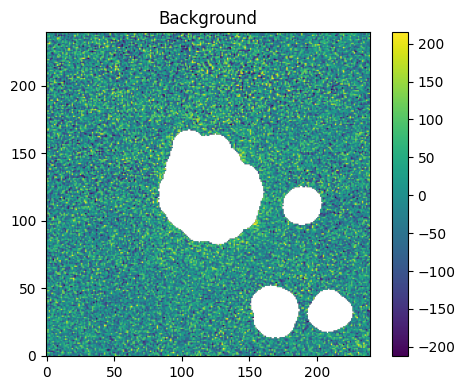

 Pixels used: 4300
 Peak img[j, k]: 121 120
 Mean (j, k): 121.15 120.44
 Theta (deg): 41.2
 Astro PA (deg): 48.8
 Eps: 0.123
 Major axis (pix): 46.9


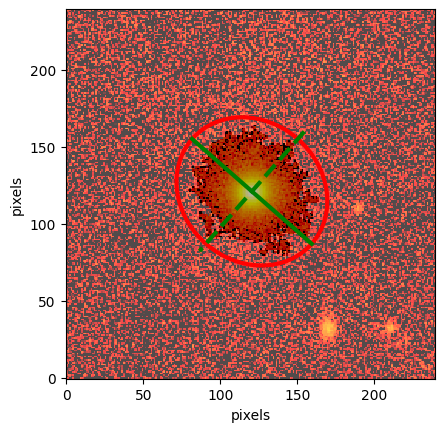

 Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sky Level: 0.886, Sigma: 71.209
Sky Cell ID: 4549972


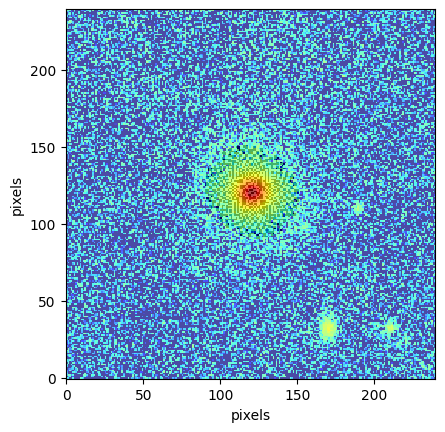

Performing MGE fit for ./data/e-inspire/39627799404745422_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095930801728115, normpsf=1
Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 57.14  Nonzero: 2/3
Iteration: 10  chi2: 4.800  Nonzero: 3/3
Iteration: 11  chi2: 4.800  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.01 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 Total number of points fitted:  364
 Chi2: 4.800 
 STDEV: 0.1141 
 MEANABSDEV: 0.08280 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   5.6046e+05        2.328       1.0000
   6.9781e+05        5.674       1.0000
   6.5664e+05        16.5

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

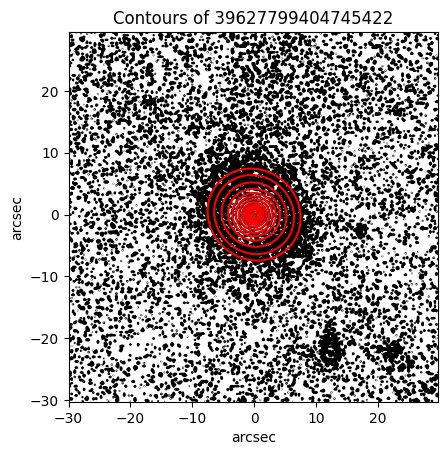

{'Galaxy': 39627799404745422,
 'Reff (arcsec)': np.float64(1.6760714157894814),
 'Reff_maj (arcsec)': np.float64(1.676612291740255),
 'Eccentricity': np.float64(0.0010388118330179053),
 'Luminosity': np.float64(0.00028130546169621916)}

In [49]:
a = get_galaxy_size(filename, row)
a


In [34]:
f, s, scale, sigma_psf, norm_psf = a
ngauss = 3  # Number of Gaussian components for MGE fit
sigmapsf = sigma_psf  # PSF sigma
normpsf = norm_psf  # Normalization factor for PSF
# MGE fit

print(f"Performing MGE fit for {filename} with ngauss={ngauss}, scale={scale}, sigmapsf={sigmapsf}, normpsf={normpsf}")
print(f"Galaxy: {filename} | Sigma PSF: {sigma_psf:.3f}, Normalization PSF: {norm_psf:.3f}")

m = mge_fit_sectors(s.radius, s.angle, s.counts, f.eps,
                    ngauss=ngauss, scale=scale, plot=0,
                    sigmapsf=sigmapsf, normpsf=normpsf)


Performing MGE fit for ./data/e-inspire/39627799404745422_r.fits with ngauss=3, scale=0.2500000060535957, sigmapsf=0.5095930801728115, normpsf=1
Galaxy: ./data/e-inspire/39627799404745422_r.fits | Sigma PSF: 0.510, Normalization PSF: 1.000
Iteration: 0  chi2: 57.14  Nonzero: 2/3
Iteration: 10  chi2: 4.800  Nonzero: 3/3
Iteration: 11  chi2: 4.800  Nonzero: 3/3
Nonzero Gaussians: 3/3
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
CapFit Terminating on small step (xtol), status: 3
  Computation time: 0.03 seconds
  Total Iterations:  11
 Nonzero Gaussians:  3
  Unused Gaussians:  0
 Sectors used in the fit:  19
 Total number of points fitted:  364
 Chi2: 4.800 
 STDEV: 0.1141 
 MEANABSDEV: 0.08280 
############################################
  Total_Counts   sigma_Pixels     q_obs
############################################
   5.6046e+15        2.328       1.0000
   6.9781e+15        5.674       1.0000
   6.5664e+15        16.5

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: divide by zero encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: overflow encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:424: RuntimeWarning: invalid value encountered in matmul
  chi2new, chi2old = chi2(b - A @ x), 1e300
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: divide by zero encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/capfit.py:427: RuntimeWarning: overflow encountered in matmul
  wd = A.T @ (b - A @ x)*d
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/capfit/c

In [41]:
total_counts, sigma, q_obs = m.sol
surf = total_counts / (2 * np.pi * q_obs * sigma**2)
reff, reff_maj, eps_e, lum_tot = jam.mge.half_light_isophote(surf, sigma * scale, q_obs)

/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: divide by zero encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: overflow encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:149: RuntimeWarning: invalid value encountered in matmul
  x2 = image[mask] @ xx2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: divide by zero encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexeysergeyev/code/python/desi/.venv/lib/python3.12/site-packages/jampy/mge/mge_half_light_isophote.py:150: RuntimeWarning: overflow encountered in matmul
  y2 = image[mask] @ yy2[mask]
/Users/alexey

In [39]:
plt.figure(figsize=(10, 5))
mge_print_contours(img, f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                    sigmapsf=sigmapsf, normpsf=normpsf, binning=1, minlevel=minlevel)
plt.title(f"Contours of {galaxy_name}")
plt.show()


array([1.64624963e+14, 3.44937894e+13, 4.12424020e+12])

# Update results

In [19]:
df_results = pd.read_csv('results.csv', index_col=0)
df_results

RA        DEC          Target ID  Sky Cell ID  FWHM (arcsec)  \
Index                                                                         
0      134.650339  -4.602488   2842417304698883      4500357       1.258910   
1      206.999339  -1.800780   2842484900102147      3894861       1.022265   
2      154.216207  -0.796265   2842508174295043      4549942       1.263535   
3      151.622269   7.235106   2842701061947396      4557472       1.193720   
4       20.929319   8.024270   2842716870279169      4091925       1.116345   
...           ...        ...                ...          ...            ...   
1029   236.337511  44.360624  39633153941310268      3626838       1.106400   
1030   246.754521   1.223455  39627819067637938      3584463       1.012410   
1031   125.282385   2.790324   2842592249118720      4476844       1.300900   
1032   349.568591  15.124893  39628149075479853      3950806       1.126515   
1033    12.093095   5.781772  39627923711329320      3957916       1.153745   

       Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  Eccentricity  \
Index                                                                          
0       0.534610  106.200584       1.514095           1.733903      0.239049   
1       0.434116   91.757560       1.060885           1.161201      0.142272   
2       0.536574   92.558044       3.333612           3.454338      0.067749   
3       0.506926  110.344510       1.213412           1.390007      0.236464   
4       0.474068  132.254490       1.738651           2.010362      0.241912   
...          ...         ...            ...                ...           ...   
1029    0.469845   94.516815       1.071203           1.115474      0.075818   
1030    0.429931   80.113630       1.020825           1.141003      0.201162   
1031    0.552441   94.315540       2.453524           2.757845      0.204270   
1032    0.478387  100.515570       1.514152           1.551473      0.047866   
1033    0.489950  111.422310       1.372264           1.390575      0.014591   

       Luminosity  
Index              
0        0.000948  
1        0.000078  
2        0.000963  
3        0.000264  
4        0.001540  
...           ...  
1029     0.000197  
1030     0.000107  
1031     0.000605  
1032     0.000553  
1033     0.000680  

[1029 rows x 11 columns]

In [35]:
df_panstarrs = None
ps_columns = ['Index', 'objName', 'gPSFMag', 'rPSFMag', 'iPSFMag', 'zPSFMag', 'yPSFMag',
              'gPSFMagErr', 'rPSFMagErr', 'iPSFMagErr', 'zPSFMagErr', 'yPSFMagErr',
              'gKronMag', 'rKronMag', 'iKronMag', 'zKronMag', 'yKronMag',
                'gKronMagErr', 'rKronMagErr', 'iKronMagErr', 'zKronMagErr', 'yKronMagErr',
                'gKronRad', 'rKronRad', 'iKronRad', 'zKronRad', 'yKronRad',
                'gexpTime', 'rexpTime', 'iexpTime', 'zexpTime', 'yexpTime',
                'distance']

for i, row in df_results.iterrows():
    ra = row['RA']
    dec = row['DEC']
    idx = row['Target ID']

    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')
    
    try:
        catalog_data = Catalogs.query_region( # type: ignore
            coord,
            radius=0.5/3600.0,
            catalog="Panstarrs",
            data_release="dr2",
            # skyCellID=int(skyCellID),
            table="stack").to_pandas()
        
    except Exception as e:
        print(f"Error querying catalog: {e}")
        continue

    if catalog_data.empty:
        print(f"No catalog data found for RA: {ra}, DEC: {dec}")
        continue


    catalog_data['Index'] = i
    catalog_data['distance'] = catalog_data['distance']* 3600.0  # Convert distance to arcseconds
    if df_panstarrs is None:
        df_panstarrs = catalog_data # type: ignore
    else:
        df_panstarrs = pd.concat([df_panstarrs, catalog_data], ignore_index=True)


    if i > 0 and i % 20 == 0:
        print(f"Processed {i+1} rows, breaking the loop for testing.")
        # df_panstarrs.to_csv('panstarrs_results.csv', index_label='Index')
        # break

df_panstarrs.to_csv('panstarrs_results.csv', index_label='Index')

Processed 21 rows, breaking the loop for testing.
Processed 41 rows, breaking the loop for testing.


No catalog data found for RA: 173.5028032710028, DEC: -4.831274630733524
Processed 61 rows, breaking the loop for testing.


No catalog data found for RA: 215.58178326139495, DEC: -3.428833987229864
Processed 81 rows, breaking the loop for testing.


No catalog data found for RA: 190.2275203511928, DEC: -1.1223263445714635
Processed 101 rows, breaking the loop for testing.
Processed 121 rows, breaking the loop for testing.
Processed 141 rows, breaking the loop for testing.
Processed 161 rows, breaking the loop for testing.


No catalog data found for RA: 160.14652508456712, DEC: 2.287128245637528
Processed 181 rows, breaking the loop for testing.
Processed 201 rows, breaking the loop for testing.


No catalog data found for RA: 251.7750667895849, DEC: 5.809404050466034
Processed 221 rows, breaking the loop for testing.


No catalog data found for RA: 139.8287988754851, DEC: 7.3052646500342355
Processed 241 rows, breaking the loop for testing.
Processed 261 rows, breaking the loop for testing.


No catalog data found for RA: 116.40903250753382, DEC: 15.298976223773447
Processed 281 rows, breaking the loop for testing.
Processed 301 rows, breaking the loop for testing.
Processed 321 rows, breaking the loop for testing.
Processed 341 rows, breaking the loop for testing.
Processed 361 rows, breaking the loop for testing.


No catalog data found for RA: 335.8059386577979, DEC: 31.45349173192225


No catalog data found for RA: 227.41426289207376, DEC: 32.44202133472231
Processed 381 rows, breaking the loop for testing.
Processed 401 rows, breaking the loop for testing.


No catalog data found for RA: 261.93041071907123, DEC: 38.564475784365
Processed 421 rows, breaking the loop for testing.
Processed 441 rows, breaking the loop for testing.
Processed 461 rows, breaking the loop for testing.
Processed 481 rows, breaking the loop for testing.
Processed 501 rows, breaking the loop for testing.
Processed 521 rows, breaking the loop for testing.
Processed 541 rows, breaking the loop for testing.


No catalog data found for RA: 268.71018598933927, DEC: 57.62420448127105
Processed 561 rows, breaking the loop for testing.
Processed 581 rows, breaking the loop for testing.
Processed 601 rows, breaking the loop for testing.
Processed 621 rows, breaking the loop for testing.
Processed 641 rows, breaking the loop for testing.
Processed 661 rows, breaking the loop for testing.
Processed 681 rows, breaking the loop for testing.
Processed 701 rows, breaking the loop for testing.
Processed 721 rows, breaking the loop for testing.
Processed 741 rows, breaking the loop for testing.
Processed 761 rows, breaking the loop for testing.
Processed 781 rows, breaking the loop for testing.
Processed 801 rows, breaking the loop for testing.
Processed 821 rows, breaking the loop for testing.
Processed 841 rows, breaking the loop for testing.
Processed 861 rows, breaking the loop for testing.
Processed 881 rows, breaking the loop for testing.
Processed 901 rows, breaking the loop for testing.
Processed

In [36]:
df_single = df_panstarrs.loc[df_panstarrs.groupby('objName')['nDetections'].idxmax(), ps_columns].sort_values(by='Index')
df_single

Index                objName    gPSFMag    rPSFMag    iPSFMag  \
0         0  PSO J134.6503-04.6025  16.932699  16.326401  15.901900   
1         1  PSO J206.9993-01.8008  19.202101  18.354200  17.862499   
2         2  PSO J154.2162-00.7963  17.933100  16.861500  16.423800   
4         3  PSO J151.6223+07.2351  18.125500  17.156601  16.874599   
5         4  PSO J020.9293+08.0243  17.443701  16.617100  16.074100   
...     ...                    ...        ...        ...        ...   
1253   1029  PSO J236.3375+44.3606  18.390800  17.658100  17.331800   
1254   1030  PSO J246.7545+01.2235  18.977501  18.131201  17.784901   
1255   1031  PSO J125.2824+02.7903  18.209299  17.221001  16.901899   
1257   1032  PSO J349.5686+15.1249  17.587099  16.818199  16.583099   
1258   1033  PSO J012.0931+05.7818  18.091801  17.209400  16.791201   

        zPSFMag    yPSFMag  gPSFMagErr  rPSFMagErr  iPSFMagErr  ...  rKronRad  \
0     15.867400  15.677800    0.002156    0.001078    0.000691  ...   5.92489   
1     17.724400  17.426901    0.005255    0.003981    0.004059  ...   3.77888   
2     16.387400  16.039600    0.003340    0.001488    0.000892  ...       NaN   
4     16.597099  16.573700    0.003621    0.002104    0.001135  ...   4.67951   
5     15.922200  15.668000    0.002205    0.000860    0.000682  ...   7.02077   
...         ...        ...         ...         ...         ...  ...       ...   
1253  17.047300  16.963200    0.005113    0.002082    0.001774  ...   4.66037   
1254  17.551300  17.340500    0.004576    0.002577    0.002124  ...   3.93676   
1255  16.667900  16.601299    0.003682    0.001705    0.001331  ...   8.44656   
1257  16.459700  16.309799    0.002131    0.001297    0.001077  ...   5.78557   
1258  16.625401  16.454901    0.003143    0.001386    0.001155  ...   5.49927   

      iKronRad  zKronRad   yKronRad  gexpTime  rexpTime  iexpTime  zexpTime  \
0      5.69025   5.76032   6.747650     792.0    1035.0    1800.0     570.0   
1      4.42783   4.38289   3.829400     896.0     712.0     855.0     660.0   
2      5.15522  19.41630  16.260401     672.0     784.0    1748.0     766.0   
4      4.70363   4.74848   4.650870     638.0     792.0    1774.0     632.0   
5      8.04871   7.51381   7.888320     602.0    1640.0    1440.0     660.0   
...        ...       ...        ...       ...       ...       ...       ...   
1253   4.48335   4.62352   4.362330     688.0     945.0    1080.0     540.0   
1254   4.30833   3.46435   3.066730     860.0     872.0    1845.0     780.0   
1255   7.79516   8.94037   8.509730     688.0    1000.0    1305.0     750.0   
1257   5.94989   5.57175   6.121010     860.0     960.0    1080.0     660.0   
1258   5.75609   5.36771   5.460790     688.0    1040.0    1935.0     840.0   

      yexpTime  distance  
0        780.0  0.014316  
1        970.0  0.009588  
2        810.0  0.021443  
4        670.0  0.008947  
5        640.0  0.026664  
...        ...       ...  
1253     590.0  0.005744  
1254     790.0  0.005669  
1255     700.0  0.019720  
1257     720.0  0.006391  
1258     940.0  0.049275  

[1018 rows x 33 columns]

In [37]:
df_merged = pd.merge(df_results, df_single, on='Index', how='outer')
df_merged.to_csv('./data/merged_results.csv', index_label='Index')
df_merged

Index          RA        DEC          Target ID  Sky Cell ID  \
0         0  134.650339  -4.602488   2842417304698883      4500357   
1         1  206.999339  -1.800780   2842484900102147      3894861   
2         2  154.216207  -0.796265   2842508174295043      4549942   
3         3  151.622269   7.235106   2842701061947396      4557472   
4         4   20.929319   8.024270   2842716870279169      4091925   
...     ...         ...        ...                ...          ...   
1024   1029  236.337511  44.360624  39633153941310268      3626838   
1025   1030  246.754521   1.223455  39627819067637938      3584463   
1026   1031  125.282385   2.790324   2842592249118720      4476844   
1027   1032  349.568591  15.124893  39628149075479853      3950806   
1028   1033   12.093095   5.781772  39627923711329320      3957916   

      FWHM (arcsec)  Sigma PSF    minlevel  Reff (arcsec)  Reff_maj (arcsec)  \
0          1.258910   0.534610  106.200584       1.514095           1.733903   
1          1.022265   0.434116   91.757560       1.060885           1.161201   
2          1.263535   0.536574   92.558044       3.333612           3.454338   
3          1.193720   0.506926  110.344510       1.213412           1.390007   
4          1.116345   0.474068  132.254490       1.738651           2.010362   
...             ...        ...         ...            ...                ...   
1024       1.106400   0.469845   94.516815       1.071203           1.115474   
1025       1.012410   0.429931   80.113630       1.020825           1.141003   
1026       1.300900   0.552441   94.315540       2.453524           2.757845   
1027       1.126515   0.478387  100.515570       1.514152           1.551473   
1028       1.153745   0.489950  111.422310       1.372264           1.390575   

      ...  rKronRad  iKronRad  zKronRad   yKronRad  gexpTime  rexpTime  \
0     ...   5.92489   5.69025   5.76032   6.747650     792.0    1035.0   
1     ...   3.77888   4.42783   4.38289   3.829400     896.0     712.0   
2     ...       NaN   5.15522  19.41630  16.260401     672.0     784.0   
3     ...   4.67951   4.70363   4.74848   4.650870     638.0     792.0   
4     ...   7.02077   8.04871   7.51381   7.888320     602.0    1640.0   
...   ...       ...       ...       ...        ...       ...       ...   
1024  ...   4.66037   4.48335   4.62352   4.362330     688.0     945.0   
1025  ...   3.93676   4.30833   3.46435   3.066730     860.0     872.0   
1026  ...   8.44656   7.79516   8.94037   8.509730     688.0    1000.0   
1027  ...   5.78557   5.94989   5.57175   6.121010     860.0     960.0   
1028  ...   5.49927   5.75609   5.36771   5.460790     688.0    1040.0   

      iexpTime  zexpTime  yexpTime  distance  
0       1800.0     570.0     780.0  0.014316  
1        855.0     660.0     970.0  0.009588  
2       1748.0     766.0     810.0  0.021443  
3       1774.0     632.0     670.0  0.008947  
4       1440.0     660.0     640.0  0.026664  
...        ...       ...       ...       ...  
1024    1080.0     540.0     590.0  0.005744  
1025    1845.0     780.0     790.0  0.005669  
1026    1305.0     750.0     700.0  0.019720  
1027    1080.0     660.0     720.0  0.006391  
1028    1935.0     840.0     940.0  0.049275  

[1029 rows x 44 columns]

Index                objName    gPSFMag    rPSFMag    iPSFMag    zPSFMag  \
0       0  PSO J134.6503-04.6025  16.932699  16.326401  15.901900  15.867400   
1       1  PSO J206.9993-01.8008  19.202101  18.354200  17.862499  17.724400   
2       2  PSO J154.2162-00.7963  17.933100  16.861500  16.423800  16.387400   
4       3  PSO J151.6223+07.2351  18.125500  17.156601  16.874599  16.597099   
5       4  PSO J020.9293+08.0243  17.443701  16.617100  16.074100  15.922200   
6       5  PSO J122.7971+16.7228  19.281700  18.509001  18.114201  17.728901   
7       6  PSO J087.7325-24.2527  22.303400  21.069901  20.186701  19.806801   
8       7  PSO J086.7256-20.6296  20.581900  19.311001  18.778200  18.636499   
9       8  PSO J062.9508-16.6838  18.424000  17.769501  17.456699  17.126200   
10      9  PSO J046.3087-14.3811  16.554001  15.971100  15.626400  15.445000   
12     10  PSO J023.1220-13.6060  18.889200  17.934299  17.578501  17.386299   
14     11  PSO J060.1709-12.7722  18.069201  17.148199  17.052200  16.623501   
15     12  PSO J343.9588-10.8467  18.235001  17.467699  17.202101  16.904200   
16     13  PSO J019.5099-10.1735  20.629700  19.178301  18.749500  18.604700   
17     14  PSO J020.5384-09.8886  16.382299  15.788100  15.467400  15.407500   
18     15  PSO J047.1118-10.0444  21.084900  19.326599  18.766500  18.384899   
19     16  PSO J332.5009-09.4683  18.408300  17.710300  17.266800  17.062000   
21     17  PSO J172.2438-08.8913  19.046400  18.145700  17.807301  17.515301   
22     18  PSO J060.7981-08.5864  17.570801  16.603800  16.349100  15.999400   
23     19  PSO J201.7507-08.5226  20.185400  18.840401  18.547600  18.430099   
24     20  PSO J213.9988-08.4851  19.018200  18.251801  17.978201  17.811800   

      yPSFMag  gPSFMagErr  rPSFMagErr  iPSFMagErr  ...  rKronRad  iKronRad  \
0   15.677800    0.002156    0.001078    0.000691  ...   5.92489   5.69025   
1   17.426901    0.005255    0.003981    0.004059  ...   3.77888   4.42783   
2   16.039600    0.003340    0.001488    0.000892  ...       NaN   5.15522   
4   16.573700    0.003621    0.002104    0.001135  ...   4.67951   4.70363   
5   15.668000    0.002205    0.000860    0.000682  ...   7.02077   8.04871   
6   17.593300    0.006177    0.003347    0.002641  ...   2.61992   3.45760   
7   19.512600    0.128185    0.090101    0.026619  ...   3.05062   3.25221   
8   18.347000    0.017442    0.007282    0.005630  ...   3.80949   4.10973   
9   17.062500    0.004481    0.002167    0.001288  ...   5.62175   4.74317   
10  15.038100    0.001418    0.000986    0.000660  ...   5.14622   5.24241   
12  17.094999    0.005299    0.003180    0.001692  ...   5.57941   5.75447   
14  16.497200    0.003553    0.002431    0.001151  ...   5.52986   5.53449   
15  16.709200    0.003480    0.002049    0.001165  ...   6.55446   6.76588   
16  18.497900    0.019477    0.004450    0.003632  ...   3.71351   3.47776   
17  15.041400    0.001187    0.001024    0.000731  ...  11.58340  11.18790   
18  18.286699    0.036232    0.006529    0.005393  ...   4.70802   5.37810   
19  16.822001    0.003598    0.001932    0.001283  ...   3.88392   3.88571   
21  17.449499    0.005707    0.002551    0.002836  ...   5.10128   5.43232   
22  15.932600    0.003321    0.000947    0.000680  ...   7.24516   7.68338   
23  18.344200    0.011482    0.004325    0.004973  ...   3.77160   3.59189   
24  17.696699    0.005269    0.003684    0.002854  ...   3.75821   3.97903   

    zKronRad   yKronRad  gexpTime  rexpTime  iexpTime  zexpTime  yexpTime  \
0    5.76032   6.747650     792.0    1035.0    1800.0     570.0     780.0   
1    4.38289   3.829400     896.0     712.0     855.0     660.0     970.0   
2   19.41630  16.260401     672.0     784.0    1748.0     766.0     810.0   
4    4.74848   4.650870     638.0     792.0    1774.0     632.0     670.0   
5    7.51381   7.888320     602.0    1640.0    1440.0     660.0     640.0   
6    2.98247   3.071860     688.0    1222.0    1455.0     750.0 